# import


In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())


1.12.1+cu113
0.13.1+cu113
True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import albumentations as A
import random

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
!nvidia-smi

Sun Oct 16 12:22:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --upgrade albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 14.7 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


# data

!gdown --id 1rZX15GYUJ44kEiuZOPUL4quOjcqwi-f5 --output documents.zip
!unzip -q documents.zip
!ls

Mounted at /content/drive


In [ ]:
import shutil
shutil.copytree('/content/data_coco','/content/drive/MyDrive/Lesion_detection/data_coco')

'/content/drive/MyDrive/Lesion_detection/data_coco'

In [ ]:
import os
import zipfile

ZIP_PATH='/content/drive/MyDrive/Lesion_detection/lesion_data_small.zip'
UNZIP_PATH='/content/'

# 전체를 압축해제 하고 싶을 때
zipfile.ZipFile(ZIP_PATH).extractall(UNZIP_PATH)


In [ ]:
# split_data.py

from glob import glob
import shutil
import os
import random

load_dir = '/content/lesion_data_small'
save_dir = '/content/data_split'

files = glob('%s/train/*.json' % load_dir)
random.shuffle(files)

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

shutil.copyfile('%s/class_id_info.csv' % load_dir, "%s/class_id_info.csv" % save_dir)
shutil.copyfile('%s/sample_submission.csv' % load_dir, "%s/sample_submission.csv" % save_dir)
shutil.copytree("%s/test" % load_dir, "%s/test" % save_dir)

num_all = len(files)
num_valid = round(0.1 * num_all)

ind = 0
for file in files:
    if ind < num_all - num_valid:
        shutil.copyfile(file, "%s/train/%s" % (save_dir, os.path.basename(file)))
    else:
        shutil.copyfile(file, "%s/valid/%s" % (save_dir, os.path.basename(file)))
    ind += 1
    


In [ ]:
# convert_to_coco.py
# basic setup
import numpy as np
import json
import base64
import os
import random
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

from collections import defaultdict

#base_dir = '/home/ubuntu/lesionData/data_split'
#save_dir = "/home/ubuntu/lesionData/data_coco"

#base_dir = 'C:/A/lesionData/data_split'
#save_dir = "C:/A/lesionData/data_coco"

base_dir = '/content/data_split'
save_dir = "/content/data_coco"


def convert_to_coco(
    json_paths, # 변경
    save_path,
    save_folder,
):
    """
        only for train dataset
    """
    res = defaultdict(list)
    # 제거
    # json_paths = glob(os.path.join(root_path, 'train', '*.json'))
    categories = {
        '01_ulcer': 1,
        '02_mass': 2,
        '04_lymph': 3,
        '05_bleeding': 4
    }
    
    n_id = 0
    for json_path in tqdm(json_paths):
        with open(json_path, 'r') as f:
            tmp = json.load(f)

        # [추가] train image 저장
        image = BytesIO(base64.b64decode(tmp['imageData']))
        image = Image.open(image).convert('RGB')
        
        image.save(os.path.join(save_dir, save_folder, tmp['file_name'].split(".")[0]+".jpg"))
        
        image_id = int(tmp['file_name'].split('_')[-1][:6])
        res['images'].append({
            'id': image_id,
            'width': tmp['imageWidth'],
            'height': tmp['imageHeight'],
            'file_name': tmp['file_name'].split(".")[0]+".jpg", # 변경
        })
        
        for shape in tmp['shapes']:
            box = np.array(shape['points']) # 추가
            x1, y1, x2, y2 = \
                    min(box[:, 0]), min(box[:, 1]), max(box[:, 0]), max(box[:, 1])
            
            w, h = x2 - x1, y2 - y1
            
            res['annotations'].append({
                'id': n_id,
                'image_id': image_id,
                'category_id': categories[shape['label']],
                'area': w * h,
                'bbox': [x1, y1, x2, y2],
                'iscrowd': 0,
            })
            n_id += 1
    
    for name, id in categories.items():
        res['categories'].append({
            'id': id,
            'name': name,
        })
        
    with open(save_path, 'w') as f:
        json.dump(res, f)
        
save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
    
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

    
random.seed(10)

train_file = glob(os.path.join(base_dir, 'train/*.json'))
valid_file = glob(os.path.join(base_dir, 'valid/*.json'))

convert_to_coco(train_file, os.path.join(save_dir, 'train_annotations.json'), 'train')
convert_to_coco(valid_file, os.path.join(save_dir, 'valid_annotations.json'), 'valid')


##################################test################################################
test_files = sorted(glob(os.path.join(base_dir, 'test/*')))


test_json_list = []
for file in tqdm(test_files):
    with open(file, "r") as json_file:
        test_json_list.append(json.load(json_file))
        
save_path_dir = os.path.join(save_dir, "test")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

for sample in tqdm(test_json_list):
    
    image_id = sample['file_name'].split(".")[0]
    image = BytesIO(base64.b64decode(sample['imageData']))
    image = Image.open(image).convert('RGB')
    
    image.save(os.path.join(save_dir,"test",image_id+".jpg"))


100%|██████████| 200/200 [00:02<00:00, 79.48it/s]


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = '/content/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VAILD = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'


In [ ]:
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [ ]:
import json

file_path = DIR_INPUT+"/train_annotations.json"

with open(file_path, 'r') as file:
    data = json.load(file)

print(data.keys())


dict_keys(['images', 'annotations', 'categories'])


In [ ]:
print(len(data['images']))
print(len(data['annotations']))
print(len(data['categories']))


900
1151
4


In [ ]:
import pandas as pd

train_dic={
    'image_id':[],
    'class_name':[],
    'class_id':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'width':[],
    'height':[],
    'file_name':[]
}

for i,dic in tqdm(enumerate(data['annotations'])):
    image_id=dic['image_id']
    category_id=dic['category_id']
    train_dic['image_id'].append(image_id)
    train_dic['class_id'].append(category_id)

    if category_id == 1:
        train_dic['class_name'].append('01_ulcer')
    elif category_id == 2:
        train_dic['class_name'].append('02_mass')
    elif category_id == 3:
        train_dic['class_name'].append('04_lymph')
    else:
        train_dic['class_name'].append('05_bleeding')            
        
    train_dic['x_min'].append(round(dic['bbox'][0],4))
    train_dic['y_min'].append(round(dic['bbox'][1],4))
    train_dic['x_max'].append(round(dic['bbox'][2],4))
    train_dic['y_max'].append(round(dic['bbox'][3],4))
    
    for k,dic2 in enumerate(data['images']):
      if dic2['id'] == image_id:
           train_dic['width'].append(dic2['width'])
           train_dic['height'].append(dic2['height'])
           train_dic['file_name'].append(dic2['file_name'])

    
    
train_df=pd.DataFrame(train_dic)    


1151it [00:00, 6904.07it/s]


In [ ]:
train_df

image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1151 rows x 10 columns]

In [ ]:
DIR_INPUT = '/content/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VALID = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [ ]:
import json

file_path = DIR_INPUT+"/valid_annotations.json"

with open(file_path, 'r') as file:
    data = json.load(file)

print(data.keys())


dict_keys(['images', 'annotations', 'categories'])


In [ ]:
print(len(data['images']))
print(len(data['annotations']))
print(len(data['categories']))


100
121
4


In [ ]:
import pandas as pd
# [{'id': 148662, 'width': 320, 'height': 320, 'file_name': 'train_148662.jpg'},

valid_dic={
    'image_id':[],
    'class_name':[],
    'class_id':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'width':[],
    'height':[],
    'file_name':[]
}

for i,dic in tqdm(enumerate(data['annotations'])):
    image_id=dic['image_id']
    category_id = dic['category_id']
    valid_dic['image_id'].append(image_id)
    valid_dic['class_id'].append(category_id)
    if category_id == 1:
        valid_dic['class_name'].append('01_ulcer')
    elif category_id == 2:
        valid_dic['class_name'].append('02_mass')
    elif category_id == 3:
        valid_dic['class_name'].append('04_lymph')
    else:
        valid_dic['class_name'].append('05_bleeding')            
    valid_dic['x_min'].append(round(dic['bbox'][0],4))
    valid_dic['y_min'].append(round(dic['bbox'][1],4))
    valid_dic['x_max'].append(round(dic['bbox'][2],4))
    valid_dic['y_max'].append(round(dic['bbox'][3],4))
    
    for k,dic2 in enumerate(data['images']):
      if dic2['id'] == image_id:
           valid_dic['width'].append(dic2['width'])
           valid_dic['height'].append(dic2['height'])
           valid_dic['file_name'].append(dic2['file_name'])

    
    
valid_df=pd.DataFrame(valid_dic)    


121it [00:00, 46887.54it/s]


In [ ]:
train_df = train_df[train_df['x_max']<train_df['width']]
train_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1149 rows x 10 columns]

In [ ]:
train_df = train_df[train_df['x_min']>0]
train_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1149 rows x 10 columns]

In [ ]:
train_df = train_df[train_df['y_min']>0]
train_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1149 rows x 10 columns]

In [ ]:
train_df = train_df[train_df['y_max']<train_df['height']]
train_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1149 rows x 10 columns]

In [ ]:
valid_df = valid_df[valid_df['x_max']<valid_df['width']]
valid_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0      122348      02_mass         2  365.0206  162.0741  543.6214  355.4897   
1      122348     01_ulcer         1  143.4444  209.3333  310.5556  413.7778   
2      161027     01_ulcer         1  468.6923  276.9231  510.7041  336.0947   
3      158267  05_bleeding         4  197.5904  206.9157  260.2410  262.3373   
4      110855     04_lymph         3  127.3077   86.7788  173.9423  115.3846   
..        ...          ...       ...       ...       ...       ...       ...   
116    146889     01_ulcer         1  127.8943  116.2996  272.3877  274.8899   
117    146889     01_ulcer         1   82.0705  246.2555  238.4670  480.6167   
118    120676     01_ulcer         1  409.0712  287.7241  535.2781  438.0690   
119    140503  05_bleeding         4  380.6108  371.8563  430.3114  461.6766   
120    148113     01_ulcer         1   32.6316  154.6053  335.2632  351.9737   

     width  height         file_name  
0      576     576  train_122348.jpg  
1      576     576  train_122348.jpg  
2      576     576  train_161027.jpg  
3      576     576  train_158267.jpg  
4      320     320  train_110855.jpg  
..     ...     ...               ...  
116    576     576  train_146889.jpg  
117    576     576  train_146889.jpg  
118    576     576  train_120676.jpg  
119    576     576  train_140503.jpg  
120    576     576  train_148113.jpg  

[121 rows x 10 columns]

In [ ]:
valid_df = valid_df[valid_df['x_min']>0]
valid_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0      122348      02_mass         2  365.0206  162.0741  543.6214  355.4897   
1      122348     01_ulcer         1  143.4444  209.3333  310.5556  413.7778   
2      161027     01_ulcer         1  468.6923  276.9231  510.7041  336.0947   
3      158267  05_bleeding         4  197.5904  206.9157  260.2410  262.3373   
4      110855     04_lymph         3  127.3077   86.7788  173.9423  115.3846   
..        ...          ...       ...       ...       ...       ...       ...   
116    146889     01_ulcer         1  127.8943  116.2996  272.3877  274.8899   
117    146889     01_ulcer         1   82.0705  246.2555  238.4670  480.6167   
118    120676     01_ulcer         1  409.0712  287.7241  535.2781  438.0690   
119    140503  05_bleeding         4  380.6108  371.8563  430.3114  461.6766   
120    148113     01_ulcer         1   32.6316  154.6053  335.2632  351.9737   

     width  height         file_name  
0      576     576  train_122348.jpg  
1      576     576  train_122348.jpg  
2      576     576  train_161027.jpg  
3      576     576  train_158267.jpg  
4      320     320  train_110855.jpg  
..     ...     ...               ...  
116    576     576  train_146889.jpg  
117    576     576  train_146889.jpg  
118    576     576  train_120676.jpg  
119    576     576  train_140503.jpg  
120    576     576  train_148113.jpg  

[121 rows x 10 columns]

In [ ]:
valid_df = valid_df[valid_df['y_max']<valid_df['height']]
valid_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0      122348      02_mass         2  365.0206  162.0741  543.6214  355.4897   
1      122348     01_ulcer         1  143.4444  209.3333  310.5556  413.7778   
2      161027     01_ulcer         1  468.6923  276.9231  510.7041  336.0947   
3      158267  05_bleeding         4  197.5904  206.9157  260.2410  262.3373   
4      110855     04_lymph         3  127.3077   86.7788  173.9423  115.3846   
..        ...          ...       ...       ...       ...       ...       ...   
116    146889     01_ulcer         1  127.8943  116.2996  272.3877  274.8899   
117    146889     01_ulcer         1   82.0705  246.2555  238.4670  480.6167   
118    120676     01_ulcer         1  409.0712  287.7241  535.2781  438.0690   
119    140503  05_bleeding         4  380.6108  371.8563  430.3114  461.6766   
120    148113     01_ulcer         1   32.6316  154.6053  335.2632  351.9737   

     width  height         file_name  
0      576     576  train_122348.jpg  
1      576     576  train_122348.jpg  
2      576     576  train_161027.jpg  
3      576     576  train_158267.jpg  
4      320     320  train_110855.jpg  
..     ...     ...               ...  
116    576     576  train_146889.jpg  
117    576     576  train_146889.jpg  
118    576     576  train_120676.jpg  
119    576     576  train_140503.jpg  
120    576     576  train_148113.jpg  

[121 rows x 10 columns]

In [ ]:
valid_df = valid_df[valid_df['y_min']>0]
valid_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0      122348      02_mass         2  365.0206  162.0741  543.6214  355.4897   
1      122348     01_ulcer         1  143.4444  209.3333  310.5556  413.7778   
2      161027     01_ulcer         1  468.6923  276.9231  510.7041  336.0947   
3      158267  05_bleeding         4  197.5904  206.9157  260.2410  262.3373   
4      110855     04_lymph         3  127.3077   86.7788  173.9423  115.3846   
..        ...          ...       ...       ...       ...       ...       ...   
116    146889     01_ulcer         1  127.8943  116.2996  272.3877  274.8899   
117    146889     01_ulcer         1   82.0705  246.2555  238.4670  480.6167   
118    120676     01_ulcer         1  409.0712  287.7241  535.2781  438.0690   
119    140503  05_bleeding         4  380.6108  371.8563  430.3114  461.6766   
120    148113     01_ulcer         1   32.6316  154.6053  335.2632  351.9737   

     width  height         file_name  
0      576     576  train_122348.jpg  
1      576     576  train_122348.jpg  
2      576     576  train_161027.jpg  
3      576     576  train_158267.jpg  
4      320     320  train_110855.jpg  
..     ...     ...               ...  
116    576     576  train_146889.jpg  
117    576     576  train_146889.jpg  
118    576     576  train_120676.jpg  
119    576     576  train_140503.jpg  
120    576     576  train_148113.jpg  

[121 rows x 10 columns]

In [ ]:
# train_df 전체 데이터 정보 저장하기
train_df.to_csv(f'{DIR_INPUT}/train.csv')


In [ ]:
# valid_df 전체 데이터 정보 저장하기
valid_df.to_csv(f'{DIR_INPUT}/valid.csv')


In [ ]:
import shutil
shutil.copytree('/content/data_coco','/content/drive/MyDrive/Lesion_detection/small_data_coco_1')

'/content/drive/MyDrive/Lesion_detection/small_data_coco_1'

# 함수

In [ ]:
# 박스 색깔
BOX_COLOR = (255, 0, 0)

# 박스 보여주기 함수
def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

In [ ]:
# 이미지 보여주기
def show_image(image, bbox):
  image = visualize_bbox(image.copy(), bbox)
  f = plt.figure(figsize=(18, 12))
  plt.imshow(
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    interpolation='nearest'
  )
  plt.axis('off')
  f.tight_layout()
  plt.show()

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Lesion_detection/data_coco/train_df_short.csv',index_col=0)
train_df

image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
1       100001     01_ulcer         1  157.9928  144.4748  281.0144  273.2518   
2       100003     01_ulcer         1  400.9852  125.0542  545.8128  272.3448   
5       100006     01_ulcer         1  435.7647  207.3824  544.5882  398.5588   
6       100008     01_ulcer         1  249.0000  100.1538  393.6154  221.6923   
9       100011     01_ulcer         1  236.8918  220.7792  308.3203  288.7446   
...        ...          ...       ...       ...       ...       ...       ...   
2077    101787  05_bleeding         4  180.7229  188.8434  272.2892  381.6145   
2087    101794  05_bleeding         4  309.6667  349.6667  411.6667  429.0000   
2091    101797  05_bleeding         4   78.3333   37.6667  391.0000  120.3333   
2095    101802  05_bleeding         4  182.8739   93.0840  245.8992  198.1261   
2097    101804  05_bleeding         4  329.5181  452.6988  409.0361  531.0120   

      width  height         file_name          area  
1       576     576  train_100001.jpg  15842.352583  
2       576     576  train_100003.jpg  21331.744101  
5       576     576  train_100006.jpg  20804.484965  
6       576     576  train_100008.jpg  17576.338793  
9       576     576  train_100011.jpg   4854.666574  
...     ...     ...               ...           ...  
2077    576     576  train_101787.jpg  17651.336374  
2087    576     576  train_101794.jpg   8091.996600  
2091    576     576  train_101797.jpg  25847.093022  
2095    576     576  train_101802.jpg   6620.309865  
2097    576     576  train_101804.jpg   6227.309038  

[2800 rows x 11 columns]

In [ ]:
train_df['class_id'].value_counts()

1    1000
2     700
3     600
4     500
Name: class_id, dtype: int64

In [ ]:
train_df['class_name'].value_counts()

01_ulcer       1000
02_mass         700
04_lymph        600
05_bleeding     500
Name: class_name, dtype: int64

# 2, 02_mass 증강

In [ ]:
!rm -rf /content/drive/MyDrive/augumentation/lymph_augmix

In [ ]:
mass_df=train_df[train_df['class_id']==2]

In [ ]:
mass_df

image_id class_name  class_id     x_min     y_min     x_max     y_max  \
3       100004    02_mass         2  241.6879  156.1254  381.2563  282.0247   
14      100015    02_mass         2  458.6715  305.1873  537.9222  416.7147   
16      100017    02_mass         2  442.7778  340.8889  509.4444  416.0000   
17      100017    02_mass         2  283.2222  310.2222  336.5556  354.2222   
18      100018    02_mass         2  232.6032  324.5323  425.9807  505.9892   
...        ...        ...       ...       ...       ...       ...       ...   
5725    104980    02_mass         2  160.0000  179.1837  318.7347  319.0000   
5728    104982    02_mass         2  145.3235   31.7941  270.3235  216.3529   
5733    104986    02_mass         2  304.6083   31.9263  541.9355  458.1935   
5735    104988    02_mass         2  257.2016  336.8601  396.7078  510.5226   
5758    105003    02_mass         2  266.0672  311.5714  315.6471  353.5882   

      width  height         file_name           area  
3       576     576  train_100004.jpg   17571.563862  
14      576     576  train_100015.jpg    8838.624519  
16      576     576  train_100017.jpg    5007.401659  
17      576     576  train_100017.jpg    2346.669600  
18      576     576  train_100018.jpg   35089.681680  
...     ...     ...               ...            ...  
5725    320     320  train_104980.jpg   22193.698436  
5728    576     576  train_104982.jpg   23069.850000  
5733    576     576  train_104986.jpg  101164.801028  
5735    576     576  train_104988.jpg   24226.995458  
5758    576     576  train_105003.jpg    2083.188742  

[700 rows x 11 columns]

In [ ]:
for i,k in enumerate(mass_df.iloc):
  if(i==1): break
  print(k[3:7],k['file_name'])  

x_min    241.6879
y_min    156.1254
x_max    381.2563
y_max    282.0247
Name: 3, dtype: object train_100004.jpg


In [ ]:
file_name= mass_df.iloc[0]['file_name']
DIR_TRAIN = '/content/drive/MyDrive/Lesion_detection/data_coco/train/'
print(DIR_TRAIN+file_name)
form = cv2.imread(DIR_TRAIN+file_name)
#BBOX = [140, 260, 300, 300]
BBox= []
BBox.append(float(mass_df.iloc[0]['x_min']))
BBox.append(float(mass_df.iloc[0]['y_min']))
BBox.append(float(mass_df.iloc[0]['x_max']))
BBox.append(float(mass_df.iloc[0]['y_max']))
print(BBox)

/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100004.jpg
[241.6879, 156.1254, 381.2563, 282.0247]


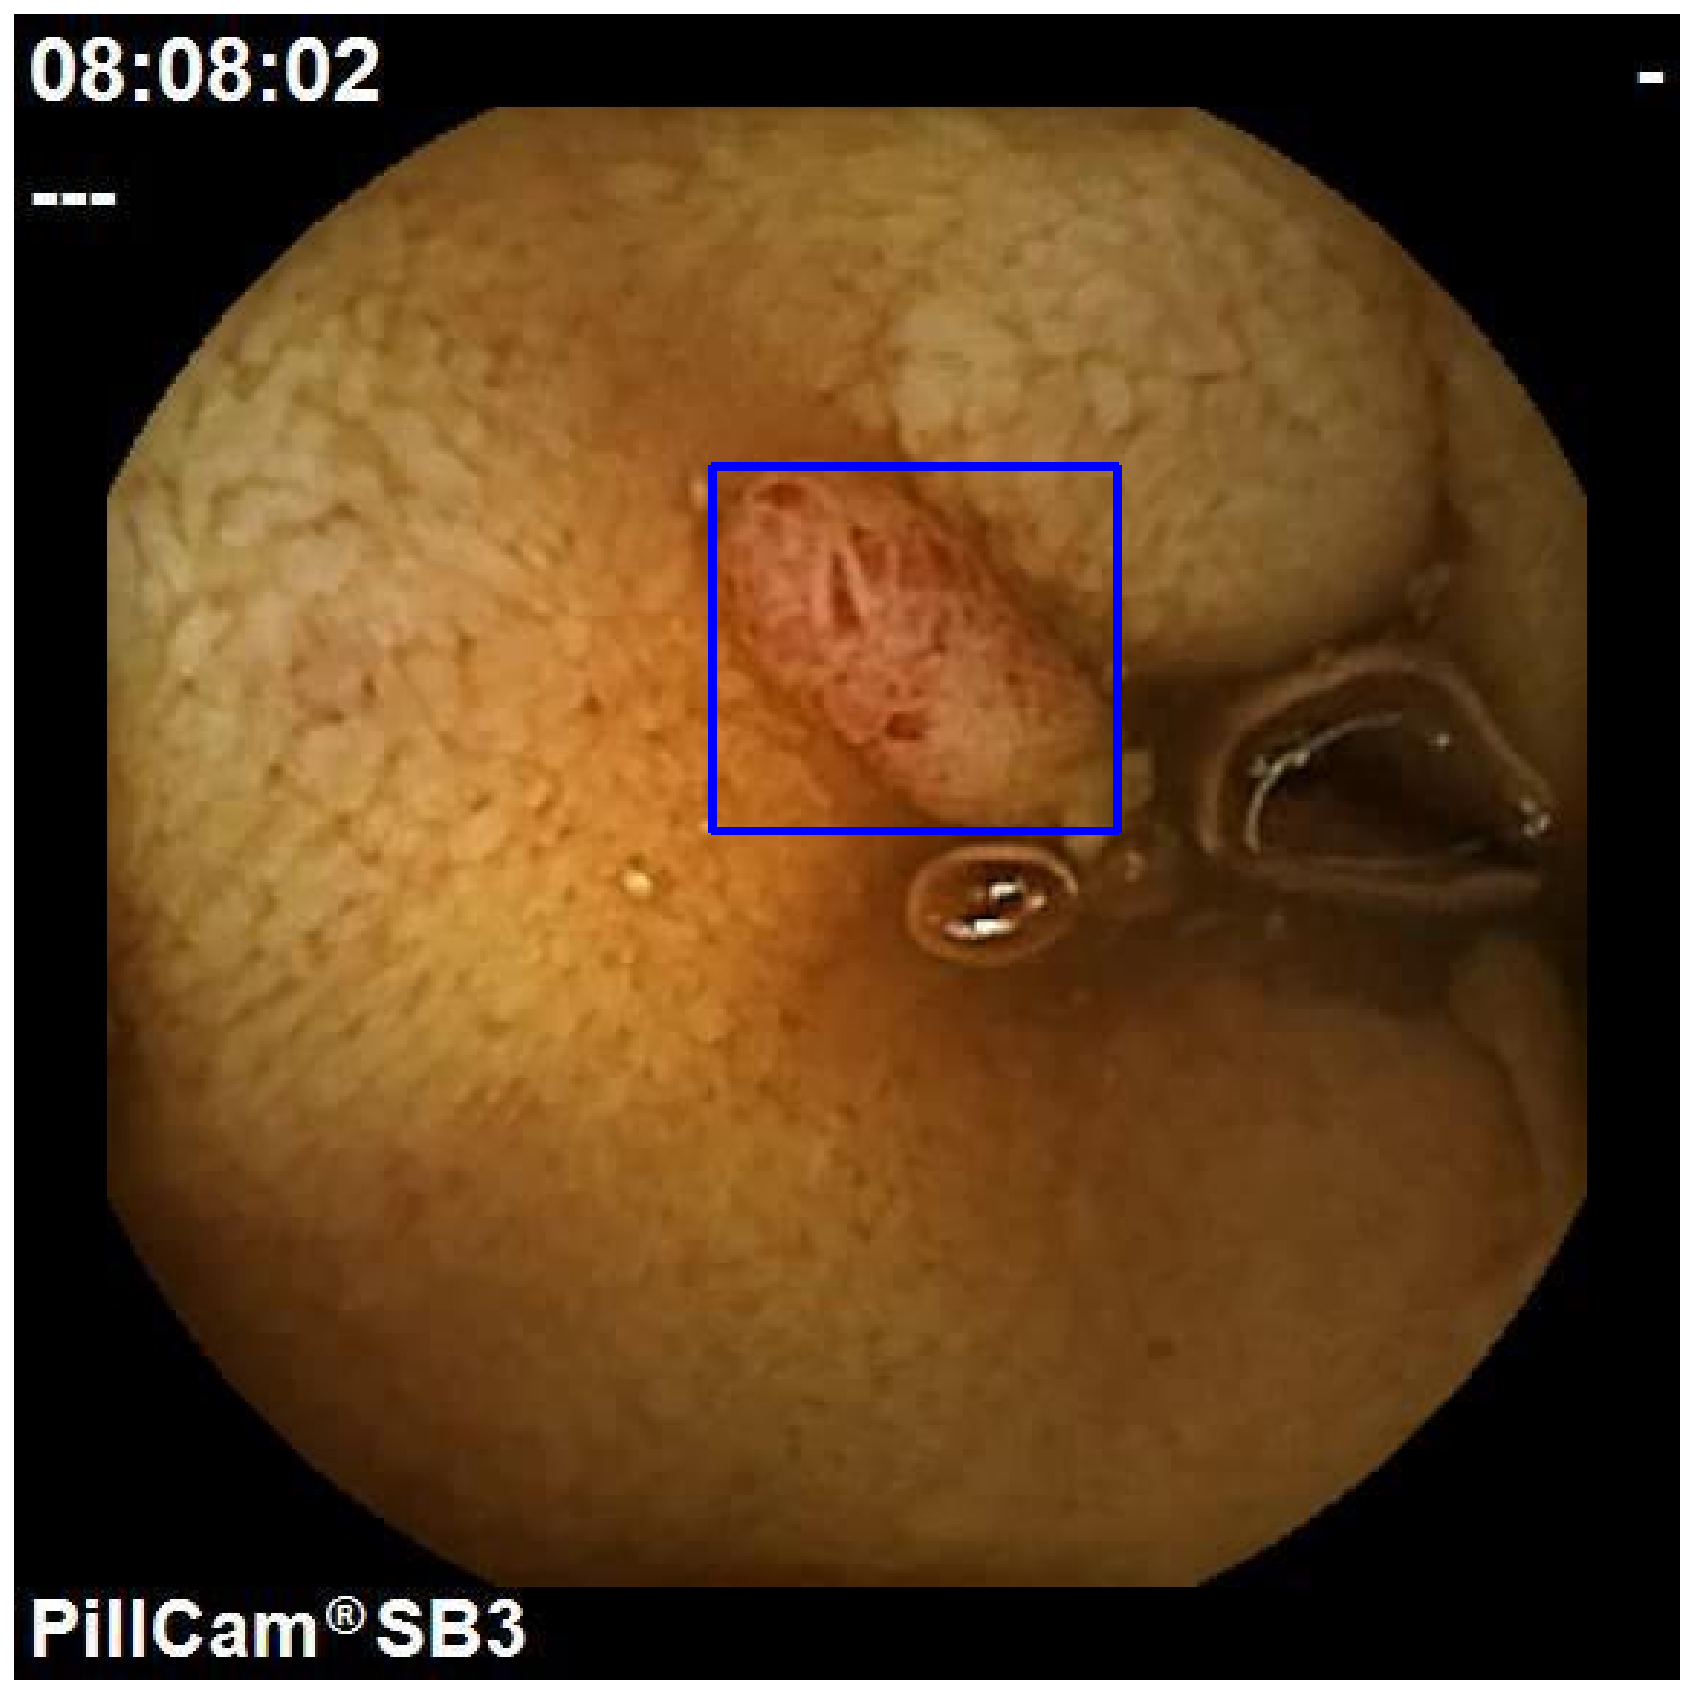

In [ ]:
show_image(form, bbox=BBox)

In [ ]:
# 증강 보여주깅
def show_augmented(augmentation, image, bbox):
  # 증강 함수 틀
  augmented = augmentation(image=image, bboxes=[bbox], field_id=['2'])
  # 이미지 보여주는 함수
  show_image(augmented['image'], augmented['bboxes'][0])

In [ ]:
# bbox 증강
# [x_min, y_min, x_max, y_max], e.g. [97, 12, 247, 212].
bbox_params = A.BboxParams(
  format='pascal_voc', 
  min_area=1, 
  min_visibility=0.5, 
  label_fields=['field_id']
)

# Exploring Augmentations

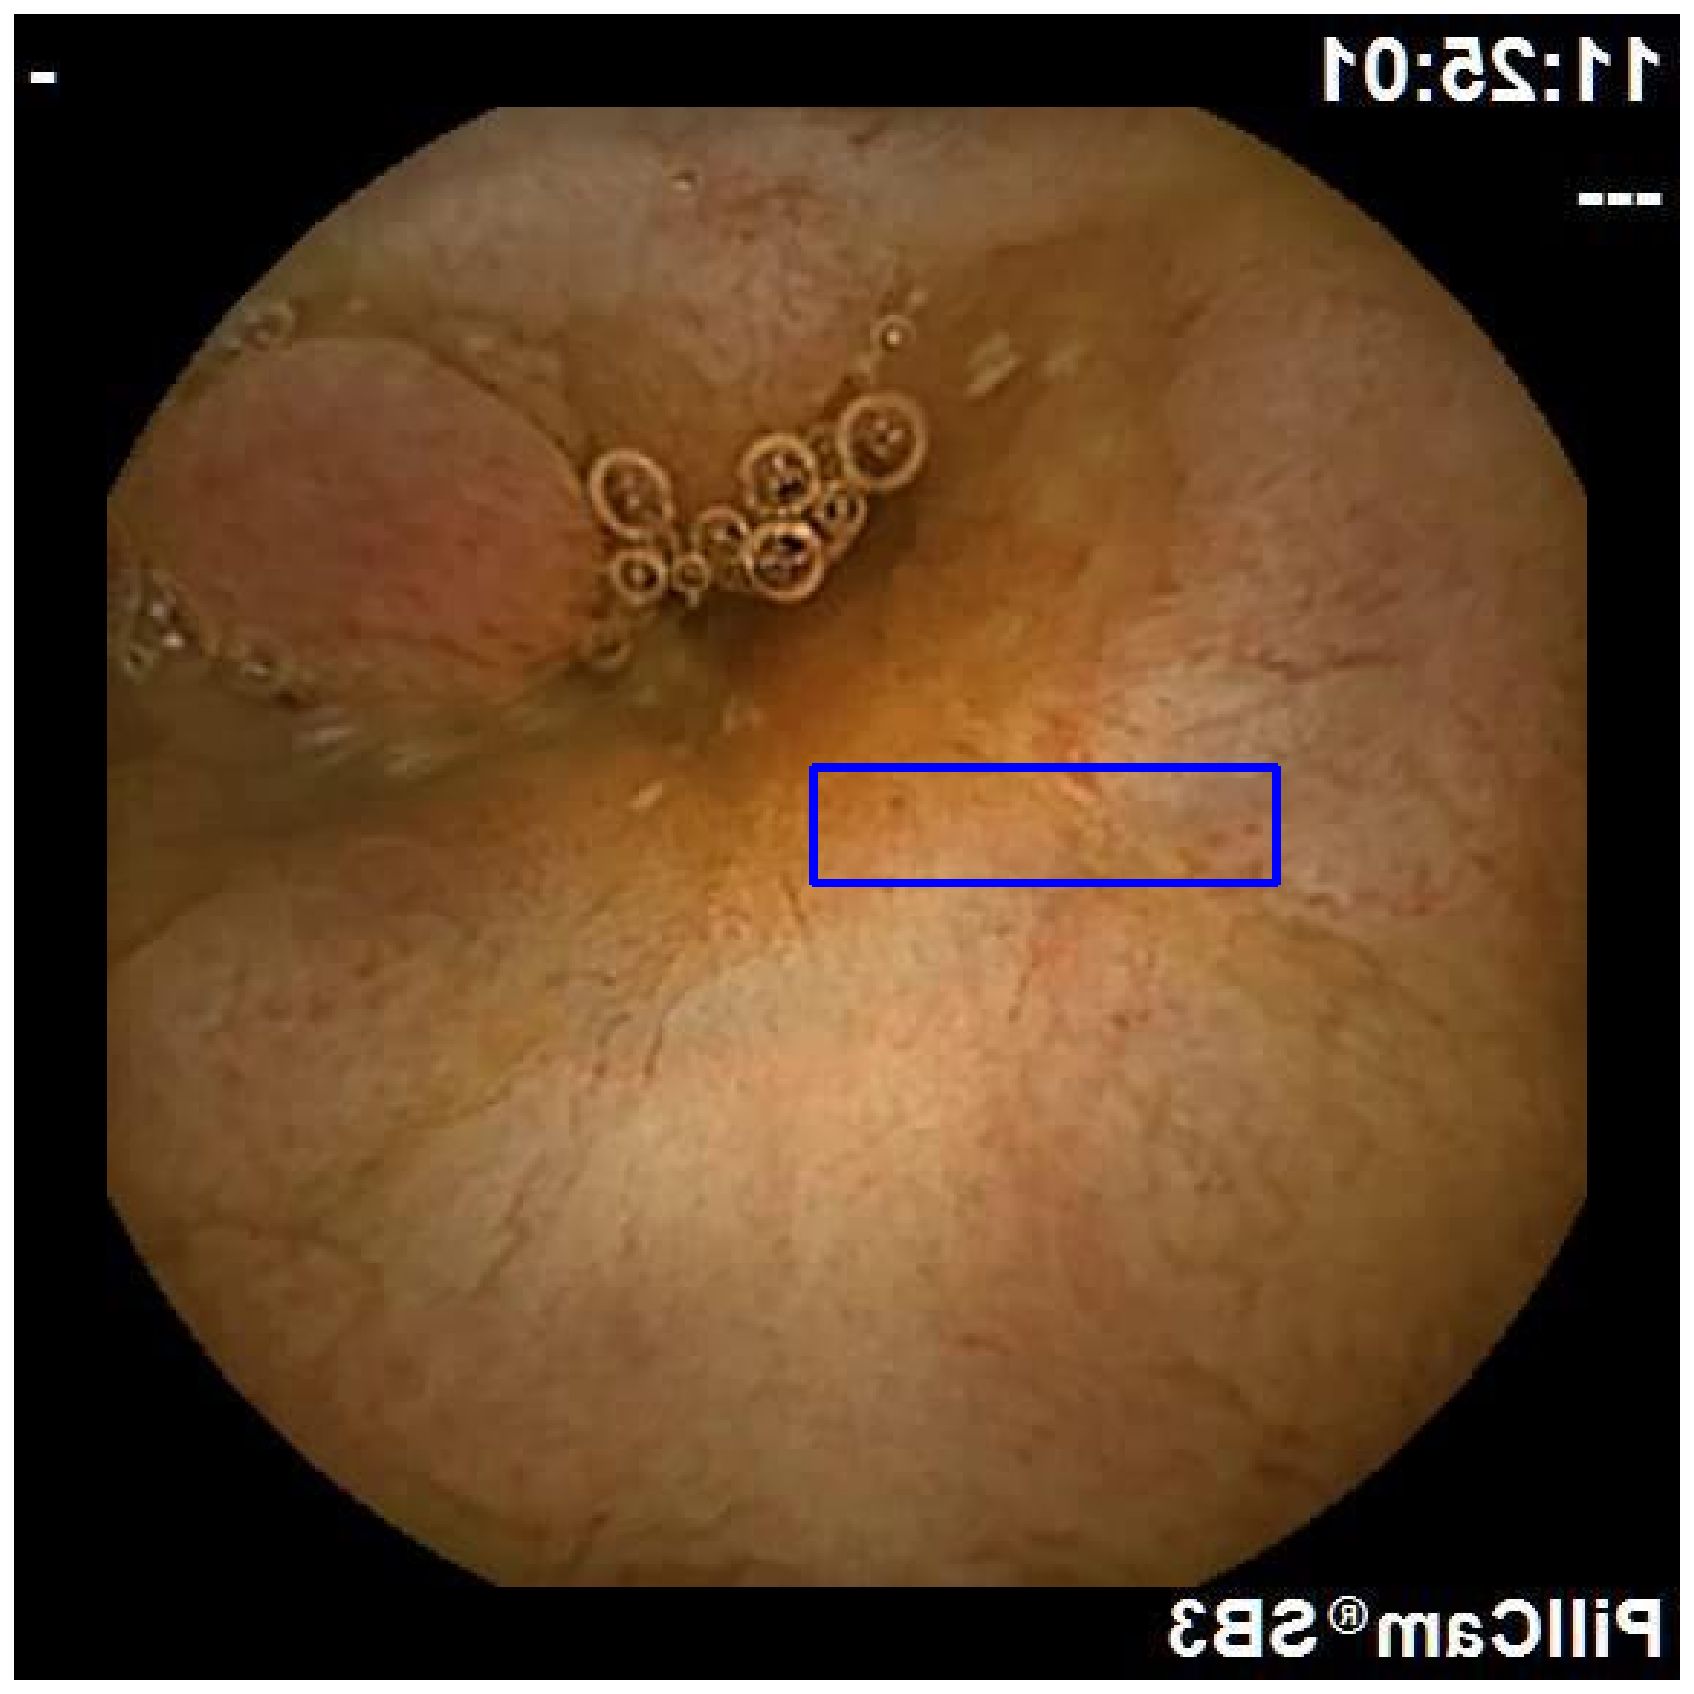

In [ ]:
# Flip
aug = A.Compose([
    A.Flip(always_apply=True)
], bbox_params=bbox_params)

# 증강 보여주기
show_augmented(aug, form, BBOX)

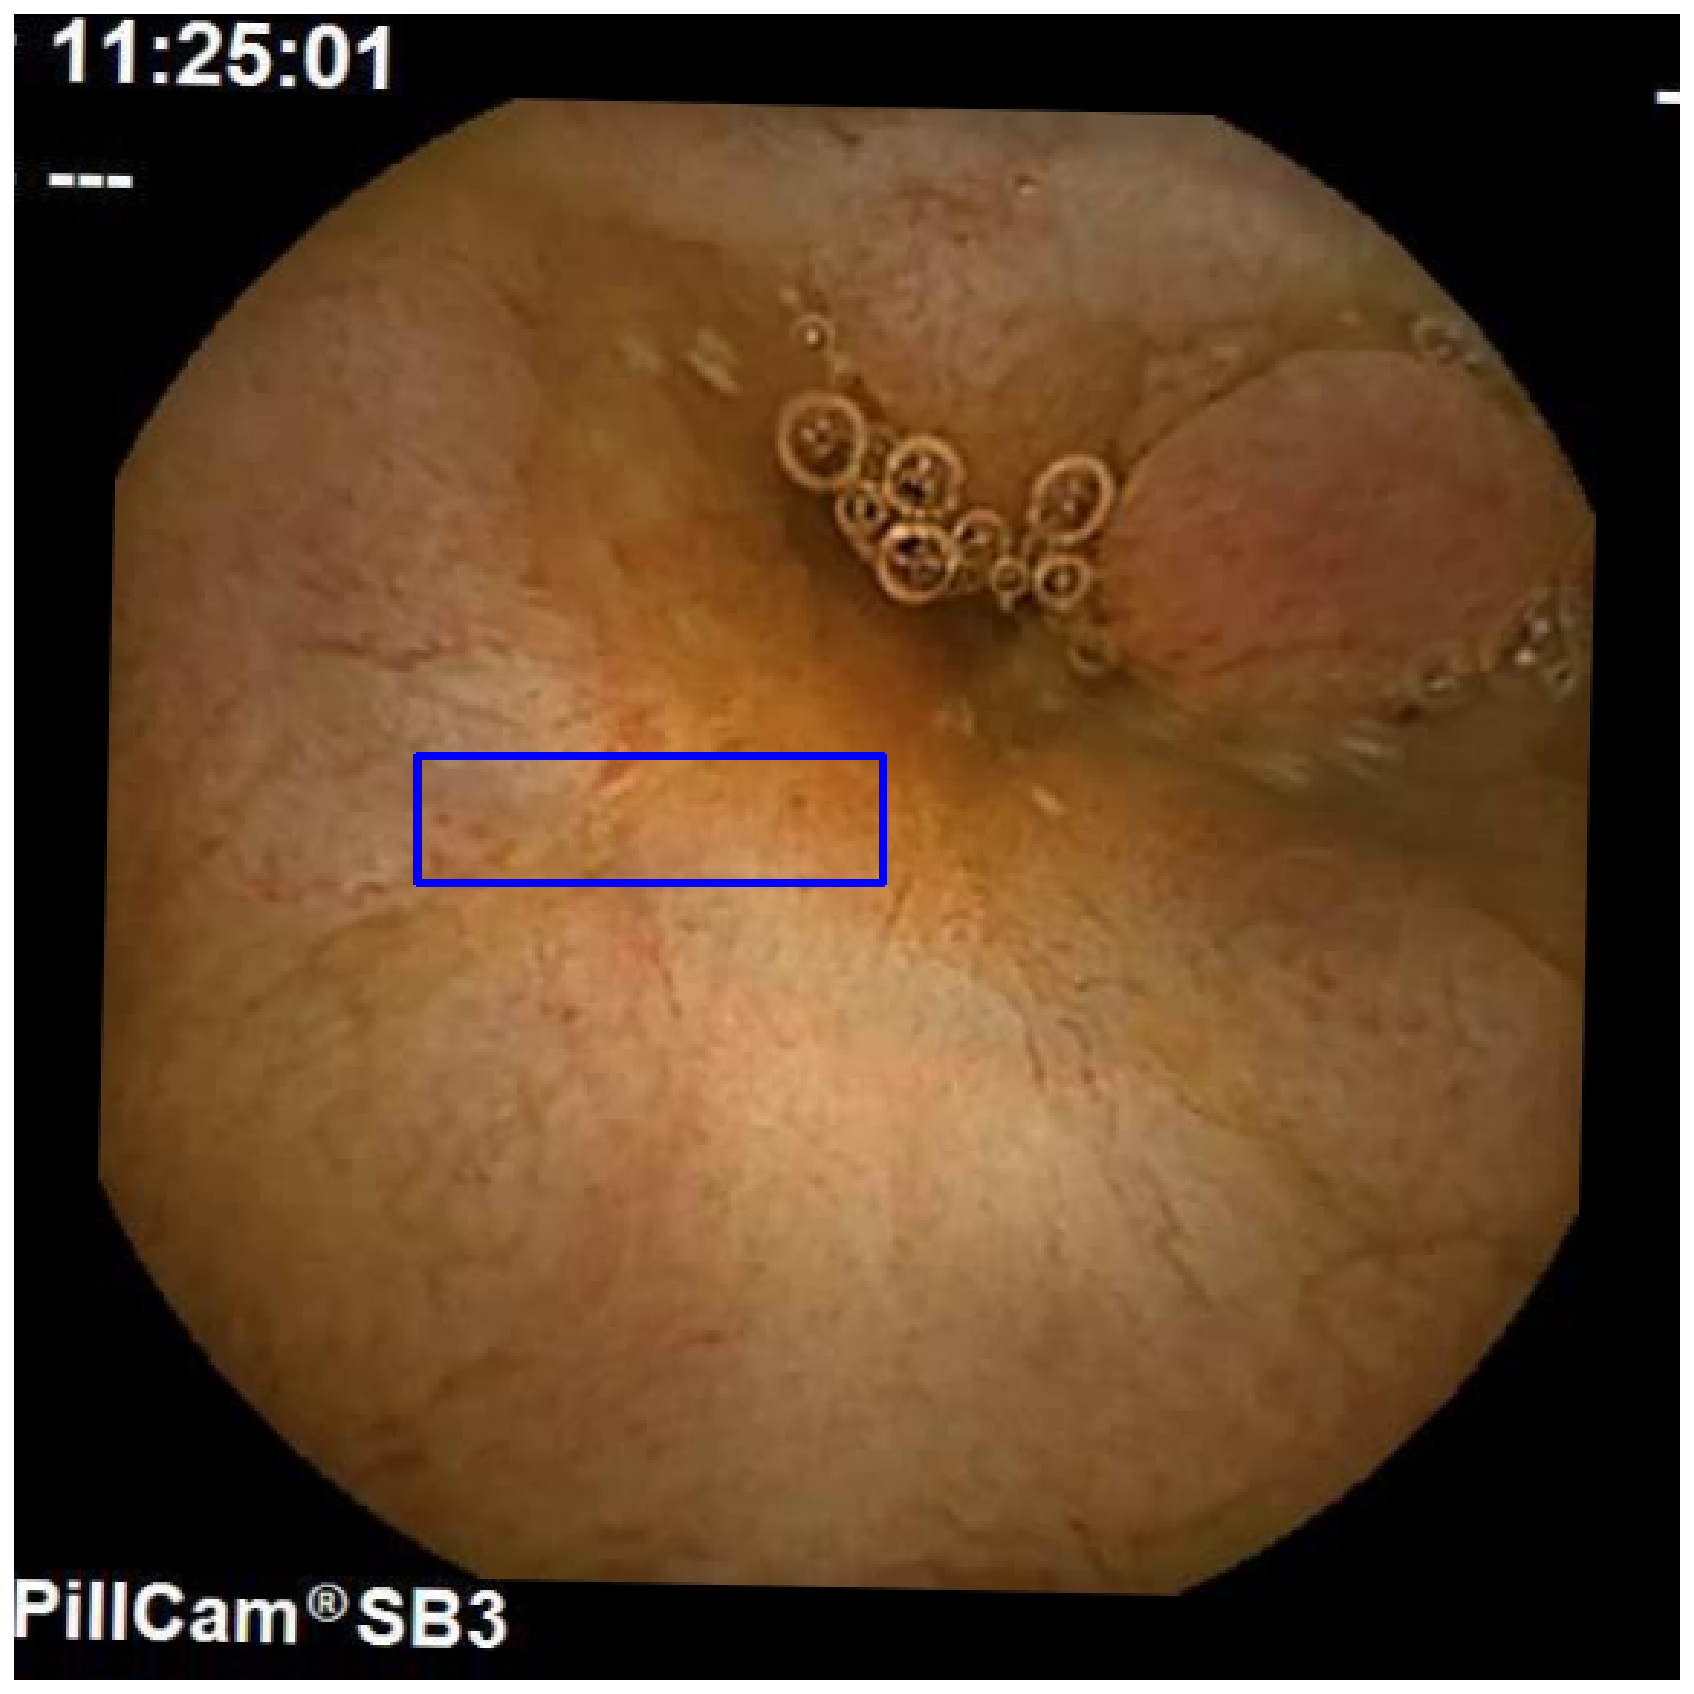

In [ ]:
# Rotate
aug = A.Compose([
  A.Rotate(limit=80, always_apply=True)
], bbox_params=bbox_params)

# 증강 함수
show_augmented(aug, form, BBOX)

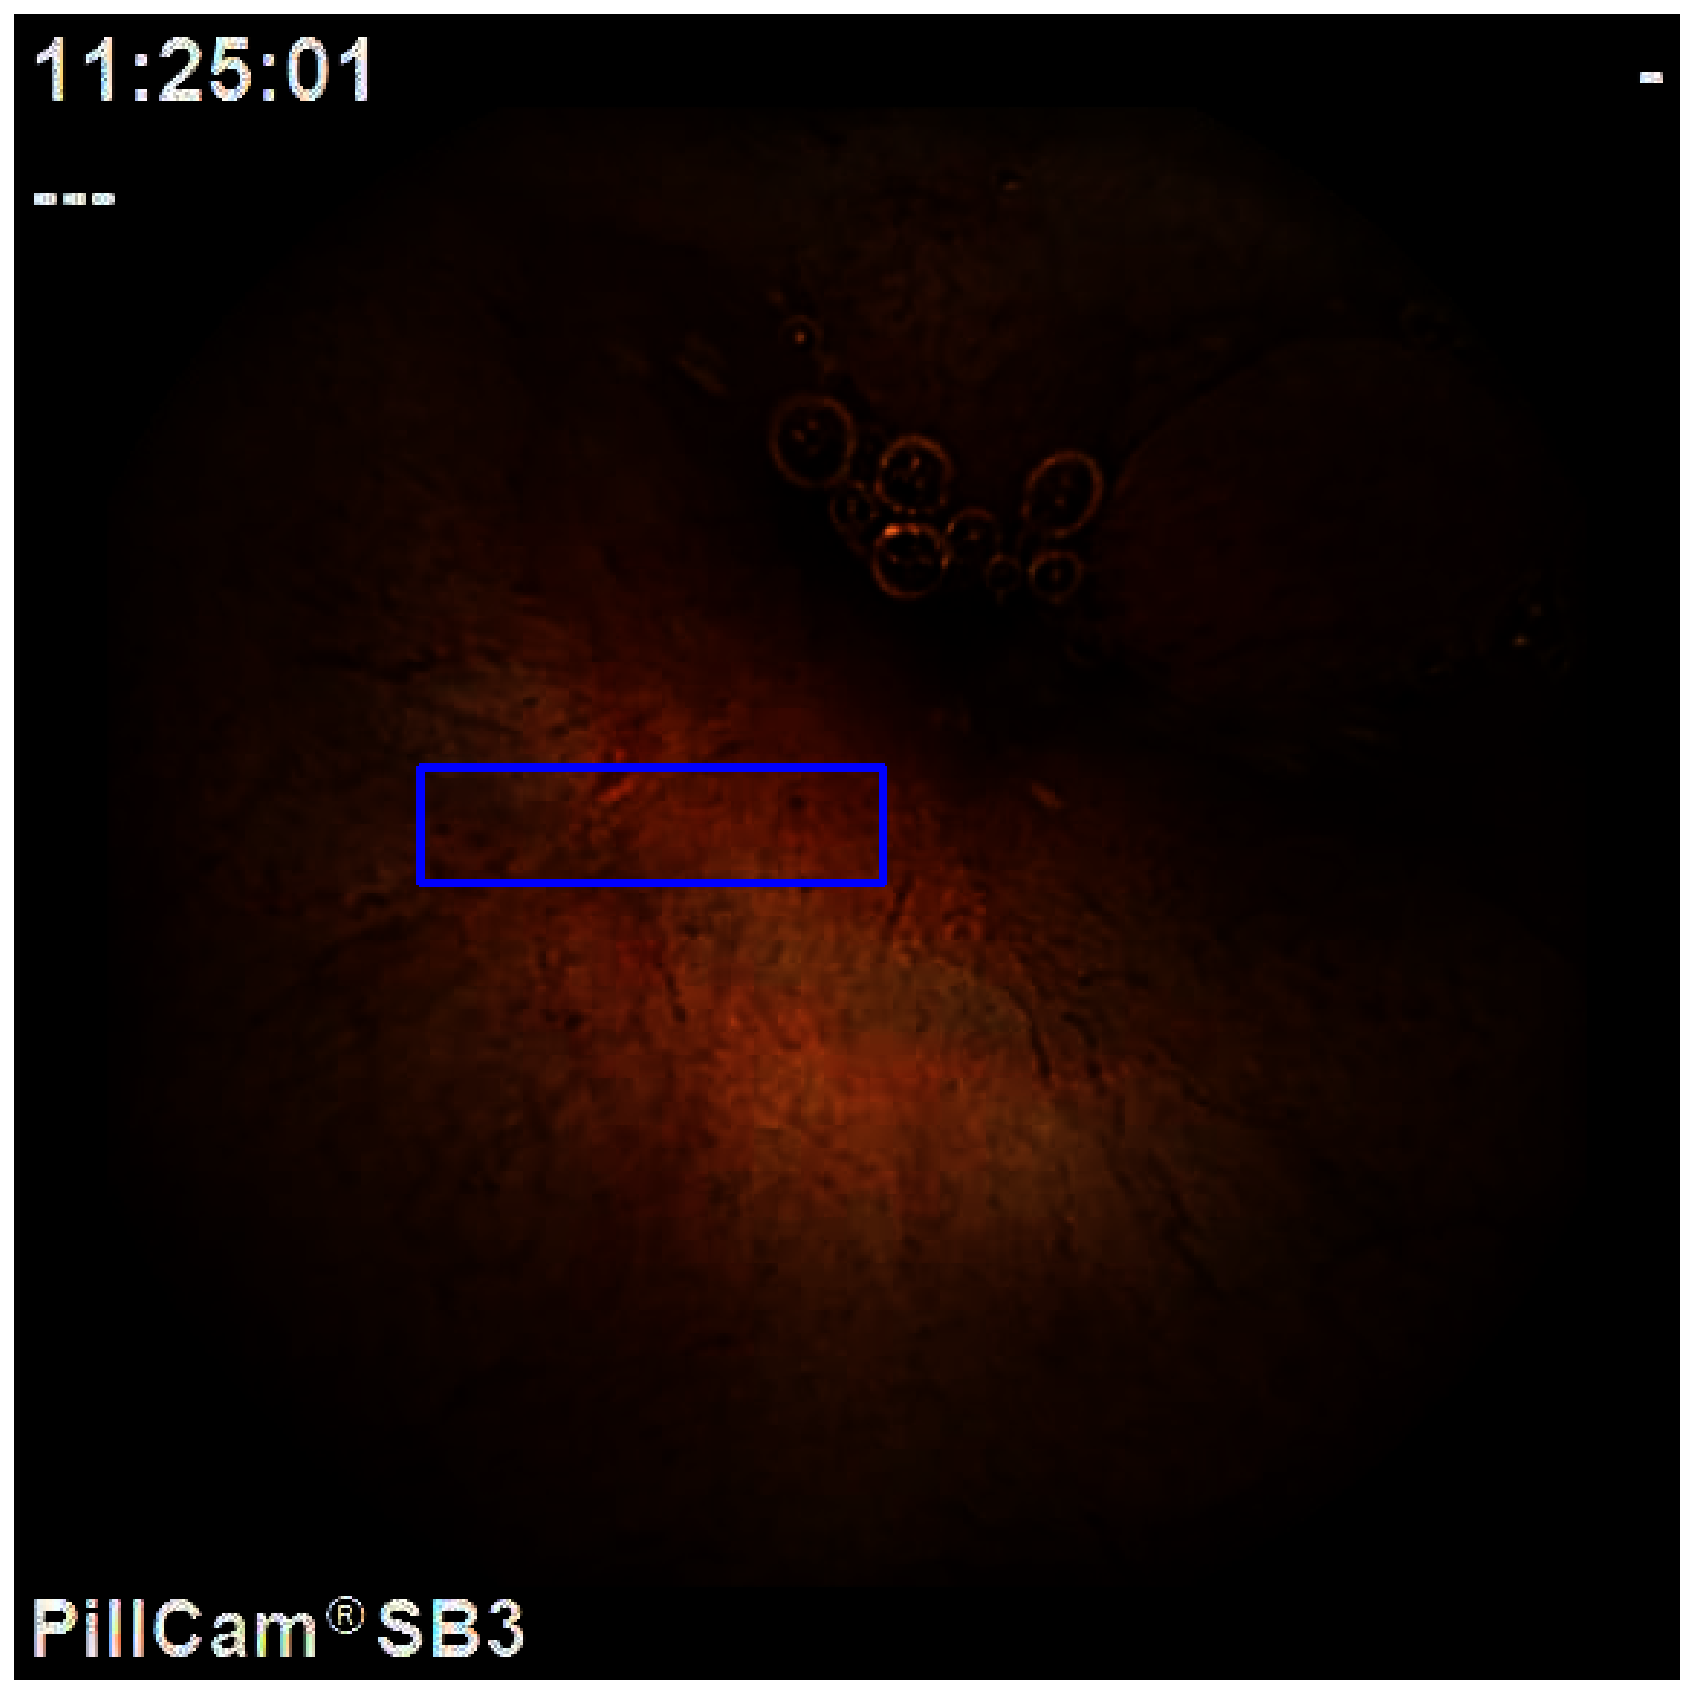

In [ ]:
# RandomGamma
aug = A.Compose([
    A.RandomGamma(gamma_limit=(400, 500), always_apply=True)
], bbox_params=bbox_params)

# 증강 함수
show_augmented(aug, form, BBOX)

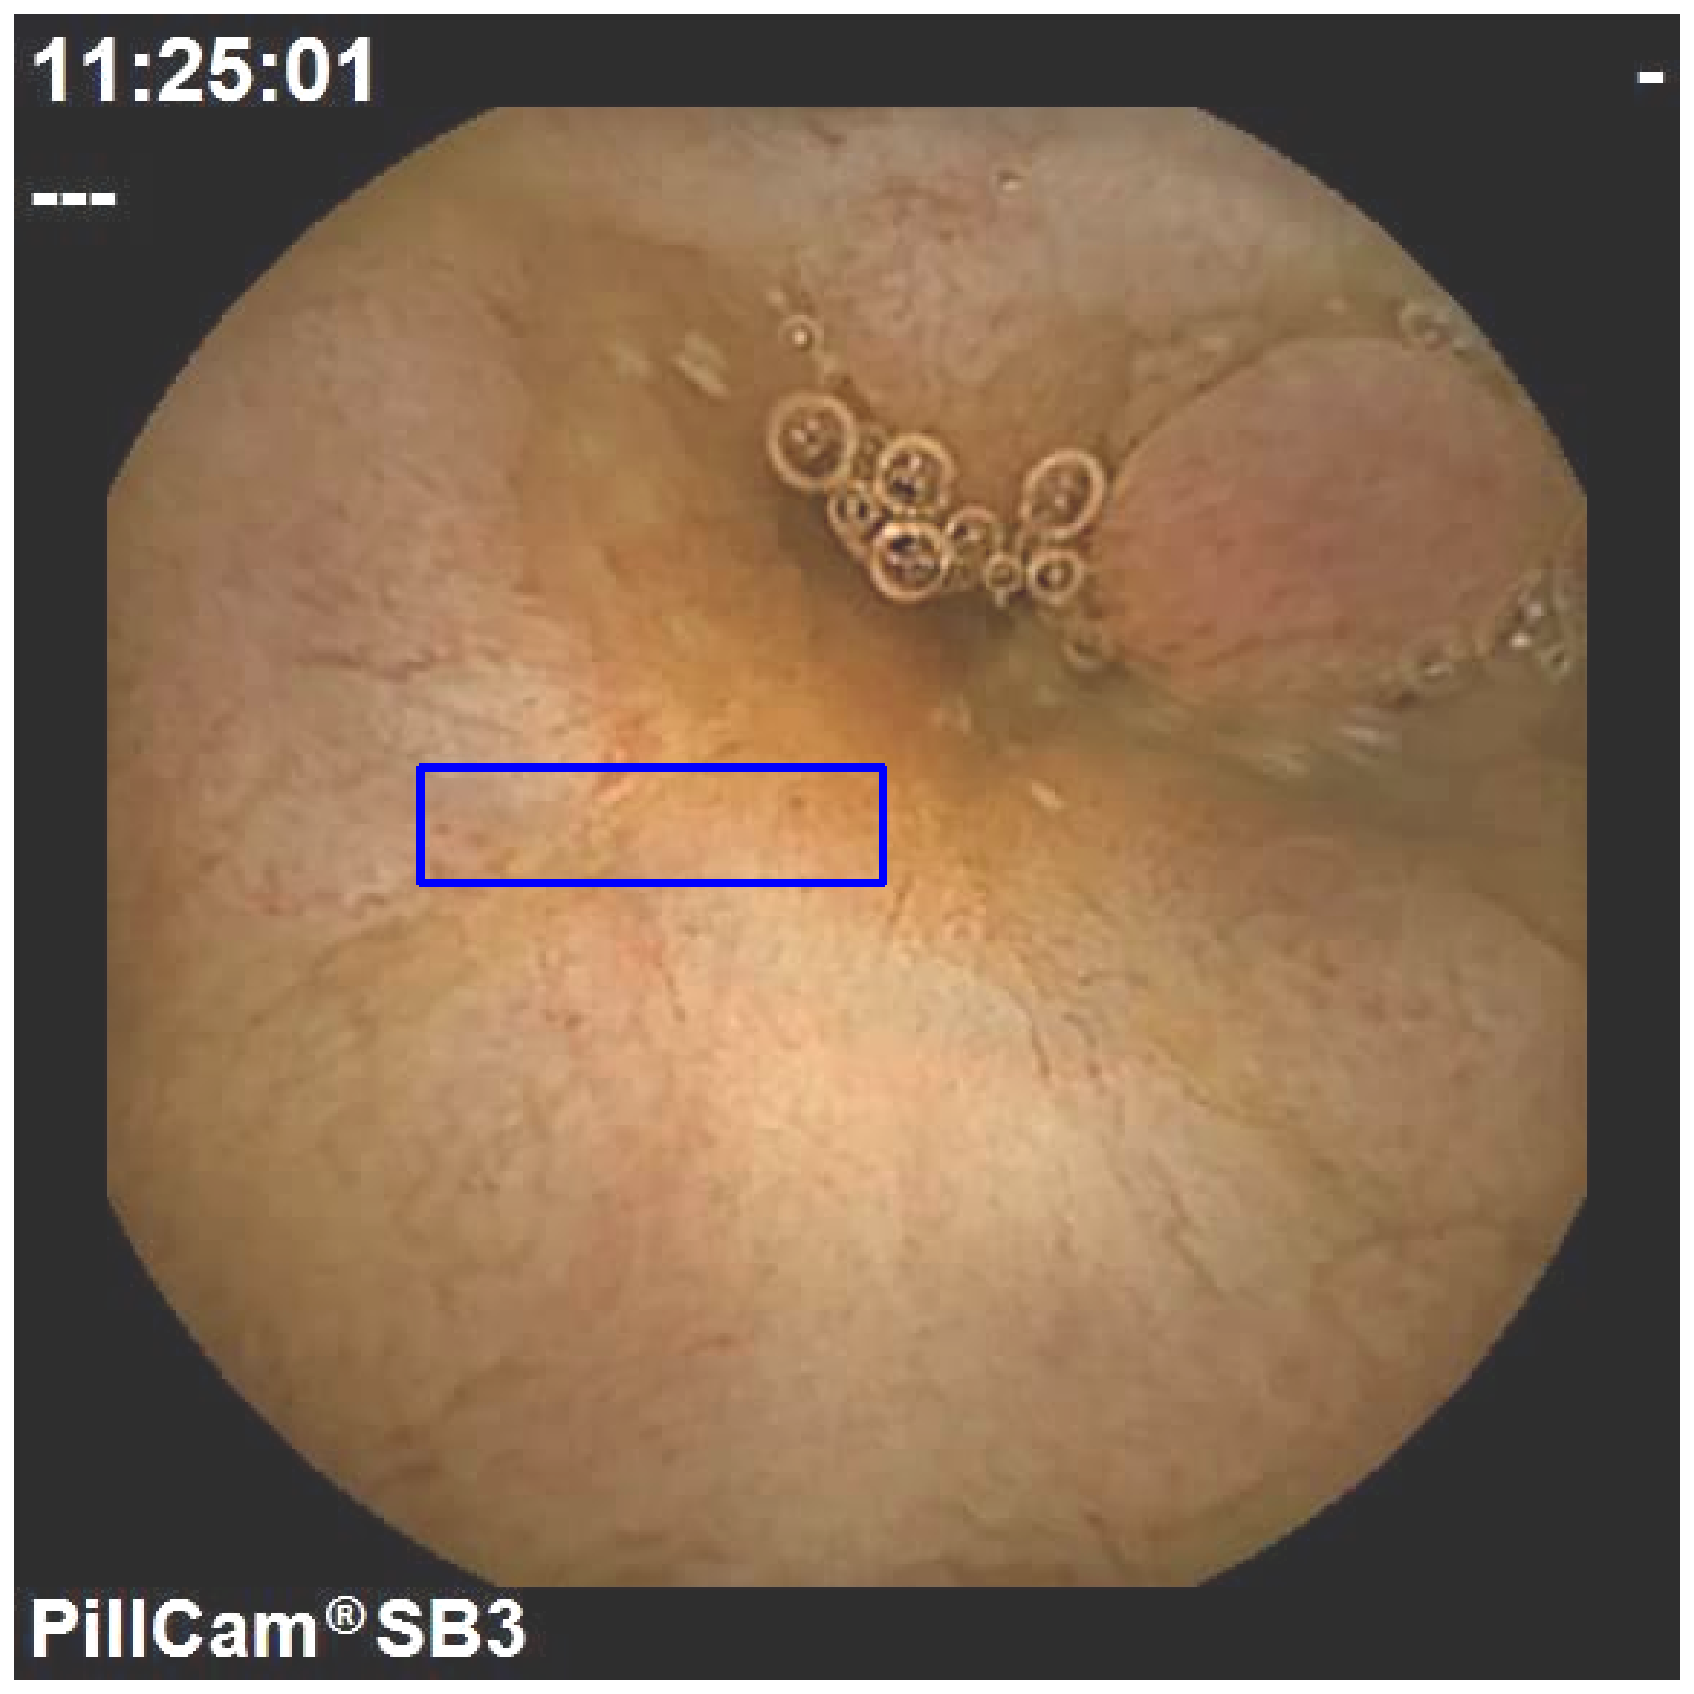

In [ ]:
# RandomBrightnessContrast
aug = A.Compose([
    A.RandomBrightnessContrast(always_apply=True),
], bbox_params=bbox_params)

# 증강 함수
show_augmented(aug, form, BBOX)

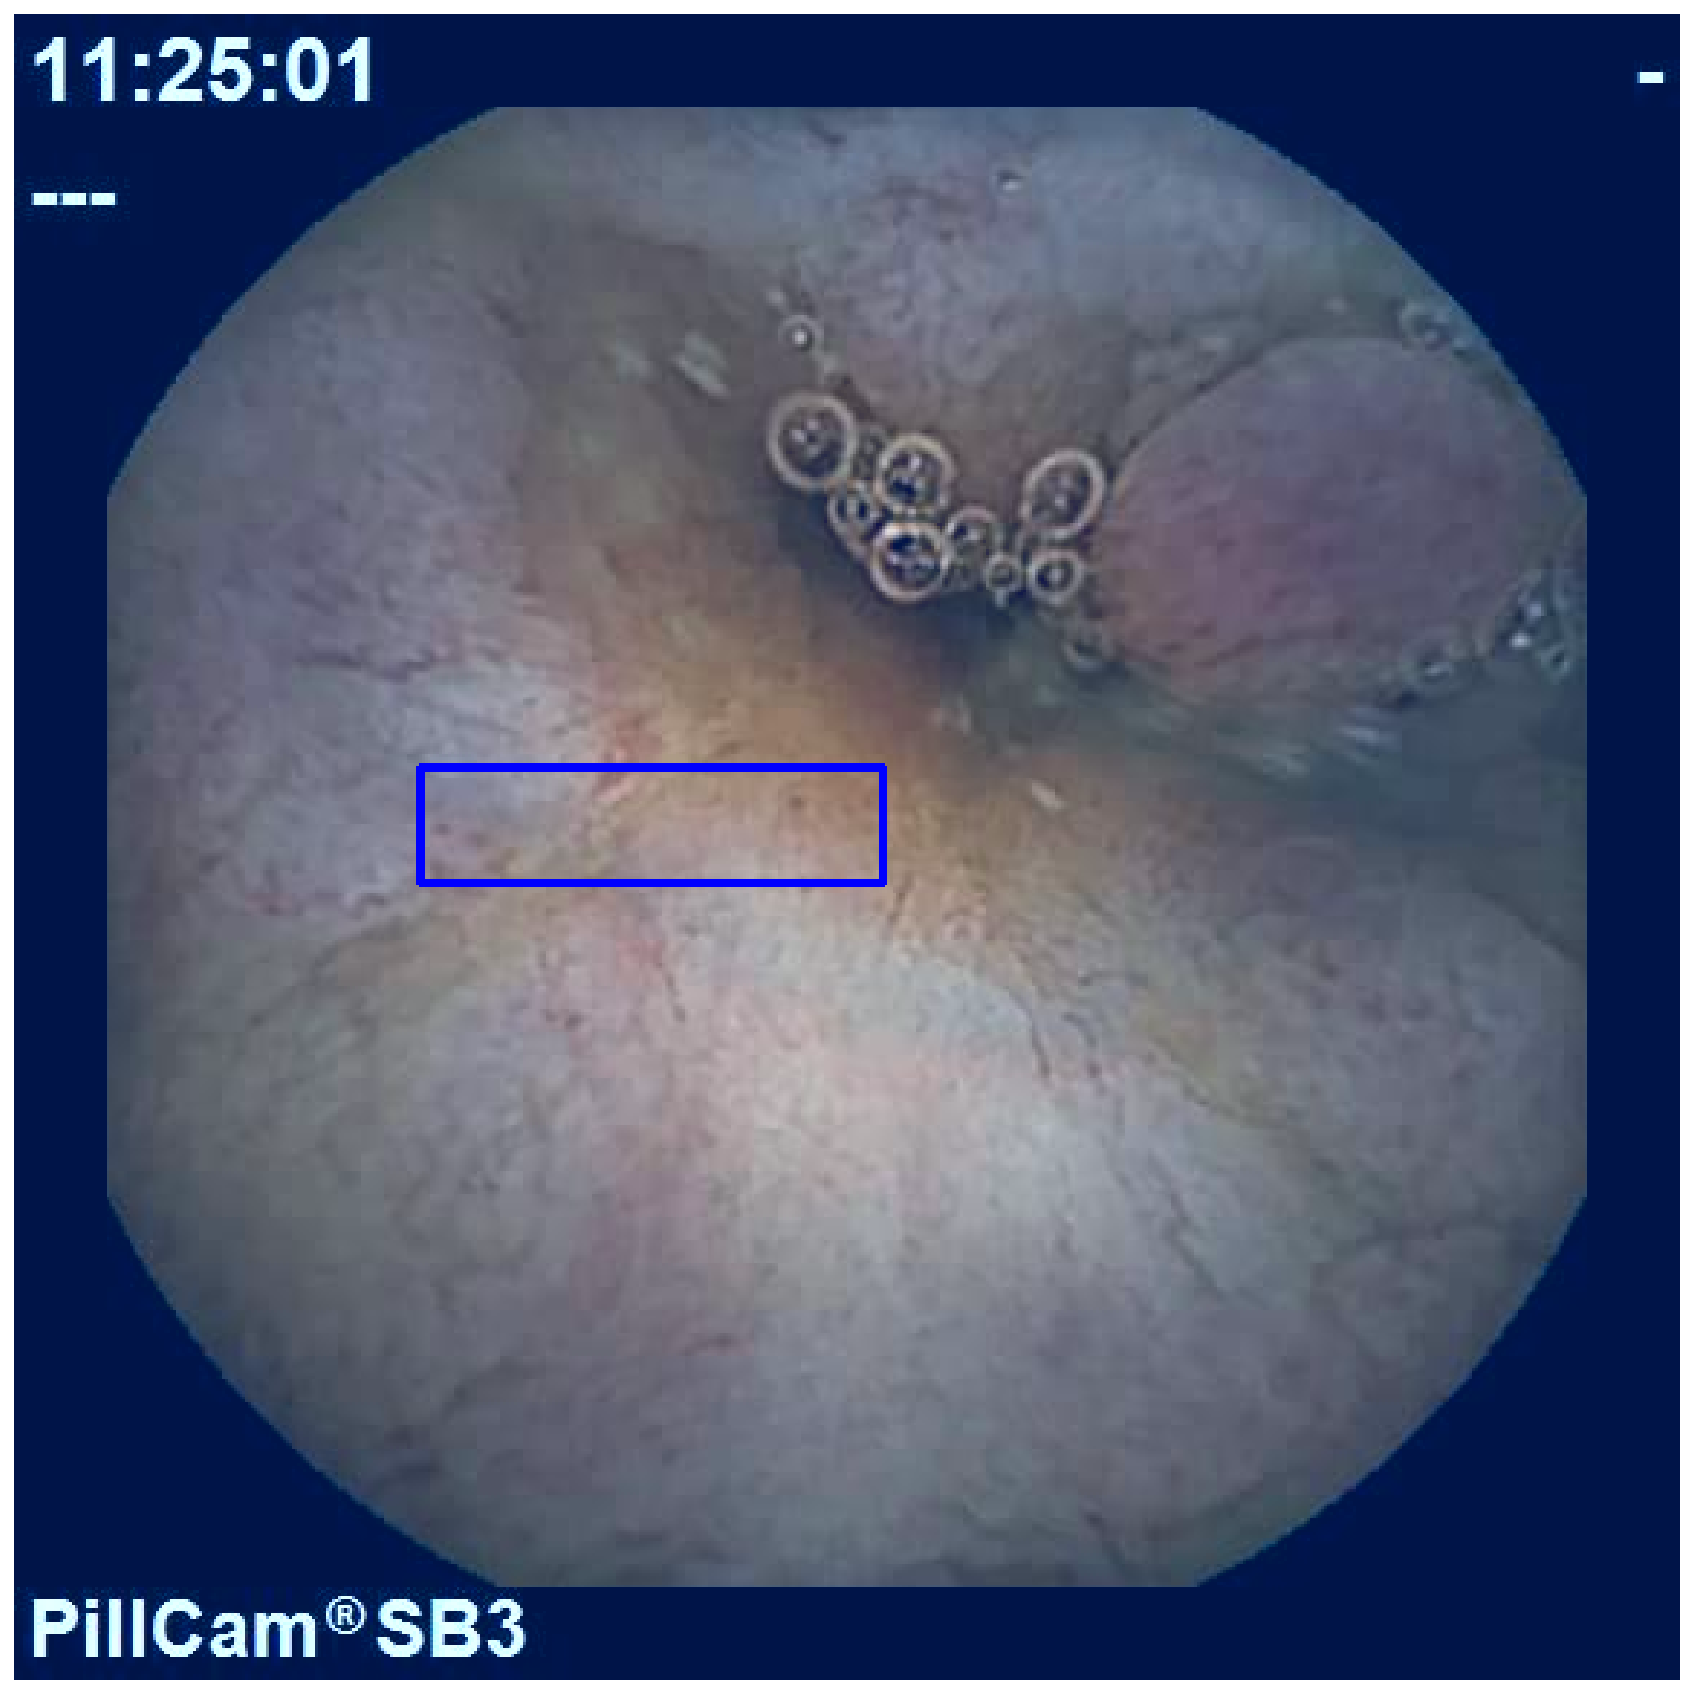

In [ ]:
# RGBShift
aug = A.Compose([
    A.RGBShift(
      always_apply=True, 
      r_shift_limit=100, 
      g_shift_limit=100,
      b_shift_limit=100
    ),
], bbox_params=bbox_params)

# 증강 함수
show_augmented(aug, form, BBOX)

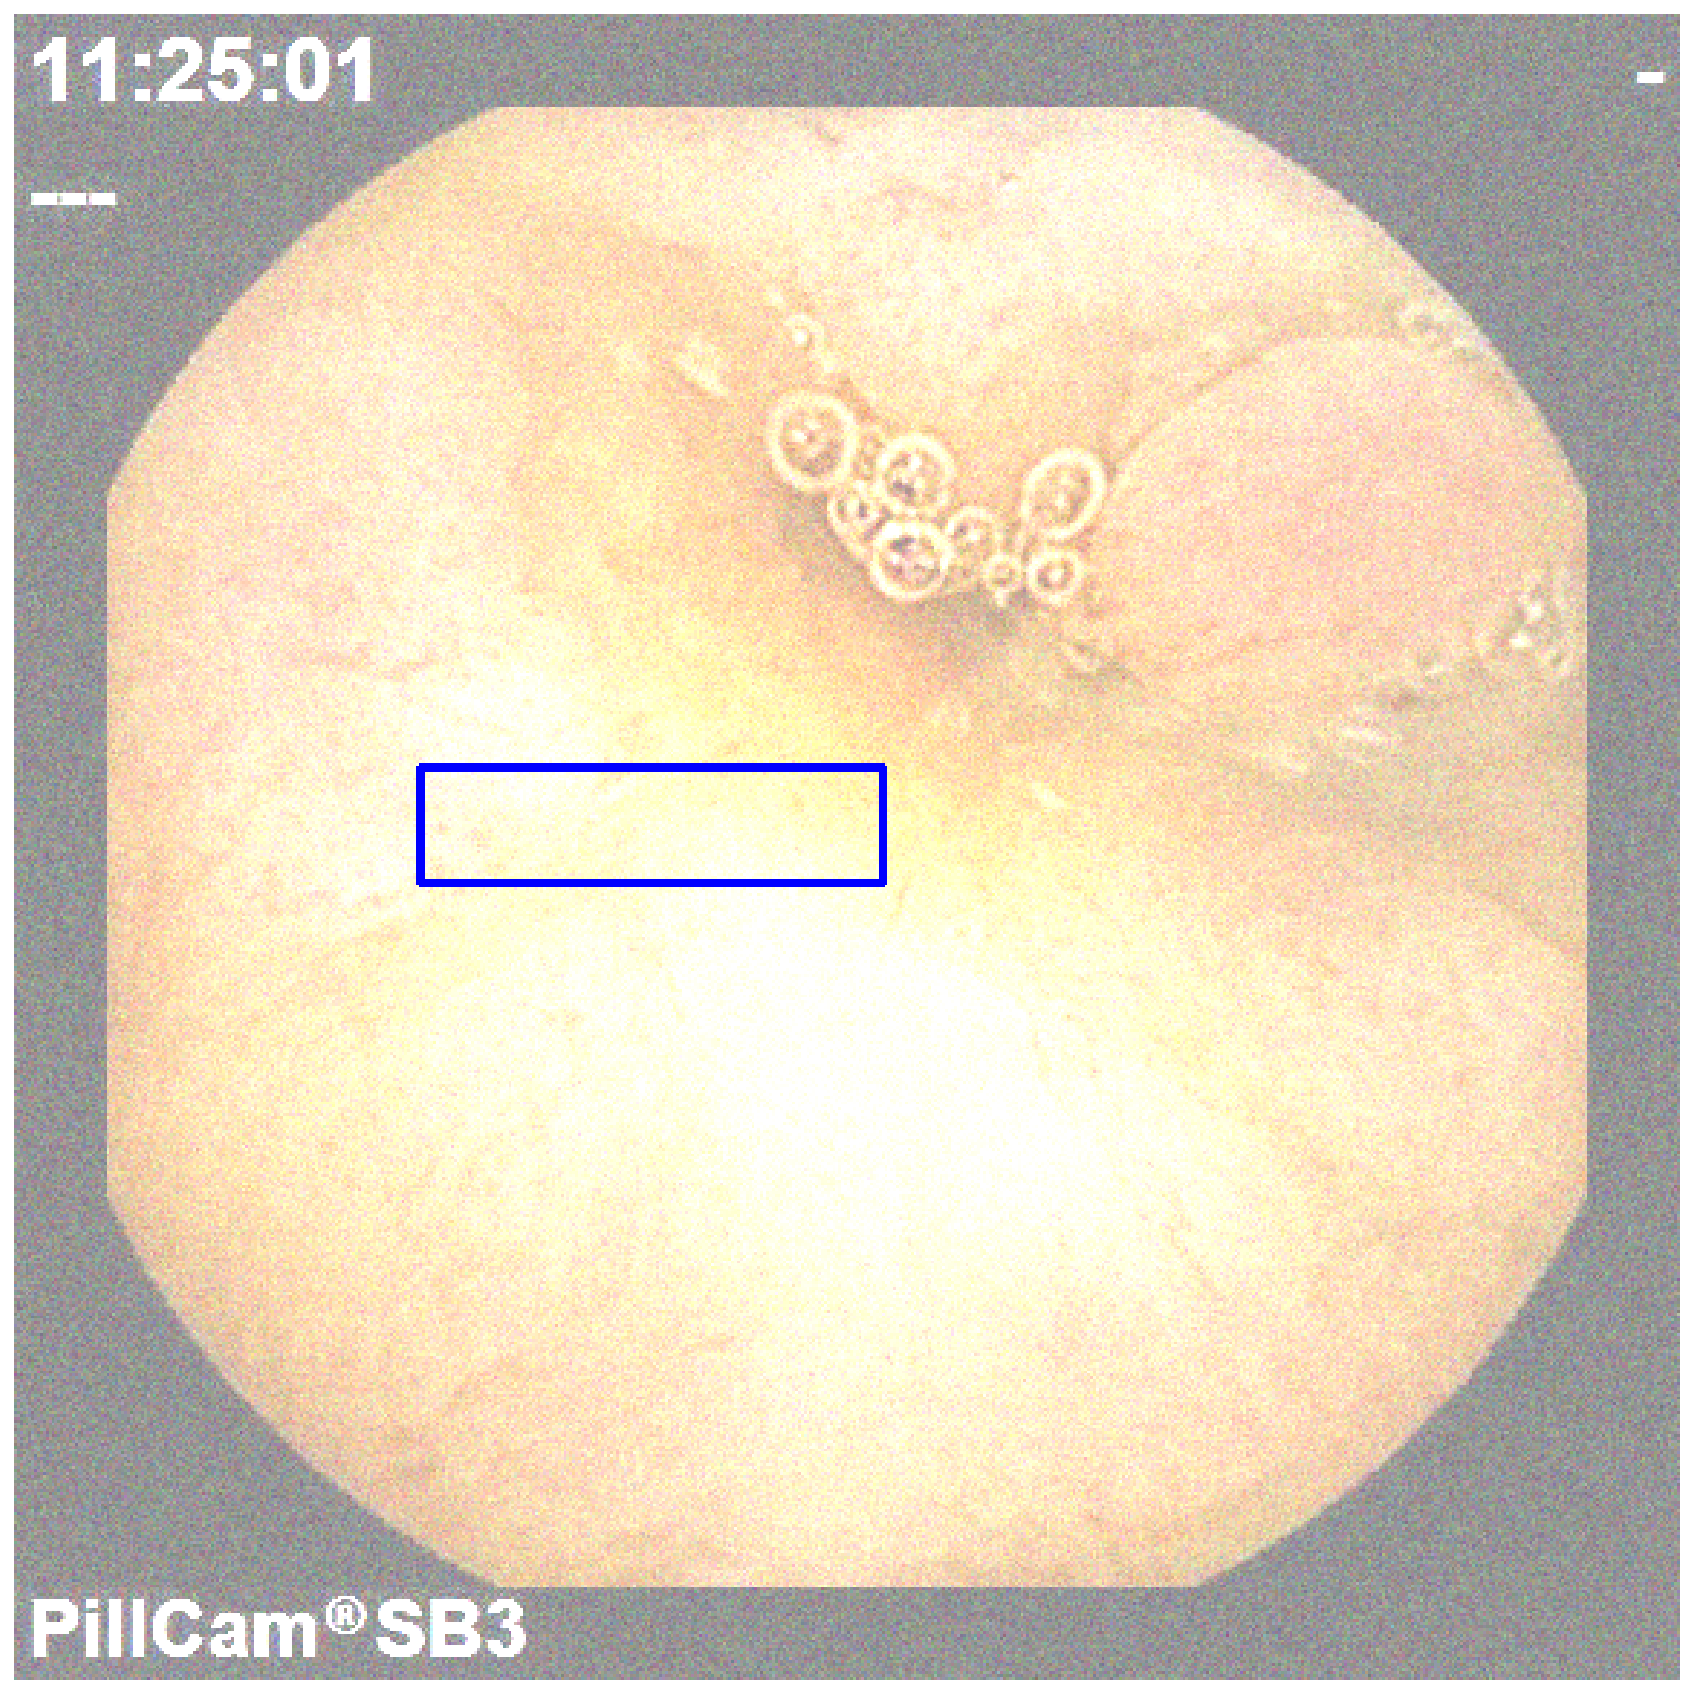

In [ ]:
# GaussNoise
aug = A.Compose([
    A.GaussNoise(
      always_apply=True,
      var_limit=(100, 300),
      mean=150
    ),
], bbox_params=bbox_params)

# 증강 함수
show_augmented(aug, form, BBOX)

# Augmenting Scanned Documents

In [ ]:
# 증강요소
doc_aug = A.Compose([
    A.Flip(p=0.25),
    #A.RandomGamma(gamma_limit=(20, 300), p=0.5),
    #A.RandomBrightnessContrast(p=0.85),
    #A.Rotate(limit=35, p=0.9),
    #A.RandomRotate90(p=0.25),
    #A.RGBShift(p=0.75),
    #A.GaussNoise(p=0.25)
], bbox_params=bbox_params)

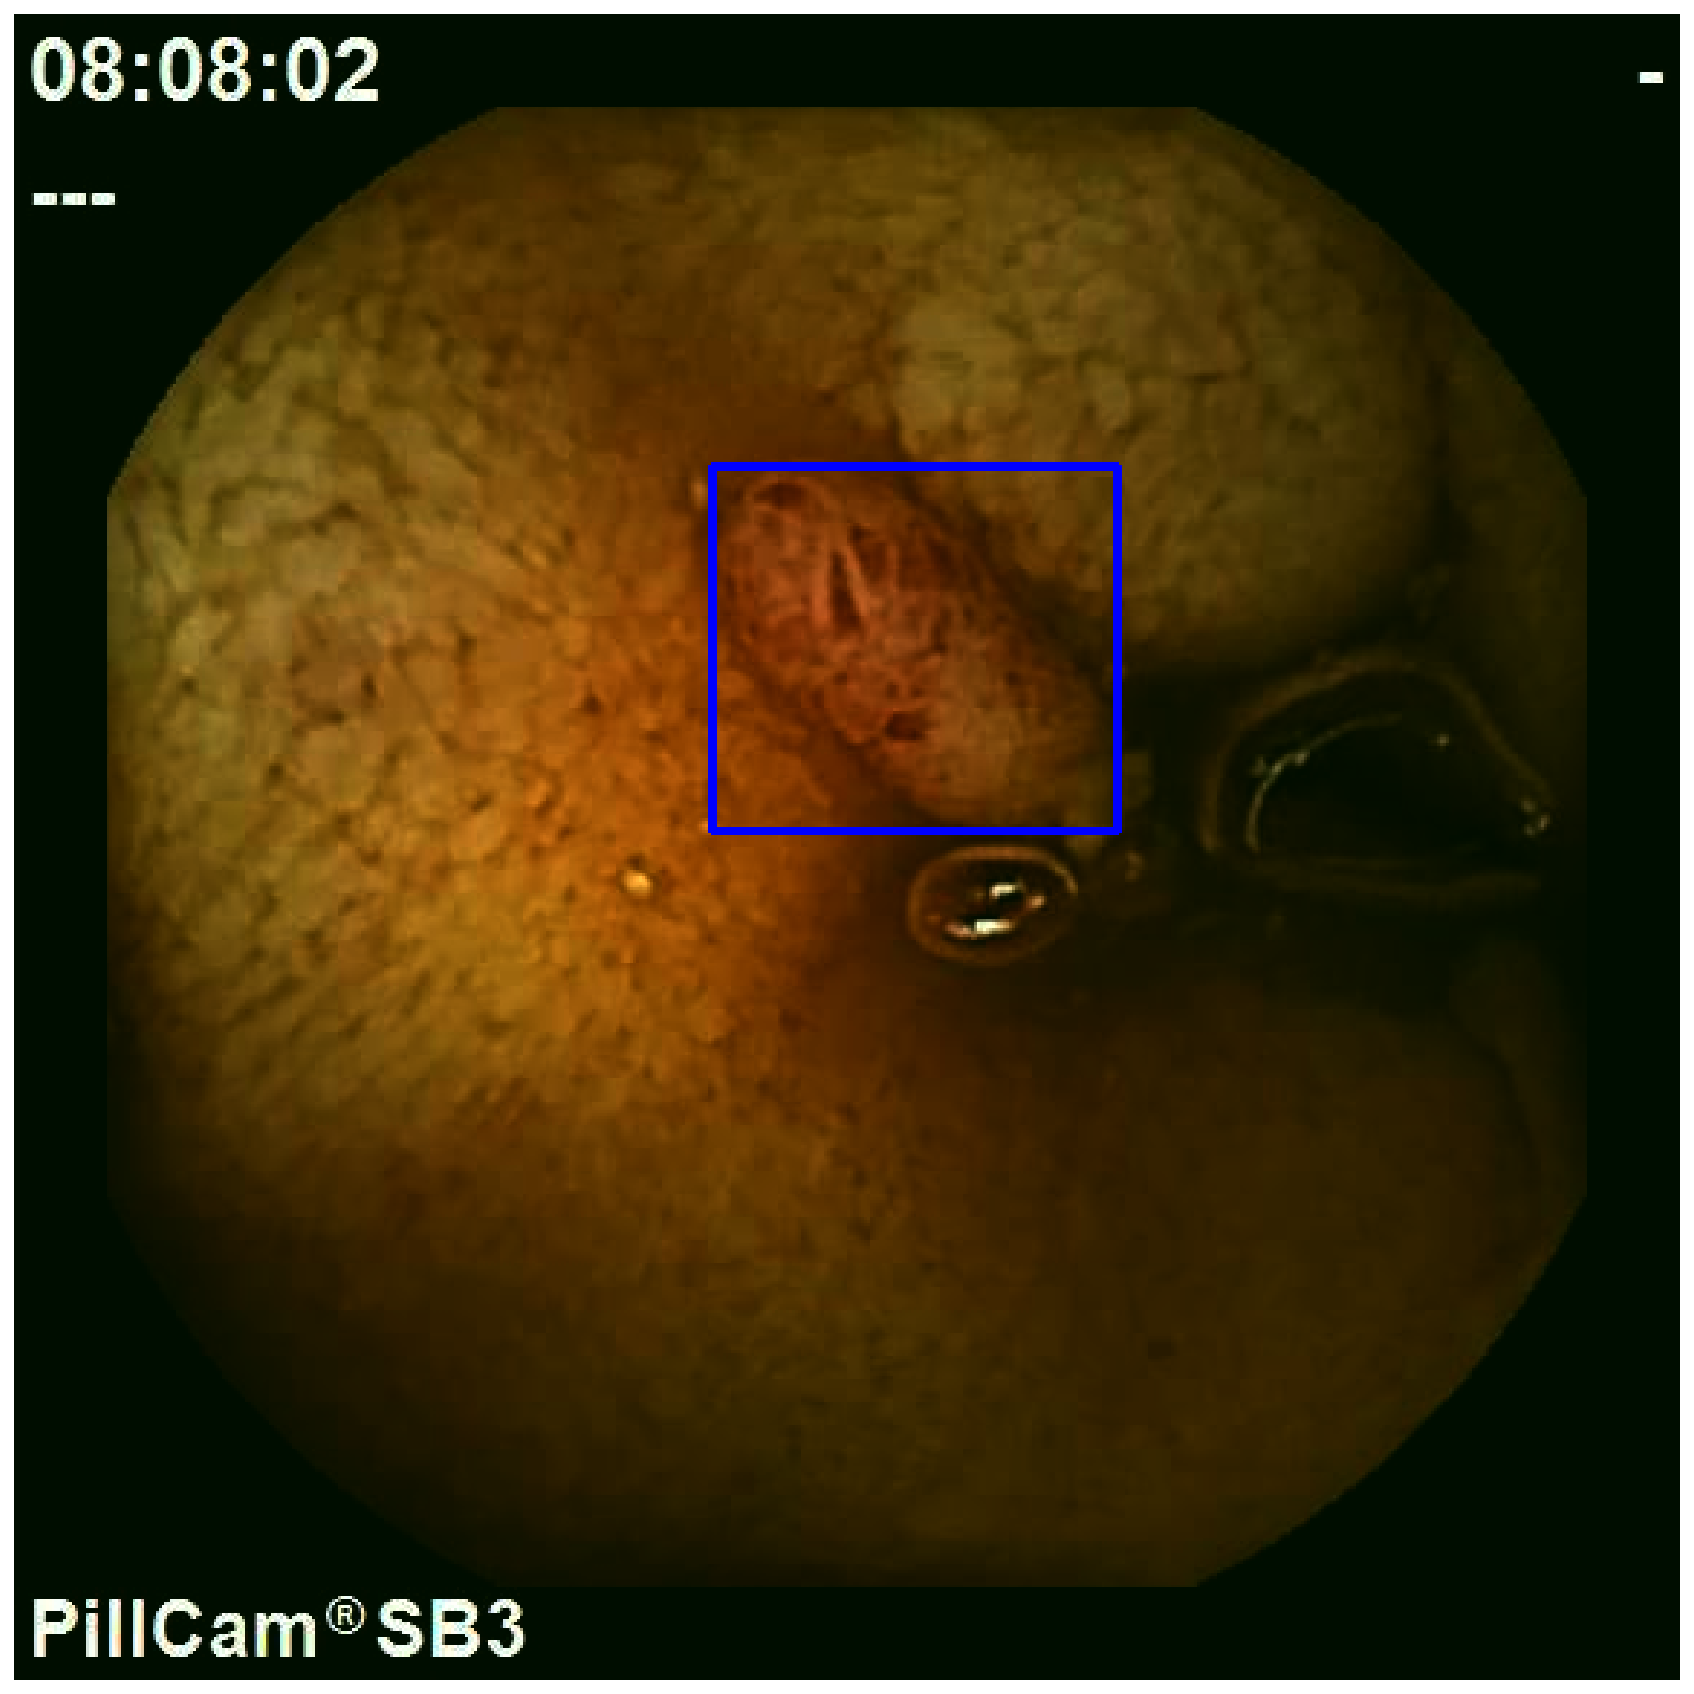

In [ ]:
# 증강 함수
show_augmented(doc_aug, form, BBox)


# Creating Augmented Dataset

Using the format:

`path/to/image.jpg,x1,y1,x2,y2,class_name`

In [ ]:
mass_df

image_id class_name  class_id     x_min     y_min     x_max     y_max  \
3       100004    02_mass         2  241.6879  156.1254  381.2563  282.0247   
14      100015    02_mass         2  458.6715  305.1873  537.9222  416.7147   
16      100017    02_mass         2  442.7778  340.8889  509.4444  416.0000   
17      100017    02_mass         2  283.2222  310.2222  336.5556  354.2222   
18      100018    02_mass         2  232.6032  324.5323  425.9807  505.9892   
...        ...        ...       ...       ...       ...       ...       ...   
5725    104980    02_mass         2  160.0000  179.1837  318.7347  319.0000   
5728    104982    02_mass         2  145.3235   31.7941  270.3235  216.3529   
5733    104986    02_mass         2  304.6083   31.9263  541.9355  458.1935   
5735    104988    02_mass         2  257.2016  336.8601  396.7078  510.5226   
5758    105003    02_mass         2  266.0672  311.5714  315.6471  353.5882   

      width  height         file_name           area  
3       576     576  train_100004.jpg   17571.563862  
14      576     576  train_100015.jpg    8838.624519  
16      576     576  train_100017.jpg    5007.401659  
17      576     576  train_100017.jpg    2346.669600  
18      576     576  train_100018.jpg   35089.681680  
...     ...     ...               ...            ...  
5725    320     320  train_104980.jpg   22193.698436  
5728    576     576  train_104982.jpg   23069.850000  
5733    576     576  train_104986.jpg  101164.801028  
5735    576     576  train_104988.jpg   24226.995458  
5758    576     576  train_105003.jpg    2083.188742  

[700 rows x 11 columns]

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/augumentation'
IMAGES_PATH = f'{DATASET_PATH}/mass'

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []

for j,k in tqdm(enumerate(mass_df.iloc)):
  if j == 300: break
  mass_file_name=k['file_name']
  mass_image_id=k['image_id']
  mass_bbox=[]
  mass_bbox.append(float(k['x_min']))
  mass_bbox.append(float(k['y_min']))
  mass_bbox.append(float(k['x_max']))
  mass_bbox.append(float(k['y_max']))
  print(mass_file_name,mass_bbox)

  DIR_TRAIN = '/content/drive/MyDrive/Lesion_detection/data_coco/train/'
  print(DIR_TRAIN+mass_file_name)
  mass_form = cv2.imread(DIR_TRAIN+mass_file_name)

  N=1
  for i in tqdm(range(N)):
    augmented = doc_aug(image=mass_form, bboxes=[mass_bbox], field_id=['2'])
    file_name = f'train_{mass_image_id}_2{j}{i}.jpg'
    
    for bbox in augmented['bboxes']:
      x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
      rows.append({
        'file_name': file_name,
        'x_min': x_min,
        'y_min': y_min,
        'x_max': x_max,
        'y_max': y_max,
        'class_name': '02_mass'
      })
    cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

rows_df=pd.DataFrame(rows)
rows_df.to_csv(f'{DATASET_PATH}/mass_annotations.csv', header=True, index=None)

0it [00:00, ?it/s]

train_100004.jpg [241.6879, 156.1254, 381.2563, 282.0247]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100004.jpg



100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


train_100015.jpg [458.6715, 305.1873, 537.9222, 416.7147]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100015.jpg



100%|██████████| 1/1 [00:00<00:00, 15.61it/s]
2it [00:00, 12.21it/s]

train_100017.jpg [442.7778, 340.8889, 509.4444, 416.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100017.jpg



100%|██████████| 1/1 [00:00<00:00, 60.87it/s]


train_100017.jpg [283.2222, 310.2222, 336.5556, 354.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100017.jpg



100%|██████████| 1/1 [00:00<00:00, 14.61it/s]
4it [00:00, 14.94it/s]

train_100018.jpg [232.6032, 324.5323, 425.9807, 505.9892]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100018.jpg



100%|██████████| 1/1 [00:00<00:00, 46.09it/s]


train_100023.jpg [69.339, 235.0847, 159.1695, 329.1525]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100023.jpg



100%|██████████| 1/1 [00:00<00:00, 61.01it/s]


train_100035.jpg [308.7391, 30.8696, 544.3913, 333.0435]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100035.jpg



100%|██████████| 1/1 [00:00<00:00, 60.34it/s]
7it [00:00, 20.22it/s]

train_100036.jpg [31.7273, 92.4848, 108.0909, 265.2121]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100036.jpg



100%|██████████| 1/1 [00:00<00:00, 57.54it/s]


train_100041.jpg [83.0087, 63.9351, 281.2771, 279.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100041.jpg



100%|██████████| 1/1 [00:00<00:00, 53.01it/s]


train_100042.jpg [303.2922, 157.9588, 481.4815, 292.1152]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100042.jpg



100%|██████████| 1/1 [00:00<00:00, 75.44it/s]


train_100044.jpg [285.0863, 325.1799, 353.4317, 412.2302]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100044.jpg



100%|██████████| 1/1 [00:00<00:00, 69.85it/s]
11it [00:00, 25.73it/s]

train_100044.jpg [215.2381, 444.7143, 303.8095, 504.2381]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100044.jpg



100%|██████████| 1/1 [00:00<00:00, 14.82it/s]


train_100048.jpg [246.6239, 488.2018, 332.8624, 543.2477]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100048.jpg



100%|██████████| 1/1 [00:00<00:00, 60.19it/s]


train_100051.jpg [119.4737, 0.8947, 272.1053, 85.1053]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100051.jpg



100%|██████████| 1/1 [00:00<00:00, 102.99it/s]
14it [00:00, 24.73it/s]

train_100055.jpg [266.0281, 34.882, 542.9512, 418.3985]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100055.jpg



100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


train_100057.jpg [155.044, 207.8791, 316.5824, 491.3956]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100057.jpg



100%|██████████| 1/1 [00:00<00:00, 54.31it/s]


train_100063.jpg [2.0673, 42.3077, 91.4904, 128.3654]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100063.jpg



100%|██████████| 1/1 [00:00<00:00, 128.60it/s]
17it [00:00, 24.01it/s]

train_100066.jpg [162.1834, 392.8994, 381.1183, 543.787]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100066.jpg



100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


train_100069.jpg [163.2857, 34.127, 467.254, 163.0952]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100069.jpg



100%|██████████| 1/1 [00:00<00:00, 56.82it/s]


train_100069.jpg [346.619, 207.5397, 480.746, 342.4603]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100069.jpg



100%|██████████| 1/1 [00:00<00:00, 71.80it/s]
20it [00:00, 23.24it/s]

train_100084.jpg [234.1882, 98.5018, 318.69, 232.0812]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100084.jpg



100%|██████████| 1/1 [00:00<00:00, 83.94it/s]


train_100092.jpg [106.6271, 201.1864, 189.678, 287.6271]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100092.jpg



100%|██████████| 1/1 [00:00<00:00, 70.56it/s]

train_100093.jpg [322.6667, 203.3333, 498.6667, 410.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100093.jpg




100%|██████████| 1/1 [00:00<00:00, 81.41it/s]


train_100094.jpg [321.7839, 232.853, 424.3775, 341.4986]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100094.jpg



100%|██████████| 1/1 [00:00<00:00, 61.86it/s]
24it [00:01, 26.45it/s]

train_100102.jpg [85.7212, 163.2212, 134.0385, 205.5288]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100102.jpg



100%|██████████| 1/1 [00:00<00:00, 96.60it/s]


train_100111.jpg [327.5714, 135.3516, 539.6593, 363.9231]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100111.jpg



100%|██████████| 1/1 [00:00<00:00, 72.07it/s]


train_100112.jpg [308.6667, 139.3333, 445.3333, 297.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100112.jpg



100%|██████████| 1/1 [00:00<00:00, 14.27it/s]
27it [00:01, 25.29it/s]

train_100120.jpg [30.1101, 64.3486, 385.156, 423.0642]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100120.jpg



100%|██████████| 1/1 [00:00<00:00, 64.82it/s]


train_100122.jpg [158.1081, 42.8468, 261.7117, 218.0721]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100122.jpg



100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


train_100139.jpg [148.6456, 17.1139, 319.0, 176.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100139.jpg



100%|██████████| 1/1 [00:00<00:00, 99.93it/s]
30it [00:01, 24.54it/s]

train_100141.jpg [247.4654, 33.4654, 541.4747, 459.7327]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100141.jpg



100%|██████████| 1/1 [00:00<00:00, 51.65it/s]


train_100146.jpg [227.4444, 253.3333, 306.1111, 372.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100146.jpg



100%|██████████| 1/1 [00:00<00:00, 16.27it/s]


train_100198.jpg [0.8776, 142.9592, 95.7755, 278.6735]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100198.jpg



100%|██████████| 1/1 [00:00<00:00, 128.69it/s]
33it [00:01, 24.44it/s]

train_100205.jpg [69.5596, 55.1743, 427.3578, 463.4312]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100205.jpg



100%|██████████| 1/1 [00:00<00:00, 57.69it/s]


train_100209.jpg [345.9231, 387.8022, 417.4615, 447.033]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100209.jpg



100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


train_100213.jpg [235.7212, 126.9231, 318.6538, 208.1731]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100213.jpg



100%|██████████| 1/1 [00:00<00:00, 121.07it/s]
36it [00:01, 24.15it/s]

train_100219.jpg [60.3687, 31.1613, 399.5392, 137.6129]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100219.jpg



100%|██████████| 1/1 [00:00<00:00, 54.07it/s]


train_100223.jpg [124.6635, 1.2019, 266.4904, 59.1346]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100223.jpg



100%|██████████| 1/1 [00:00<00:00, 99.92it/s]


train_100231.jpg [36.7359, 159.7403, 95.6104, 237.6623]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100231.jpg



100%|██████████| 1/1 [00:00<00:00, 51.82it/s]


train_100231.jpg [158.8139, 61.039, 247.1255, 174.4589]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100231.jpg



100%|██████████| 1/1 [00:00<00:00, 11.77it/s]
40it [00:01, 23.40it/s]

train_100232.jpg [349.9737, 331.2368, 493.3947, 440.4474]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100232.jpg



100%|██████████| 1/1 [00:00<00:00, 77.40it/s]


train_100253.jpg [122.5385, 166.2722, 304.1953, 335.503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100253.jpg



100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


train_100258.jpg [245.9231, 198.2249, 366.6331, 314.2012]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100258.jpg



100%|██████████| 1/1 [00:00<00:00, 15.29it/s]
43it [00:01, 20.80it/s]

train_100259.jpg [329.6296, 147.5556, 518.93, 302.9918]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100259.jpg



100%|██████████| 1/1 [00:00<00:00, 59.30it/s]


train_100268.jpg [167.4519, 89.6635, 288.8462, 233.4135]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100268.jpg



100%|██████████| 1/1 [00:00<00:00, 35.96it/s]


train_100276.jpg [284.9756, 487.8049, 360.0976, 543.9024]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100276.jpg



100%|██████████| 1/1 [00:00<00:00, 60.86it/s]


train_100287.jpg [85.7895, 149.3158, 168.9474, 208.7895]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100287.jpg



100%|██████████| 1/1 [00:00<00:00, 36.84it/s]
47it [00:02, 23.16it/s]

train_100287.jpg [21.5789, 37.2105, 116.3158, 160.8947]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100287.jpg



100%|██████████| 1/1 [00:00<00:00, 108.64it/s]


train_100295.jpg [400.4115, 143.9671, 544.0329, 336.1481]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100295.jpg



100%|██████████| 1/1 [00:00<00:00, 62.50it/s]


train_100296.jpg [144.2406, 288.8396, 242.1016, 386.1658]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100296.jpg



100%|██████████| 1/1 [00:00<00:00, 14.79it/s]
50it [00:02, 23.16it/s]

train_100298.jpg [209.0385, 46.875, 319.0, 297.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100298.jpg



100%|██████████| 1/1 [00:00<00:00, 118.57it/s]


train_100308.jpg [149.8475, 262.2034, 238.8305, 332.5424]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100308.jpg



100%|██████████| 1/1 [00:00<00:00, 54.43it/s]


train_100313.jpg [171.9496, 33.4202, 266.9076, 69.5546]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100313.jpg



100%|██████████| 1/1 [00:00<00:00, 53.41it/s]


train_100313.jpg [83.7143, 34.2605, 199.6807, 140.1429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100313.jpg



100%|██████████| 1/1 [00:00<00:00, 60.19it/s]
54it [00:02, 26.26it/s]

train_100314.jpg [169.2208, 93.9394, 500.913, 402.5974]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100314.jpg



100%|██████████| 1/1 [00:00<00:00, 48.93it/s]


train_100318.jpg [235.2381, 282.8095, 440.4762, 399.4762]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100318.jpg



100%|██████████| 1/1 [00:00<00:00, 57.18it/s]


train_100323.jpg [505.6667, 174.0, 544.3333, 414.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100323.jpg



100%|██████████| 1/1 [00:00<00:00, 55.91it/s]


train_100329.jpg [309.9304, 118.6957, 517.4348, 411.2742]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100329.jpg



100%|██████████| 1/1 [00:00<00:00, 37.27it/s]
58it [00:02, 27.24it/s]

train_100331.jpg [267.3333, 145.3333, 522.0, 307.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100331.jpg



100%|██████████| 1/1 [00:00<00:00, 27.73it/s]


train_100331.jpg [491.3333, 334.6667, 544.6667, 483.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100331.jpg



100%|██████████| 1/1 [00:00<00:00, 14.79it/s]


train_100342.jpg [35.2637, 74.9121, 244.0549, 369.4176]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100342.jpg



100%|██████████| 1/1 [00:00<00:00, 54.76it/s]
61it [00:02, 24.33it/s]

train_100348.jpg [32.7929, 114.7929, 181.3136, 295.858]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100348.jpg



100%|██████████| 1/1 [00:00<00:00, 15.84it/s]


train_100357.jpg [133.5961, 338.9163, 196.6502, 434.9754]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100357.jpg



100%|██████████| 1/1 [00:00<00:00, 55.35it/s]


train_100357.jpg [66.1084, 357.6355, 150.8374, 463.0542]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100357.jpg



100%|██████████| 1/1 [00:00<00:00, 56.97it/s]
64it [00:02, 23.63it/s]

train_100360.jpg [406.5484, 260.2903, 541.4946, 471.043]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100360.jpg



100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


train_100365.jpg [297.8095, 55.9524, 450.1905, 199.6032]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100365.jpg



100%|██████████| 1/1 [00:00<00:00, 50.26it/s]


train_100374.jpg [93.5055, 89.1978, 233.0659, 257.3297]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100374.jpg



100%|██████████| 1/1 [00:00<00:00, 15.73it/s]
67it [00:02, 20.73it/s]

train_100378.jpg [219.339, 296.9492, 296.4576, 377.4576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100378.jpg



100%|██████████| 1/1 [00:00<00:00, 60.27it/s]


train_100388.jpg [206.2219, 406.6282, 282.5908, 483.8617]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100388.jpg



100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


train_100401.jpg [264.3846, 167.1538, 379.7692, 290.2308]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100401.jpg



100%|██████████| 1/1 [00:00<00:00, 69.37it/s]
70it [00:03, 20.90it/s]

train_100412.jpg [143.0678, 248.6441, 232.8983, 332.5424]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100412.jpg



100%|██████████| 1/1 [00:00<00:00, 46.20it/s]


train_100417.jpg [308.1081, 168.973, 421.1712, 270.3243]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100417.jpg



100%|██████████| 1/1 [00:00<00:00, 63.43it/s]


train_100424.jpg [177.022, 135.7582, 540.7582, 544.5495]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100424.jpg



100%|██████████| 1/1 [00:00<00:00, 55.36it/s]


train_100428.jpg [402.2967, 32.4615, 542.956, 379.7143]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100428.jpg



100%|██████████| 1/1 [00:00<00:00, 15.87it/s]
74it [00:03, 21.67it/s]

train_100445.jpg [224.2747, 99.4945, 542.956, 542.3516]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100445.jpg



100%|██████████| 1/1 [00:00<00:00, 58.30it/s]


train_100450.jpg [396.3134, 52.6636, 543.318, 370.1751]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100450.jpg



100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


train_100451.jpg [1.1058, 168.5096, 114.8077, 302.4038]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100451.jpg



100%|██████████| 1/1 [00:00<00:00, 99.68it/s]
77it [00:03, 21.13it/s]

train_100454.jpg [218.1681, 31.7395, 322.3697, 88.042]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100454.jpg



100%|██████████| 1/1 [00:00<00:00, 53.29it/s]


train_100459.jpg [128.0303, 125.4069, 268.29, 269.1299]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100459.jpg



100%|██████████| 1/1 [00:00<00:00, 54.02it/s]


train_100480.jpg [176.3158, 379.0351, 282.4561, 469.386]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100480.jpg



100%|██████████| 1/1 [00:00<00:00, 59.82it/s]


train_100500.jpg [30.8681, 57.3297, 148.4505, 301.2857]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100500.jpg



100%|██████████| 1/1 [00:00<00:00, 52.57it/s]
81it [00:03, 23.80it/s]

train_100511.jpg [330.6667, 80.0, 525.3333, 228.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100511.jpg



100%|██████████| 1/1 [00:00<00:00, 57.18it/s]


train_100518.jpg [279.0123, 127.5062, 506.1728, 321.7449]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100518.jpg



100%|██████████| 1/1 [00:00<00:00, 74.52it/s]


train_100519.jpg [52.8462, 233.1538, 300.0989, 532.0549]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100519.jpg



100%|██████████| 1/1 [00:00<00:00, 50.29it/s]


train_100524.jpg [88.9474, 1.9474, 242.1053, 98.7895]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100524.jpg



100%|██████████| 1/1 [00:00<00:00, 91.56it/s]
85it [00:03, 26.75it/s]

train_100526.jpg [186.0793, 346.696, 349.0749, 539.207]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100526.jpg



100%|██████████| 1/1 [00:00<00:00, 59.95it/s]


train_100528.jpg [194.6044, 382.6044, 334.1648, 528.7582]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100528.jpg



100%|██████████| 1/1 [00:00<00:00, 53.85it/s]


train_100529.jpg [32.7929, 194.7778, 261.787, 362.9794]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100529.jpg



100%|██████████| 1/1 [00:00<00:00, 60.15it/s]

train_100530.jpg [83.1579, 209.8421, 196.3158, 300.8947]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100530.jpg




100%|██████████| 1/1 [00:00<00:00, 40.41it/s]
89it [00:03, 28.27it/s]

train_100530.jpg [202.1053, 201.9474, 308.9474, 307.7368]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100530.jpg



100%|██████████| 1/1 [00:00<00:00, 97.31it/s]


train_100541.jpg [271.5275, 146.3407, 544.0549, 541.9451]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100541.jpg



100%|██████████| 1/1 [00:00<00:00, 54.24it/s]


train_100551.jpg [33.0541, 32.7027, 345.4865, 392.7027]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100551.jpg



100%|██████████| 1/1 [00:00<00:00, 68.48it/s]


train_100553.jpg [35.507, 35.3662, 193.9577, 188.1831]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100553.jpg



100%|██████████| 1/1 [00:00<00:00, 87.74it/s]
93it [00:03, 30.96it/s]

train_100553.jpg [2.4085, 138.1831, 91.1408, 303.6761]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100553.jpg



100%|██████████| 1/1 [00:00<00:00, 105.53it/s]


train_100564.jpg [205.0866, 241.4242, 318.0736, 359.1732]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100564.jpg



100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


train_100580.jpg [185.2632, 336.7368, 260.0, 412.5263]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100580.jpg



100%|██████████| 1/1 [00:00<00:00, 74.98it/s]


train_100589.jpg [389.0476, 139.4762, 482.381, 211.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100589.jpg



100%|██████████| 1/1 [00:00<00:00, 14.38it/s]
97it [00:04, 24.95it/s]

train_100594.jpg [165.4378, 246.3687, 543.7788, 544.5253]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100594.jpg



100%|██████████| 1/1 [00:00<00:00, 67.87it/s]


train_100597.jpg [255.1923, 42.0673, 319.0, 185.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100597.jpg



100%|██████████| 1/1 [00:00<00:00, 105.32it/s]


train_100601.jpg [70.071, 204.142, 256.4615, 354.4379]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100601.jpg



100%|██████████| 1/1 [00:00<00:00, 45.71it/s]


train_100602.jpg [468.6667, 277.3333, 544.0, 420.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100602.jpg



100%|██████████| 1/1 [00:00<00:00, 61.41it/s]
101it [00:04, 27.55it/s]

train_100622.jpg [299.0, 31.3626, 531.967, 541.2527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100622.jpg



100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


train_100627.jpg [146.2527, 223.6703, 542.956, 542.3516]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100627.jpg



100%|██████████| 1/1 [00:00<00:00, 48.96it/s]


train_100635.jpg [141.5789, 0.3684, 309.4737, 133.5263]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100635.jpg



100%|██████████| 1/1 [00:00<00:00, 36.96it/s]


train_100645.jpg [36.5321, 76.2752, 335.6147, 423.0642]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100645.jpg



100%|██████████| 1/1 [00:00<00:00, 14.40it/s]
105it [00:04, 23.25it/s]

train_100651.jpg [227.3077, 96.3942, 298.7019, 177.1635]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100651.jpg



100%|██████████| 1/1 [00:00<00:00, 93.76it/s]


train_100651.jpg [28.9904, 247.3558, 112.8846, 302.4038]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100651.jpg



100%|██████████| 1/1 [00:00<00:00, 111.23it/s]


train_100655.jpg [214.8077, 50.7212, 319.0, 149.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100655.jpg



100%|██████████| 1/1 [00:00<00:00, 91.91it/s]


train_100689.jpg [345.6667, 217.3333, 498.5556, 340.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100689.jpg



100%|██████████| 1/1 [00:00<00:00, 71.93it/s]


train_100691.jpg [110.0, 0.8947, 262.6316, 104.0526]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100691.jpg



100%|██████████| 1/1 [00:00<00:00, 98.54it/s]
110it [00:04, 28.04it/s]

train_100700.jpg [294.0, 310.6667, 542.6667, 544.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100700.jpg



100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


train_100701.jpg [308.0, 291.3333, 428.6667, 484.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100701.jpg



100%|██████████| 1/1 [00:00<00:00, 56.20it/s]


train_100711.jpg [351.7473, 32.4615, 542.956, 408.2857]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100711.jpg



100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


train_100718.jpg [339.4444, 67.5556, 412.3333, 128.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100718.jpg



100%|██████████| 1/1 [00:00<00:00, 58.21it/s]
114it [00:04, 23.72it/s]

train_100722.jpg [407.5745, 271.8085, 486.2979, 369.6809]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100722.jpg



100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


train_100725.jpg [55.2781, 174.5562, 261.1953, 369.2308]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100725.jpg



100%|██████████| 1/1 [00:00<00:00, 52.76it/s]


train_100733.jpg [205.5934, 329.8571, 289.1099, 430.956]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100733.jpg



100%|██████████| 1/1 [00:00<00:00, 89.12it/s]
117it [00:04, 23.12it/s]

train_100739.jpg [185.8132, 87.0, 283.6154, 236.4505]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100739.jpg



100%|██████████| 1/1 [00:00<00:00, 60.89it/s]


train_100739.jpg [59.4396, 85.9011, 216.5824, 332.0549]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100739.jpg



100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


train_100743.jpg [292.6266, 108.1476, 516.1597, 385.5784]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100743.jpg



100%|██████████| 1/1 [00:00<00:00, 60.11it/s]


train_100756.jpg [118.2781, 46.1538, 221.8284, 140.2367]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100756.jpg



100%|██████████| 1/1 [00:00<00:00, 53.53it/s]
121it [00:05, 25.22it/s]

train_100759.jpg [0.3846, 209.375, 219.1346, 303.6058]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100759.jpg



100%|██████████| 1/1 [00:00<00:00, 99.76it/s]


train_100776.jpg [36.4055, 32.5438, 470.5069, 246.3687]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100776.jpg



100%|██████████| 1/1 [00:00<00:00, 15.60it/s]


train_100778.jpg [285.8084, 246.985, 442.6946, 397.8832]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100778.jpg



100%|██████████| 1/1 [00:00<00:00, 14.79it/s]
124it [00:05, 22.40it/s]

train_100787.jpg [168.8505, 431.7103, 324.9252, 544.3271]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100787.jpg



100%|██████████| 1/1 [00:00<00:00, 63.75it/s]


train_100795.jpg [255.7982, 465.2661, 330.1101, 541.4128]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100795.jpg



100%|██████████| 1/1 [00:00<00:00, 54.62it/s]


train_100797.jpg [159.6982, 257.3964, 244.3136, 335.503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100797.jpg



100%|██████████| 1/1 [00:00<00:00, 60.23it/s]


train_100801.jpg [81.4176, 250.7363, 507.7912, 543.044]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100801.jpg



100%|██████████| 1/1 [00:00<00:00, 61.37it/s]
128it [00:05, 25.28it/s]

train_100808.jpg [86.5676, 382.8649, 276.2973, 542.8649]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100808.jpg



100%|██████████| 1/1 [00:00<00:00, 54.86it/s]


train_100821.jpg [109.6774, 411.8065, 441.0138, 543.6037]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100821.jpg



100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


train_100823.jpg [223.7619, 383.9048, 362.8095, 541.0476]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100823.jpg



100%|██████████| 1/1 [00:00<00:00, 14.51it/s]
131it [00:05, 21.77it/s]

train_100824.jpg [34.1014, 47.7512, 205.0691, 473.5576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100824.jpg



100%|██████████| 1/1 [00:00<00:00, 57.48it/s]


train_100830.jpg [237.8846, 101.2019, 315.7692, 181.9712]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100830.jpg



100%|██████████| 1/1 [00:00<00:00, 36.06it/s]


train_100863.jpg [83.6818, 3.0227, 261.5227, 139.3864]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100863.jpg



100%|██████████| 1/1 [00:00<00:00, 93.96it/s]
134it [00:05, 23.28it/s]

train_100867.jpg [173.0807, 385.5908, 239.6513, 465.7061]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100867.jpg



100%|██████████| 1/1 [00:00<00:00, 57.92it/s]


train_100867.jpg [205.0692, 459.366, 284.6081, 533.1412]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100867.jpg



100%|██████████| 1/1 [00:00<00:00, 63.00it/s]


train_100889.jpg [30.5278, 288.1944, 109.0, 412.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100889.jpg



100%|██████████| 1/1 [00:00<00:00, 14.66it/s]
137it [00:05, 22.01it/s]

train_100901.jpg [35.3896, 36.6623, 255.7359, 258.3074]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100901.jpg



100%|██████████| 1/1 [00:00<00:00, 87.28it/s]


train_100901.jpg [266.1255, 208.5238, 379.5455, 290.342]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100901.jpg



100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


train_100914.jpg [78.5682, 48.4773, 237.6591, 184.8409]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100914.jpg



100%|██████████| 1/1 [00:00<00:00, 38.35it/s]
140it [00:05, 21.59it/s]

train_100914.jpg [0.1591, 14.9545, 276.8636, 110.4091]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100914.jpg



100%|██████████| 1/1 [00:00<00:00, 37.93it/s]


train_100937.jpg [291.8889, 329.3333, 393.2222, 474.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100937.jpg



100%|██████████| 1/1 [00:00<00:00, 55.49it/s]


train_100939.jpg [45.7895, 45.1053, 140.5263, 166.1579]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100939.jpg



100%|██████████| 1/1 [00:00<00:00, 85.91it/s]


train_100939.jpg [133.1579, 126.6842, 204.7368, 191.9474]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100939.jpg



100%|██████████| 1/1 [00:00<00:00, 81.18it/s]
144it [00:06, 25.16it/s]

train_100941.jpg [276.9474, 354.2632, 399.3158, 481.8947]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100941.jpg



100%|██████████| 1/1 [00:00<00:00, 54.04it/s]


train_100942.jpg [162.5329, 34.9208, 542.9075, 395.3604]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100942.jpg



100%|██████████| 1/1 [00:00<00:00, 50.50it/s]


train_100960.jpg [78.4444, 106.9444, 151.3611, 181.9444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100960.jpg



100%|██████████| 1/1 [00:00<00:00, 59.08it/s]
147it [00:06, 26.24it/s]

train_100960.jpg [136.0833, 113.1944, 211.7778, 213.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100960.jpg



100%|██████████| 1/1 [00:00<00:00, 61.76it/s]


train_100963.jpg [385.8268, 317.8583, 525.9843, 471.4016]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100963.jpg



100%|██████████| 1/1 [00:00<00:00, 31.84it/s]


train_100971.jpg [9.4737, 3.0, 162.1053, 135.1053]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100971.jpg



100%|██████████| 1/1 [00:00<00:00, 90.74it/s]


train_100981.jpg [348.1481, 205.8724, 483.1276, 311.6337]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100981.jpg



100%|██████████| 1/1 [00:00<00:00, 69.66it/s]
151it [00:06, 28.09it/s]

train_100983.jpg [230.9135, 86.0577, 319.0, 228.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100983.jpg



100%|██████████| 1/1 [00:00<00:00, 106.23it/s]


train_101027.jpg [382.0276, 32.8479, 542.8571, 380.3134]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101027.jpg



100%|██████████| 1/1 [00:00<00:00, 70.64it/s]


train_101028.jpg [108.9244, 55.2689, 214.8067, 174.5966]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101028.jpg



100%|██████████| 1/1 [00:00<00:00, 57.80it/s]


train_101028.jpg [148.4202, 32.5798, 278.6723, 106.5294]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101028.jpg



100%|██████████| 1/1 [00:00<00:00, 56.11it/s]
155it [00:06, 30.20it/s]

train_101030.jpg [275.576, 31.4654, 543.318, 374.7834]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101030.jpg



100%|██████████| 1/1 [00:00<00:00, 53.44it/s]


train_101037.jpg [41.0173, 43.1558, 268.29, 276.9221]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101037.jpg



100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


train_101037.jpg [300.7576, 211.1212, 412.8788, 291.6407]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101037.jpg



100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


train_101049.jpg [151.3462, 16.3462, 302.7885, 144.7115]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101049.jpg



100%|██████████| 1/1 [00:00<00:00, 91.13it/s]
159it [00:06, 25.25it/s]

train_101055.jpg [38.367, 74.4404, 332.8624, 449.6697]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101055.jpg



100%|██████████| 1/1 [00:00<00:00, 61.30it/s]


train_101057.jpg [32.2581, 32.0829, 540.553, 402.129]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101057.jpg



100%|██████████| 1/1 [00:00<00:00, 15.08it/s]


train_101062.jpg [257.633, 456.0917, 345.7064, 535.9083]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101062.jpg



100%|██████████| 1/1 [00:00<00:00, 14.66it/s]
162it [00:06, 21.87it/s]

train_101067.jpg [379.0, 442.3077, 462.8462, 526.1538]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101067.jpg



100%|██████████| 1/1 [00:00<00:00, 54.28it/s]


train_101071.jpg [12.9139, 142.9801, 66.5563, 219.1391]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101071.jpg



100%|██████████| 1/1 [00:00<00:00, 85.75it/s]


train_101072.jpg [174.8485, 80.0866, 401.2554, 248.4848]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101072.jpg



100%|██████████| 1/1 [00:00<00:00, 55.38it/s]


train_101074.jpg [56.5917, 143.787, 327.0059, 424.8521]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101074.jpg



100%|██████████| 1/1 [00:00<00:00, 72.80it/s]
166it [00:06, 24.90it/s]

train_101077.jpg [110.5263, 393.5789, 189.4737, 466.2105]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101077.jpg



100%|██████████| 1/1 [00:00<00:00, 27.90it/s]


train_101078.jpg [108.4211, 142.4737, 194.7368, 213.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101078.jpg



100%|██████████| 1/1 [00:00<00:00, 85.09it/s]


train_101078.jpg [48.9474, 41.4211, 169.4737, 147.7368]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101078.jpg



100%|██████████| 1/1 [00:00<00:00, 99.85it/s]


train_101079.jpg [53.4562, 33.4654, 487.0968, 309.0415]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101079.jpg



100%|██████████| 1/1 [00:00<00:00, 53.39it/s]
170it [00:06, 26.79it/s]

train_101082.jpg [176.4128, 143.9908, 253.9358, 261.422]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101082.jpg



100%|██████████| 1/1 [00:00<00:00, 82.00it/s]


train_101083.jpg [117.1489, 163.2979, 198.0, 249.4681]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101083.jpg



100%|██████████| 1/1 [00:00<00:00, 75.25it/s]


train_101085.jpg [73.5763, 403.7288, 187.9831, 506.2712]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101085.jpg



100%|██████████| 1/1 [00:00<00:00, 47.95it/s]


train_101106.jpg [101.3878, 62.3469, 245.2653, 173.5714]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101106.jpg



100%|██████████| 1/1 [00:00<00:00, 98.29it/s]
174it [00:07, 29.57it/s]

train_101106.jpg [2.4082, 15.9184, 287.6122, 118.4694]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101106.jpg



100%|██████████| 1/1 [00:00<00:00, 97.50it/s]


train_101108.jpg [175.1152, 54.2028, 541.4747, 543.1429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101108.jpg



100%|██████████| 1/1 [00:00<00:00, 61.78it/s]


train_101131.jpg [1.1835, 50.4128, 143.844, 214.633]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101131.jpg



100%|██████████| 1/1 [00:00<00:00, 108.30it/s]


train_101152.jpg [152.5976, 423.6686, 227.7456, 510.0592]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101152.jpg



100%|██████████| 1/1 [00:00<00:00, 58.81it/s]
178it [00:07, 32.06it/s]

train_101174.jpg [141.7027, 338.7838, 390.8919, 525.8108]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101174.jpg



100%|██████████| 1/1 [00:00<00:00, 46.00it/s]


train_101192.jpg [31.9167, 165.9722, 111.0833, 267.3611]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101192.jpg



100%|██████████| 1/1 [00:00<00:00, 68.75it/s]


train_101196.jpg [425.3456, 119.023, 541.9355, 448.977]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101196.jpg



100%|██████████| 1/1 [00:00<00:00, 58.02it/s]


train_101197.jpg [202.6667, 161.3333, 292.6667, 204.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101197.jpg



100%|██████████| 1/1 [00:00<00:00, 62.97it/s]
182it [00:07, 32.31it/s]

train_101197.jpg [270.6667, 233.3333, 444.0, 408.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101197.jpg



100%|██████████| 1/1 [00:00<00:00, 14.94it/s]

train_101239.jpg [185.8132, 33.5604, 544.0549, 541.2527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101239.jpg




100%|██████████| 1/1 [00:00<00:00, 69.59it/s]


train_101252.jpg [81.381, 370.2381, 154.5952, 455.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101252.jpg



100%|██████████| 1/1 [00:00<00:00, 66.41it/s]


train_101253.jpg [112.1053, 26.1579, 187.3684, 105.1053]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101253.jpg



100%|██████████| 1/1 [00:00<00:00, 87.33it/s]
186it [00:07, 29.06it/s]

train_101258.jpg [50.6949, 290.1695, 129.5085, 364.7458]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101258.jpg



100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


train_101263.jpg [215.0, 169.7778, 341.2222, 289.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101263.jpg



100%|██████████| 1/1 [00:00<00:00, 46.13it/s]


train_101276.jpg [103.1579, 2.4737, 249.4737, 89.3158]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101276.jpg



100%|██████████| 1/1 [00:00<00:00, 104.45it/s]


train_101289.jpg [34.5932, 232.5424, 113.4068, 331.6949]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101289.jpg



100%|██████████| 1/1 [00:00<00:00, 69.45it/s]
190it [00:07, 27.46it/s]

train_101299.jpg [309.4024, 42.0118, 387.5089, 101.1834]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101299.jpg



100%|██████████| 1/1 [00:00<00:00, 57.70it/s]


train_101308.jpg [44.0355, 32.5444, 291.9645, 153.2544]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101308.jpg



100%|██████████| 1/1 [00:00<00:00, 60.21it/s]


train_101309.jpg [321.8889, 183.5556, 442.7778, 284.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101309.jpg



100%|██████████| 1/1 [00:00<00:00, 49.93it/s]


train_101310.jpg [121.9048, 124.7143, 316.1905, 256.619]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101310.jpg



100%|██████████| 1/1 [00:00<00:00, 55.53it/s]
194it [00:07, 28.64it/s]

train_101315.jpg [133.9763, 128.4024, 335.7515, 305.3254]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101315.jpg



100%|██████████| 1/1 [00:00<00:00, 56.27it/s]


train_101317.jpg [32.4538, 30.8992, 406.4034, 295.605]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101317.jpg



100%|██████████| 1/1 [00:00<00:00, 62.93it/s]


train_101319.jpg [175.0144, 125.8993, 306.6691, 251.0791]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101319.jpg



100%|██████████| 1/1 [00:00<00:00, 15.17it/s]
197it [00:07, 26.42it/s]

train_101329.jpg [327.5324, 348.9209, 380.0504, 399.2806]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101329.jpg



100%|██████████| 1/1 [00:00<00:00, 54.98it/s]


train_101332.jpg [187.7931, 33.3474, 537.2437, 492.6881]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101332.jpg



100%|██████████| 1/1 [00:00<00:00, 75.65it/s]


train_101340.jpg [308.0, 263.1111, 386.2222, 313.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101340.jpg



100%|██████████| 1/1 [00:00<00:00, 58.38it/s]


train_101346.jpg [247.3516, 292.4945, 545.1538, 543.044]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101346.jpg



100%|██████████| 1/1 [00:00<00:00, 14.12it/s]
201it [00:08, 25.35it/s]

train_101375.jpg [245.0784, 185.6863, 292.6275, 268.0392]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101375.jpg



100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


train_101394.jpg [144.7619, 35.1905, 411.4286, 198.5238]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101394.jpg



100%|██████████| 1/1 [00:00<00:00, 64.89it/s]


train_101412.jpg [176.8421, 407.2632, 257.8947, 503.0526]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101412.jpg



100%|██████████| 1/1 [00:00<00:00, 66.60it/s]
204it [00:08, 23.82it/s]

train_101430.jpg [307.4074, 158.7819, 505.3498, 325.037]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101430.jpg



100%|██████████| 1/1 [00:00<00:00, 14.82it/s]


train_101437.jpg [101.5424, 236.7797, 192.2203, 327.4576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101437.jpg



100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


train_101459.jpg [74.5909, 3.0227, 216.6364, 95.0682]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101459.jpg



100%|██████████| 1/1 [00:00<00:00, 80.11it/s]
207it [00:08, 21.11it/s]

train_101459.jpg [166.0682, 68.3636, 284.8182, 147.3409]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101459.jpg



100%|██████████| 1/1 [00:00<00:00, 34.44it/s]


train_101460.jpg [52.3898, 218.1356, 142.2203, 313.8983]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101460.jpg



100%|██████████| 1/1 [00:00<00:00, 61.25it/s]


train_101497.jpg [322.6151, 85.7741, 501.6946, 219.6653]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101497.jpg



100%|██████████| 1/1 [00:00<00:00, 53.39it/s]
210it [00:08, 22.83it/s]

train_101499.jpg [315.748, 44.6299, 414.1732, 123.3701]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101499.jpg



100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


train_101504.jpg [20.0962, 73.5577, 106.6346, 187.2596]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101504.jpg



100%|██████████| 1/1 [00:00<00:00, 101.46it/s]


train_101506.jpg [154.0847, 229.1525, 237.1356, 321.5254]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101506.jpg



100%|██████████| 1/1 [00:00<00:00, 49.70it/s]
213it [00:08, 22.54it/s]

train_101524.jpg [18.4135, 52.8846, 102.3077, 140.625]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101524.jpg



100%|██████████| 1/1 [00:00<00:00, 38.86it/s]


train_101538.jpg [196.8022, 90.7033, 539.6593, 542.3516]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101538.jpg



100%|██████████| 1/1 [00:00<00:00, 59.65it/s]


train_101543.jpg [158.6989, 164.0538, 332.3548, 321.043]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101543.jpg



100%|██████████| 1/1 [00:00<00:00, 14.61it/s]
216it [00:08, 21.83it/s]

train_101550.jpg [287.7255, 141.5686, 369.098, 216.0784]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101550.jpg



100%|██████████| 1/1 [00:00<00:00, 58.71it/s]


train_101552.jpg [257.8684, 358.8684, 413.1316, 521.3684]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101552.jpg



100%|██████████| 1/1 [00:00<00:00, 56.33it/s]


train_101556.jpg [75.0563, 246.0423, 168.0141, 322.0986]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101556.jpg



100%|██████████| 1/1 [00:00<00:00, 15.81it/s]
219it [00:08, 21.77it/s]

train_101559.jpg [340.0, 242.0, 544.0, 491.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101559.jpg



100%|██████████| 1/1 [00:00<00:00, 54.77it/s]


train_101559.jpg [289.3333, 92.0, 445.3333, 198.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101559.jpg



100%|██████████| 1/1 [00:00<00:00, 36.68it/s]


train_101581.jpg [74.0157, 327.3071, 170.8661, 472.9764]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101581.jpg



100%|██████████| 1/1 [00:00<00:00, 53.13it/s]
222it [00:09, 23.24it/s]

train_101584.jpg [166.3551, 42.5414, 426.1682, 232.9346]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101584.jpg



100%|██████████| 1/1 [00:00<00:00, 65.01it/s]


train_101593.jpg [72.8634, 321.5859, 305.4626, 542.7313]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101593.jpg



100%|██████████| 1/1 [00:00<00:00, 50.05it/s]


train_101599.jpg [53.4444, 137.5, 124.9722, 212.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101599.jpg



100%|██████████| 1/1 [00:00<00:00, 14.15it/s]
225it [00:09, 22.37it/s]

train_101599.jpg [102.75, 66.6667, 206.2222, 145.1389]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101599.jpg



100%|██████████| 1/1 [00:00<00:00, 50.07it/s]


train_101608.jpg [316.4211, 377.9474, 484.8421, 524.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101608.jpg



100%|██████████| 1/1 [00:00<00:00, 73.71it/s]


train_101612.jpg [308.6973, 166.1526, 342.4252, 205.7976]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101612.jpg



100%|██████████| 1/1 [00:00<00:00, 66.88it/s]


train_101643.jpg [170.4771, 122.1468, 263.1376, 246.9174]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101643.jpg



100%|██████████| 1/1 [00:00<00:00, 55.67it/s]
229it [00:09, 25.37it/s]

train_101644.jpg [181.8533, 162.3546, 543.3917, 539.2776]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101644.jpg



100%|██████████| 1/1 [00:00<00:00, 55.21it/s]


train_101646.jpg [210.6667, 38.2222, 540.8889, 363.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101646.jpg



100%|██████████| 1/1 [00:00<00:00, 58.19it/s]


train_101656.jpg [54.0847, 366.4407, 160.0169, 469.8305]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101656.jpg



100%|██████████| 1/1 [00:00<00:00, 48.91it/s]


train_101672.jpg [218.8976, 101.3228, 283.4646, 168.252]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101672.jpg



100%|██████████| 1/1 [00:00<00:00, 55.95it/s]
233it [00:09, 27.10it/s]

train_101676.jpg [282.4444, 252.0, 374.0, 359.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101676.jpg



100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


train_101678.jpg [266.7308, 194.2308, 319.0, 279.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101678.jpg



100%|██████████| 1/1 [00:00<00:00, 37.57it/s]


train_101679.jpg [188.4211, 31.4211, 318.9474, 198.7895]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101679.jpg



100%|██████████| 1/1 [00:00<00:00, 90.71it/s]


train_101688.jpg [33.6406, 270.7926, 543.318, 541.7604]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101688.jpg



100%|██████████| 1/1 [00:00<00:00, 46.61it/s]
237it [00:09, 28.57it/s]

train_101692.jpg [175.9608, 72.451, 336.2549, 244.5098]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101692.jpg



100%|██████████| 1/1 [00:00<00:00, 67.37it/s]


train_101692.jpg [226.9412, 208.7255, 284.7843, 261.1765]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101692.jpg



100%|██████████| 1/1 [00:00<00:00, 29.22it/s]


train_101702.jpg [257.6132, 185.4198, 388.4774, 297.3539]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101702.jpg



100%|██████████| 1/1 [00:00<00:00, 65.08it/s]
240it [00:09, 28.58it/s]

train_101703.jpg [122.0769, 311.1758, 358.3407, 544.1429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101703.jpg



100%|██████████| 1/1 [00:00<00:00, 71.11it/s]


train_101716.jpg [66.6939, 223.5714, 147.3061, 283.7755]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101716.jpg



100%|██████████| 1/1 [00:00<00:00, 100.17it/s]


train_101737.jpg [338.1111, 185.7778, 460.7778, 272.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101737.jpg



100%|██████████| 1/1 [00:00<00:00, 54.92it/s]


train_101739.jpg [255.2781, 94.0828, 351.7278, 153.8462]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101739.jpg



100%|██████████| 1/1 [00:00<00:00, 56.43it/s]
244it [00:09, 30.45it/s]

train_101753.jpg [269.0, 169.2308, 401.5444, 288.1657]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101753.jpg



100%|██████████| 1/1 [00:00<00:00, 59.08it/s]


train_101762.jpg [205.5934, 31.3626, 541.8571, 448.9451]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101762.jpg



100%|██████████| 1/1 [00:00<00:00, 71.67it/s]


train_101777.jpg [56.2973, 280.2703, 166.027, 388.9189]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101777.jpg



100%|██████████| 1/1 [00:00<00:00, 58.69it/s]


train_101777.jpg [79.0, 388.3784, 189.8108, 495.9459]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101777.jpg



100%|██████████| 1/1 [00:00<00:00, 57.11it/s]
248it [00:09, 31.32it/s]

train_101782.jpg [320.0, 313.7368, 378.9474, 395.8421]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101782.jpg



100%|██████████| 1/1 [00:00<00:00, 52.30it/s]


train_101786.jpg [471.5789, 219.0, 541.0526, 297.9474]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101786.jpg



100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


train_101792.jpg [332.9218, 54.2551, 542.7984, 268.2469]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101792.jpg



100%|██████████| 1/1 [00:00<00:00, 53.37it/s]


train_101792.jpg [264.7778, 253.3333, 345.6667, 327.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101792.jpg



100%|██████████| 1/1 [00:00<00:00, 47.29it/s]
252it [00:10, 26.97it/s]

train_101795.jpg [35.6147, 75.3578, 238.367, 482.6972]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101795.jpg



100%|██████████| 1/1 [00:00<00:00, 52.23it/s]


train_101803.jpg [242.8139, 184.8485, 495.6957, 481.3043]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101803.jpg



100%|██████████| 1/1 [00:00<00:00, 48.34it/s]


train_101813.jpg [255.1429, 57.7899, 541.6975, 398.1261]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101813.jpg



100%|██████████| 1/1 [00:00<00:00, 11.37it/s]
255it [00:10, 23.74it/s]

train_101828.jpg [31.7901, 206.5761, 107.9218, 267.07]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101828.jpg



100%|██████████| 1/1 [00:00<00:00, 112.99it/s]


train_101828.jpg [54.4239, 266.6584, 129.7325, 304.5185]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101828.jpg



100%|██████████| 1/1 [00:00<00:00, 87.13it/s]


train_101840.jpg [405.53, 36.0737, 544.2396, 459.576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101840.jpg



100%|██████████| 1/1 [00:00<00:00, 15.09it/s]
258it [00:10, 23.73it/s]

train_101845.jpg [181.5789, 1.9474, 313.6842, 141.9474]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101845.jpg



100%|██████████| 1/1 [00:00<00:00, 97.43it/s]


train_101848.jpg [33.3333, 82.6667, 142.0, 228.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101848.jpg



100%|██████████| 1/1 [00:00<00:00, 37.54it/s]


train_101858.jpg [3.9388, 16.4286, 168.2245, 186.3265]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101858.jpg



100%|██████████| 1/1 [00:00<00:00, 103.86it/s]


train_101858.jpg [155.9796, 4.1837, 221.7959, 68.4694]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101858.jpg



100%|██████████| 1/1 [00:00<00:00, 101.65it/s]


train_101860.jpg [282.0, 126.0, 402.0, 312.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101860.jpg



100%|██████████| 1/1 [00:00<00:00, 56.96it/s]
263it [00:10, 27.86it/s]

train_101864.jpg [252.0, 137.3333, 430.0, 279.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101864.jpg



100%|██████████| 1/1 [00:00<00:00, 56.35it/s]


train_101870.jpg [148.1525, 276.6102, 237.9831, 374.0678]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101870.jpg



100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


train_101884.jpg [417.2609, 196.087, 545.087, 349.1304]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101884.jpg



100%|██████████| 1/1 [00:00<00:00, 43.97it/s]
266it [00:10, 24.90it/s]

train_101897.jpg [108.9474, 163.0, 200.5263, 264.5789]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101897.jpg



100%|██████████| 1/1 [00:00<00:00, 88.69it/s]


train_101904.jpg [316.6923, 97.4507, 492.8462, 287.1538]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101904.jpg



100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


train_101922.jpg [471.0435, 224.6377, 544.2319, 314.4928]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101922.jpg



100%|██████████| 1/1 [00:00<00:00, 15.76it/s]
269it [00:10, 21.94it/s]

train_101927.jpg [372.6667, 136.6667, 478.6667, 260.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101927.jpg



100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


train_101945.jpg [322.7586, 326.601, 409.4581, 412.3153]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101945.jpg



100%|██████████| 1/1 [00:00<00:00, 29.05it/s]


train_101945.jpg [378.445, 215.7068, 503.0524, 351.3089]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101945.jpg



100%|██████████| 1/1 [00:00<00:00, 66.21it/s]
272it [00:10, 23.33it/s]

train_101947.jpg [33.7458, 296.9492, 115.9492, 399.4915]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101947.jpg



100%|██████████| 1/1 [00:00<00:00, 15.47it/s]


train_101948.jpg [111.0526, 221.4211, 228.9474, 313.5263]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101948.jpg



100%|██████████| 1/1 [00:00<00:00, 112.63it/s]


train_101948.jpg [225.7895, 200.3684, 319.0, 316.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101948.jpg



100%|██████████| 1/1 [00:00<00:00, 37.61it/s]
275it [00:11, 22.94it/s]

train_101970.jpg [97.3684, 237.2105, 205.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101970.jpg



100%|██████████| 1/1 [00:00<00:00, 94.93it/s]


train_101970.jpg [208.4211, 219.3158, 314.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101970.jpg



100%|██████████| 1/1 [00:00<00:00, 90.71it/s]


train_101973.jpg [36.5321, 73.5229, 348.4587, 412.055]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101973.jpg



100%|██████████| 1/1 [00:00<00:00, 64.34it/s]


train_101982.jpg [149.4737, 199.8947, 256.8421, 273.5789]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101982.jpg



100%|██████████| 1/1 [00:00<00:00, 56.10it/s]
279it [00:11, 26.60it/s]

train_101984.jpg [138.4211, 154.7368, 188.4211, 220.5263]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101984.jpg



100%|██████████| 1/1 [00:00<00:00, 85.98it/s]


train_102019.jpg [35.5872, 2.2477, 137.422, 80.2294]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102019.jpg



100%|██████████| 1/1 [00:00<00:00, 77.59it/s]


train_102021.jpg [351.491, 35.9281, 536.521, 238.3234]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102021.jpg



100%|██████████| 1/1 [00:00<00:00, 87.64it/s]


train_102022.jpg [11.0526, 145.6316, 159.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102022.jpg



100%|██████████| 1/1 [00:00<00:00, 103.88it/s]


train_102032.jpg [151.3611, 76.3889, 249.2778, 175.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102032.jpg



100%|██████████| 1/1 [00:00<00:00, 48.07it/s]
284it [00:11, 30.54it/s]

train_102032.jpg [152.75, 284.0278, 255.5278, 431.25]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102032.jpg



100%|██████████| 1/1 [00:00<00:00, 66.74it/s]


train_102037.jpg [68.4915, 239.322, 166.7966, 343.5593]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102037.jpg



100%|██████████| 1/1 [00:00<00:00, 55.48it/s]


train_102041.jpg [39.5556, 99.1111, 516.0, 489.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102041.jpg



100%|██████████| 1/1 [00:00<00:00, 75.91it/s]


train_102042.jpg [318.93, 252.5514, 411.5226, 356.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102042.jpg



100%|██████████| 1/1 [00:00<00:00, 38.12it/s]
288it [00:11, 30.77it/s]

train_102052.jpg [178.2632, 349.0, 286.1579, 470.0526]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102052.jpg



100%|██████████| 1/1 [00:00<00:00, 49.37it/s]


train_102070.jpg [238.7059, 236.6667, 289.6863, 313.6275]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102070.jpg



100%|██████████| 1/1 [00:00<00:00, 59.38it/s]


train_102084.jpg [259.6407, 492.2156, 299.7605, 526.3473]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102084.jpg



100%|██████████| 1/1 [00:00<00:00, 55.26it/s]


train_102094.jpg [176.1513, 339.3025, 329.0924, 487.2017]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102094.jpg



100%|██████████| 1/1 [00:00<00:00, 72.35it/s]
292it [00:11, 31.42it/s]

train_102099.jpg [92.2203, 293.5593, 199.0, 374.0678]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102099.jpg



100%|██████████| 1/1 [00:00<00:00, 64.55it/s]


train_102110.jpg [204.2105, 377.7895, 305.2632, 513.5789]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102110.jpg



100%|██████████| 1/1 [00:00<00:00, 88.73it/s]


train_102128.jpg [118.2658, 22.1772, 242.9494, 120.2785]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102128.jpg



100%|██████████| 1/1 [00:00<00:00, 124.20it/s]


train_102128.jpg [1.1772, 17.1139, 112.5696, 146.2278]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102128.jpg



100%|██████████| 1/1 [00:00<00:00, 85.52it/s]


train_102132.jpg [6.2405, 19.0127, 242.9494, 193.0633]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102132.jpg



100%|██████████| 1/1 [00:00<00:00, 102.54it/s]
297it [00:11, 34.93it/s]

train_102138.jpg [196.8808, 313.5695, 408.8013, 511.5828]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102138.jpg



100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


train_102141.jpg [354.321, 80.1811, 543.6214, 294.5844]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102141.jpg



100%|██████████| 1/1 [00:00<00:00, 53.05it/s]


train_102142.jpg [120.4444, 460.8889, 197.3333, 511.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102142.jpg



100%|██████████| 1/1 [00:00<00:00, 52.32it/s]
300it [00:11, 25.28it/s]


# 3, lymph 증강

In [ ]:
lymph_df=train_df[train_df['class_id']==3]
lymph_df

image_id class_name  class_id     x_min     y_min     x_max     y_max  \
0       100000   04_lymph         3  303.9913  368.8312  373.6883  493.5065   
19      100019   04_lymph         3   94.1351  363.1081  207.1081  470.6757   
20      100020   04_lymph         3  166.7005   64.2406  338.3583  194.1872   
40      100039   04_lymph         3  117.5439  269.5614  240.9357  408.7427   
67      100060   04_lymph         3  254.6429   69.2381  390.3571  190.6667   
...        ...        ...       ...       ...       ...       ...       ...   
4087    103550   04_lymph         3   87.9740   61.0390  503.5584  163.6364   
4088    103550   04_lymph         3   63.2987  170.1299  158.5368  493.0736   
4089    103551   04_lymph         3  284.1006  106.5089  398.3018  215.9763   
4091    103554   04_lymph         3  146.7788   79.8077  186.9231  108.1731   
4106    103567   04_lymph         3  443.8649  173.3784  536.2973  273.9189   

      width  height         file_name          area  
0       576     576  train_100000.jpg   8689.494384  
19      576     576  train_100019.jpg  12152.234475  
20      576     576  train_100020.jpg  22306.347473  
40      576     576  train_100039.jpg  17173.831133  
67      576     576  train_100060.jpg  16479.585306  
...     ...     ...               ...           ...  
4087    576     576  train_103550.jpg  42637.878921  
4088    576     576  train_103550.jpg  30756.544395  
4089    576     576  train_103551.jpg  12501.308441  
4091    320     320  train_103554.jpg   1138.709127  
4106    576     576  train_103567.jpg   9293.199712  

[600 rows x 11 columns]

In [ ]:
for i,k in enumerate(lymph_df.iloc):
  if(i==1): break
  print(k[3:7],k['file_name'])  


x_min    303.9913
y_min    368.8312
x_max    373.6883
y_max    493.5065
Name: 0, dtype: object train_100000.jpg


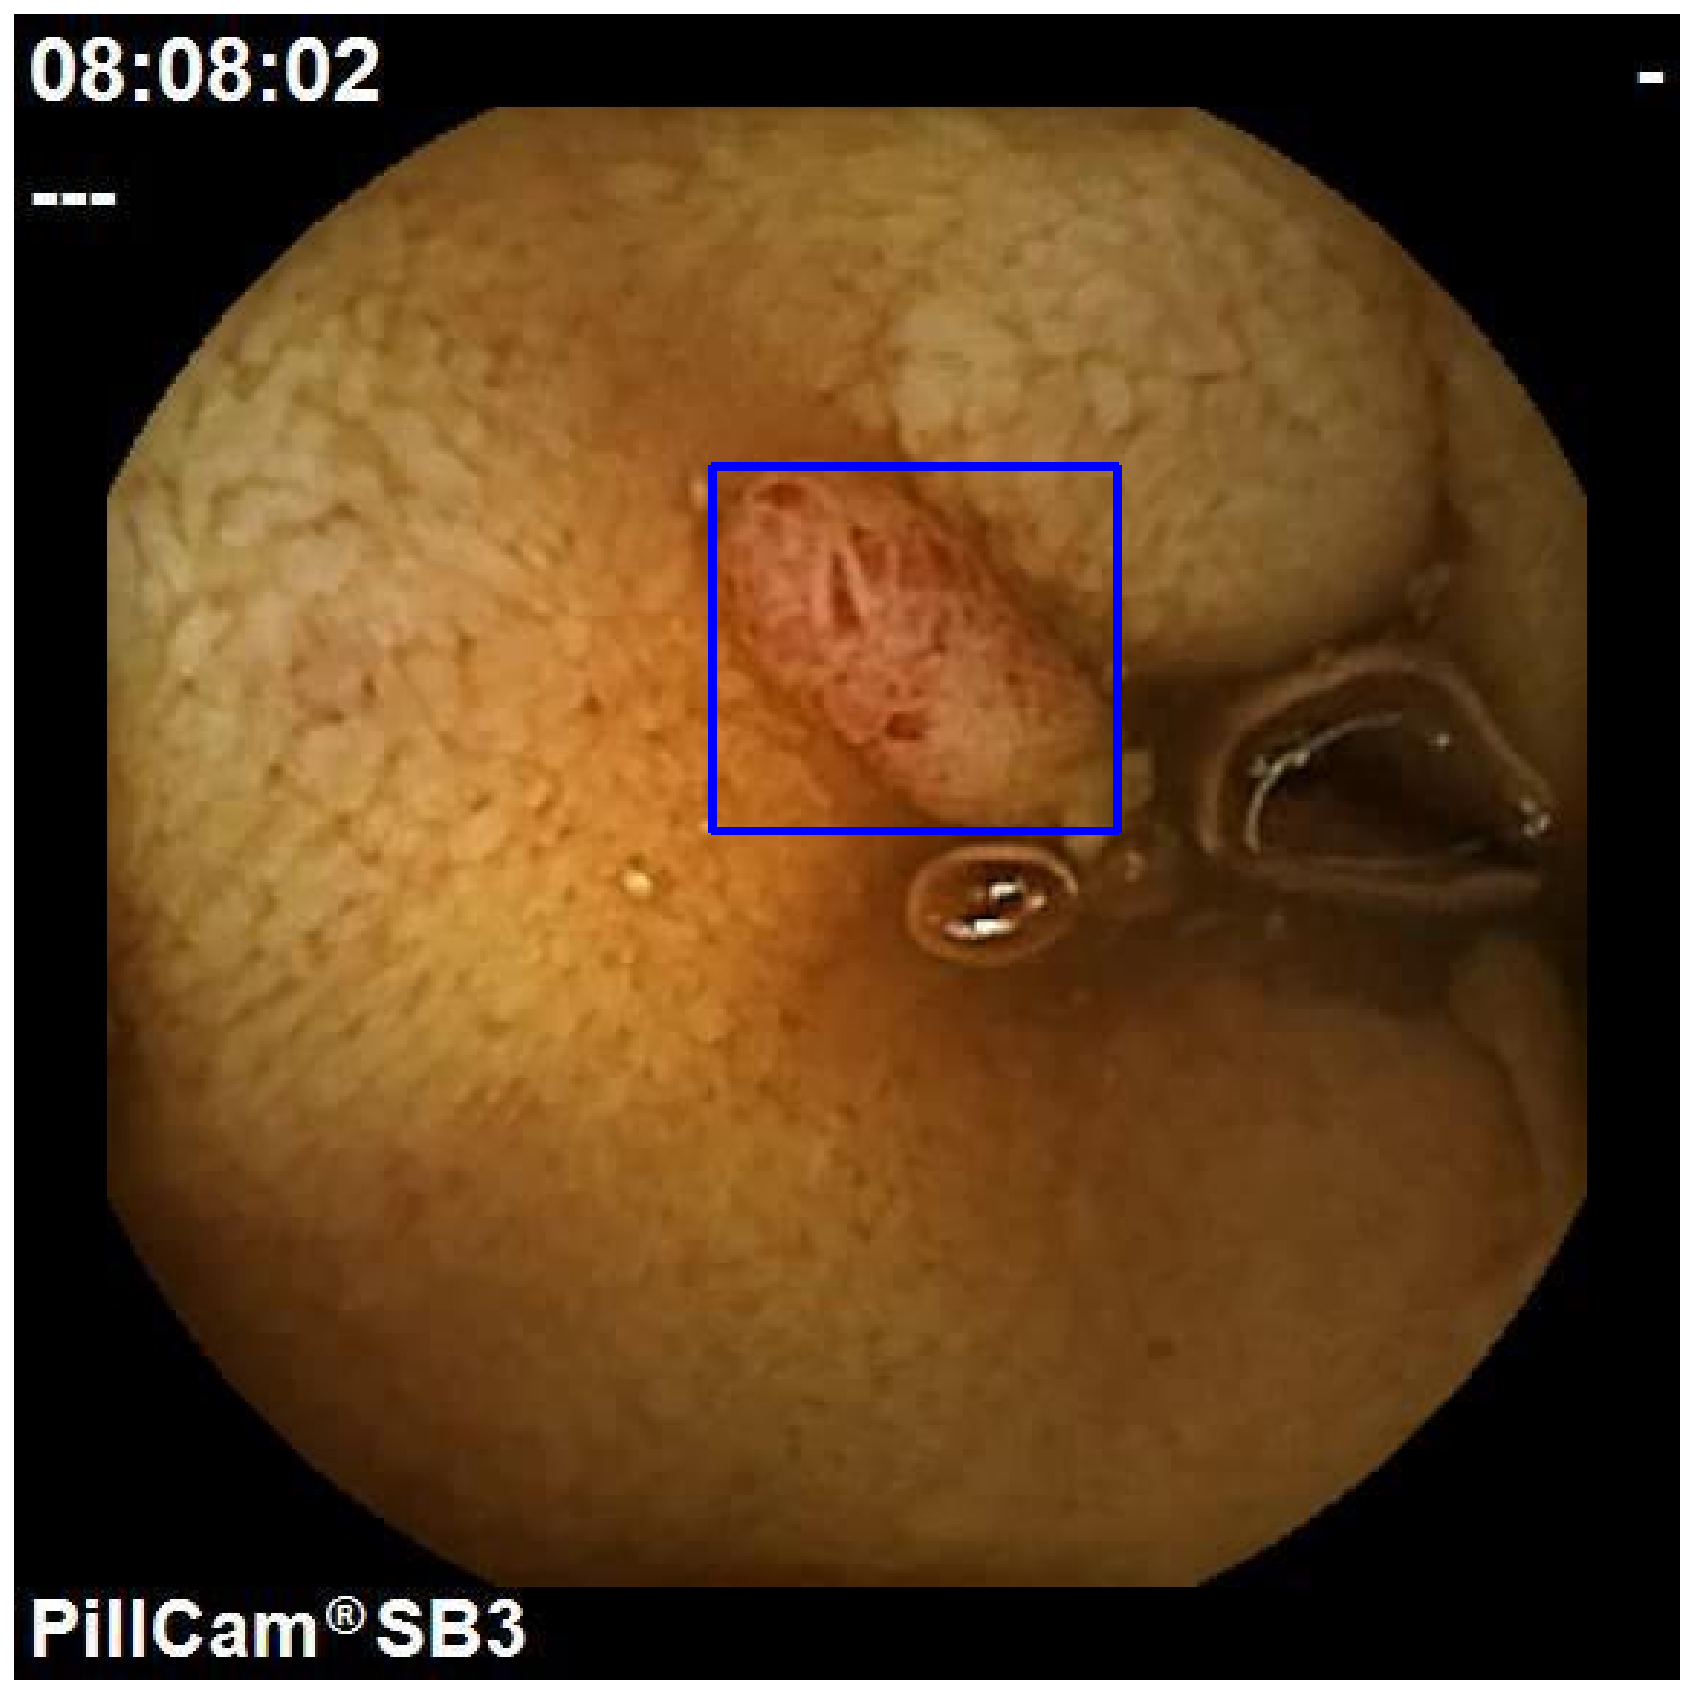

In [ ]:
show_image(form, bbox=BBox)

In [ ]:
# 증강 보여주깅
def show_augmented(augmentation, image, bbox):
  # 증강 함수 틀
  augmented = augmentation(image=image, bboxes=[bbox], field_id=['3'])
  # 이미지 보여주는 함수
  show_image(augmented['image'], augmented['bboxes'][0])

In [ ]:
# bbox 증강
# [x_min, y_min, x_max, y_max], e.g. [97, 12, 247, 212].
bbox_params = A.BboxParams(
  format='pascal_voc', 
  min_area=1, 
  min_visibility=0.5, 
  label_fields=['field_id']
)

In [ ]:
# 증강요소
doc_aug = A.Compose([
    A.Flip(p=0.25),
    A.RandomGamma(gamma_limit=(20, 300), p=0.5),
    A.RandomBrightnessContrast(p=0.85),
    A.Rotate(limit=35, p=0.9),
    A.RandomRotate90(p=0.25),
    A.RGBShift(p=0.75),
    A.GaussNoise(p=0.25)
], bbox_params=bbox_params)

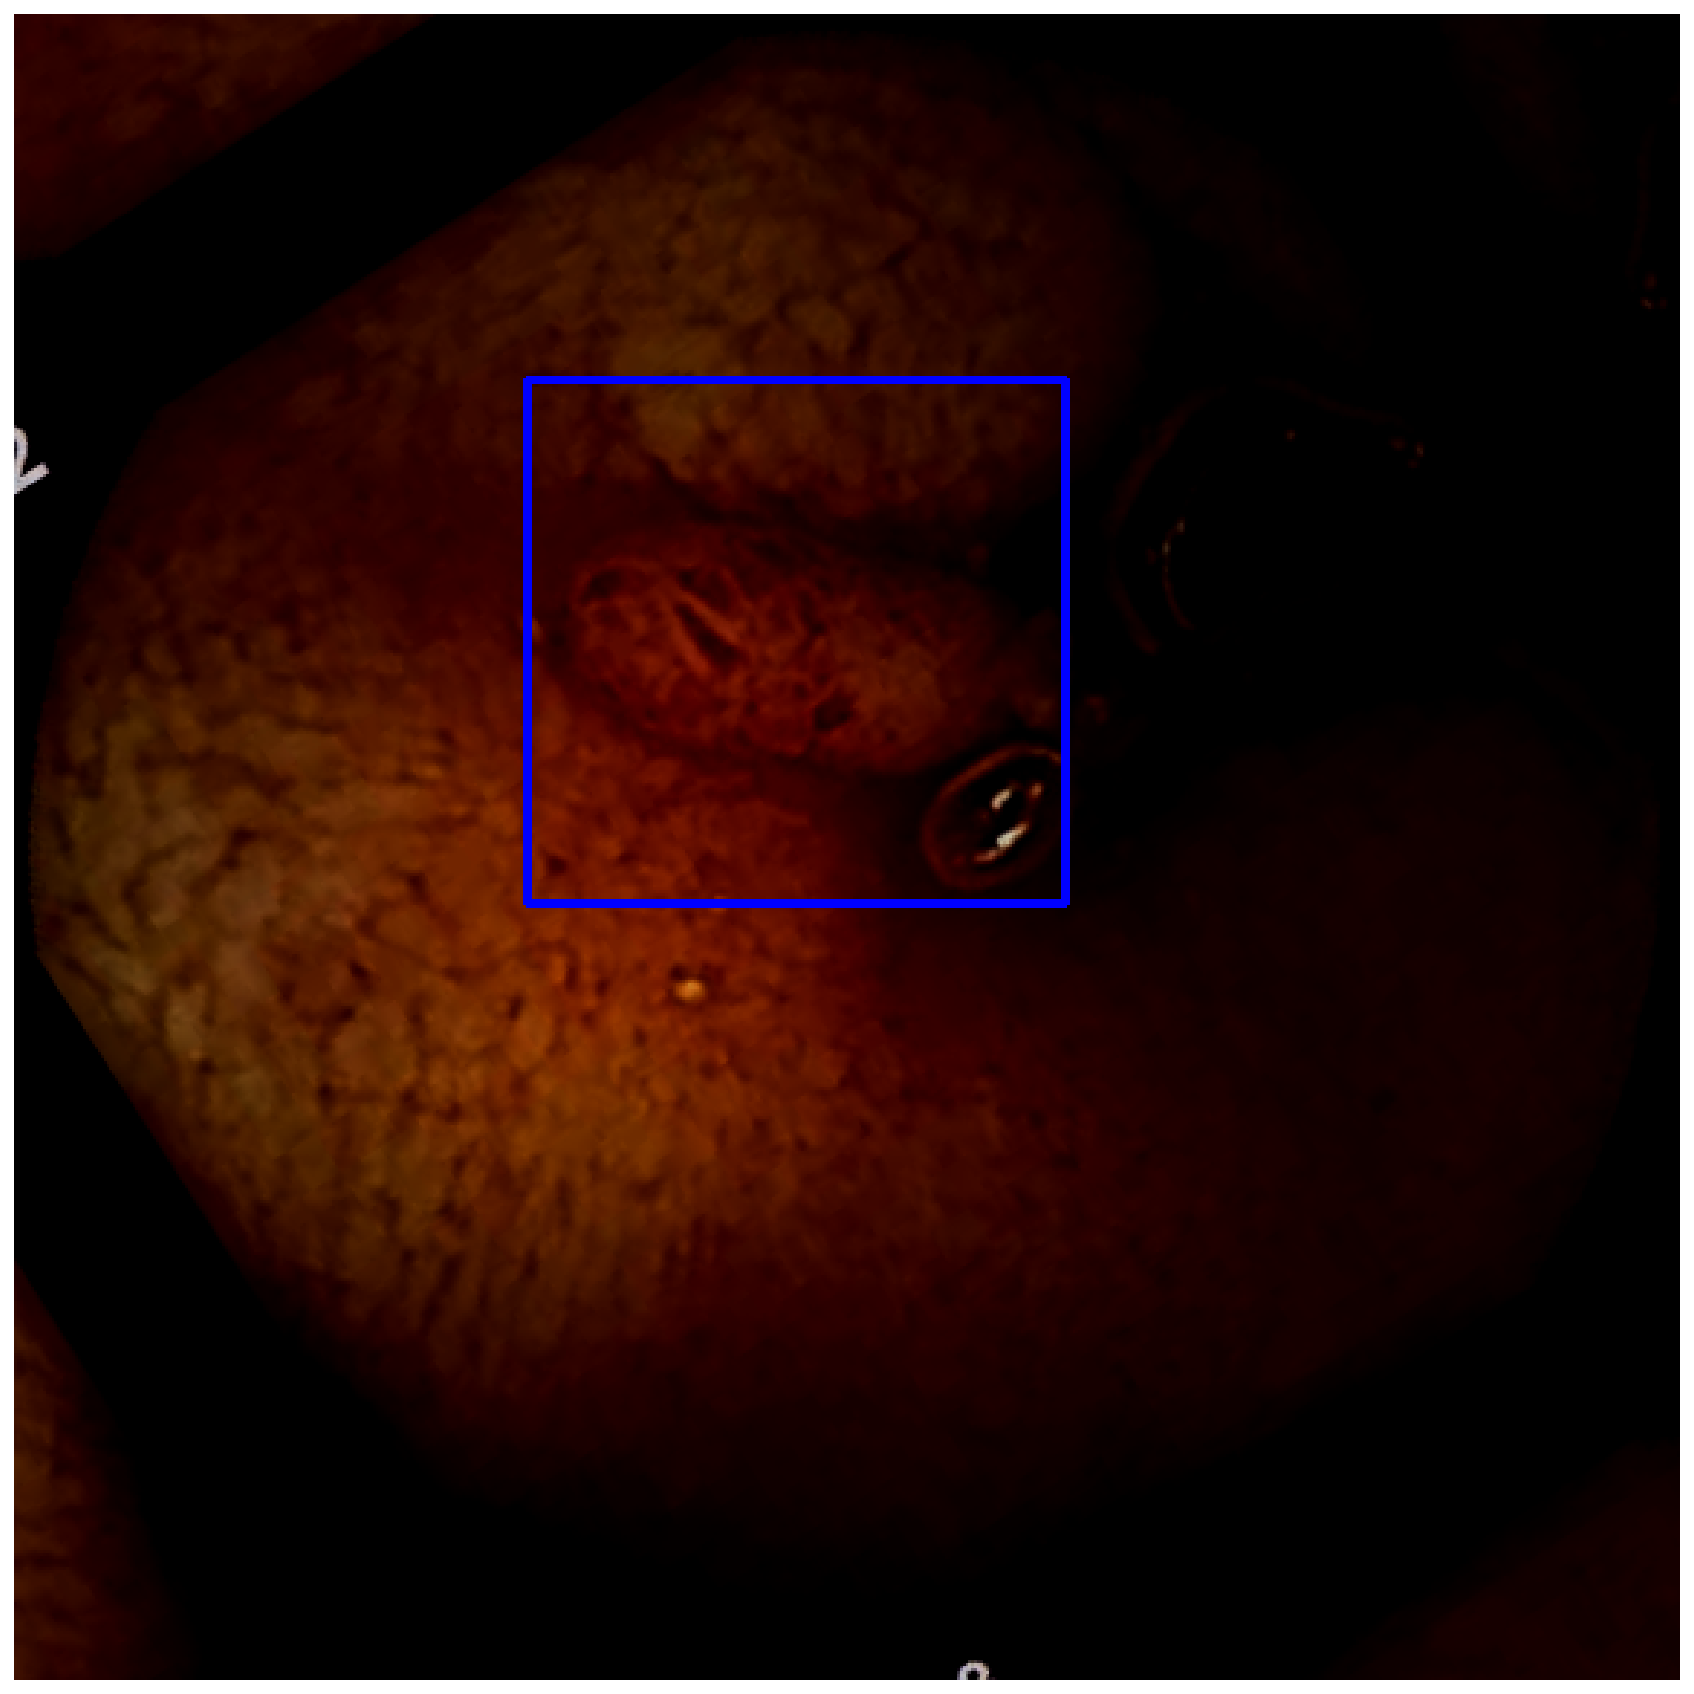

In [ ]:
# 증강 함수
show_augmented(doc_aug, form, BBox)

In [ ]:
lymph_df

image_id class_name  class_id     x_min     y_min     x_max     y_max  \
0       100000   04_lymph         3  303.9913  368.8312  373.6883  493.5065   
19      100019   04_lymph         3   94.1351  363.1081  207.1081  470.6757   
20      100020   04_lymph         3  166.7005   64.2406  338.3583  194.1872   
40      100039   04_lymph         3  117.5439  269.5614  240.9357  408.7427   
67      100060   04_lymph         3  254.6429   69.2381  390.3571  190.6667   
...        ...        ...       ...       ...       ...       ...       ...   
4087    103550   04_lymph         3   87.9740   61.0390  503.5584  163.6364   
4088    103550   04_lymph         3   63.2987  170.1299  158.5368  493.0736   
4089    103551   04_lymph         3  284.1006  106.5089  398.3018  215.9763   
4091    103554   04_lymph         3  146.7788   79.8077  186.9231  108.1731   
4106    103567   04_lymph         3  443.8649  173.3784  536.2973  273.9189   

      width  height         file_name          area  
0       576     576  train_100000.jpg   8689.494384  
19      576     576  train_100019.jpg  12152.234475  
20      576     576  train_100020.jpg  22306.347473  
40      576     576  train_100039.jpg  17173.831133  
67      576     576  train_100060.jpg  16479.585306  
...     ...     ...               ...           ...  
4087    576     576  train_103550.jpg  42637.878921  
4088    576     576  train_103550.jpg  30756.544395  
4089    576     576  train_103551.jpg  12501.308441  
4091    320     320  train_103554.jpg   1138.709127  
4106    576     576  train_103567.jpg   9293.199712  

[600 rows x 11 columns]

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/augumentation'
IMAGES_PATH = f'{DATASET_PATH}/lymph'

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []

for j,k in tqdm(enumerate(lymph_df.iloc)):
  if j == 400: break
  lymph_file_name=k['file_name']
  lymph_image_id=k['image_id']
  
  lymph_bbox=[]
  lymph_bbox.append(float(k['x_min']))
  lymph_bbox.append(float(k['y_min']))
  lymph_bbox.append(float(k['x_max']))
  lymph_bbox.append(float(k['y_max']))
  print(lymph_file_name,lymph_bbox)

  DIR_TRAIN = '/content/drive/MyDrive/Lesion_detection/data_coco/train/'
  print(DIR_TRAIN+lymph_file_name)
  lymph_form = cv2.imread(DIR_TRAIN+lymph_file_name)

  N=1
  for i in tqdm(range(N)):
    augmented = doc_aug(image=lymph_form, bboxes=[lymph_bbox], field_id=['3'])
    file_name = f'train_{lymph_image_id}_3{j}{i}.jpg'

    for bbox in augmented['bboxes']:
      x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
      rows.append({
        'file_name': file_name,
        'x_min': x_min,
        'y_min': y_min,
        'x_max': x_max,
        'y_max': y_max,
        'class_name': '04_lymph'
      })
    cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

rows_df=pd.DataFrame(rows)
rows_df.to_csv(f'{DATASET_PATH}/lymph_annotations.csv', header=True, index=None)

0it [00:00, ?it/s]

train_100000.jpg [303.9913, 368.8312, 373.6883, 493.5065]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100000.jpg



100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


train_100019.jpg [94.1351, 363.1081, 207.1081, 470.6757]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100019.jpg



100%|██████████| 1/1 [00:00<00:00, 53.15it/s]
2it [00:00, 17.77it/s]

train_100020.jpg [166.7005, 64.2406, 338.3583, 194.1872]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100020.jpg



100%|██████████| 1/1 [00:00<00:00, 64.49it/s]


train_100039.jpg [117.5439, 269.5614, 240.9357, 408.7427]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100039.jpg



100%|██████████| 1/1 [00:00<00:00, 14.34it/s]
4it [00:00, 18.00it/s]

train_100060.jpg [254.6429, 69.2381, 390.3571, 190.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100060.jpg



100%|██████████| 1/1 [00:00<00:00, 68.81it/s]


train_100060.jpg [221.3095, 382.9286, 383.2143, 531.1429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100060.jpg



100%|██████████| 1/1 [00:00<00:00, 49.74it/s]


train_100064.jpg [370.7297, 450.6757, 427.4865, 539.1892]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100064.jpg



100%|██████████| 1/1 [00:00<00:00, 71.34it/s]


train_100067.jpg [2.1053, 180.3684, 141.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100067.jpg



100%|██████████| 1/1 [00:00<00:00, 113.06it/s]
8it [00:00, 26.71it/s]

train_100080.jpg [222.6087, 35.6522, 363.4783, 90.8696]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100080.jpg



100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


train_100080.jpg [70.4348, 75.6522, 158.2609, 169.1304]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100080.jpg



100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


train_100086.jpg [461.7381, 205.3571, 499.2381, 288.0952]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100086.jpg



100%|██████████| 1/1 [00:00<00:00,  8.72it/s]
11it [00:00, 18.36it/s]

train_100100.jpg [137.7255, 279.3137, 191.1569, 368.0392]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100100.jpg



100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


train_100100.jpg [324.4902, 224.902, 405.3725, 289.6078]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100100.jpg



100%|██████████| 1/1 [00:00<00:00, 60.71it/s]


train_100105.jpg [322.6061, 243.29, 389.2727, 328.1385]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100105.jpg



100%|██████████| 1/1 [00:00<00:00, 14.47it/s]
14it [00:00, 17.09it/s]

train_100105.jpg [50.3117, 187.4459, 236.026, 373.5931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100105.jpg



100%|██████████| 1/1 [00:00<00:00, 62.02it/s]


train_100117.jpg [148.5876, 19.322, 218.6441, 123.8418]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100117.jpg



100%|██████████| 1/1 [00:00<00:00, 106.03it/s]


train_100143.jpg [112.1783, 251.9535, 154.814, 311.6434]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100143.jpg



100%|██████████| 1/1 [00:00<00:00, 48.91it/s]


train_100147.jpg [183.2308, 39.1026, 298.6154, 216.0256]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100147.jpg



100%|██████████| 1/1 [00:00<00:00, 75.92it/s]
18it [00:00, 21.88it/s]

train_100150.jpg [166.3293, 307.7844, 208.2455, 356.2874]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100150.jpg



100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


train_100154.jpg [223.0476, 118.4524, 276.0238, 180.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100154.jpg



100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


train_100155.jpg [86.9231, 53.6058, 140.2885, 100.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100155.jpg



100%|██████████| 1/1 [00:00<00:00, 41.32it/s]
21it [00:01, 19.35it/s]

train_100170.jpg [56.4972, 130.6215, 100.0, 177.5141]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100170.jpg



100%|██████████| 1/1 [00:00<00:00, 101.19it/s]


train_100175.jpg [122.5, 86.2981, 172.0192, 128.8462]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100175.jpg



100%|██████████| 1/1 [00:00<00:00, 122.71it/s]


train_100187.jpg [178.5311, 34.0113, 214.6893, 124.4068]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100187.jpg



100%|██████████| 1/1 [00:00<00:00, 37.90it/s]


train_100191.jpg [106.5941, 302.6852, 159.8875, 358.9726]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100191.jpg



100%|██████████| 1/1 [00:00<00:00, 52.46it/s]
25it [00:01, 22.93it/s]

train_100197.jpg [41.6757, 332.4324, 91.0, 437.1622]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100197.jpg



100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


train_100200.jpg [285.4865, 280.8108, 350.3514, 386.2162]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100200.jpg



100%|██████████| 1/1 [00:00<00:00, 57.05it/s]


train_100201.jpg [62.963, 275.5397, 119.5767, 361.7831]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100201.jpg



100%|██████████| 1/1 [00:00<00:00, 14.85it/s]
28it [00:01, 22.16it/s]

train_100207.jpg [233.3137, 433.7255, 305.8627, 504.3137]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100207.jpg



100%|██████████| 1/1 [00:00<00:00, 28.81it/s]


train_100211.jpg [182.497, 289.9408, 349.3609, 399.4083]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100211.jpg



100%|██████████| 1/1 [00:00<00:00, 72.50it/s]


train_100221.jpg [63.8889, 236.0, 151.4444, 294.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100221.jpg



100%|██████████| 1/1 [00:00<00:00, 15.01it/s]
31it [00:01, 21.28it/s]

train_100221.jpg [80.7778, 108.8889, 206.1111, 184.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100221.jpg



100%|██████████| 1/1 [00:00<00:00, 60.48it/s]


train_100223.jpg [134.7368, 20.3684, 193.1579, 65.6316]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100223.jpg



100%|██████████| 1/1 [00:00<00:00, 89.01it/s]


train_100226.jpg [235.5476, 81.5476, 409.9524, 205.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100226.jpg



100%|██████████| 1/1 [00:00<00:00, 64.51it/s]


train_100229.jpg [347.2722, 256.8047, 414.1361, 290.5325]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100229.jpg



100%|██████████| 1/1 [00:00<00:00, 67.61it/s]
35it [00:01, 24.93it/s]

train_100235.jpg [68.1731, 131.25, 138.3654, 155.0481]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100235.jpg



100%|██████████| 1/1 [00:00<00:00, 122.12it/s]


train_100242.jpg [324.828, 256.4516, 405.4731, 314.5161]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100242.jpg



100%|██████████| 1/1 [00:00<00:00, 56.40it/s]


train_100243.jpg [444.0945, 387.937, 470.8661, 432.0315]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100243.jpg



100%|██████████| 1/1 [00:00<00:00, 52.73it/s]


train_100249.jpg [293.881, 58.9286, 355.7857, 105.3571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100249.jpg



100%|██████████| 1/1 [00:00<00:00, 57.57it/s]
39it [00:01, 27.65it/s]

train_100250.jpg [237.8947, 366.2105, 272.6316, 417.7895]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100250.jpg



100%|██████████| 1/1 [00:00<00:00, 57.13it/s]


train_100256.jpg [161.3333, 244.6667, 196.3333, 341.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100256.jpg



100%|██████████| 1/1 [00:00<00:00, 56.40it/s]


train_100258.jpg [273.142, 229.5858, 359.5325, 311.2426]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100258.jpg



100%|██████████| 1/1 [00:00<00:00, 14.11it/s]
42it [00:01, 25.49it/s]

train_100272.jpg [177.0673, 98.0769, 224.4231, 161.5385]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100272.jpg



100%|██████████| 1/1 [00:00<00:00, 37.56it/s]


train_100277.jpg [157.1154, 81.7308, 200.625, 117.7885]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100277.jpg



100%|██████████| 1/1 [00:00<00:00, 37.40it/s]


train_100282.jpg [260.8084, 369.4611, 324.2814, 448.503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100282.jpg



100%|██████████| 1/1 [00:00<00:00, 62.62it/s]
45it [00:01, 26.22it/s]

train_100282.jpg [456.018, 95.2096, 519.491, 156.8862]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100282.jpg



100%|██████████| 1/1 [00:00<00:00, 53.27it/s]


train_100285.jpg [328.6667, 309.9567, 540.355, 543.7229]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100285.jpg



100%|██████████| 1/1 [00:00<00:00, 75.71it/s]


train_100297.jpg [276.5161, 271.5054, 320.0645, 336.0215]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100297.jpg



100%|██████████| 1/1 [00:00<00:00, 10.00it/s]
48it [00:02, 22.98it/s]

train_100297.jpg [353.9355, 246.2366, 405.0108, 300.5376]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100297.jpg



100%|██████████| 1/1 [00:00<00:00, 52.08it/s]


train_100300.jpg [221.1111, 412.8889, 305.1111, 514.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100300.jpg



100%|██████████| 1/1 [00:00<00:00, 55.73it/s]


train_100304.jpg [18.2099, 129.6214, 107.0988, 236.2058]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100304.jpg



100%|██████████| 1/1 [00:00<00:00, 37.51it/s]
51it [00:02, 24.53it/s]

train_100311.jpg [396.2619, 302.9762, 454.5952, 369.0476]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100311.jpg



100%|██████████| 1/1 [00:00<00:00, 72.88it/s]


train_100312.jpg [385.0465, 359.7054, 433.1085, 400.7907]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100312.jpg



100%|██████████| 1/1 [00:00<00:00, 74.24it/s]


train_100336.jpg [148.7019, 76.9231, 190.5288, 109.8558]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100336.jpg



100%|██████████| 1/1 [00:00<00:00, 36.06it/s]


train_100352.jpg [290.6863, 73.8562, 361.2745, 140.5229]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100352.jpg



100%|██████████| 1/1 [00:00<00:00, 60.86it/s]
55it [00:02, 26.90it/s]

train_100356.jpg [230.1905, 62.5, 281.9762, 154.7619]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100356.jpg



100%|██████████| 1/1 [00:00<00:00, 15.29it/s]

train_100366.jpg [100.961, 85.7143, 199.6623, 282.684]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100366.jpg




100%|██████████| 1/1 [00:00<00:00, 14.79it/s]


train_100367.jpg [192.6554, 52.6554, 230.5085, 137.4011]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100367.jpg



100%|██████████| 1/1 [00:00<00:00, 109.27it/s]
58it [00:02, 23.08it/s]

train_100368.jpg [136.3158, 282.4737, 178.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100368.jpg



100%|██████████| 1/1 [00:00<00:00, 37.53it/s]


train_100373.jpg [108.1667, 72.0238, 467.0952, 501.1905]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100373.jpg



100%|██████████| 1/1 [00:00<00:00, 62.84it/s]


train_100386.jpg [91.3293, 241.9162, 193.1257, 310.1796]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100386.jpg



100%|██████████| 1/1 [00:00<00:00, 64.62it/s]


train_100403.jpg [88.9952, 402.4019, 200.0, 487.5694]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100403.jpg



100%|██████████| 1/1 [00:00<00:00, 55.66it/s]
62it [00:02, 25.41it/s]

train_100410.jpg [140.8605, 369.7829, 200.5504, 431.0233]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100410.jpg



100%|██████████| 1/1 [00:00<00:00, 72.80it/s]


train_100418.jpg [87.7545, 432.3353, 139.2515, 493.4132]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100418.jpg



100%|██████████| 1/1 [00:00<00:00, 56.84it/s]


train_100423.jpg [185.1675, 215.3206, 276.555, 285.6555]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100423.jpg



100%|██████████| 1/1 [00:00<00:00, 66.59it/s]


train_100426.jpg [118.0791, 0.113, 155.9322, 70.1695]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100426.jpg



100%|██████████| 1/1 [00:00<00:00, 121.42it/s]
66it [00:02, 28.48it/s]

train_100443.jpg [143.8182, 44.5887, 239.4892, 233.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100443.jpg



100%|██████████| 1/1 [00:00<00:00, 30.40it/s]


train_100446.jpg [346.8571, 138.6905, 409.9524, 222.619]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100446.jpg



100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


train_100453.jpg [290.3095, 146.4286, 358.1667, 262.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100453.jpg



100%|██████████| 1/1 [00:00<00:00, 94.08it/s]
69it [00:02, 25.69it/s]

train_100456.jpg [126.3462, 79.0865, 169.1346, 110.5769]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100456.jpg



100%|██████████| 1/1 [00:00<00:00, 36.52it/s]


train_100463.jpg [198.0861, 221.0622, 302.3923, 289.9617]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100463.jpg



100%|██████████| 1/1 [00:00<00:00, 71.76it/s]


train_100482.jpg [192.0904, 0.113, 219.209, 79.774]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100482.jpg



100%|██████████| 1/1 [00:00<00:00, 87.38it/s]


train_100483.jpg [143.3243, 246.3514, 199.5405, 312.2973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100483.jpg



100%|██████████| 1/1 [00:00<00:00, 14.50it/s]
73it [00:03, 24.81it/s]

train_100483.jpg [160.6216, 487.4324, 222.2432, 536.6216]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100483.jpg



100%|██████████| 1/1 [00:00<00:00, 63.17it/s]

train_100484.jpg

 [151.973, 131.0811, 211.973, 205.6757]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100484.jpg



100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


train_100491.jpg [90.7143, 33.6774, 388.129, 228.0323]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100491.jpg



100%|██████████| 1/1 [00:00<00:00, 65.05it/s]
76it [00:03, 23.86it/s]

train_100491.jpg [315.5484, 236.0968, 413.9355, 355.4516]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100491.jpg



100%|██████████| 1/1 [00:00<00:00, 65.48it/s]


train_100493.jpg [400.6344, 221.043, 472.1398, 285.5591]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100493.jpg



100%|██████████| 1/1 [00:00<00:00, 53.03it/s]


train_100496.jpg [135.0746, 266.4179, 243.2836, 351.4925]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100496.jpg



100%|██████████| 1/1 [00:00<00:00, 44.12it/s]


train_100502.jpg [312.9626, 495.7219, 364.2995, 533.1551]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100502.jpg



100%|██████████| 1/1 [00:00<00:00, 62.69it/s]
80it [00:03, 26.15it/s]

train_100506.jpg [39.5676, 406.7568, 147.0, 467.5676]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100506.jpg



100%|██████████| 1/1 [00:00<00:00, 64.01it/s]


train_100516.jpg [376.0642, 210.1604, 543.9786, 349.7326]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100516.jpg



100%|██████████| 1/1 [00:00<00:00, 59.56it/s]


train_100525.jpg [157.8378, 163.4324, 246.4865, 218.5676]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100525.jpg



100%|██████████| 1/1 [00:00<00:00, 88.05it/s]


train_100533.jpg [154.4712, 80.5288, 198.7019, 114.9038]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100533.jpg



100%|██████████| 1/1 [00:00<00:00, 102.04it/s]
84it [00:03, 29.33it/s]

train_100542.jpg [238.1905, 277.4892, 290.5714, 322.9437]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100542.jpg



100%|██████████| 1/1 [00:00<00:00, 25.20it/s]


train_100547.jpg [132.7684, 19.322, 160.452, 102.9379]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100547.jpg



100%|██████████| 1/1 [00:00<00:00, 99.20it/s]


train_100570.jpg [138.2162, 357.4324, 214.5676, 416.2162]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100570.jpg



100%|██████████| 1/1 [00:00<00:00, 52.98it/s]


train_100574.jpg [31.6774, 249.8065, 166.3548, 500.6129]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100574.jpg



100%|██████████| 1/1 [00:00<00:00, 55.00it/s]
88it [00:03, 29.39it/s]

train_100575.jpg [197.9808, 94.9519, 240.0481, 153.3654]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100575.jpg



100%|██████████| 1/1 [00:00<00:00, 94.21it/s]


train_100576.jpg [392.5135, 82.027, 436.8378, 143.1081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100576.jpg



100%|██████████| 1/1 [00:00<00:00, 64.25it/s]


train_100576.jpg [441.7027, 147.4324, 497.9189, 194.4595]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100576.jpg



100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


train_100577.jpg [337.8058, 203.5971, 404.7122, 284.8921]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100577.jpg



100%|██████████| 1/1 [00:00<00:00, 55.13it/s]
92it [00:03, 30.64it/s]

train_100577.jpg [407.877, 359.4278, 502.5294, 442.8503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100577.jpg



100%|██████████| 1/1 [00:00<00:00, 15.53it/s]


train_100585.jpg [112.0, 243.5484, 196.9462, 309.1398]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100585.jpg



100%|██████████| 1/1 [00:00<00:00, 60.00it/s]


train_100598.jpg [83.4444, 98.6667, 219.8889, 179.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100598.jpg



100%|██████████| 1/1 [00:00<00:00, 70.56it/s]


train_100598.jpg [75.0, 226.2222, 183.4444, 280.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100598.jpg



100%|██████████| 1/1 [00:00<00:00, 55.24it/s]
96it [00:03, 28.03it/s]

train_100605.jpg [235.6667, 464.0, 291.0, 498.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100605.jpg



100%|██████████| 1/1 [00:00<00:00, 58.74it/s]


train_100608.jpg [232.1011, 78.2584, 360.191, 208.5955]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100608.jpg



100%|██████████| 1/1 [00:00<00:00, 55.89it/s]


train_100619.jpg [32.4759, 315.0428, 136.754, 453.5455]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100619.jpg



100%|██████████| 1/1 [00:00<00:00, 15.34it/s]
99it [00:04, 26.08it/s]

train_100623.jpg [318.881, 76.1905, 372.4524, 143.4524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100623.jpg



100%|██████████| 1/1 [00:00<00:00, 59.20it/s]


train_100626.jpg [379.5405, 285.1351, 447.1081, 346.2162]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100626.jpg



100%|██████████| 1/1 [00:00<00:00, 70.39it/s]


train_100626.jpg [282.7838, 194.3243, 332.5135, 255.4054]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100626.jpg



100%|██████████| 1/1 [00:00<00:00, 58.71it/s]


train_100632.jpg [38.1667, 254.0, 107.3333, 331.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100632.jpg



100%|██████████| 1/1 [00:00<00:00, 21.29it/s]
103it [00:04, 26.38it/s]

train_100647.jpg [349.3333, 325.3333, 415.3333, 402.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100647.jpg



100%|██████████| 1/1 [00:00<00:00, 44.45it/s]


train_100666.jpg [254.9355, 90.9355, 481.8172, 211.9032]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100666.jpg



100%|██████████| 1/1 [00:00<00:00, 63.02it/s]


train_100667.jpg [170.0461, 38.5346, 245.6221, 91.0691]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100667.jpg



100%|██████████| 1/1 [00:00<00:00, 46.06it/s]


train_100668.jpg [357.6627, 160.355, 442.8698, 221.3018]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100668.jpg



100%|██████████| 1/1 [00:00<00:00, 15.39it/s]
107it [00:04, 25.07it/s]

train_100672.jpg [266.5827, 257.554, 386.7266, 356.1151]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100672.jpg



100%|██████████| 1/1 [00:00<00:00, 64.22it/s]


train_100703.jpg [315.9048, 301.1905, 381.381, 367.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100703.jpg



100%|██████████| 1/1 [00:00<00:00, 58.68it/s]


train_100703.jpg [246.2619, 110.7143, 299.8333, 150.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100703.jpg



100%|██████████| 1/1 [00:00<00:00, 48.75it/s]


train_100710.jpg [83.8649, 219.7297, 148.7297, 344.0541]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100710.jpg



100%|██████████| 1/1 [00:00<00:00, 60.61it/s]
111it [00:04, 27.18it/s]

train_100728.jpg [214.0321, 308.0214, 281.9465, 378.6096]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100728.jpg



100%|██████████| 1/1 [00:00<00:00, 51.17it/s]


train_100728.jpg [222.0535, 454.5455, 300.6631, 499.4652]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100728.jpg



100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


train_100735.jpg [75.0843, 265.6627, 180.506, 357.8313]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100735.jpg



100%|██████████| 1/1 [00:00<00:00, 70.41it/s]
114it [00:04, 25.39it/s]

train_100736.jpg [44.9459, 147.8378, 97.9189, 201.8919]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100736.jpg



100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


train_100753.jpg [232.5135, 394.8649, 272.5135, 430.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100753.jpg



100%|██████████| 1/1 [00:00<00:00, 59.51it/s]


train_100755.jpg [130.1802, 34.4414, 186.9369, 102.009]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100755.jpg



100%|██████████| 1/1 [00:00<00:00, 98.20it/s]
117it [00:04, 24.56it/s]

train_100758.jpg [158.8264, 36.9436, 274.1639, 108.1092]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100758.jpg



100%|██████████| 1/1 [00:00<00:00, 67.84it/s]


train_100767.jpg [105.2174, 76.8261, 353.0435, 343.7826]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100767.jpg



100%|██████████| 1/1 [00:00<00:00, 53.47it/s]


train_100769.jpg [316.9102, 321.5569, 418.7066, 429.3413]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100769.jpg



100%|██████████| 1/1 [00:00<00:00, 58.07it/s]


train_100783.jpg [225.3268, 318.9542, 280.8824, 362.7451]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100783.jpg



100%|██████████| 1/1 [00:00<00:00, 30.27it/s]
121it [00:04, 25.82it/s]

train_100798.jpg [175.1442, 201.9231, 215.5288, 284.1346]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100798.jpg



100%|██████████| 1/1 [00:00<00:00, 92.45it/s]


train_100798.jpg [77.8378, 29.3784, 155.1351, 93.1622]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100798.jpg



100%|██████████| 1/1 [00:00<00:00, 37.97it/s]

train_100807.jpg [104.3062, 131.5885, 190.9091, 253.1196]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100807.jpg


100%|██████████| 1/1 [00:00<00:00, 56.48it/s]


train_100817.jpg [361.7778, 232.4444, 435.1111, 282.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100817.jpg



100%|██████████| 1/1 [00:00<00:00, 51.19it/s]
125it [00:05, 27.48it/s]

train_100822.jpg [259.536, 106.6282, 357.5187, 192.7954]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100822.jpg



100%|██████████| 1/1 [00:00<00:00, 56.39it/s]


train_100827.jpg [51.8269, 32.2115, 113.125, 87.2596]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100827.jpg



100%|██████████| 1/1 [00:00<00:00, 37.74it/s]


train_100827.jpg [202.7027, 85.0541, 237.2973, 150.4595]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100827.jpg



100%|██████████| 1/1 [00:00<00:00, 92.00it/s]


train_100829.jpg [182.2162, 477.7027, 263.973, 535.8108]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100829.jpg



100%|██████████| 1/1 [00:00<00:00, 84.07it/s]
129it [00:05, 29.56it/s]

train_100833.jpg [162.006, 482.0359, 231.4671, 529.9401]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100833.jpg



100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


train_100833.jpg [293.1437, 254.491, 367.3952, 292.2156]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100833.jpg



100%|██████████| 1/1 [00:00<00:00, 53.30it/s]


train_100837.jpg [107.3446, 15.9322, 136.1582, 95.0282]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100837.jpg



100%|██████████| 1/1 [00:00<00:00, 90.80it/s]


train_100839.jpg [179.4324, 158.7838, 242.2703, 247.2973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100839.jpg



100%|██████████| 1/1 [00:00<00:00, 88.52it/s]
133it [00:05, 28.10it/s]

train_100839.jpg [67.9459, 212.1622, 199.7027, 337.1622]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100839.jpg



100%|██████████| 1/1 [00:00<00:00, 54.26it/s]


train_100842.jpg [95.8173, 53.6058, 145.0962, 96.1538]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100842.jpg



100%|██████████| 1/1 [00:00<00:00, 92.10it/s]


train_100844.jpg [340.9048, 371.4286, 389.7143, 429.7619]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100844.jpg



100%|██████████| 1/1 [00:00<00:00, 49.25it/s]


train_100846.jpg [435.0435, 297.8261, 511.8551, 369.5652]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100846.jpg



100%|██████████| 1/1 [00:00<00:00, 56.10it/s]
137it [00:05, 29.72it/s]

train_100846.jpg [179.2464, 322.4638, 277.0725, 413.0435]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100846.jpg



100%|██████████| 1/1 [00:00<00:00, 51.52it/s]


train_100873.jpg [72.6434, 436.4496, 142.4109, 489.938]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100873.jpg



100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


train_100874.jpg [82.8829, 39.3964, 137.3874, 102.4595]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100874.jpg



100%|██████████| 1/1 [00:00<00:00, 87.12it/s]


train_100875.jpg [250.7446, 33.3333, 406.1558, 102.1645]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100875.jpg



100%|██████████| 1/1 [00:00<00:00, 65.68it/s]
141it [00:05, 26.31it/s]

train_100875.jpg [406.1558, 85.2814, 495.7662, 241.5584]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100875.jpg



100%|██████████| 1/1 [00:00<00:00, 70.90it/s]


train_100881.jpg [121.6027, 401.5753, 214.0685, 491.9863]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100881.jpg



100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


train_100898.jpg [307.3422, 349.8021, 366.7005, 407.5561]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100898.jpg



100%|██████████| 1/1 [00:00<00:00, 47.13it/s]


train_100906.jpg [56.0479, 274.2515, 100.9581, 350.2994]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100906.jpg



100%|██████████| 1/1 [00:00<00:00, 66.92it/s]
145it [00:05, 27.95it/s]

train_100910.jpg [154.4911, 49.1124, 253.3077, 174.5562]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100910.jpg



100%|██████████| 1/1 [00:00<00:00, 51.15it/s]


train_100915.jpg [105.6731, 93.0288, 148.4615, 121.6346]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100915.jpg



100%|██████████| 1/1 [00:00<00:00, 106.53it/s]


train_100928.jpg [117.9327, 77.4038, 170.5769, 123.7981]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100928.jpg



100%|██████████| 1/1 [00:00<00:00, 136.02it/s]


train_100938.jpg [154.2373, 31.7514, 190.3955, 115.3672]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100938.jpg



100%|██████████| 1/1 [00:00<00:00, 82.89it/s]


train_100953.jpg [286.6753, 136.7965, 367.6277, 275.7576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100953.jpg



100%|██████████| 1/1 [00:00<00:00, 53.92it/s]
150it [00:05, 31.26it/s]

train_100955.jpg [346.5676, 421.8919, 408.1892, 467.2973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100955.jpg



100%|██████████| 1/1 [00:00<00:00, 15.85it/s]


train_100956.jpg [230.8919, 135.9459, 263.3243, 179.1892]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100956.jpg



100%|██████████| 1/1 [00:00<00:00, 70.43it/s]


train_100987.jpg [353.8602, 273.7312, 449.0215, 398.4624]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100987.jpg



100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


train_101001.jpg [52.6218, 212.4118, 108.9244, 322.4958]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101001.jpg



100%|██████████| 1/1 [00:00<00:00, 60.66it/s]
154it [00:06, 25.91it/s]

train_101002.jpg [370.3871, 32.871, 504.2581, 132.871]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101002.jpg



100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


train_101007.jpg [139.4595, 206.1351, 190.2703, 262.8919]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101007.jpg



100%|██████████| 1/1 [00:00<00:00, 89.04it/s]


train_101012.jpg [362.5376, 273.6559, 449.0968, 368.2796]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101012.jpg



100%|██████████| 1/1 [00:00<00:00, 11.15it/s]
157it [00:06, 21.64it/s]

train_101021.jpg [436.8824, 266.9118, 522.1765, 363.2353]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101021.jpg



100%|██████████| 1/1 [00:00<00:00, 54.49it/s]


train_101021.jpg [173.6471, 73.5294, 298.6471, 211.7647]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101021.jpg



100%|██████████| 1/1 [00:00<00:00, 48.85it/s]


train_101042.jpg [492.5449, 229.9401, 539.8503, 328.1437]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101042.jpg



100%|██████████| 1/1 [00:00<00:00, 14.73it/s]
160it [00:06, 21.30it/s]

train_101044.jpg [339.3101, 124.0465, 475.7442, 166.6822]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101044.jpg



100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


train_101046.jpg [269.5556, 382.6667, 317.1111, 414.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101046.jpg



100%|██████████| 1/1 [00:00<00:00, 58.50it/s]


train_101046.jpg [150.8889, 436.0, 356.2222, 540.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101046.jpg



100%|██████████| 1/1 [00:00<00:00, 51.59it/s]
163it [00:06, 21.20it/s]

train_101047.jpg [196.385, 83.9572, 338.0963, 160.4278]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101047.jpg



100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


train_101051.jpg [211.3871, 298.4624, 294.1828, 368.8925]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101051.jpg



100%|██████████| 1/1 [00:00<00:00, 56.05it/s]


train_101054.jpg [148.9423, 84.375, 189.8077, 113.7019]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101054.jpg



100%|██████████| 1/1 [00:00<00:00, 102.95it/s]
166it [00:06, 21.63it/s]

train_101073.jpg [403.0105, 208.9005, 521.8586, 267.5393]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101073.jpg



100%|██████████| 1/1 [00:00<00:00, 62.33it/s]


train_101073.jpg [247.6162, 129.9798, 377.9192, 240.0808]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101073.jpg



100%|██████████| 1/1 [00:00<00:00, 56.76it/s]


train_101084.jpg [220.119, 135.3095, 310.0, 279.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101084.jpg



100%|██████████| 1/1 [00:00<00:00, 14.58it/s]
169it [00:06, 21.39it/s]

train_101084.jpg [182.7838, 358.2432, 289.2703, 418.7838]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101084.jpg



100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


train_101090.jpg [71.6216, 48.4054, 122.973, 112.8198]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101090.jpg



100%|██████████| 1/1 [00:00<00:00, 38.62it/s]


train_101092.jpg [247.6486, 350.0, 287.1081, 394.8649]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101092.jpg



100%|██████████| 1/1 [00:00<00:00, 14.55it/s]
172it [00:06, 20.88it/s]

train_101099.jpg [145.8992, 248.5462, 219.0084, 352.7479]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101099.jpg



100%|██████████| 1/1 [00:00<00:00, 59.76it/s]


train_101099.jpg [195.479, 172.0756, 246.7395, 241.8235]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101099.jpg



100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


train_101102.jpg [324.2381, 123.2143, 365.3095, 186.9048]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101102.jpg



100%|██████████| 1/1 [00:00<00:00, 53.67it/s]
175it [00:07, 19.66it/s]

train_101107.jpg [87.6442, 54.3269, 138.6058, 97.3558]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101107.jpg



100%|██████████| 1/1 [00:00<00:00, 77.79it/s]


train_101111.jpg [255.4024, 130.7692, 325.8166, 170.4142]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101111.jpg



100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


train_101115.jpg [41.7027, 330.8378, 87.1081, 410.2973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101115.jpg



100%|██████████| 1/1 [00:00<00:00, 49.83it/s]
178it [00:07, 19.83it/s]

train_101120.jpg [176.8269, 97.5962, 214.3269, 123.0769]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101120.jpg



100%|██████████| 1/1 [00:00<00:00, 100.77it/s]


train_101126.jpg [277.5161, 253.8387, 336.1183, 337.172]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101126.jpg



100%|██████████| 1/1 [00:00<00:00, 78.03it/s]


train_101133.jpg [234.6285, 34.5066, 358.4747, 93.7373]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101133.jpg



100%|██████████| 1/1 [00:00<00:00, 60.69it/s]


train_101139.jpg [196.6102, 37.9661, 233.8983, 123.8418]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101139.jpg



100%|██████████| 1/1 [00:00<00:00, 120.71it/s]


train_101142.jpg [196.7986, 125.8993, 317.6619, 197.1223]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101142.jpg



100%|██████████| 1/1 [00:00<00:00, 14.51it/s]
183it [00:07, 22.51it/s]

train_101144.jpg [6.8421, 214.5789, 142.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101144.jpg



100%|██████████| 1/1 [00:00<00:00, 106.48it/s]


train_101149.jpg [97.4524, 81.5476, 474.8333, 494.6429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101149.jpg



100%|██████████| 1/1 [00:00<00:00, 53.18it/s]


train_101150.jpg [127.0673, 77.6442, 167.4519, 112.7404]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101150.jpg



100%|██████████| 1/1 [00:00<00:00, 89.15it/s]


train_101151.jpg [154.814, 313.1938, 199.7752, 372.1085]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101151.jpg



100%|██████████| 1/1 [00:00<00:00, 56.03it/s]
187it [00:07, 26.10it/s]

train_101151.jpg [312.9535, 47.3945, 367.9922, 97.7821]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101151.jpg



100%|██████████| 1/1 [00:00<00:00, 62.41it/s]


train_101153.jpg [116.3486, 459.4862, 202.5872, 507.1927]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101153.jpg



100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


train_101166.jpg [379.0, 61.9048, 426.619, 142.2619]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101166.jpg



100%|██████████| 1/1 [00:00<00:00, 26.12it/s]
190it [00:07, 23.50it/s]

train_101170.jpg [171.2619, 348.8095, 293.881, 450.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101170.jpg



100%|██████████| 1/1 [00:00<00:00, 68.02it/s]


train_101176.jpg [196.511, 181.503, 246.1234, 227.2395]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101176.jpg



100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


train_101176.jpg [288.9225, 146.5271, 326.907, 186.062]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101176.jpg



100%|██████████| 1/1 [00:00<00:00, 14.17it/s]
193it [00:07, 20.46it/s]

train_101188.jpg [209.7368, 417.6471, 352.5175, 514.9733]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101188.jpg



100%|██████████| 1/1 [00:00<00:00, 58.97it/s]


train_101199.jpg [454.3307, 397.1496, 503.937, 460.1417]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101199.jpg



100%|██████████| 1/1 [00:00<00:00, 71.41it/s]


train_101205.jpg [55.1429, 240.1429, 98.8403, 303.1681]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101205.jpg



100%|██████████| 1/1 [00:00<00:00, 71.75it/s]


train_101210.jpg [178.0173, 74.8918, 312.6494, 170.5628]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101210.jpg



100%|██████████| 1/1 [00:00<00:00, 67.78it/s]
197it [00:08, 23.83it/s]

train_101210.jpg [143.3853, 166.2338, 228.6667, 350.6494]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101210.jpg



100%|██████████| 1/1 [00:00<00:00, 63.29it/s]


train_101213.jpg [327.2143, 87.5, 373.6429, 133.9286]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101213.jpg



100%|██████████| 1/1 [00:00<00:00, 69.23it/s]


train_101220.jpg [119.4516, 453.8387, 181.8172, 530.7204]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101220.jpg



100%|██████████| 1/1 [00:00<00:00, 55.20it/s]

train_101221.jpg [274.1212, 71.8615, 399.6623, 139.8268]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101221.jpg




100%|██████████| 1/1 [00:00<00:00, 14.78it/s]
201it [00:08, 23.76it/s]

train_101221.jpg [394.4675, 115.5844, 457.2381, 246.3203]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101221.jpg



100%|██████████| 1/1 [00:00<00:00, 14.79it/s]


train_101235.jpg [207.5449, 405.988, 269.8204, 465.8683]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101235.jpg



100%|██████████| 1/1 [00:00<00:00, 52.55it/s]


train_101241.jpg [243.2432, 30.3874, 292.7928, 66.4234]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101241.jpg



100%|██████████| 1/1 [00:00<00:00, 37.59it/s]
204it [00:08, 22.69it/s]

train_101242.jpg [289.284, 218.3432, 365.0237, 272.1893]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101242.jpg



100%|██████████| 1/1 [00:00<00:00, 14.44it/s]


train_101245.jpg [166.1017, 26.6667, 196.6102, 116.4972]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101245.jpg



100%|██████████| 1/1 [00:00<00:00, 89.35it/s]


train_101246.jpg [39.7129, 266.0383, 133.0144, 360.7751]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101246.jpg



100%|██████████| 1/1 [00:00<00:00, 19.15it/s]
207it [00:08, 21.12it/s]

train_101253.jpg [120.5263, 44.0526, 197.8947, 115.6316]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101253.jpg



100%|██████████| 1/1 [00:00<00:00, 96.85it/s]


train_101254.jpg [32.5976, 279.2899, 145.0237, 373.3728]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101254.jpg



100%|██████████| 1/1 [00:00<00:00, 49.10it/s]


train_101255.jpg [470.5269, 262.4409, 530.7419, 330.7204]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101255.jpg



100%|██████████| 1/1 [00:00<00:00, 13.98it/s]
210it [00:08, 21.09it/s]

train_101262.jpg [259.0, 172.7027, 303.8649, 237.5676]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101262.jpg



100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


train_101267.jpg [173.6129, 492.5484, 269.5806, 540.9355]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101267.jpg



100%|██████████| 1/1 [00:00<00:00, 54.48it/s]


train_101268.jpg [456.9762, 212.5, 504.5952, 292.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101268.jpg



100%|██████████| 1/1 [00:00<00:00, 68.94it/s]
213it [00:08, 21.20it/s]

train_101268.jpg [402.8095, 430.9524, 476.0238, 492.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101268.jpg



100%|██████████| 1/1 [00:00<00:00, 62.61it/s]


train_101271.jpg [229.3413, 330.0719, 289.8204, 394.7425]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101271.jpg



100%|██████████| 1/1 [00:00<00:00, 51.43it/s]

train_101272.jpg [38.2688, 290.9355, 132.8925, 367.2796]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101272.jpg




100%|██████████| 1/1 [00:00<00:00, 59.49it/s]


train_101283.jpg [229.0053, 422.4599, 324.7273, 479.6791]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101283.jpg



100%|██████████| 1/1 [00:00<00:00, 56.43it/s]
217it [00:08, 24.14it/s]

train_101284.jpg [214.6486, 441.8919, 298.4324, 506.7568]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101284.jpg



100%|██████████| 1/1 [00:00<00:00, 15.12it/s]


train_101286.jpg [489.119, 242.2619, 534.9524, 287.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101286.jpg



100%|██████████| 1/1 [00:00<00:00, 51.44it/s]


train_101294.jpg [216.1569, 296.4706, 259.2941, 365.5882]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101294.jpg



100%|██████████| 1/1 [00:00<00:00, 68.97it/s]
220it [00:09, 23.36it/s]

train_101311.jpg [137.7597, 472.1085, 199.0, 522.4961]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101311.jpg



100%|██████████| 1/1 [00:00<00:00, 15.92it/s]


train_101312.jpg [119.8201, 113.6691, 282.4101, 248.9209]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101312.jpg



100%|██████████| 1/1 [00:00<00:00, 48.24it/s]


train_101334.jpg [180.8966, 410.931, 289.5172, 536.7931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101334.jpg



100%|██████████| 1/1 [00:00<00:00, 13.94it/s]
223it [00:09, 20.30it/s]

train_101335.jpg [229.0719, 265.2695, 267.3952, 295.8084]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101335.jpg



100%|██████████| 1/1 [00:00<00:00, 53.56it/s]


train_101360.jpg [356.4444, 204.0, 444.0, 256.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101360.jpg



100%|██████████| 1/1 [00:00<00:00, 15.60it/s]


train_101367.jpg [162.1469, 0.113, 193.2203, 63.9548]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101367.jpg



100%|██████████| 1/1 [00:00<00:00, 37.35it/s]
226it [00:09, 19.75it/s]

train_101368.jpg [40.0, 140.1892, 83.7838, 183.973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101368.jpg



100%|██████████| 1/1 [00:00<00:00, 37.36it/s]


train_101375.jpg [117.1373, 272.9412, 210.7647, 468.0392]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101375.jpg



100%|██████████| 1/1 [00:00<00:00, 58.02it/s]


train_101381.jpg [149.6667, 74.6667, 215.5, 203.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101381.jpg



100%|██████████| 1/1 [00:00<00:00, 58.44it/s]


train_101395.jpg [470.073, 197.0803, 497.0803, 251.0949]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101395.jpg



100%|██████████| 1/1 [00:00<00:00, 50.78it/s]
230it [00:09, 22.51it/s]

train_101406.jpg [268.6078, 122.9412, 370.5686, 200.8824]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101406.jpg



100%|██████████| 1/1 [00:00<00:00, 57.74it/s]


train_101407.jpg [322.1732, 90.9091, 401.8268, 126.8398]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101407.jpg



100%|██████████| 1/1 [00:00<00:00, 49.53it/s]


train_101418.jpg [376.6871, 248.4417, 462.5767, 334.3313]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101418.jpg



100%|██████████| 1/1 [00:00<00:00, 56.05it/s]


train_101421.jpg [85.5946, 417.5676, 155.1892, 492.5676]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101421.jpg



100%|██████████| 1/1 [00:00<00:00, 55.85it/s]
234it [00:09, 24.72it/s]

train_101429.jpg [102.2017, 314.9328, 158.5042, 374.5966]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101429.jpg



100%|██████████| 1/1 [00:00<00:00, 54.89it/s]


train_101431.jpg [98.4324, 352.027, 168.7027, 443.9189]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101431.jpg



100%|██████████| 1/1 [00:00<00:00, 52.58it/s]


train_101433.jpg [270.9786, 45.5241, 433.0107, 211.2995]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101433.jpg



100%|██████████| 1/1 [00:00<00:00, 14.90it/s]
237it [00:09, 23.65it/s]

train_101434.jpg [452.7559, 171.9528, 511.0236, 230.2205]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101434.jpg



100%|██████████| 1/1 [00:00<00:00, 73.48it/s]


train_101446.jpg [257.2973, 200.7297, 289.7297, 249.9189]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101446.jpg



100%|██████████| 1/1 [00:00<00:00, 131.84it/s]


train_101448.jpg [174.7027, 134.4595, 240.2432, 168.9189]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101448.jpg



100%|██████████| 1/1 [00:00<00:00, 54.97it/s]


train_101461.jpg [128.1892, 221.8919, 177.9189, 281.8919]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101461.jpg



100%|██████████| 1/1 [00:00<00:00, 77.58it/s]
241it [00:09, 26.39it/s]

train_101472.jpg [109.8108, 248.3784, 159.0, 298.1081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101472.jpg



100%|██████████| 1/1 [00:00<00:00, 73.68it/s]


train_101484.jpg [336.7857, 255.5476, 487.9762, 366.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101484.jpg



100%|██████████| 1/1 [00:00<00:00, 53.52it/s]


train_101495.jpg [250.7177, 351.2057, 345.4545, 408.1435]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101495.jpg



100%|██████████| 1/1 [00:00<00:00, 52.53it/s]


train_101501.jpg [80.8824, 358.8235, 154.7386, 433.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101501.jpg



100%|██████████| 1/1 [00:00<00:00, 87.16it/s]
245it [00:10, 28.60it/s]

train_101507.jpg [193.6937, 28.1351, 241.8919, 60.1171]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101507.jpg



100%|██████████| 1/1 [00:00<00:00, 93.15it/s]


train_101507.jpg [128.2486, 58.3051, 180.791, 152.0904]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101507.jpg



100%|██████████| 1/1 [00:00<00:00, 107.47it/s]


train_101509.jpg [324.0504, 63.6723, 356.8235, 114.9328]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101509.jpg



100%|██████████| 1/1 [00:00<00:00, 56.44it/s]


train_101509.jpg [310.605, 241.8235, 346.7395, 307.3697]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101509.jpg



100%|██████████| 1/1 [00:00<00:00, 16.41it/s]
249it [00:10, 28.42it/s]

train_101511.jpg [94.7368, 161.3158, 243.6842, 316.0526]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101511.jpg



100%|██████████| 1/1 [00:00<00:00, 87.72it/s]


train_101512.jpg [433.9005, 218.8482, 533.377, 322.5131]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101512.jpg



100%|██████████| 1/1 [00:00<00:00, 54.35it/s]


train_101512.jpg [261.1257, 166.4921, 328.6649, 257.0681]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101512.jpg



100%|██████████| 1/1 [00:00<00:00, 59.89it/s]


train_101515.jpg [279.5556, 431.5556, 356.0, 500.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101515.jpg



100%|██████████| 1/1 [00:00<00:00, 14.91it/s]
253it [00:10, 26.82it/s]

train_101516.jpg [204.0374, 332.6898, 262.3262, 386.7005]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101516.jpg



100%|██████████| 1/1 [00:00<00:00, 55.82it/s]


train_101526.jpg [259.4651, 328.6977, 296.6744, 378.3101]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101526.jpg



100%|██████████| 1/1 [00:00<00:00, 57.79it/s]


train_101528.jpg [71.7861, 127.2727, 170.7166, 200.5348]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101528.jpg



100%|██████████| 1/1 [00:00<00:00, 74.03it/s]


train_101529.jpg [71.973, 222.973, 109.2703, 285.1351]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101529.jpg



100%|██████████| 1/1 [00:00<00:00, 56.30it/s]
257it [00:10, 28.54it/s]

train_101534.jpg [173.8858, 173.2785, 227.3105, 207.5251]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101534.jpg



100%|██████████| 1/1 [00:00<00:00, 26.52it/s]


train_101535.jpg [99.8333, 78.5714, 467.6905, 498.2143]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101535.jpg



100%|██████████| 1/1 [00:00<00:00, 54.65it/s]


train_101537.jpg [201.0811, 61.8108, 258.3784, 121.8108]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101537.jpg



100%|██████████| 1/1 [00:00<00:00, 37.35it/s]
260it [00:10, 27.35it/s]

train_101549.jpg [240.5, 45.6364, 291.0682, 89.3864]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101549.jpg



100%|██████████| 1/1 [00:00<00:00, 100.52it/s]


train_101557.jpg [310.5476, 52.381, 471.2619, 142.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101557.jpg



100%|██████████| 1/1 [00:00<00:00, 58.43it/s]


train_101557.jpg [39.7143, 345.2381, 77.2143, 405.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101557.jpg



100%|██████████| 1/1 [00:00<00:00, 59.34it/s]


train_101560.jpg [153.5096, 80.5288, 203.5096, 112.9808]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101560.jpg



100%|██████████| 1/1 [00:00<00:00, 36.90it/s]
264it [00:10, 29.03it/s]

train_101564.jpg [254.085, 276.4706, 300.4902, 329.4118]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101564.jpg



100%|██████████| 1/1 [00:00<00:00, 66.00it/s]


train_101565.jpg [148.2212, 80.7692, 188.8462, 112.2596]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101565.jpg



100%|██████████| 1/1 [00:00<00:00, 125.75it/s]


train_101570.jpg [240.1575, 276.126, 302.3622, 380.8504]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101570.jpg



100%|██████████| 1/1 [00:00<00:00, 15.15it/s]
267it [00:10, 27.50it/s]

train_101592.jpg [116.3842, 3.5028, 153.6723, 70.7345]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101592.jpg



100%|██████████| 1/1 [00:00<00:00, 80.79it/s]


train_101594.jpg [489.8108, 262.4324, 522.7838, 294.3243]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101594.jpg



100%|██████████| 1/1 [00:00<00:00, 48.75it/s]


train_101606.jpg [312.7255, 373.9216, 380.3725, 422.451]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101606.jpg



100%|██████████| 1/1 [00:00<00:00, 53.63it/s]


train_101606.jpg [168.6078, 438.1373, 247.0392, 502.3529]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101606.jpg



100%|██████████| 1/1 [00:00<00:00, 47.64it/s]
271it [00:11, 29.00it/s]

train_101607.jpg [160.7656, 269.3876, 258.3732, 344.9856]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101607.jpg



100%|██████████| 1/1 [00:00<00:00, 53.23it/s]


train_101614.jpg [336.1892, 159.4595, 368.6216, 195.9459]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101614.jpg



100%|██████████| 1/1 [00:00<00:00, 63.09it/s]


train_101615.jpg [265.0303, 282.2511, 371.5238, 329.0043]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101615.jpg



100%|██████████| 1/1 [00:00<00:00, 62.87it/s]


train_101617.jpg [170.3514, 253.5405, 236.8378, 316.2432]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101617.jpg



100%|██████████| 1/1 [00:00<00:00, 59.32it/s]
275it [00:11, 30.11it/s]

train_101625.jpg [210.2114, 368.7317, 328.0976, 456.5366]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101625.jpg



100%|██████████| 1/1 [00:00<00:00, 48.38it/s]


train_101633.jpg [315.1921, 331.0345, 359.5271, 356.1576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101633.jpg



100%|██████████| 1/1 [00:00<00:00, 58.48it/s]

train_101638.jpg [184.9459, 460.4054, 363.3243, 542.5676]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101638.jpg




100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


train_101639.jpg [175.7062, 36.2712, 208.4746, 121.5819]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101639.jpg



100%|██████████| 1/1 [00:00<00:00, 92.77it/s]
279it [00:11, 26.82it/s]

train_101651.jpg [351.619, 116.0714, 402.2143, 199.4048]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101651.jpg



100%|██████████| 1/1 [00:00<00:00, 60.94it/s]


train_101652.jpg [246.7101, 218.3432, 286.7931, 263.9053]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101652.jpg



100%|██████████| 1/1 [00:00<00:00, 71.01it/s]


train_101655.jpg [420.6049, 378.037, 519.9877, 492.8519]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101655.jpg



100%|██████████| 1/1 [00:00<00:00, 14.82it/s]
282it [00:11, 25.34it/s]

train_101659.jpg [370.0645, 243.5484, 454.4731, 334.9462]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101659.jpg



100%|██████████| 1/1 [00:00<00:00, 60.16it/s]


train_101661.jpg [247.0811, 435.1351, 336.2703, 512.8378]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101661.jpg



100%|██████████| 1/1 [00:00<00:00, 58.26it/s]

train_101690.jpg [120.3365, 84.375, 170.0962, 126.6827]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101690.jpg




100%|██████████| 1/1 [00:00<00:00, 105.27it/s]


train_101706.jpg [257.1395, 229.4729, 303.6512, 272.8837]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101706.jpg



100%|██████████| 1/1 [00:00<00:00, 14.14it/s]
286it [00:11, 24.71it/s]

train_101715.jpg [198.7965, 68.8312, 288.8398, 157.5758]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101715.jpg



100%|██████████| 1/1 [00:00<00:00, 15.16it/s]


train_101715.jpg [102.2597, 200.8658, 207.4545, 372.2944]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101715.jpg



100%|██████████| 1/1 [00:00<00:00, 53.39it/s]


train_101734.jpg [53.3077, 129.5858, 171.6509, 292.3077]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101734.jpg



100%|██████████| 1/1 [00:00<00:00, 44.88it/s]
289it [00:11, 23.32it/s]

train_101742.jpg [33.4892, 345.3237, 96.0791, 452.518]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101742.jpg



100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


train_101745.jpg [256.6923, 33.2308, 337.4615, 120.9231]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101745.jpg



100%|██████████| 1/1 [00:00<00:00, 68.99it/s]


train_101750.jpg [38.8065, 148.4624, 181.8172, 322.1183]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101750.jpg



100%|██████████| 1/1 [00:00<00:00, 14.43it/s]
292it [00:11, 20.51it/s]

train_101753.jpg [319.2959, 238.4615, 384.9763, 288.1657]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101753.jpg



100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


train_101756.jpg [102.2432, 41.3514, 167.1081, 88.3784]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101756.jpg



100%|██████████| 1/1 [00:00<00:00, 26.23it/s]


train_101760.jpg [147.0759, 55.7271, 173.202, 94.0154]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101760.jpg



100%|██████████| 1/1 [00:00<00:00, 93.95it/s]
295it [00:12, 20.20it/s]

train_101764.jpg [94.4762, 82.1429, 479.5952, 491.0714]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101764.jpg



100%|██████████| 1/1 [00:00<00:00, 54.38it/s]


train_101767.jpg [162.6067, 405.1011, 226.0899, 464.0899]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101767.jpg



100%|██████████| 1/1 [00:00<00:00, 61.22it/s]


train_101793.jpg [41.6357, 257.3798, 103.6512, 311.6434]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101793.jpg



100%|██████████| 1/1 [00:00<00:00, 55.50it/s]


train_101793.jpg [336.2093, 395.3643, 399.0, 476.7597]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101793.jpg



100%|██████████| 1/1 [00:00<00:00, 15.01it/s]
299it [00:12, 21.14it/s]

train_101794.jpg [191.1034, 305.7586, 244.5517, 360.931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101794.jpg



100%|██████████| 1/1 [00:00<00:00, 57.83it/s]


train_101796.jpg [131.4671, 276.6467, 234.4611, 346.1078]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101796.jpg



100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


train_101816.jpg [111.1078, 273.6527, 221.2874, 346.7066]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101816.jpg



100%|██████████| 1/1 [00:00<00:00, 50.58it/s]
302it [00:12, 20.47it/s]

train_101817.jpg [147.1872, 44.385, 221.5187, 131.5508]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101817.jpg



100%|██████████| 1/1 [00:00<00:00, 62.80it/s]


train_101820.jpg [217.1078, 362.2754, 371.0, 533.5329]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101820.jpg



100%|██████████| 1/1 [00:00<00:00, 63.84it/s]


train_101824.jpg [103.1255, 146.3203, 287.1082, 236.7965]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101824.jpg



100%|██████████| 1/1 [00:00<00:00, 14.75it/s]
305it [00:12, 20.75it/s]

train_101829.jpg [115.2468, 178.7879, 273.2554, 426.4069]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101829.jpg



100%|██████████| 1/1 [00:00<00:00, 51.90it/s]


train_101833.jpg [87.4038, 52.4038, 135.9615, 99.0385]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101833.jpg



100%|██████████| 1/1 [00:00<00:00, 38.48it/s]


train_101841.jpg [360.241, 242.1446, 411.4458, 336.7229]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101841.jpg



100%|██████████| 1/1 [00:00<00:00, 49.78it/s]
308it [00:12, 22.53it/s]

train_101841.jpg [373.494, 359.6145, 430.1205, 436.7229]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101841.jpg



100%|██████████| 1/1 [00:00<00:00, 56.49it/s]


train_101846.jpg [149.7175, 11.4124, 175.1412, 83.7288]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101846.jpg



100%|██████████| 1/1 [00:00<00:00, 103.70it/s]


train_101848.jpg [34.6667, 88.6667, 138.0, 222.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101848.jpg



100%|██████████| 1/1 [00:00<00:00, 66.52it/s]


train_101853.jpg [199.0, 406.2162, 239.5405, 446.2162]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101853.jpg



100%|██████████| 1/1 [00:00<00:00, 24.96it/s]
312it [00:12, 24.73it/s]

train_101856.jpg [317.914, 144.6237, 396.9462, 218.2796]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101856.jpg



100%|██████████| 1/1 [00:00<00:00, 59.05it/s]


train_101866.jpg [355.7988, 202.9586, 478.8757, 302.3669]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101866.jpg



100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


train_101867.jpg [183.0508, 1.2429, 245.1977, 83.1638]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101867.jpg



100%|██████████| 1/1 [00:00<00:00, 36.05it/s]
315it [00:12, 25.64it/s]

train_101867.jpg [111.2994, 65.0847, 177.9661, 160.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101867.jpg



100%|██████████| 1/1 [00:00<00:00, 84.88it/s]


train_101868.jpg [134.6847, 2.009, 176.5766, 35.3423]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101868.jpg



100%|██████████| 1/1 [00:00<00:00, 41.00it/s]


train_101872.jpg [262.5659, 196.9147, 304.4264, 260.4806]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101872.jpg



100%|██████████| 1/1 [00:00<00:00, 51.18it/s]


train_101878.jpg [103.0642, 106.4866, 234.0802, 284.0267]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101878.jpg



100%|██████████| 1/1 [00:00<00:00, 50.56it/s]
319it [00:13, 27.70it/s]

train_101879.jpg [281.36, 32.0856, 382.4295, 90.9091]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101879.jpg



100%|██████████| 1/1 [00:00<00:00, 54.54it/s]


train_101880.jpg [122.1732, 367.5325, 396.1991, 544.5887]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101880.jpg



100%|██████████| 1/1 [00:00<00:00, 14.72it/s]


train_101910.jpg [63.964, 20.027, 137.3874, 120.4775]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101910.jpg



100%|██████████| 1/1 [00:00<00:00, 89.82it/s]
322it [00:13, 26.07it/s]

train_101927.jpg [374.6667, 138.6667, 478.6667, 257.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101927.jpg



100%|██████████| 1/1 [00:00<00:00, 15.52it/s]


train_101938.jpg [32.7684, 215.9322, 83.0508, 283.7288]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101938.jpg



100%|██████████| 1/1 [00:00<00:00, 34.95it/s]


train_101939.jpg [97.0392, 302.8431, 197.0392, 439.6078]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101939.jpg



100%|██████████| 1/1 [00:00<00:00, 54.65it/s]
325it [00:13, 23.98it/s]

train_101939.jpg [217.6275, 347.451, 453.902, 513.6275]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101939.jpg



100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


train_101946.jpg [153.6842, 60.2105, 196.8421, 91.7895]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101946.jpg



100%|██████████| 1/1 [00:00<00:00, 14.57it/s]


train_101953.jpg [88.125, 49.2788, 139.3269, 100.4808]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101953.jpg



100%|██████████| 1/1 [00:00<00:00, 97.99it/s]
328it [00:13, 21.06it/s]

train_101985.jpg [85.4808, 53.8462, 142.9327, 98.5577]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101985.jpg



100%|██████████| 1/1 [00:00<00:00, 30.21it/s]


train_101997.jpg [415.7568, 156.2432, 473.5946, 215.1622]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101997.jpg



100%|██████████| 1/1 [00:00<00:00, 63.94it/s]


train_102014.jpg [320.3871, 263.5161, 455.0645, 401.4194]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102014.jpg



100%|██████████| 1/1 [00:00<00:00, 14.41it/s]
331it [00:13, 20.36it/s]

train_102014.jpg [119.5806, 103.0323, 267.9677, 269.9677]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102014.jpg



100%|██████████| 1/1 [00:00<00:00, 56.51it/s]


train_102015.jpg [294.0, 212.3333, 352.0, 273.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102015.jpg



100%|██████████| 1/1 [00:00<00:00, 58.13it/s]


train_102040.jpg [107.5714, 336.9048, 180.1905, 405.3571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102040.jpg



100%|██████████| 1/1 [00:00<00:00, 52.08it/s]


train_102043.jpg [119.155, 434.124, 190.4729, 487.6124]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102043.jpg



100%|██████████| 1/1 [00:00<00:00, 52.57it/s]
335it [00:13, 23.34it/s]

train_102045.jpg [146.5385, 76.4423, 191.9712, 111.2981]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102045.jpg



100%|██████████| 1/1 [00:00<00:00, 91.69it/s]


train_102061.jpg [352.8095, 459.5238, 407.5714, 519.0476]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102061.jpg



100%|██████████| 1/1 [00:00<00:00, 63.36it/s]


train_102066.jpg [256.0479, 294.6108, 293.1737, 345.509]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102066.jpg



100%|██████████| 1/1 [00:00<00:00, 14.58it/s]
338it [00:13, 22.95it/s]

train_102067.jpg [81.5405, 373.6486, 123.4324, 460.1351]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102067.jpg



100%|██████████| 1/1 [00:00<00:00, 57.41it/s]


train_102068.jpg [133.3333, 15.3672, 157.0621, 90.5085]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102068.jpg



100%|██████████| 1/1 [00:00<00:00, 104.09it/s]


train_102075.jpg [218.4595, 448.1351, 258.4595, 502.7297]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102075.jpg



100%|██████████| 1/1 [00:00<00:00, 54.06it/s]


train_102086.jpg [388.1892, 394.8649, 446.027, 451.0811]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102086.jpg



100%|██████████| 1/1 [00:00<00:00, 56.73it/s]
342it [00:14, 25.91it/s]

train_102100.jpg [299.1081, 387.1622, 372.0811, 422.973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102100.jpg



100%|██████████| 1/1 [00:00<00:00, 14.95it/s]


train_102109.jpg [100.6216, 87.8378, 176.8378, 152.7027]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102109.jpg



100%|██████████| 1/1 [00:00<00:00, 75.75it/s]


train_102111.jpg [96.1377, 464.0719, 153.024, 531.1377]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102111.jpg



100%|██████████| 1/1 [00:00<00:00, 26.41it/s]
345it [00:14, 23.56it/s]

train_102118.jpg [204.9355, 467.2796, 289.8817, 527.4946]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102118.jpg



100%|██████████| 1/1 [00:00<00:00, 45.26it/s]


train_102124.jpg [283.8489, 291.3669, 374.4964, 323.741]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102124.jpg



100%|██████████| 1/1 [00:00<00:00, 60.64it/s]


train_102131.jpg [319.1429, 34.632, 410.9177, 290.0433]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102131.jpg



100%|██████████| 1/1 [00:00<00:00, 59.86it/s]


train_102131.jpg [127.8009, 280.9524, 357.2381, 467.9654]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102131.jpg



100%|██████████| 1/1 [00:00<00:00, 12.92it/s]
349it [00:14, 22.66it/s]

train_102135.jpg [111.0048, 173.2153, 218.6603, 278.9569]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102135.jpg



100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


train_102140.jpg [73.8095, 72.2381, 168.5714, 188.4286]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102140.jpg



100%|██████████| 1/1 [00:00<00:00, 100.58it/s]


train_102159.jpg [310.1111, 139.0769, 389.5983, 204.0342]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102159.jpg



100%|██████████| 1/1 [00:00<00:00, 59.41it/s]
352it [00:14, 22.55it/s]

train_102163.jpg [431.8767, 300.9589, 503.7945, 366.0274]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102163.jpg



100%|██████████| 1/1 [00:00<00:00, 59.07it/s]


train_102166.jpg [145.7627, 10.2825, 170.6215, 82.0339]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102166.jpg



100%|██████████| 1/1 [00:00<00:00, 38.94it/s]


train_102167.jpg [136.6559, 47.9247, 228.0538, 130.7204]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102167.jpg



100%|██████████| 1/1 [00:00<00:00, 55.89it/s]


train_102168.jpg [233.8315, 146.2921, 287.764, 196.8539]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102168.jpg



100%|██████████| 1/1 [00:00<00:00, 14.80it/s]
356it [00:14, 22.53it/s]

train_102170.jpg [298.4409, 43.2277, 385.4726, 101.1527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102170.jpg



100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


train_102170.jpg [269.7357, 476.2115, 319.9559, 524.2291]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102170.jpg



100%|██████████| 1/1 [00:00<00:00, 54.45it/s]


train_102171.jpg [436.8421, 189.3684, 482.1053, 255.6842]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102171.jpg



100%|██████████| 1/1 [00:00<00:00, 58.55it/s]
359it [00:14, 22.01it/s]

train_102184.jpg [205.6497, 32.8814, 248.5876, 118.7571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102184.jpg



100%|██████████| 1/1 [00:00<00:00, 37.30it/s]


train_102205.jpg [269.2435, 158.2804, 312.417, 242.4133]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102205.jpg



100%|██████████| 1/1 [00:00<00:00, 94.11it/s]


train_102211.jpg [119.209, 13.6723, 150.8475, 89.9435]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102211.jpg



100%|██████████| 1/1 [00:00<00:00, 119.60it/s]


train_102215.jpg [219.973, 445.9459, 277.4054, 495.9459]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102215.jpg



100%|██████████| 1/1 [00:00<00:00, 22.46it/s]
363it [00:15, 24.02it/s]

train_102233.jpg [479.8696, 165.3043, 537.4783, 326.1739]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102233.jpg



100%|██████████| 1/1 [00:00<00:00, 58.77it/s]

train_102238.jpg [443.1075, 179.0323, 518.3763, 260.2151]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102238.jpg




100%|██████████| 1/1 [00:00<00:00, 60.46it/s]


train_102253.jpg [83.5674, 429.7788, 166.5131, 483.2671]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102253.jpg



100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


train_102266.jpg [50.8919, 226.2162, 102.2432, 300.2703]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102266.jpg



100%|██████████| 1/1 [00:00<00:00, 52.92it/s]
367it [00:15, 25.80it/s]

train_102267.jpg [103.3898, 69.1243, 153.1073, 128.4463]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102267.jpg



100%|██████████| 1/1 [00:00<00:00, 72.03it/s]


train_102268.jpg [115.9281, 281.4371, 181.7964, 338.3234]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102268.jpg



100%|██████████| 1/1 [00:00<00:00, 75.85it/s]


train_102271.jpg [220.7297, 500.0, 316.6757, 533.1081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102271.jpg



100%|██████████| 1/1 [00:00<00:00, 60.77it/s]


train_102279.jpg [197.0013, 386.2967, 240.4121, 452.1881]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102279.jpg



100%|██████████| 1/1 [00:00<00:00, 55.73it/s]
371it [00:15, 27.91it/s]

train_102284.jpg [192.0233, 158.155, 287.3721, 232.5736]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102284.jpg



100%|██████████| 1/1 [00:00<00:00, 58.36it/s]


train_102288.jpg [59.9756, 352.0488, 148.5935, 442.2927]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102288.jpg



100%|██████████| 1/1 [00:00<00:00, 68.78it/s]


train_102294.jpg [332.8107, 248.5207, 422.1598, 319.5266]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102294.jpg



100%|██████████| 1/1 [00:00<00:00, 63.70it/s]


train_102300.jpg [394.7278, 390.5325, 489.4024, 464.497]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102300.jpg



100%|██████████| 1/1 [00:00<00:00, 57.97it/s]
375it [00:15, 29.59it/s]

train_102316.jpg [47.027, 98.5676, 101.6216, 152.6216]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102316.jpg



100%|██████████| 1/1 [00:00<00:00, 94.47it/s]


train_102321.jpg [157.1395, 216.2946, 197.4496, 286.8372]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102321.jpg



100%|██████████| 1/1 [00:00<00:00, 58.79it/s]


train_102326.jpg [267.3011, 149.0, 334.5054, 241.4731]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102326.jpg



100%|██████████| 1/1 [00:00<00:00, 15.60it/s]


train_102331.jpg [327.1081, 273.2432, 386.027, 304.0541]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102331.jpg



100%|██████████| 1/1 [00:00<00:00, 14.38it/s]
379it [00:15, 24.96it/s]

train_102339.jpg [242.6667, 51.037, 311.1852, 126.963]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102339.jpg



100%|██████████| 1/1 [00:00<00:00, 71.85it/s]


train_102339.jpg [391.2745, 93.1373, 461.3725, 200.4902]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102339.jpg



100%|██████████| 1/1 [00:00<00:00, 29.34it/s]


train_102347.jpg [390.8889, 409.3333, 475.7778, 498.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102347.jpg



100%|██████████| 1/1 [00:00<00:00, 64.92it/s]
382it [00:15, 25.71it/s]

train_102354.jpg [155.6746, 181.0651, 239.1065, 305.9172]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102354.jpg



100%|██████████| 1/1 [00:00<00:00, 56.80it/s]


train_102366.jpg [331.375, 111.25, 377.625, 169.375]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102366.jpg



100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


train_102368.jpg [308.2609, 101.7391, 393.913, 163.913]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102368.jpg



100%|██████████| 1/1 [00:00<00:00, 14.71it/s]
385it [00:15, 21.85it/s]

train_102369.jpg [95.2162, 258.1081, 169.2703, 312.1622]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102369.jpg



100%|██████████| 1/1 [00:00<00:00, 54.16it/s]


train_102375.jpg [230.8982, 192.8144, 304.5509, 280.2395]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102375.jpg



100%|██████████| 1/1 [00:00<00:00, 59.99it/s]


train_102388.jpg [274.4768, 500.2393, 364.8722, 542.0472]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102388.jpg



100%|██████████| 1/1 [00:00<00:00, 48.97it/s]


train_102412.jpg [194.1351, 399.7297, 239.0, 451.0811]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102412.jpg



100%|██████████| 1/1 [00:00<00:00, 15.44it/s]
389it [00:16, 22.15it/s]

train_102415.jpg [292.1176, 325.8571, 391.2773, 509.0504]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102415.jpg



100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


train_102416.jpg [469.4516, 175.2688, 537.7312, 264.5161]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102416.jpg



100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


train_102421.jpg [289.5676, 148.6486, 311.8649, 183.1081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102421.jpg



100%|██████████| 1/1 [00:00<00:00, 15.52it/s]
392it [00:16, 19.86it/s]

train_102424.jpg [91.2481, 215.5194, 139.3101, 296.1395]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102424.jpg



100%|██████████| 1/1 [00:00<00:00, 48.47it/s]


train_102424.jpg [208.3023, 33.3488, 261.0155, 65.907]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102424.jpg



100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


train_102429.jpg [473.0576, 223.741, 540.6835, 299.2806]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102429.jpg



100%|██████████| 1/1 [00:00<00:00, 52.95it/s]
395it [00:16, 19.83it/s]

train_102433.jpg [175.3656, 319.4301, 308.6989, 439.8602]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102433.jpg



100%|██████████| 1/1 [00:00<00:00, 53.20it/s]


train_102434.jpg [31.973, 162.4324, 67.1081, 219.7297]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102434.jpg



100%|██████████| 1/1 [00:00<00:00, 49.46it/s]


train_102439.jpg [275.1538, 66.3077, 389.0, 153.2308]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102439.jpg



100%|██████████| 1/1 [00:00<00:00, 14.33it/s]
398it [00:16, 19.86it/s]

train_102445.jpg [151.973, 280.8108, 190.3514, 326.7568]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102445.jpg



100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


train_102447.jpg [354.3922, 155.2941, 431.3529, 243.0392]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102447.jpg



100%|██████████| 1/1 [00:00<00:00, 38.81it/s]
400it [00:16, 23.93it/s]


# 4, bledding 증강

x_min    254.1511
y_min    159.6917
x_max    357.0288
y_max    254.6557
Name: 4, dtype: object train_100004.jpg


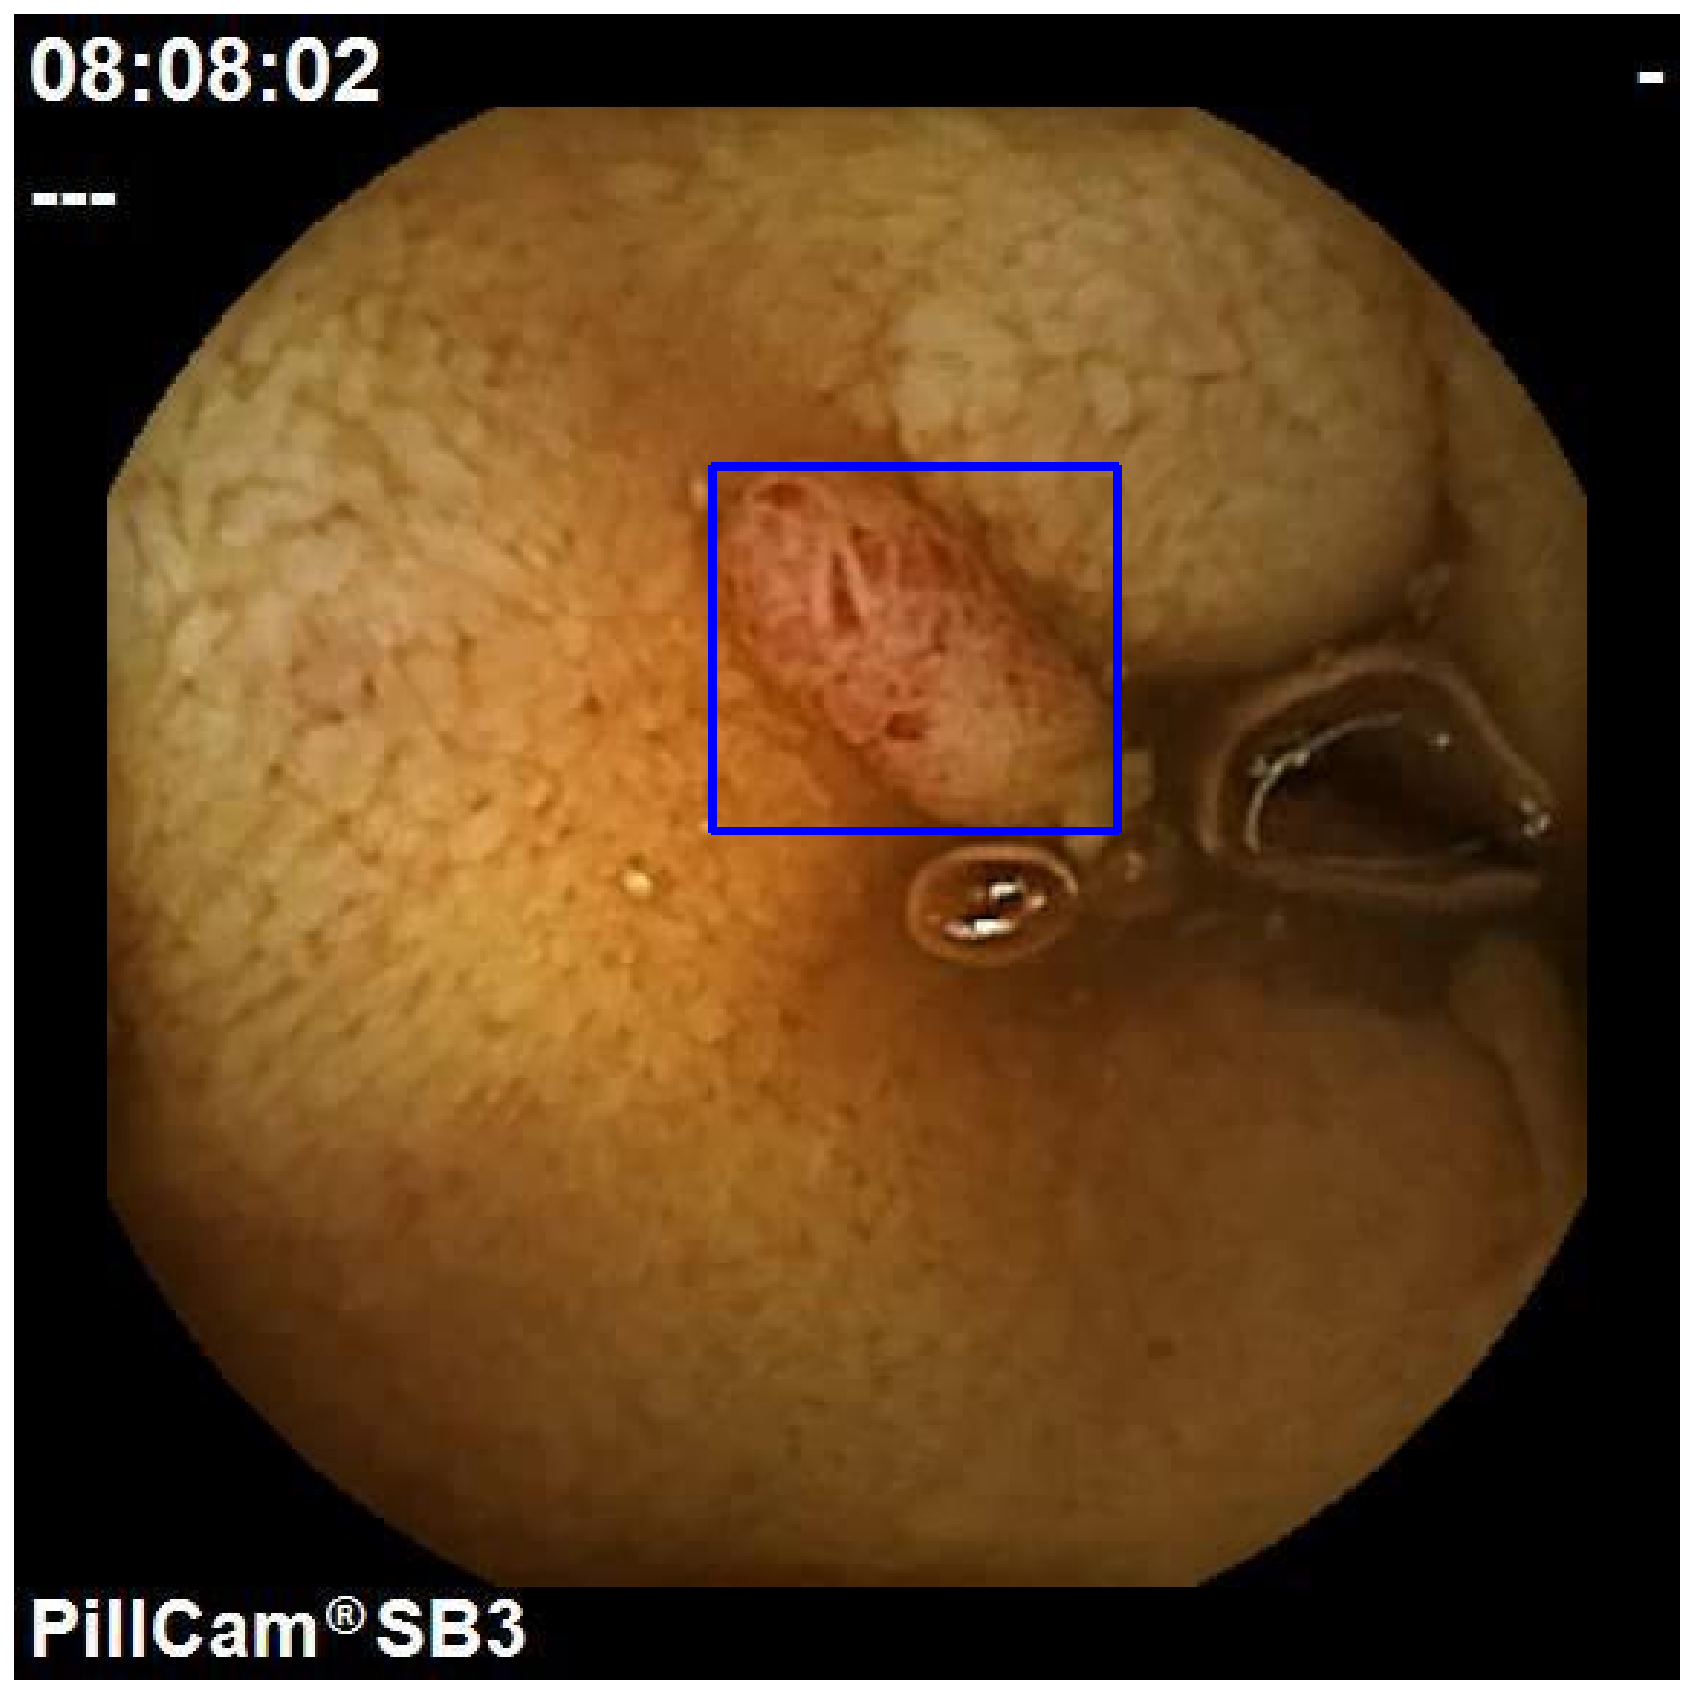

In [ ]:
bleeding_df=train_df[train_df['class_id']==4]


for i,k in enumerate(bleeding_df.iloc):
  if(i==1): break
  print(k[3:7],k['file_name'])  


show_image(form, bbox=BBox)

# 증강 보여주깅
def show_augmented(augmentation, image, bbox):
  # 증강 함수 틀
  augmented = augmentation(image=image, bboxes=[bbox], field_id=['4'])
  # 이미지 보여주는 함수
  show_image(augmented['image'], augmented['bboxes'][0])


x_min    254.1511
y_min    159.6917
x_max    357.0288
y_max    254.6557
Name: 4, dtype: object train_100004.jpg


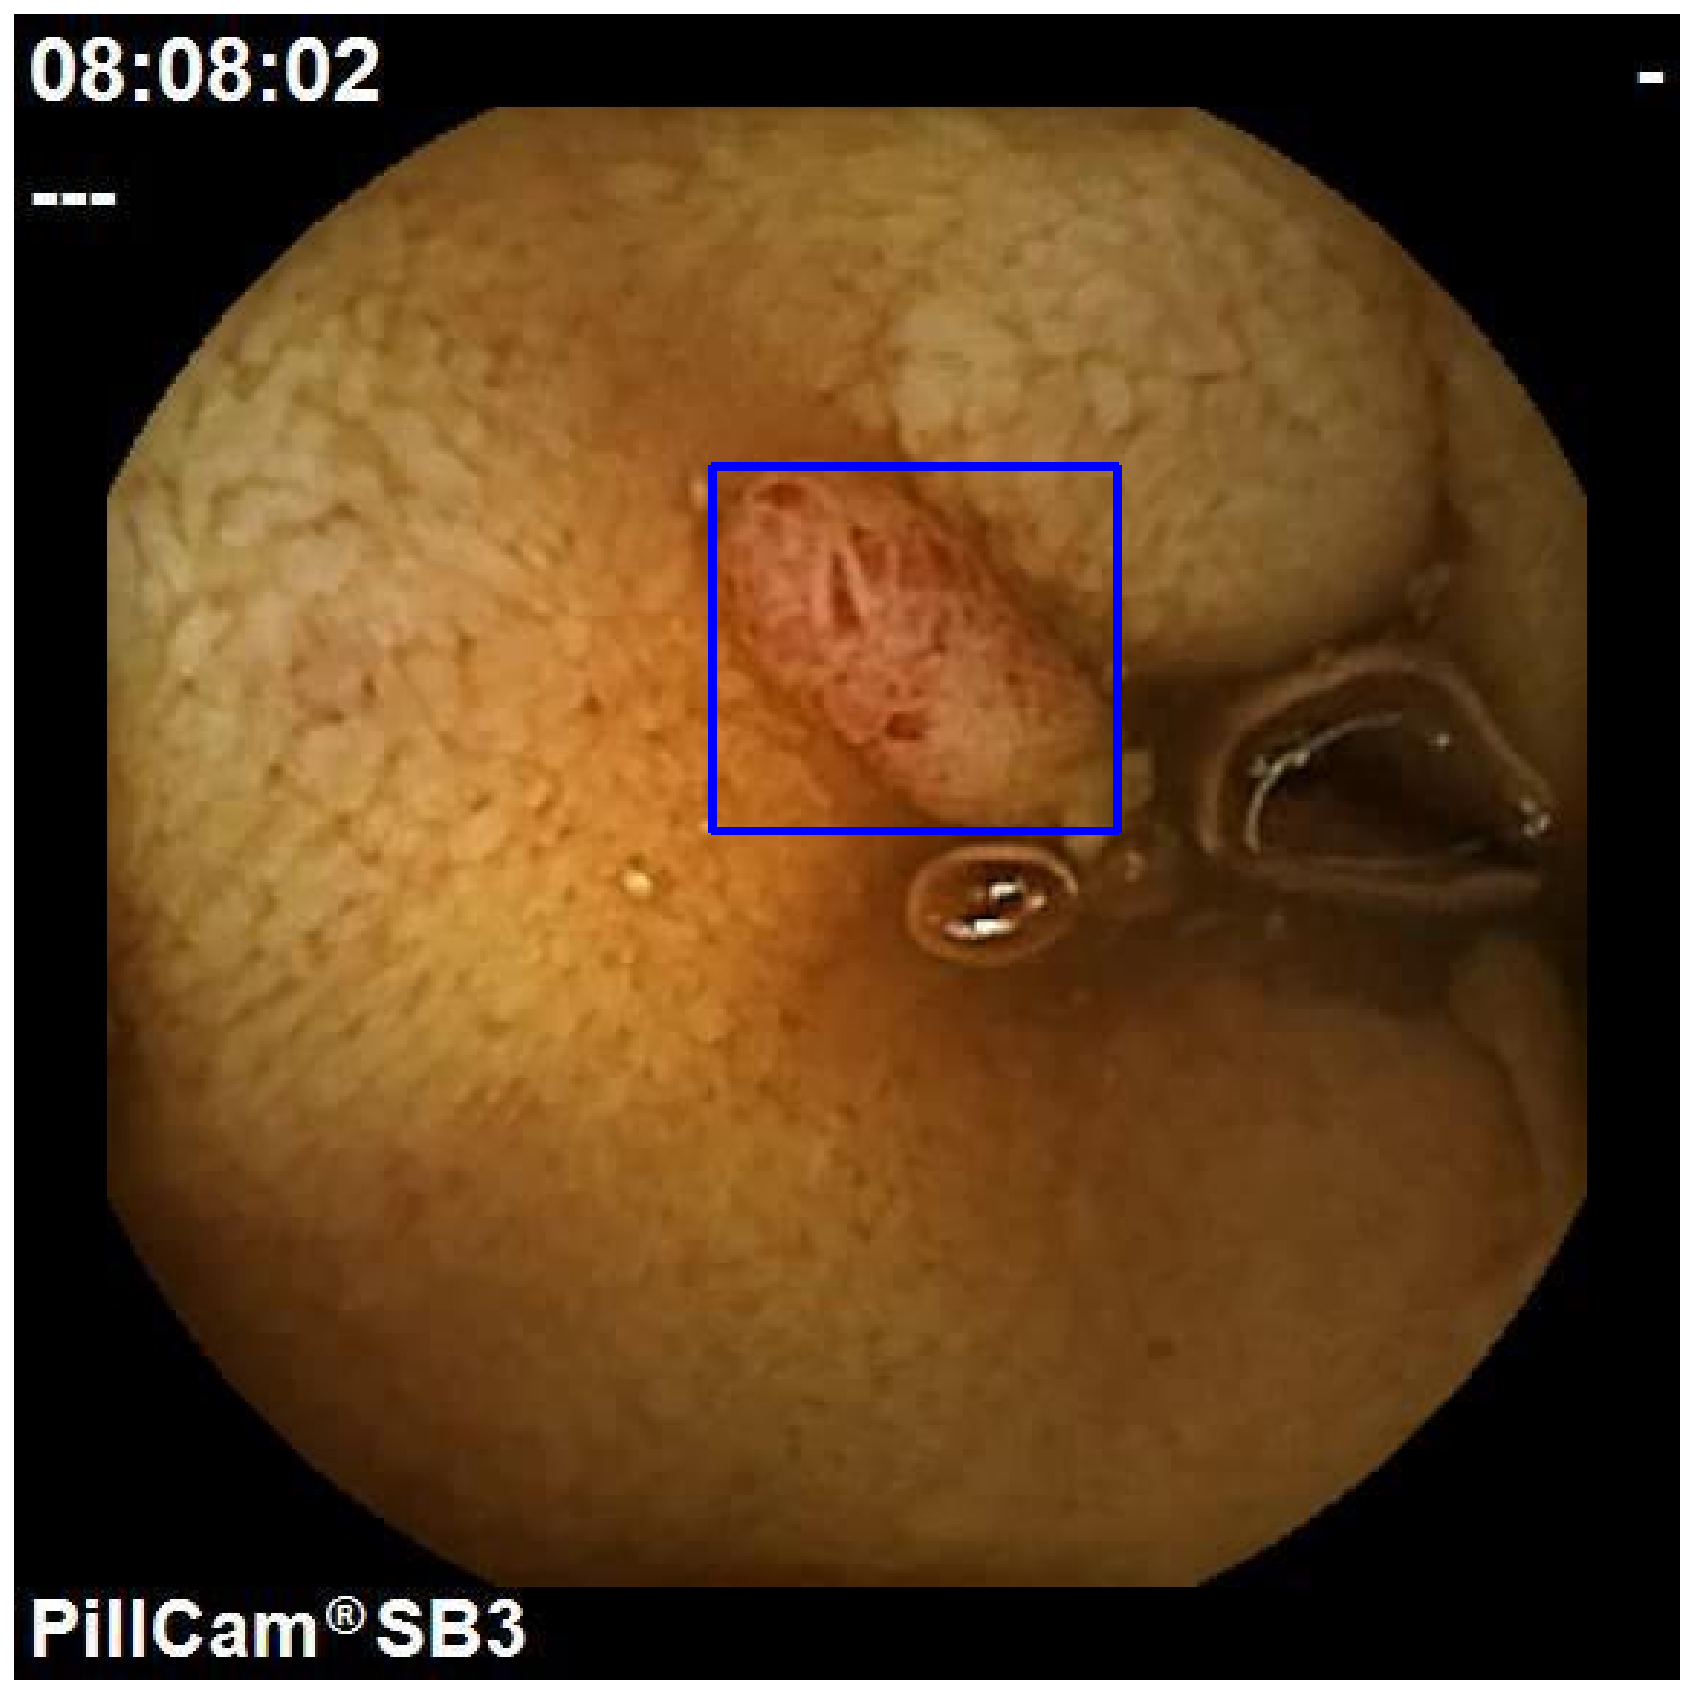

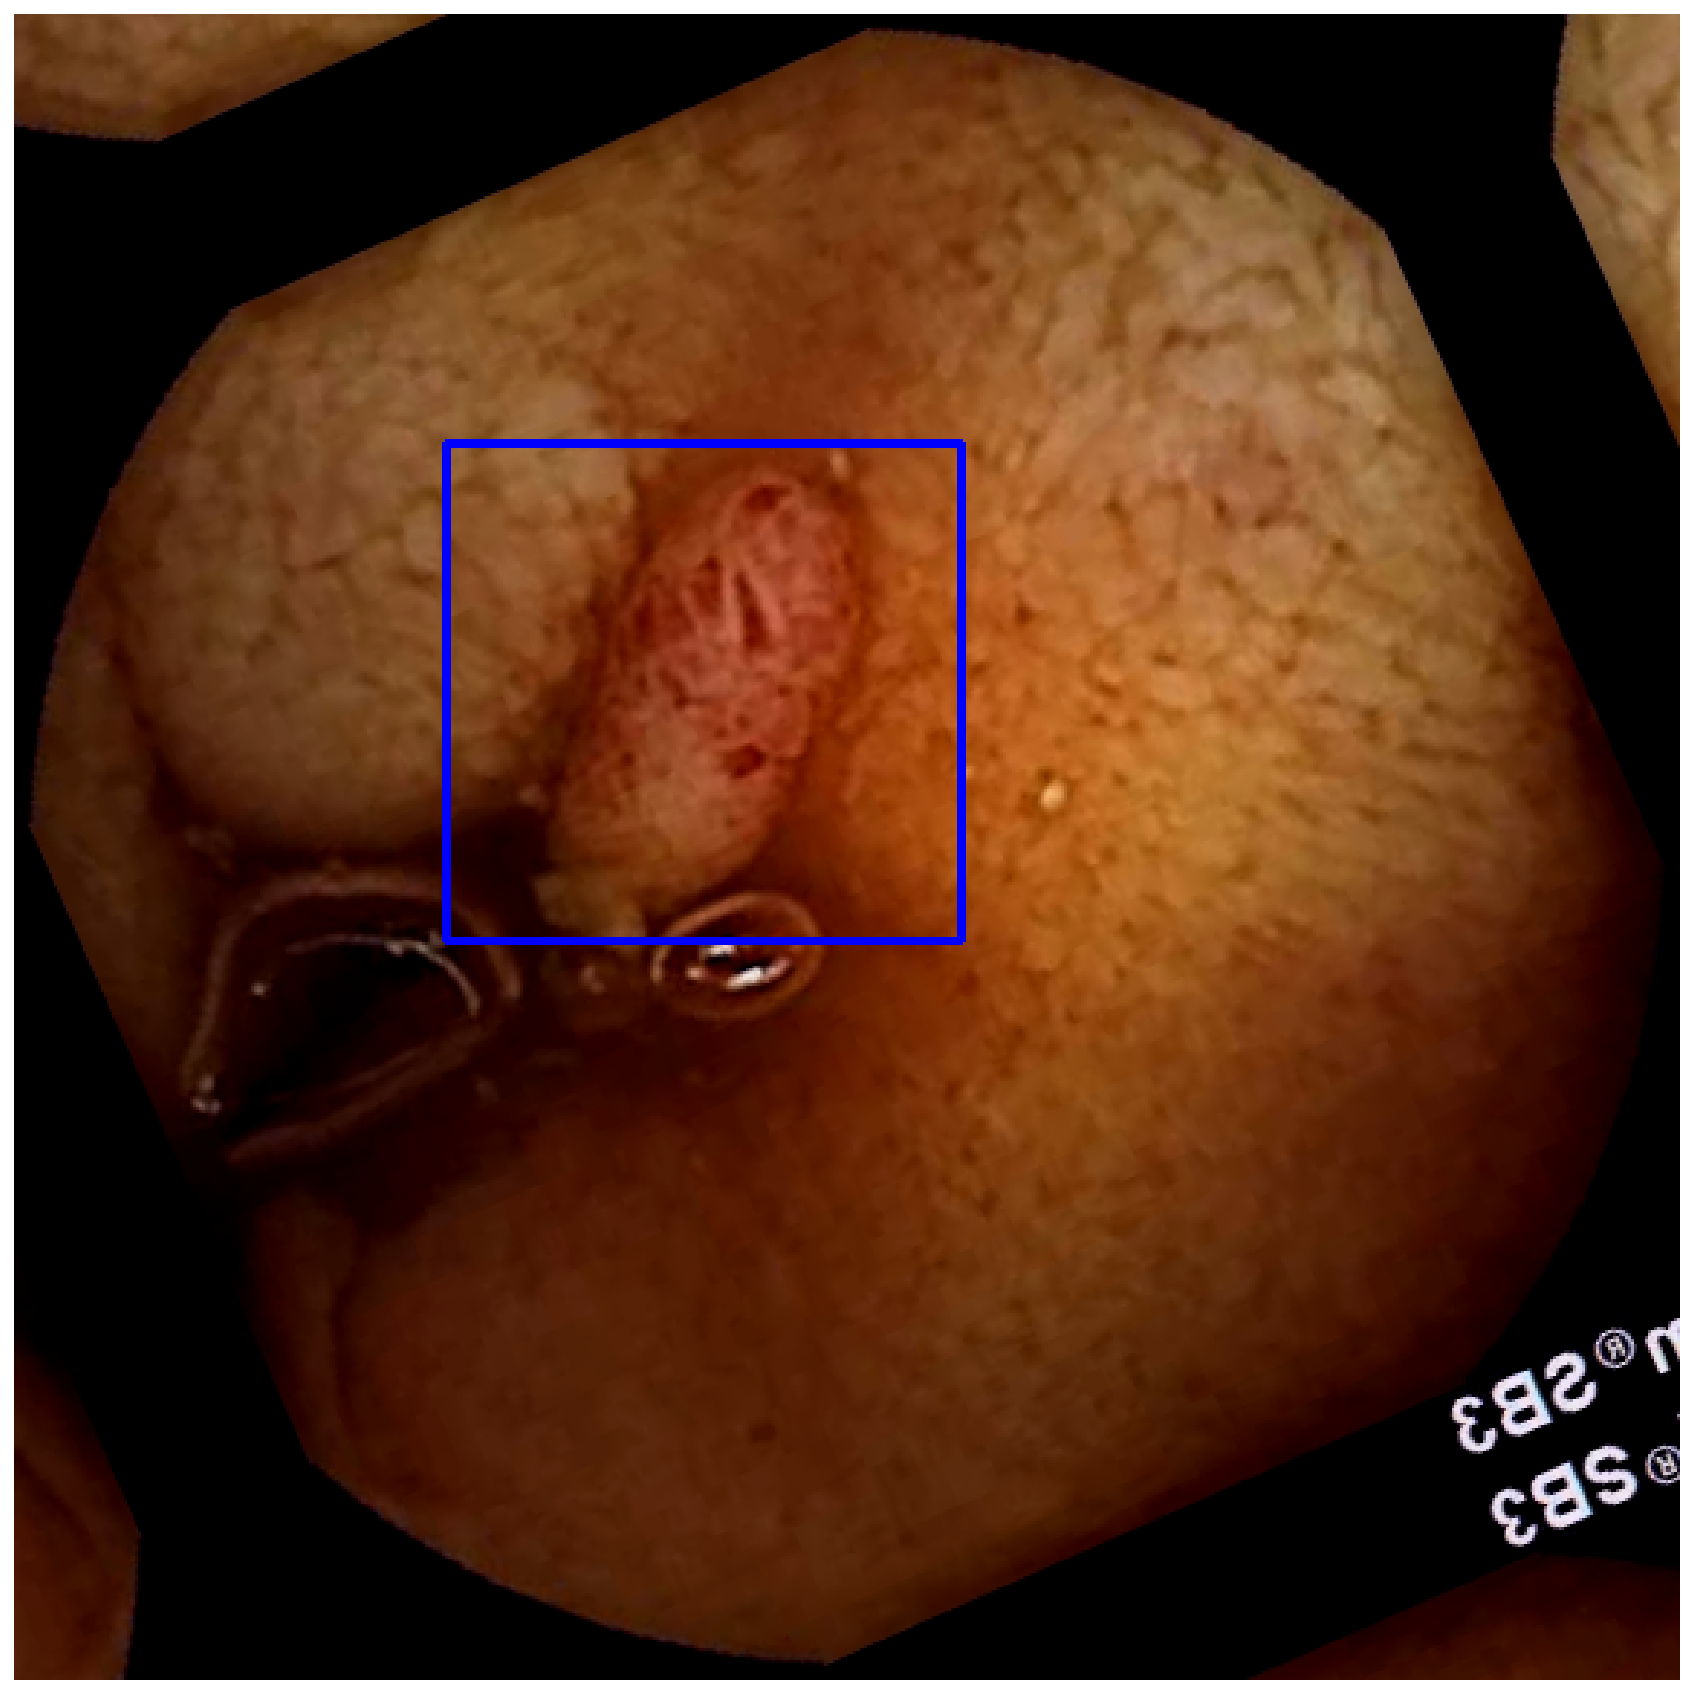

0it [00:00, ?it/s]

train_100004.jpg [254.1511, 159.6917, 357.0288, 254.6557]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100004.jpg



100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


train_100009.jpg [114.0478, 67.0049, 302.7849, 236.9436]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100009.jpg



100%|██████████| 1/1 [00:00<00:00, 16.60it/s]
2it [00:00, 12.97it/s]

train_100010.jpg [323.2151, 212.9032, 406.5484, 353.7634]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100010.jpg



100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


train_100012.jpg [51.6984, 186.5714, 99.3175, 269.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100012.jpg



100%|██████████| 1/1 [00:00<00:00, 13.72it/s]
4it [00:00, 12.25it/s]

train_100014.jpg [230.7544, 474.4386, 337.7719, 543.7368]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100014.jpg



100%|██████████| 1/1 [00:00<00:00, 52.36it/s]


train_100021.jpg [313.0, 67.6667, 417.0, 139.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100021.jpg



100%|██████████| 1/1 [00:00<00:00, 54.30it/s]


train_100022.jpg [215.6939, 136.415, 293.2449, 237.0952]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100022.jpg



100%|██████████| 1/1 [00:00<00:00, 52.44it/s]


train_100024.jpg [277.7108, 337.0361, 351.8072, 417.1566]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100024.jpg



100%|██████████| 1/1 [00:00<00:00, 65.03it/s]
8it [00:00, 19.91it/s]

train_100026.jpg [253.012, 80.4096, 354.2169, 326.7952]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100026.jpg



100%|██████████| 1/1 [00:00<00:00, 56.94it/s]


train_100026.jpg [172.2892, 325.5904, 214.4578, 398.4819]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100026.jpg



100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


train_100027.jpg [308.0909, 308.6364, 380.2121, 470.4545]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100027.jpg



100%|██████████| 1/1 [00:00<00:00, 61.47it/s]
11it [00:00, 19.76it/s]

train_100028.jpg [372.2156, 91.018, 413.5329, 149.1018]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100028.jpg



100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


train_100034.jpg [256.2222, 237.7778, 486.4444, 353.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100034.jpg



100%|██████████| 1/1 [00:00<00:00, 64.10it/s]


train_100038.jpg [145.4444, 400.4444, 234.7778, 487.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100038.jpg



100%|██████████| 1/1 [00:00<00:00, 59.60it/s]
14it [00:00, 20.32it/s]

train_100040.jpg [255.2781, 64.497, 396.6982, 153.2544]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100040.jpg



100%|██████████| 1/1 [00:00<00:00, 63.81it/s]


train_100043.jpg [96.1264, 344.2414, 145.5517, 392.5172]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100043.jpg



100%|██████████| 1/1 [00:00<00:00, 56.90it/s]


train_100049.jpg [507.2353, 271.8235, 539.0, 310.6471]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100049.jpg



100%|██████████| 1/1 [00:00<00:00, 55.01it/s]


train_100050.jpg [41.7123, 53.4247, 183.4932, 206.1644]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100050.jpg



100%|██████████| 1/1 [00:00<00:00, 48.05it/s]
18it [00:00, 24.06it/s]

train_100056.jpg [81.8898, 216.2835, 193.7008, 336.7559]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100056.jpg



100%|██████████| 1/1 [00:00<00:00, 61.01it/s]


train_100059.jpg [313.7143, 186.6995, 438.3448, 294.5813]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100059.jpg



100%|██████████| 1/1 [00:00<00:00, 55.78it/s]


train_100059.jpg [209.2808, 259.6059, 271.3498, 310.8374]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100059.jpg



100%|██████████| 1/1 [00:00<00:00, 42.80it/s]
21it [00:00, 25.51it/s]

train_100061.jpg [335.3136, 346.1538, 428.213, 496.4497]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100061.jpg



100%|██████████| 1/1 [00:00<00:00, 69.51it/s]


train_100062.jpg [85.3333, 336.3333, 150.0, 389.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100062.jpg



100%|██████████| 1/1 [00:00<00:00, 56.58it/s]


train_100065.jpg [372.8144, 176.0479, 468.024, 316.1677]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100065.jpg



100%|██████████| 1/1 [00:00<00:00, 56.65it/s]
24it [00:01, 26.43it/s]

train_100076.jpg [386.1471, 92.6471, 467.0294, 210.2941]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100076.jpg



100%|██████████| 1/1 [00:00<00:00, 14.45it/s]


train_100087.jpg [231.4961, 394.2362, 270.0787, 432.0315]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100087.jpg



100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


train_100096.jpg [430.0345, 191.1034, 491.2414, 279.0345]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100096.jpg



100%|██████████| 1/1 [00:00<00:00, 61.43it/s]
27it [00:01, 21.72it/s]

train_100098.jpg [250.1675, 317.2414, 340.3153, 419.7044]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100098.jpg



100%|██████████| 1/1 [00:00<00:00, 49.25it/s]


train_100098.jpg [350.1675, 246.798, 478.2463, 373.8916]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100098.jpg



100%|██████████| 1/1 [00:00<00:00, 54.93it/s]


train_100106.jpg [336.2222, 256.0, 448.2222, 381.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100106.jpg



100%|██████████| 1/1 [00:00<00:00, 14.33it/s]
30it [00:01, 21.13it/s]

train_100107.jpg [114.7368, 64.1053, 146.3158, 113.5789]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100107.jpg



100%|██████████| 1/1 [00:00<00:00, 65.94it/s]


train_100109.jpg [136.9241, 214.8408, 187.5735, 244.2781]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100109.jpg



100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


train_100114.jpg [161.4624, 362.9032, 237.8065, 424.1935]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100114.jpg



100%|██████████| 1/1 [00:00<00:00, 13.86it/s]
33it [00:01, 19.12it/s]

train_100115.jpg [97.3653, 110.1796, 165.6287, 177.8443]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100115.jpg



100%|██████████| 1/1 [00:00<00:00, 52.00it/s]


train_100115.jpg [203.3533, 91.6168, 267.4251, 153.2934]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100115.jpg



100%|██████████| 1/1 [00:00<00:00, 54.14it/s]


train_100119.jpg [289.759, 473.747, 357.2289, 544.2289]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100119.jpg



100%|██████████| 1/1 [00:00<00:00, 56.58it/s]


train_100119.jpg [395.1807, 438.2048, 482.5301, 488.2048]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100119.jpg



100%|██████████| 1/1 [00:00<00:00, 50.94it/s]
37it [00:01, 22.33it/s]

train_100120.jpg [191.578, 301.0459, 272.3119, 366.1835]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100120.jpg



100%|██████████| 1/1 [00:00<00:00, 59.16it/s]


train_100121.jpg [459.3333, 271.5556, 514.8889, 338.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100121.jpg



100%|██████████| 1/1 [00:00<00:00, 64.19it/s]


train_100123.jpg [164.1791, 227.6119, 225.3731, 269.403]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100123.jpg



100%|██████████| 1/1 [00:00<00:00, 55.16it/s]


train_100130.jpg [350.3514, 262.973, 421.1622, 323.5135]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100130.jpg



100%|██████████| 1/1 [00:00<00:00, 63.83it/s]
41it [00:01, 25.10it/s]

train_100131.jpg [447.2441, 272.9764, 494.4882, 393.4488]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100131.jpg



100%|██████████| 1/1 [00:00<00:00, 53.42it/s]


train_100135.jpg [271.0, 102.3333, 403.6667, 173.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100135.jpg



100%|██████████| 1/1 [00:00<00:00, 55.92it/s]


train_100135.jpg [33.0, 104.3333, 205.0, 207.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100135.jpg



100%|██████████| 1/1 [00:00<00:00, 53.52it/s]
44it [00:01, 25.85it/s]

train_100149.jpg [221.9825, 399.0, 348.2982, 527.0702]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100149.jpg



100%|██████████| 1/1 [00:00<00:00, 54.88it/s]


train_100159.jpg [354.8623, 107.7844, 505.1617, 149.1018]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100159.jpg



100%|██████████| 1/1 [00:00<00:00, 81.41it/s]


train_100160.jpg [457.2192, 392.6712, 503.7945, 452.2603]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100160.jpg



100%|██████████| 1/1 [00:00<00:00, 13.68it/s]
47it [00:02, 24.11it/s]

train_100164.jpg [246.4371, 32.9341, 542.8443, 262.8743]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100164.jpg



100%|██████████| 1/1 [00:00<00:00, 51.58it/s]


train_100165.jpg [108.9412, 172.0588, 392.0294, 271.3235]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100165.jpg



100%|██████████| 1/1 [00:00<00:00, 52.80it/s]


train_100166.jpg [408.7379, 239.6505, 456.3107, 338.6796]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100166.jpg



100%|██████████| 1/1 [00:00<00:00, 45.66it/s]


train_100176.jpg [233.6667, 48.3333, 369.0, 138.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100176.jpg



100%|██████████| 1/1 [00:00<00:00, 59.55it/s]
51it [00:02, 25.99it/s]

train_100177.jpg [59.6386, 178.0, 108.4337, 248.4819]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100177.jpg



100%|██████████| 1/1 [00:00<00:00, 58.09it/s]


train_100178.jpg [211.0769, 486.9822, 315.8107, 535.503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100178.jpg



100%|██████████| 1/1 [00:00<00:00, 72.10it/s]


train_100179.jpg [291.7692, 243.1953, 357.4497, 304.142]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100179.jpg



100%|██████████| 1/1 [00:00<00:00, 52.95it/s]


train_100182.jpg [432.2222, 266.6667, 527.7778, 390.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100182.jpg



100%|██████████| 1/1 [00:00<00:00, 77.66it/s]
55it [00:02, 28.39it/s]

train_100183.jpg [268.8679, 239.7736, 333.0189, 307.6981]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100183.jpg



100%|██████████| 1/1 [00:00<00:00, 63.30it/s]


train_100184.jpg [229.9435, 89.8983, 267.7966, 115.887]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100184.jpg



100%|██████████| 1/1 [00:00<00:00, 87.05it/s]


train_100190.jpg [233.1325, 373.1807, 399.3976, 467.1566]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100190.jpg



100%|██████████| 1/1 [00:00<00:00, 51.33it/s]


train_100190.jpg [216.2651, 127.3976, 306.6265, 217.759]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100190.jpg



100%|██████████| 1/1 [00:00<00:00, 67.22it/s]
59it [00:02, 30.42it/s]

train_100204.jpg [146.3855, 455.1084, 219.2771, 522.5783]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100204.jpg



100%|██████████| 1/1 [00:00<00:00, 48.35it/s]


train_100205.jpg [79.6514, 201.9633, 245.7064, 329.4862]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100205.jpg



100%|██████████| 1/1 [00:00<00:00, 26.28it/s]


train_100218.jpg [166.2275, 326.3473, 208.1437, 365.2695]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100218.jpg



100%|██████████| 1/1 [00:00<00:00, 26.41it/s]


train_100220.jpg [316.7647, 356.3725, 355.0, 396.5686]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100220.jpg



100%|██████████| 1/1 [00:00<00:00, 43.67it/s]
63it [00:02, 27.35it/s]

train_100222.jpg [253.7941, 375.0, 502.3235, 468.3824]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100222.jpg



100%|██████████| 1/1 [00:00<00:00, 61.25it/s]


train_100228.jpg [296.3855, 72.5783, 505.4217, 302.0964]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100228.jpg



100%|██████████| 1/1 [00:00<00:00, 60.07it/s]


train_100230.jpg [467.1034, 340.2414, 535.2069, 441.1034]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100230.jpg



100%|██████████| 1/1 [00:00<00:00, 14.58it/s]
66it [00:02, 25.46it/s]

train_100236.jpg [194.2222, 180.8889, 248.8889, 232.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100236.jpg



100%|██████████| 1/1 [00:00<00:00, 53.88it/s]


train_100238.jpg [103.8824, 290.563, 147.5798, 326.6975]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100238.jpg



100%|██████████| 1/1 [00:00<00:00, 58.23it/s]


train_100240.jpg [221.1111, 37.7778, 353.5556, 104.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100240.jpg



100%|██████████| 1/1 [00:00<00:00, 56.27it/s]


train_100246.jpg [430.8966, 240.2414, 472.2759, 290.2414]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100246.jpg



100%|██████████| 1/1 [00:00<00:00, 58.25it/s]
70it [00:02, 27.51it/s]

train_100255.jpg [116.9688, 231.5312, 205.25, 366.6875]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100255.jpg



100%|██████████| 1/1 [00:00<00:00, 59.15it/s]


train_100257.jpg [235.2, 472.4, 292.8, 520.4]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100257.jpg



100%|██████████| 1/1 [00:00<00:00, 56.59it/s]


train_100261.jpg [230.8889, 413.3333, 310.8889, 507.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100261.jpg



100%|██████████| 1/1 [00:00<00:00, 51.71it/s]


train_100261.jpg [170.8889, 89.7778, 221.1111, 159.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100261.jpg



100%|██████████| 1/1 [00:00<00:00, 56.97it/s]
74it [00:03, 28.73it/s]

train_100263.jpg [428.0592, 200.5917, 500.2485, 269.2308]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100263.jpg



100%|██████████| 1/1 [00:00<00:00, 54.37it/s]


train_100265.jpg [88.1566, 227.9157, 294.1807, 532.7349]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100265.jpg



100%|██████████| 1/1 [00:00<00:00, 45.95it/s]


train_100266.jpg [246.4671, 368.2635, 340.479, 446.7066]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100266.jpg



100%|██████████| 1/1 [00:00<00:00, 76.58it/s]


train_100267.jpg [42.3333, 147.0, 119.6667, 249.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100267.jpg



100%|██████████| 1/1 [00:00<00:00, 63.20it/s]
78it [00:03, 30.03it/s]

train_100275.jpg [334.0575, 271.8276, 370.2644, 317.2299]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100275.jpg



100%|██████████| 1/1 [00:00<00:00, 88.60it/s]


train_100279.jpg [230.8982, 171.2575, 280.0, 220.3593]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100279.jpg



100%|██████████| 1/1 [00:00<00:00, 27.41it/s]


train_100280.jpg [360.1765, 423.5882, 469.5882, 536.5294]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100280.jpg



100%|██████████| 1/1 [00:00<00:00, 58.27it/s]


train_100283.jpg [259.0361, 312.9398, 339.1566, 420.1687]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100283.jpg



100%|██████████| 1/1 [00:00<00:00, 65.73it/s]
82it [00:03, 30.27it/s]

train_100284.jpg [415.8605, 450.6744, 514.6977, 523.3488]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100284.jpg



100%|██████████| 1/1 [00:00<00:00, 73.60it/s]


train_100288.jpg [417.4083, 189.9408, 515.6331, 286.3905]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100288.jpg



100%|██████████| 1/1 [00:00<00:00, 56.99it/s]


train_100289.jpg [213.6627, 340.8284, 275.2012, 420.7101]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100289.jpg



100%|██████████| 1/1 [00:00<00:00, 49.82it/s]


train_100290.jpg [359.0, 363.0, 480.0, 403.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100290.jpg



100%|██████████| 1/1 [00:00<00:00, 14.70it/s]
86it [00:03, 27.80it/s]

train_100301.jpg [185.3593, 88.6228, 275.7784, 168.8623]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100301.jpg



100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


train_100301.jpg [215.2994, 163.4731, 359.6108, 357.485]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100301.jpg



100%|██████████| 1/1 [00:00<00:00, 64.03it/s]


train_100306.jpg [150.9412, 430.0588, 300.521, 543.5042]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100306.jpg



100%|██████████| 1/1 [00:00<00:00, 63.70it/s]
89it [00:03, 25.86it/s]

train_100307.jpg [298.9568, 143.8849, 354.3525, 223.0216]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100307.jpg



100%|██████████| 1/1 [00:00<00:00, 76.91it/s]


train_100312.jpg [351.7132, 349.6279, 388.1473, 376.7597]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100312.jpg



100%|██████████| 1/1 [00:00<00:00, 65.39it/s]


train_100318.jpg [239.7692, 313.0769, 309.7692, 381.5385]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100318.jpg



100%|██████████| 1/1 [00:00<00:00, 63.98it/s]


train_100325.jpg [306.9762, 249.4048, 333.7619, 273.2143]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100325.jpg



100%|██████████| 1/1 [00:00<00:00, 53.91it/s]
93it [00:03, 27.98it/s]

train_100327.jpg [129.9328, 56.9496, 261.8655, 174.5966]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100327.jpg



100%|██████████| 1/1 [00:00<00:00, 58.51it/s]


train_100334.jpg [266.3158, 221.2632, 358.9474, 286.5263]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100334.jpg



100%|██████████| 1/1 [00:00<00:00, 14.26it/s]


train_100338.jpg [373.1379, 230.7586, 449.0, 310.931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100338.jpg



100%|██████████| 1/1 [00:00<00:00, 14.55it/s]
96it [00:03, 23.02it/s]

train_100340.jpg [314.3846, 358.6923, 435.9231, 476.3846]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100340.jpg



100%|██████████| 1/1 [00:00<00:00, 56.92it/s]


train_100344.jpg [212.4179, 185.4478, 247.4925, 224.6269]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100344.jpg



100%|██████████| 1/1 [00:00<00:00, 80.62it/s]


train_100345.jpg [348.3151, 509.1096, 424.3425, 541.3014]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100345.jpg



100%|██████████| 1/1 [00:00<00:00, 26.37it/s]
99it [00:04, 24.11it/s]

train_100371.jpg [268.6871, 32.3333, 407.4626, 127.5714]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100371.jpg



100%|██████████| 1/1 [00:00<00:00, 57.82it/s]


train_100372.jpg [497.2759, 353.1724, 524.0, 386.7931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100372.jpg



100%|██████████| 1/1 [00:00<00:00, 67.48it/s]


train_100376.jpg [161.8084, 308.3832, 214.503, 371.2575]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100376.jpg



100%|██████████| 1/1 [00:00<00:00, 68.23it/s]


train_100392.jpg [153.3333, 383.5556, 210.6667, 436.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100392.jpg



100%|██████████| 1/1 [00:00<00:00, 50.68it/s]
103it [00:04, 26.59it/s]

train_100394.jpg [290.8889, 39.5556, 441.1111, 153.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100394.jpg



100%|██████████| 1/1 [00:00<00:00, 54.69it/s]


train_100401.jpg [269.7692, 171.0, 374.3846, 266.3846]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100401.jpg



100%|██████████| 1/1 [00:00<00:00, 59.32it/s]


train_100407.jpg [208.0357, 161.3571, 289.2857, 289.0357]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100407.jpg



100%|██████████| 1/1 [00:00<00:00, 15.27it/s]
106it [00:04, 25.06it/s]

train_100416.jpg [434.491, 344.9102, 475.2096, 384.4311]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100416.jpg



100%|██████████| 1/1 [00:00<00:00, 55.33it/s]


train_100421.jpg [318.8895, 287.5801, 457.5635, 362.7182]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100421.jpg



100%|██████████| 1/1 [00:00<00:00, 61.23it/s]


train_100421.jpg [265.8508, 130.674, 316.6796, 218.5193]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100421.jpg



100%|██████████| 1/1 [00:00<00:00, 14.86it/s]
109it [00:04, 23.80it/s]

train_100429.jpg [236.6555, 459.4706, 315.6471, 544.3445]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100429.jpg



100%|██████████| 1/1 [00:00<00:00, 42.09it/s]


train_100438.jpg [34.8571, 331.8571, 67.4286, 376.4286]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100438.jpg



100%|██████████| 1/1 [00:00<00:00, 59.66it/s]


train_100440.jpg [208.7425, 330.5389, 284.1916, 417.9641]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100440.jpg



100%|██████████| 1/1 [00:00<00:00, 65.54it/s]


train_100448.jpg [478.1737, 240.1198, 515.8982, 281.4371]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100448.jpg



100%|██████████| 1/1 [00:00<00:00, 68.76it/s]
113it [00:04, 26.04it/s]

train_100452.jpg [332.8889, 155.1111, 476.8889, 247.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100452.jpg



100%|██████████| 1/1 [00:00<00:00, 61.29it/s]


train_100455.jpg [280.6216, 43.9459, 400.0811, 138.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100455.jpg



100%|██████████| 1/1 [00:00<00:00, 47.35it/s]


train_100461.jpg [184.4444, 398.2222, 279.1111, 457.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100461.jpg



100%|██████████| 1/1 [00:00<00:00, 13.58it/s]
116it [00:04, 23.92it/s]

train_100464.jpg [284.4012, 210.7784, 322.1257, 256.2874]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100464.jpg



100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


train_100467.jpg [212.2511, 414.2857, 355.5411, 508.2251]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100467.jpg



100%|██████████| 1/1 [00:00<00:00, 56.93it/s]


train_100470.jpg [246.5677, 188.1844, 398.4409, 312.1037]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100470.jpg



100%|██████████| 1/1 [00:00<00:00, 49.58it/s]
119it [00:04, 22.39it/s]

train_100475.jpg [41.4029, 313.6691, 87.446, 382.7338]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100475.jpg



100%|██████████| 1/1 [00:00<00:00, 57.64it/s]


train_100476.jpg [165.1358, 237.7778, 241.1852, 310.1235]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100476.jpg



100%|██████████| 1/1 [00:00<00:00, 92.31it/s]


train_100478.jpg [317.3277, 114.9328, 366.9076, 149.3866]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100478.jpg



100%|██████████| 1/1 [00:00<00:00, 61.08it/s]


train_100479.jpg [118.4516, 229.5699, 198.0215, 320.9677]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100479.jpg



100%|██████████| 1/1 [00:00<00:00, 14.59it/s]
123it [00:05, 23.19it/s]

train_100481.jpg [312.7273, 340.3636, 359.5455, 369.4545]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100481.jpg



100%|██████████| 1/1 [00:00<00:00, 53.44it/s]


train_100485.jpg [221.0, 35.6667, 338.3333, 109.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100485.jpg



100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


train_100492.jpg [463.7778, 268.0, 541.1111, 404.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100492.jpg



100%|██████████| 1/1 [00:00<00:00, 76.58it/s]
126it [00:05, 22.59it/s]

train_100492.jpg [310.8889, 75.5556, 419.7778, 252.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100492.jpg



100%|██████████| 1/1 [00:00<00:00, 53.49it/s]


train_100497.jpg [120.9091, 134.0, 175.0, 227.1818]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100497.jpg



100%|██████████| 1/1 [00:00<00:00, 59.43it/s]


train_100517.jpg [380.7219, 239.645, 503.2071, 353.2544]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100517.jpg



100%|██████████| 1/1 [00:00<00:00, 64.93it/s]


train_100523.jpg [155.432, 189.3491, 204.5444, 236.6864]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100523.jpg



100%|██████████| 1/1 [00:00<00:00, 14.34it/s]
130it [00:05, 22.75it/s]

train_100535.jpg [245.0473, 432.5444, 281.7337, 462.7219]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100535.jpg



100%|██████████| 1/1 [00:00<00:00, 56.87it/s]


train_100543.jpg [239.0539, 254.491, 355.2216, 407.7844]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100543.jpg



100%|██████████| 1/1 [00:00<00:00, 56.39it/s]


train_100543.jpg [397.1377, 415.5689, 442.6467, 458.0838]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100543.jpg



100%|██████████| 1/1 [00:00<00:00, 58.17it/s]


train_100546.jpg [196.3855, 126.1928, 298.7952, 230.4096]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100546.jpg



100%|██████████| 1/1 [00:00<00:00, 65.03it/s]
134it [00:05, 25.33it/s]

train_100549.jpg [233.9042, 199.4012, 357.2575, 335.3293]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100549.jpg



100%|██████████| 1/1 [00:00<00:00, 59.05it/s]


train_100549.jpg [408.1557, 131.7365, 514.1437, 249.7006]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100549.jpg



100%|██████████| 1/1 [00:00<00:00, 59.20it/s]


train_100552.jpg [385.9919, 452.0488, 433.9593, 487.0081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100552.jpg



100%|██████████| 1/1 [00:00<00:00, 11.27it/s]
137it [00:05, 23.10it/s]

train_100554.jpg [56.6265, 88.8434, 270.4819, 386.4337]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100554.jpg



100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


train_100555.jpg [270.4, 110.8, 332.8, 146.8]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100555.jpg



100%|██████████| 1/1 [00:00<00:00, 61.02it/s]


train_100556.jpg [32.0118, 162.7402, 116.0355, 376.9231]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100556.jpg



100%|██████████| 1/1 [00:00<00:00, 60.17it/s]
140it [00:05, 21.99it/s]

train_100557.jpg [60.4083, 229.5858, 127.8639, 317.1598]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100557.jpg



100%|██████████| 1/1 [00:00<00:00, 95.81it/s]


train_100560.jpg [168.3941, 200.0, 247.2118, 284.7291]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100560.jpg



100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


train_100560.jpg [103.3695, 298.5222, 210.266, 351.7241]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100560.jpg



100%|██████████| 1/1 [00:00<00:00, 56.25it/s]
143it [00:05, 22.08it/s]

train_100562.jpg [45.5224, 142.5373, 124.6269, 214.1791]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100562.jpg



100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


train_100565.jpg [36.4444, 301.3333, 133.7778, 414.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100565.jpg



100%|██████████| 1/1 [00:00<00:00, 52.60it/s]


train_100568.jpg [437.8058, 391.3669, 514.7842, 476.259]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100568.jpg



100%|██████████| 1/1 [00:00<00:00, 54.33it/s]
146it [00:06, 21.41it/s]

train_100569.jpg [451.3333, 267.5556, 529.1111, 403.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100569.jpg



100%|██████████| 1/1 [00:00<00:00, 14.36it/s]


train_100571.jpg [191.7692, 66.8639, 285.8521, 157.3964]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100571.jpg



100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


train_100578.jpg [137.8065, 280.6452, 215.7634, 354.3011]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100578.jpg



100%|██████████| 1/1 [00:00<00:00, 64.77it/s]
149it [00:06, 18.91it/s]

train_100579.jpg [455.0, 194.0, 512.5, 260.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100579.jpg



100%|██████████| 1/1 [00:00<00:00, 45.99it/s]


train_100583.jpg [87.5, 201.5714, 186.1607, 270.3214]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100583.jpg



100%|██████████| 1/1 [00:00<00:00, 52.69it/s]


train_100583.jpg [164.2857, 432.375, 373.6607, 533.2679]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100583.jpg



100%|██████████| 1/1 [00:00<00:00, 14.55it/s]
152it [00:06, 19.21it/s]

train_100584.jpg [188.4, 311.8, 254.8, 370.2]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100584.jpg



100%|██████████| 1/1 [00:00<00:00, 55.70it/s]


train_100586.jpg [296.4729, 441.8719, 443.7635, 510.3448]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100586.jpg



100%|██████████| 1/1 [00:00<00:00, 25.92it/s]


train_100587.jpg [293.3007, 210.4575, 480.8824, 390.1961]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100587.jpg



100%|██████████| 1/1 [00:00<00:00, 58.91it/s]
155it [00:06, 20.89it/s]

train_100588.jpg [366.8161, 444.8161, 416.2414, 503.4368]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100588.jpg



100%|██████████| 1/1 [00:00<00:00, 15.08it/s]


train_100590.jpg [327.3054, 352.6946, 368.024, 390.4192]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100590.jpg



100%|██████████| 1/1 [00:00<00:00, 61.29it/s]


train_100604.jpg [182.8925, 365.6667, 293.6452, 443.086]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100604.jpg



100%|██████████| 1/1 [00:00<00:00, 82.79it/s]
158it [00:06, 21.31it/s]

train_100609.jpg [106.4034, 235.9412, 149.2605, 277.1176]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100609.jpg



100%|██████████| 1/1 [00:00<00:00, 43.12it/s]


train_100610.jpg [197.895, 144.1989, 294.5801, 266.2983]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100610.jpg



100%|██████████| 1/1 [00:00<00:00, 56.73it/s]

train_100624.jpg

 [295.6522, 158.5652, 393.1677, 328.1304]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100624.jpg



100%|██████████| 1/1 [00:00<00:00, 52.45it/s]
161it [00:06, 23.26it/s]

train_100629.jpg [122.1398, 252.7634, 213.0, 339.8602]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100629.jpg



100%|██████████| 1/1 [00:00<00:00, 51.10it/s]


train_100630.jpg [291.7692, 69.8225, 417.8047, 181.0651]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100630.jpg



100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


train_100633.jpg [111.4454, 347.7059, 236.6555, 435.1008]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100633.jpg



100%|██████████| 1/1 [00:00<00:00, 60.45it/s]
164it [00:06, 22.35it/s]

train_100636.jpg [167.4211, 396.7444, 211.0301, 449.3759]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100636.jpg



100%|██████████| 1/1 [00:00<00:00, 54.64it/s]


train_100639.jpg [446.8571, 150.5952, 490.3095, 194.6429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100639.jpg



100%|██████████| 1/1 [00:00<00:00, 75.70it/s]


train_100641.jpg [309.8889, 285.3333, 498.7778, 394.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100641.jpg



100%|██████████| 1/1 [00:00<00:00, 57.94it/s]


train_100649.jpg [85.5476, 461.9048, 144.4762, 526.1905]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100649.jpg



100%|██████████| 1/1 [00:00<00:00, 12.49it/s]
168it [00:07, 22.15it/s]

train_100659.jpg [268.8889, 321.3333, 342.2222, 369.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100659.jpg



100%|██████████| 1/1 [00:00<00:00, 66.50it/s]


train_100660.jpg [115.6667, 114.747, 355.7901, 410.2845]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100660.jpg



100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


train_100661.jpg [61.3728, 281.6568, 122.9112, 331.9527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100661.jpg



100%|██████████| 1/1 [00:00<00:00, 61.04it/s]
171it [00:07, 22.25it/s]

train_100664.jpg [406.2201, 355.0335, 540.6699, 480.8708]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100664.jpg



100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


train_100669.jpg [117.2821, 201.2564, 154.4615, 283.9487]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100669.jpg



100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


train_100670.jpg [210.6667, 79.1111, 265.7778, 124.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100670.jpg



100%|██████████| 1/1 [00:00<00:00, 14.73it/s]
174it [00:07, 17.46it/s]

train_100671.jpg [354.2941, 353.0, 409.5882, 403.5882]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100671.jpg



100%|██████████| 1/1 [00:00<00:00, 55.75it/s]


train_100671.jpg [420.1765, 309.4706, 440.1765, 336.5294]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100671.jpg



100%|██████████| 1/1 [00:00<00:00, 74.76it/s]


train_100675.jpg [322.8346, 76.126, 403.1496, 170.6142]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100675.jpg



100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


train_100676.jpg [157.2381, 373.5931, 226.5022, 429.4372]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100676.jpg



100%|██████████| 1/1 [00:00<00:00, 60.65it/s]
178it [00:07, 20.95it/s]

train_100679.jpg [104.7244, 309.9843, 188.9764, 435.9685]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100679.jpg



100%|██████████| 1/1 [00:00<00:00, 63.07it/s]


train_100680.jpg [303.8824, 45.1849, 419.8487, 201.4874]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100680.jpg



100%|██████████| 1/1 [00:00<00:00, 60.38it/s]


train_100681.jpg [169.0, 259.8462, 229.7692, 326.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100681.jpg



100%|██████████| 1/1 [00:00<00:00, 61.57it/s]


train_100682.jpg [354.717, 302.9811, 383.9623, 369.9623]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100682.jpg



100%|██████████| 1/1 [00:00<00:00, 62.19it/s]
182it [00:07, 23.47it/s]

train_100693.jpg [144.7773, 275.9231, 207.9352, 334.2227]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100693.jpg



100%|██████████| 1/1 [00:00<00:00, 51.81it/s]


train_100693.jpg [245.9919, 361.753, 373.9271, 521.6721]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100693.jpg



100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


train_100694.jpg [226.1078, 236.5269, 285.3892, 295.8084]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100694.jpg



100%|██████████| 1/1 [00:00<00:00, 46.25it/s]
185it [00:07, 22.20it/s]

train_100697.jpg [78.9592, 33.0136, 262.6327, 139.8163]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100697.jpg



100%|██████████| 1/1 [00:00<00:00, 67.47it/s]


train_100698.jpg [61.2388, 300.995, 146.8109, 402.4876]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100698.jpg



100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


train_100698.jpg [159.7463, 347.7612, 280.1443, 422.3881]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100698.jpg



100%|██████████| 1/1 [00:00<00:00, 52.04it/s]
188it [00:08, 21.83it/s]

train_100705.jpg [133.5946, 415.2973, 220.6216, 521.7838]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100705.jpg



100%|██████████| 1/1 [00:00<00:00, 27.77it/s]


train_100709.jpg [45.9349, 269.8225, 122.2663, 342.6036]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100709.jpg



100%|██████████| 1/1 [00:00<00:00, 47.00it/s]


train_100720.jpg [298.8403, 438.4622, 329.9328, 473.7563]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100720.jpg



100%|██████████| 1/1 [00:00<00:00, 58.62it/s]
191it [00:08, 23.06it/s]

train_100727.jpg [124.2609, 306.9565, 213.3913, 413.913]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100727.jpg



100%|██████████| 1/1 [00:00<00:00, 61.39it/s]


train_100727.jpg [236.4348, 268.2609, 302.9565, 316.087]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100727.jpg



100%|██████████| 1/1 [00:00<00:00, 49.89it/s]


train_100729.jpg [35.6559, 196.7742, 82.4301, 264.5161]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100729.jpg



100%|██████████| 1/1 [00:00<00:00, 81.14it/s]


train_100734.jpg [287.3846, 53.2544, 340.0473, 107.1006]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100734.jpg



100%|██████████| 1/1 [00:00<00:00, 61.56it/s]
195it [00:08, 26.13it/s]

train_100744.jpg [365.3543, 224.9449, 394.4882, 279.2756]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100744.jpg



100%|██████████| 1/1 [00:00<00:00, 60.51it/s]


train_100747.jpg [107.9162, 331.7365, 198.9341, 403.5928]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100747.jpg



100%|██████████| 1/1 [00:00<00:00, 45.50it/s]


train_100749.jpg [153.6667, 399.5556, 489.6667, 536.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100749.jpg



100%|██████████| 1/1 [00:00<00:00, 15.46it/s]
198it [00:08, 24.34it/s]

train_100754.jpg [297.7365, 182.6347, 363.6048, 259.2814]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100754.jpg



100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


train_100761.jpg [411.3333, 102.6667, 465.1111, 175.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100761.jpg



100%|██████████| 1/1 [00:00<00:00, 74.55it/s]


train_100766.jpg [143.5583, 258.8712, 204.2945, 330.6503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100766.jpg



100%|██████████| 1/1 [00:00<00:00, 14.67it/s]
201it [00:08, 20.86it/s]

train_100768.jpg [336.8889, 130.2222, 455.1111, 204.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100768.jpg



100%|██████████| 1/1 [00:00<00:00, 56.29it/s]


train_100771.jpg [357.8443, 247.9042, 444.0719, 370.6587]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100771.jpg



100%|██████████| 1/1 [00:00<00:00, 14.25it/s]


train_100772.jpg [146.4086, 194.086, 199.6344, 255.914]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100772.jpg



100%|██████████| 1/1 [00:00<00:00, 50.22it/s]
204it [00:08, 20.82it/s]

train_100781.jpg [418.8889, 356.0, 522.4444, 471.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100781.jpg



100%|██████████| 1/1 [00:00<00:00, 57.45it/s]


train_100784.jpg [241.6686, 269.8225, 262.9704, 294.6746]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100784.jpg



100%|██████████| 1/1 [00:00<00:00, 62.37it/s]


train_100786.jpg [58.483, 293.5578, 112.9048, 356.1429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100786.jpg



100%|██████████| 1/1 [00:00<00:00, 26.96it/s]
207it [00:08, 22.25it/s]

train_100792.jpg [266.5498, 367.5325, 353.9957, 434.1991]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100792.jpg



100%|██████████| 1/1 [00:00<00:00, 71.19it/s]


train_100794.jpg [368.4083, 211.8343, 405.6864, 252.6627]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100794.jpg



100%|██████████| 1/1 [00:00<00:00, 62.44it/s]


train_100800.jpg [383.6805, 295.858, 516.2249, 455.6213]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100800.jpg



100%|██████████| 1/1 [00:00<00:00, 55.91it/s]


train_100802.jpg [252.0387, 140.6464, 317.7845, 197.5525]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100802.jpg



100%|██████████| 1/1 [00:00<00:00, 53.19it/s]
211it [00:08, 25.33it/s]

train_100805.jpg [316.2973, 149.4595, 348.7297, 187.2973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100805.jpg



100%|██████████| 1/1 [00:00<00:00, 14.54it/s]


train_100806.jpg [261.0252, 185.521, 297.1597, 259.4706]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100806.jpg



100%|██████████| 1/1 [00:00<00:00, 52.53it/s]


train_100810.jpg [127.1768, 174.0331, 207.2873, 265.1934]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100810.jpg



100%|██████████| 1/1 [00:00<00:00, 59.30it/s]
214it [00:09, 23.81it/s]

train_100813.jpg [293.5783, 198.3976, 350.8072, 245.988]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100813.jpg



100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


train_100817.jpg [372.7844, 202.3952, 451.8263, 260.479]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100817.jpg



100%|██████████| 1/1 [00:00<00:00, 70.21it/s]


train_100825.jpg [385.6559, 426.8817, 457.1613, 512.3656]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100825.jpg



100%|██████████| 1/1 [00:00<00:00, 60.38it/s]
217it [00:09, 22.95it/s]

train_100832.jpg [336.3333, 202.3333, 509.6667, 348.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100832.jpg



100%|██████████| 1/1 [00:00<00:00, 14.89it/s]


train_100836.jpg [428.4524, 165.0714, 520.7143, 370.4286]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100836.jpg



100%|██████████| 1/1 [00:00<00:00, 52.66it/s]


train_100840.jpg [414.9606, 102.8976, 467.7165, 134.3937]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100840.jpg



100%|██████████| 1/1 [00:00<00:00, 71.44it/s]
220it [00:09, 22.44it/s]

train_100848.jpg [190.2575, 110.1796, 302.2335, 344.3114]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100848.jpg



100%|██████████| 1/1 [00:00<00:00, 55.81it/s]


train_100850.jpg [33.9315, 113.2192, 117.4932, 188.5616]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100850.jpg



100%|██████████| 1/1 [00:00<00:00, 60.48it/s]

train_100852.jpg [449.8889, 182.6667, 496.5556, 251.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100852.jpg




100%|██████████| 1/1 [00:00<00:00, 65.81it/s]


train_100854.jpg [235.0596, 60.9272, 307.9073, 165.5629]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100854.jpg



100%|██████████| 1/1 [00:00<00:00, 55.26it/s]
224it [00:09, 25.35it/s]

train_100855.jpg [235.1404, 380.5789, 364.0877, 499.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100855.jpg



100%|██████████| 1/1 [00:00<00:00, 29.37it/s]


train_100856.jpg [263.0947, 349.1124, 305.1065, 391.1243]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100856.jpg



100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


train_100866.jpg [139.1235, 167.759, 347.1481, 495.321]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100866.jpg



100%|██████████| 1/1 [00:00<00:00, 15.14it/s]
227it [00:09, 21.09it/s]

train_100870.jpg [401.432, 367.4556, 436.3432, 394.0828]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100870.jpg



100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


train_100880.jpg [306.3473, 173.6527, 347.6647, 220.3593]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100880.jpg



100%|██████████| 1/1 [00:00<00:00, 64.94it/s]


train_100886.jpg [406.8608, 180.6582, 543.5696, 313.5696]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100886.jpg



100%|██████████| 1/1 [00:00<00:00, 48.39it/s]


train_100890.jpg [401.8736, 161.4828, 456.4713, 210.908]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100890.jpg



100%|██████████| 1/1 [00:00<00:00, 60.65it/s]
231it [00:09, 23.95it/s]

train_100897.jpg [310.7778, 312.8889, 377.8889, 399.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100897.jpg



100%|██████████| 1/1 [00:00<00:00, 93.32it/s]


train_100903.jpg [253.4627, 149.2537, 303.4627, 198.5075]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100903.jpg



100%|██████████| 1/1 [00:00<00:00, 97.99it/s]


train_100907.jpg [175.2096, 164.0719, 274.6108, 272.4551]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100907.jpg



100%|██████████| 1/1 [00:00<00:00, 71.13it/s]


train_100907.jpg [109.9401, 322.1557, 288.982, 430.5389]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100907.jpg



100%|██████████| 1/1 [00:00<00:00, 44.27it/s]
235it [00:09, 27.15it/s]

train_100908.jpg [352.6886, 404.1916, 431.7305, 499.4012]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100908.jpg



100%|██████████| 1/1 [00:00<00:00, 61.03it/s]


train_100909.jpg [351.6436, 249.0099, 482.8317, 325.7426]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100909.jpg



100%|██████████| 1/1 [00:00<00:00, 25.85it/s]


train_100921.jpg [131.2655, 343.5028, 259.5141, 452.5424]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100921.jpg



100%|██████████| 1/1 [00:00<00:00, 13.91it/s]
238it [00:10, 23.98it/s]

train_100922.jpg [233.3333, 185.7078, 254.321, 242.4979]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100922.jpg



100%|██████████| 1/1 [00:00<00:00, 47.45it/s]

train_100923.jpg [279.5405, 134.4595, 356.2973, 200.4054]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100923.jpg




100%|██████████| 1/1 [00:00<00:00, 25.95it/s]


train_100923.jpg [446.5676, 272.8378, 503.3243, 347.4324]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100923.jpg



100%|██████████| 1/1 [00:00<00:00, 52.76it/s]
241it [00:10, 24.23it/s]

train_100929.jpg [321.5281, 368.3983, 359.6234, 425.1082]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100929.jpg



100%|██████████| 1/1 [00:00<00:00, 60.74it/s]


train_100931.jpg [298.5629, 186.2275, 376.4072, 276.6467]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100931.jpg



100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


train_100934.jpg [387.7778, 133.7778, 523.3333, 281.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100934.jpg



100%|██████████| 1/1 [00:00<00:00, 66.66it/s]


train_100940.jpg [347.0659, 199.4012, 377.006, 232.9341]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100940.jpg



100%|██████████| 1/1 [00:00<00:00, 58.30it/s]
245it [00:10, 26.36it/s]

train_100943.jpg [64.4578, 100.8916, 128.3133, 178.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100943.jpg



100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


train_100947.jpg [257.5, 371.6562, 380.9375, 541.9688]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100947.jpg



100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


train_100951.jpg [113.9706, 125.8824, 237.5, 296.4706]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100951.jpg



100%|██████████| 1/1 [00:00<00:00, 13.90it/s]
248it [00:10, 19.96it/s]

train_100952.jpg [422.0, 172.0, 465.1111, 214.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100952.jpg



100%|██████████| 1/1 [00:00<00:00, 56.91it/s]


train_100958.jpg [84.043, 98.9247, 140.4946, 162.3656]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100958.jpg



100%|██████████| 1/1 [00:00<00:00, 50.17it/s]


train_100966.jpg [126.5862, 77.8966, 195.5517, 180.7701]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100966.jpg



100%|██████████| 1/1 [00:00<00:00, 14.89it/s]
251it [00:10, 19.97it/s]

train_100968.jpg [218.2857, 263.0952, 293.881, 316.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100968.jpg



100%|██████████| 1/1 [00:00<00:00, 58.22it/s]


train_100975.jpg [62.1053, 283.0526, 95.7895, 338.8421]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100975.jpg



100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


train_100977.jpg [367.3333, 395.5556, 389.5556, 415.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100977.jpg



100%|██████████| 1/1 [00:00<00:00, 13.11it/s]
254it [00:10, 18.08it/s]

train_100979.jpg [276.3905, 69.2308, 343.2544, 124.8521]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100979.jpg



100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


train_100982.jpg [41.9753, 52.0864, 289.3004, 259.0823]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100982.jpg



100%|██████████| 1/1 [00:00<00:00, 14.30it/s]
256it [00:11, 16.31it/s]

train_100984.jpg [54.3333, 161.0, 318.3333, 243.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100984.jpg



100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


train_100988.jpg [243.75, 279.8182, 342.0455, 366.1818]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100988.jpg



100%|██████████| 1/1 [00:00<00:00, 63.68it/s]


train_100990.jpg [439.8451, 338.2958, 480.6901, 411.5352]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100990.jpg



100%|██████████| 1/1 [00:00<00:00, 58.95it/s]
259it [00:11, 18.50it/s]

train_100992.jpg [269.7904, 368.2635, 312.9042, 432.9341]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100992.jpg



100%|██████████| 1/1 [00:00<00:00, 66.17it/s]


train_100993.jpg [32.5976, 202.3669, 137.9231, 419.5266]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100993.jpg



100%|██████████| 1/1 [00:00<00:00, 94.87it/s]


train_100999.jpg [134.3373, 205.7108, 278.9157, 330.4096]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100999.jpg



100%|██████████| 1/1 [00:00<00:00, 57.17it/s]


train_101000.jpg [135.1842, 46.3684, 254.9211, 227.9474]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101000.jpg



100%|██████████| 1/1 [00:00<00:00, 48.81it/s]
263it [00:11, 22.30it/s]

train_101008.jpg [109.9091, 425.5455, 214.4545, 500.0909]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101008.jpg



100%|██████████| 1/1 [00:00<00:00, 14.71it/s]

train_101011.jpg [40.3614, 244.2651, 87.9518, 318.9639]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101011.jpg




100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


train_101014.jpg [318.5569, 122.1557, 405.3832, 217.9641]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101014.jpg



100%|██████████| 1/1 [00:00<00:00, 76.51it/s]
266it [00:11, 19.89it/s]

train_101015.jpg [319.7778, 101.7778, 467.7778, 199.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101015.jpg



100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


train_101017.jpg [374.0933, 46.8187, 509.3264, 167.0259]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101017.jpg



100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


train_101023.jpg [257.9189, 51.5135, 439.5405, 213.1351]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101023.jpg



100%|██████████| 1/1 [00:00<00:00, 48.85it/s]
269it [00:11, 18.27it/s]

train_101026.jpg [174.7241, 242.8276, 237.6552, 298.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101026.jpg



100%|██████████| 1/1 [00:00<00:00, 50.21it/s]


train_101026.jpg [105.7586, 301.4483, 185.931, 385.069]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101026.jpg



100%|██████████| 1/1 [00:00<00:00, 86.13it/s]


train_101029.jpg [196.2759, 432.4828, 290.2414, 477.3103]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101029.jpg



100%|██████████| 1/1 [00:00<00:00, 87.32it/s]


train_101031.jpg [237.497, 168.2635, 361.4491, 244.9102]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101031.jpg



100%|██████████| 1/1 [00:00<00:00, 59.29it/s]
273it [00:11, 21.86it/s]

train_101033.jpg [177.7108, 454.506, 278.3133, 535.8313]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101033.jpg



100%|██████████| 1/1 [00:00<00:00, 49.94it/s]


train_101034.jpg [291.358, 114.6914, 310.6996, 180.535]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101034.jpg



100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


train_101039.jpg [185.7605, 361.6766, 202.5269, 391.018]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101039.jpg



100%|██████████| 1/1 [00:00<00:00, 56.48it/s]
276it [00:12, 22.66it/s]

train_101041.jpg [469.4737, 376.7368, 494.7368, 407.2632]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101041.jpg



100%|██████████| 1/1 [00:00<00:00, 76.47it/s]


train_101050.jpg [174.2268, 369.4639, 250.5155, 422.5567]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101050.jpg



100%|██████████| 1/1 [00:00<00:00, 60.45it/s]


train_101061.jpg [309.6591, 214.5455, 330.1136, 268.5227]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101061.jpg



100%|██████████| 1/1 [00:00<00:00, 57.74it/s]


train_101076.jpg [350.1494, 415.5057, 393.8276, 502.8621]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101076.jpg



100%|██████████| 1/1 [00:00<00:00, 76.74it/s]
280it [00:12, 25.97it/s]

train_101086.jpg [113.3054, 56.2874, 155.2216, 86.2275]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101086.jpg



100%|██████████| 1/1 [00:00<00:00, 61.46it/s]


train_101087.jpg [220.5517, 82.4828, 292.1034, 134.2069]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101087.jpg



100%|██████████| 1/1 [00:00<00:00, 14.36it/s]


train_101091.jpg [283.1325, 414.1446, 351.8072, 508.1205]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101091.jpg



100%|██████████| 1/1 [00:00<00:00, 57.24it/s]
283it [00:12, 24.50it/s]

train_101094.jpg [225.3333, 45.3333, 433.3333, 320.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101094.jpg



100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


train_101096.jpg [283.3448, 447.1379, 328.1724, 519.5517]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101096.jpg



100%|██████████| 1/1 [00:00<00:00, 54.55it/s]


train_101100.jpg [149.6291, 341.7219, 374.1325, 470.8609]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101100.jpg



100%|██████████| 1/1 [00:00<00:00, 75.39it/s]
286it [00:12, 23.59it/s]

train_101105.jpg [239.2264, 379.2453, 264.3836, 408.805]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101105.jpg



100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


train_101110.jpg [354.1351, 79.0811, 481.1622, 172.0541]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101110.jpg



100%|██████████| 1/1 [00:00<00:00, 65.66it/s]


train_101116.jpg [350.4444, 279.1111, 411.7778, 362.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101116.jpg



100%|██████████| 1/1 [00:00<00:00, 73.64it/s]
289it [00:12, 23.08it/s]

train_101117.jpg [330.2814, 320.9581, 500.3413, 479.0419]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101117.jpg



100%|██████████| 1/1 [00:00<00:00, 44.82it/s]


train_101118.jpg [271.3333, 125.3333, 343.7778, 199.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101118.jpg



100%|██████████| 1/1 [00:00<00:00, 65.08it/s]


train_101119.jpg [200.8, 120.4, 288.8, 186.8]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101119.jpg



100%|██████████| 1/1 [00:00<00:00, 62.65it/s]


train_101121.jpg [252.4483, 396.2759, 372.2759, 455.7586]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101121.jpg



100%|██████████| 1/1 [00:00<00:00, 27.34it/s]
293it [00:12, 24.35it/s]

train_101124.jpg [308.0882, 239.1176, 397.0588, 442.0588]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101124.jpg



100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


train_101135.jpg [148.6147, 66.2338, 191.9048, 134.1991]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101135.jpg



100%|██████████| 1/1 [00:00<00:00, 60.84it/s]


train_101136.jpg [112.6667, 392.6667, 191.3333, 443.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101136.jpg



100%|██████████| 1/1 [00:00<00:00, 15.24it/s]
296it [00:12, 20.19it/s]

train_101137.jpg [199.3333, 74.6667, 298.6667, 244.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101137.jpg



100%|██████████| 1/1 [00:00<00:00, 47.55it/s]


train_101140.jpg [243.3735, 70.7711, 407.8313, 224.3855]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101140.jpg



100%|██████████| 1/1 [00:00<00:00, 64.97it/s]


train_101143.jpg [451.7778, 189.7778, 525.1111, 264.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101143.jpg



100%|██████████| 1/1 [00:00<00:00, 56.43it/s]


train_101147.jpg [79.6667, 92.3333, 142.3333, 136.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101147.jpg



100%|██████████| 1/1 [00:00<00:00, 61.33it/s]
300it [00:13, 23.06it/s]

train_101148.jpg [83.6531, 86.7551, 176.1701, 174.5102]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101148.jpg



100%|██████████| 1/1 [00:00<00:00, 68.93it/s]


train_101154.jpg [220.3878, 177.2313, 274.1293, 252.0612]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101154.jpg



100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


train_101156.jpg [364.2395, 265.8683, 403.7605, 296.4072]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101156.jpg



100%|██████████| 1/1 [00:00<00:00, 46.80it/s]
303it [00:13, 22.44it/s]

train_101159.jpg [415.3293, 210.1796, 451.8563, 266.4671]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101159.jpg



100%|██████████| 1/1 [00:00<00:00, 60.53it/s]


train_101162.jpg [427.2722, 389.3491, 455.6746, 415.3846]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101162.jpg



100%|██████████| 1/1 [00:00<00:00, 54.97it/s]


train_101167.jpg [352.0898, 303.5928, 399.3952, 364.6707]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101167.jpg



100%|██████████| 1/1 [00:00<00:00, 56.03it/s]


train_101168.jpg [176.4, 42.8, 264.4, 90.8]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101168.jpg



100%|██████████| 1/1 [00:00<00:00, 58.90it/s]
307it [00:13, 25.06it/s]

train_101168.jpg [117.2, 54.0, 173.2, 174.8]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101168.jpg



100%|██████████| 1/1 [00:00<00:00, 65.45it/s]


train_101171.jpg [47.9882, 238.4615, 295.9172, 295.858]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101171.jpg



100%|██████████| 1/1 [00:00<00:00, 65.64it/s]


train_101172.jpg [172.3896, 249.7835, 246.4156, 314.7186]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101172.jpg



100%|██████████| 1/1 [00:00<00:00, 76.31it/s]


train_101179.jpg [360.4892, 385.7143, 395.1212, 452.381]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101179.jpg



100%|██████████| 1/1 [00:00<00:00, 11.23it/s]
311it [00:13, 23.48it/s]

train_101180.jpg [180.3529, 271.2353, 242.5378, 367.8739]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101180.jpg



100%|██████████| 1/1 [00:00<00:00, 56.52it/s]


train_101181.jpg [396.8, 460.4, 440.0, 520.4]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101181.jpg



100%|██████████| 1/1 [00:00<00:00, 58.06it/s]


train_101186.jpg [238.4595, 350.1351, 280.6216, 387.4324]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101186.jpg



100%|██████████| 1/1 [00:00<00:00, 14.47it/s]
314it [00:13, 22.72it/s]

train_101187.jpg [241.0778, 482.0359, 322.515, 534.1317]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101187.jpg



100%|██████████| 1/1 [00:00<00:00, 48.32it/s]


train_101191.jpg [295.8723, 56.9149, 327.7872, 90.9574]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101191.jpg



100%|██████████| 1/1 [00:00<00:00, 57.86it/s]


train_101195.jpg [64.3314, 270.4142, 218.7692, 459.1716]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101195.jpg



100%|██████████| 1/1 [00:00<00:00, 54.75it/s]
317it [00:13, 24.12it/s]

train_101203.jpg [342.4142, 57.3964, 429.9882, 155.0296]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101203.jpg



100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


train_101214.jpg [84.5806, 192.4731, 215.2258, 400.5376]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101214.jpg



100%|██████████| 1/1 [00:00<00:00, 58.90it/s]


train_101217.jpg [324.2468, 425.4069, 382.2554, 516.7489]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101217.jpg



100%|██████████| 1/1 [00:00<00:00, 59.40it/s]
320it [00:13, 22.94it/s]

train_101219.jpg [289.3333, 182.6667, 493.3333, 342.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101219.jpg



100%|██████████| 1/1 [00:00<00:00, 54.84it/s]


train_101229.jpg [183.7079, 198.0225, 243.2584, 251.3933]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101229.jpg



100%|██████████| 1/1 [00:00<00:00, 60.40it/s]


train_101234.jpg [132.9193, 366.6398, 193.7888, 444.9006]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101234.jpg



100%|██████████| 1/1 [00:00<00:00, 14.20it/s]
323it [00:14, 22.38it/s]

train_101237.jpg [191.5926, 100.2593, 245.2963, 185.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101237.jpg



100%|██████████| 1/1 [00:00<00:00, 71.66it/s]


train_101240.jpg [410.1361, 352.6627, 450.9645, 378.1065]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101240.jpg



100%|██████████| 1/1 [00:00<00:00, 64.15it/s]


train_101248.jpg [281.1839, 126.4253, 372.5632, 226.4253]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101248.jpg



100%|██████████| 1/1 [00:00<00:00, 64.10it/s]


train_101249.jpg [204.8193, 221.3012, 255.4217, 354.6345]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101249.jpg



100%|██████████| 1/1 [00:00<00:00, 13.26it/s]
327it [00:14, 22.75it/s]

train_101256.jpg [57.018, 171.2575, 131.8683, 273.0539]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101256.jpg



100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


train_101259.jpg [443.2455, 306.5868, 519.2934, 353.2934]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101259.jpg



100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


train_101266.jpg [360.241, 270.7711, 422.2892, 381.6145]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101266.jpg



100%|██████████| 1/1 [00:00<00:00, 14.52it/s]
330it [00:14, 17.57it/s]

train_101266.jpg [266.8675, 208.7229, 337.9518, 360.5301]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101266.jpg



100%|██████████| 1/1 [00:00<00:00, 77.00it/s]


train_101269.jpg [156.6667, 383.6667, 196.0, 451.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101269.jpg



100%|██████████| 1/1 [00:00<00:00, 54.51it/s]


train_101273.jpg [80.1302, 236.0947, 183.6805, 304.7337]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101273.jpg



100%|██████████| 1/1 [00:00<00:00, 58.65it/s]


train_101277.jpg [108.0361, 385.1446, 202.6145, 467.0723]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101277.jpg



100%|██████████| 1/1 [00:00<00:00, 14.45it/s]
334it [00:14, 19.11it/s]

train_101288.jpg [283.6048, 411.976, 407.5569, 491.018]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101288.jpg



100%|██████████| 1/1 [00:00<00:00, 52.10it/s]


train_101292.jpg [450.6927, 264.5342, 521.3514, 371.7198]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101292.jpg



100%|██████████| 1/1 [00:00<00:00, 14.68it/s]


train_101295.jpg [275.5862, 371.2759, 304.8966, 411.7931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101295.jpg



100%|██████████| 1/1 [00:00<00:00, 51.76it/s]
337it [00:14, 19.57it/s]

train_101297.jpg [281.1622, 275.8378, 382.7838, 331.5135]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101297.jpg



100%|██████████| 1/1 [00:00<00:00, 46.19it/s]


train_101304.jpg [118.9222, 219.1617, 214.1317, 330.5389]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101304.jpg



100%|██████████| 1/1 [00:00<00:00, 63.77it/s]


train_101305.jpg [417.4083, 134.3195, 496.6982, 197.6331]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101305.jpg



100%|██████████| 1/1 [00:00<00:00, 13.45it/s]
340it [00:14, 19.62it/s]

train_101307.jpg [127.6486, 71.7568, 190.3514, 123.1081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101307.jpg



100%|██████████| 1/1 [00:00<00:00, 58.90it/s]


train_101310.jpg [154.6338, 137.7324, 207.4507, 194.7746]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101310.jpg



100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


train_101314.jpg [469.8204, 331.1377, 507.5449, 362.2754]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101314.jpg



100%|██████████| 1/1 [00:00<00:00, 62.53it/s]


train_101318.jpg [195.703, 253.9604, 240.2574, 303.9604]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101318.jpg



100%|██████████| 1/1 [00:00<00:00, 15.56it/s]
344it [00:15, 20.65it/s]

train_101319.jpg [190.8417, 130.2158, 288.6835, 222.3022]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101319.jpg



100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


train_101320.jpg [224.3582, 182.8358, 282.9403, 222.3881]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101320.jpg



100%|██████████| 1/1 [00:00<00:00, 30.56it/s]


train_101323.jpg [170.5116, 358.814, 228.6512, 454.1628]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101323.jpg



100%|██████████| 1/1 [00:00<00:00, 49.10it/s]
347it [00:15, 21.25it/s]

train_101324.jpg [292.6136, 284.8409, 355.1136, 351.8864]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101324.jpg



100%|██████████| 1/1 [00:00<00:00, 61.67it/s]


train_101325.jpg [148.2635, 265.2695, 214.1317, 325.1497]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101325.jpg



100%|██████████| 1/1 [00:00<00:00, 58.66it/s]


train_101325.jpg [385.988, 226.3473, 433.2934, 268.2635]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101325.jpg



100%|██████████| 1/1 [00:00<00:00, 55.18it/s]


train_101326.jpg [49.7778, 144.8889, 149.3333, 211.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101326.jpg



100%|██████████| 1/1 [00:00<00:00, 14.45it/s]
351it [00:15, 21.75it/s]

train_101331.jpg [33.0, 277.0, 88.3333, 373.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101331.jpg



100%|██████████| 1/1 [00:00<00:00, 59.29it/s]


train_101333.jpg [165.0492, 34.306, 290.7322, 119.5519]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101333.jpg



100%|██████████| 1/1 [00:00<00:00, 56.45it/s]


train_101336.jpg [174.6988, 324.988, 213.253, 396.6747]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101336.jpg



100%|██████████| 1/1 [00:00<00:00, 55.41it/s]


train_101338.jpg [328.6667, 74.6667, 431.7778, 273.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101338.jpg



100%|██████████| 1/1 [00:00<00:00, 55.09it/s]
355it [00:15, 24.49it/s]

train_101342.jpg [366.8508, 414.3646, 436.4641, 473.4807]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101342.jpg



100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


train_101348.jpg [124.1111, 73.3333, 432.1111, 313.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101348.jpg



100%|██████████| 1/1 [00:00<00:00, 56.04it/s]


train_101351.jpg [173.6303, 340.1429, 213.9664, 371.2353]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101351.jpg



100%|██████████| 1/1 [00:00<00:00, 49.27it/s]
358it [00:15, 25.49it/s]

train_101356.jpg [38.3441, 159.6774, 100.7097, 239.7849]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101356.jpg



100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


train_101358.jpg [313.0435, 333.9372, 361.3527, 416.5459]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101358.jpg



100%|██████████| 1/1 [00:00<00:00, 65.63it/s]


train_101358.jpg [302.4155, 227.1739, 384.5411, 289.4928]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101358.jpg



100%|██████████| 1/1 [00:00<00:00, 61.64it/s]
361it [00:15, 24.23it/s]

train_101370.jpg [114.9701, 333.3333, 162.2338, 373.1343]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101370.jpg



100%|██████████| 1/1 [00:00<00:00, 23.64it/s]


train_101371.jpg [77.6048, 162.8743, 97.9641, 194.6108]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101371.jpg



100%|██████████| 1/1 [00:00<00:00, 48.20it/s]


train_101377.jpg [53.6667, 66.3333, 420.3333, 187.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101377.jpg



100%|██████████| 1/1 [00:00<00:00, 12.87it/s]
364it [00:15, 21.55it/s]

train_101383.jpg [446.9941, 236.0947, 522.7337, 362.1302]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101383.jpg



100%|██████████| 1/1 [00:00<00:00, 68.57it/s]


train_101385.jpg [262.2208, 341.1255, 366.9827, 414.7186]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101385.jpg



100%|██████████| 1/1 [00:00<00:00, 55.44it/s]


train_101389.jpg [282.8889, 44.0, 385.5556, 116.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101389.jpg



100%|██████████| 1/1 [00:00<00:00, 80.07it/s]


train_101391.jpg [407.6667, 360.5128, 499.9744, 441.0256]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101391.jpg



100%|██████████| 1/1 [00:00<00:00, 45.49it/s]
368it [00:16, 24.57it/s]

train_101391.jpg [405.6154, 254.359, 526.1282, 331.2821]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101391.jpg



100%|██████████| 1/1 [00:00<00:00, 48.47it/s]


train_101393.jpg [196.4, 103.6, 268.4, 176.4]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101393.jpg



100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


train_101393.jpg [201.2, 192.4, 337.2, 267.6]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101393.jpg



100%|██████████| 1/1 [00:00<00:00, 60.32it/s]
371it [00:16, 23.25it/s]

train_101398.jpg [324.9102, 309.5808, 399.1617, 403.5928]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101398.jpg



100%|██████████| 1/1 [00:00<00:00, 55.68it/s]


train_101399.jpg [313.9042, 426.9461, 376.1796, 491.6168]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101399.jpg



100%|██████████| 1/1 [00:00<00:00, 52.42it/s]


train_101403.jpg [294.0276, 374.5856, 378.558, 431.4917]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101403.jpg



100%|██████████| 1/1 [00:00<00:00, 57.45it/s]


train_101403.jpg [137.3448, 303.1724, 195.9655, 364.5517]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101403.jpg



100%|██████████| 1/1 [00:00<00:00, 59.79it/s]
375it [00:16, 25.53it/s]

train_101408.jpg [271.3333, 92.0, 378.0, 165.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101408.jpg



100%|██████████| 1/1 [00:00<00:00, 14.52it/s]


train_101420.jpg [123.7299, 195.6016, 222.2594, 270.6016]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101420.jpg



100%|██████████| 1/1 [00:00<00:00, 63.23it/s]


train_101424.jpg [142.2115, 201.9231, 196.7788, 279.5673]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101424.jpg



100%|██████████| 1/1 [00:00<00:00, 92.81it/s]
378it [00:16, 24.58it/s]

train_101426.jpg [173.5856, 78.768, 257.011, 149.4862]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101426.jpg



100%|██████████| 1/1 [00:00<00:00, 97.26it/s]


train_101426.jpg [290.1602, 170.4807, 341.5414, 222.9669]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101426.jpg



100%|██████████| 1/1 [00:00<00:00, 27.64it/s]


train_101427.jpg [365.4012, 107.1856, 509.1138, 287.4251]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101427.jpg



100%|██████████| 1/1 [00:00<00:00, 58.11it/s]
381it [00:16, 25.30it/s]

train_101439.jpg [217.4699, 428.6024, 291.5663, 514.747]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101439.jpg



100%|██████████| 1/1 [00:00<00:00, 55.84it/s]


train_101441.jpg [268.5882, 414.0924, 307.2437, 476.2773]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101441.jpg



100%|██████████| 1/1 [00:00<00:00, 58.90it/s]


train_101442.jpg [42.5378, 208.2101, 113.9664, 265.3529]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101442.jpg



100%|██████████| 1/1 [00:00<00:00, 59.66it/s]

train_101443.jpg [171.0843, 49.6867, 259.6386, 108.7229]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101443.jpg




100%|██████████| 1/1 [00:00<00:00, 54.09it/s]
385it [00:16, 27.40it/s]

train_101444.jpg [200.3728, 498.2249, 332.3254, 542.0118]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101444.jpg



100%|██████████| 1/1 [00:00<00:00, 14.79it/s]


train_101447.jpg [323.5849, 352.6415, 341.5094, 380.9434]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101447.jpg



100%|██████████| 1/1 [00:00<00:00, 15.12it/s]


train_101451.jpg [449.0, 293.5783, 498.3976, 343.5783]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101451.jpg



100%|██████████| 1/1 [00:00<00:00, 53.80it/s]
388it [00:16, 22.61it/s]

train_101453.jpg [424.6667, 188.8889, 536.2222, 379.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101453.jpg



100%|██████████| 1/1 [00:00<00:00, 49.02it/s]


train_101457.jpg [347.2759, 290.2414, 403.3103, 336.7931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101457.jpg



100%|██████████| 1/1 [00:00<00:00, 58.37it/s]


train_101458.jpg [206.2147, 134.5311, 237.8531, 152.6102]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101458.jpg



100%|██████████| 1/1 [00:00<00:00, 83.30it/s]


train_101463.jpg [255.7778, 137.3333, 470.8889, 327.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101463.jpg



100%|██████████| 1/1 [00:00<00:00, 68.35it/s]
392it [00:17, 25.66it/s]

train_101465.jpg [34.4771, 255.5556, 334.4771, 499.3464]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101465.jpg



100%|██████████| 1/1 [00:00<00:00, 73.54it/s]


train_101468.jpg [272.9118, 447.7941, 433.2059, 532.3529]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101468.jpg



100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


train_101473.jpg [242.1053, 185.1053, 273.6842, 220.8947]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101473.jpg



100%|██████████| 1/1 [00:00<00:00, 14.07it/s]
395it [00:17, 21.66it/s]

train_101474.jpg [206.3293, 97.006, 390.7605, 279.0419]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101474.jpg



100%|██████████| 1/1 [00:00<00:00, 45.49it/s]


train_101476.jpg [384.6467, 366.4671, 498.4192, 525.1497]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101476.jpg



100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


train_101477.jpg [51.619, 419.0476, 143.2857, 506.5476]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101477.jpg



100%|██████████| 1/1 [00:00<00:00, 26.95it/s]
398it [00:17, 22.50it/s]

train_101481.jpg [498.8889, 388.0, 521.1111, 417.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101481.jpg



100%|██████████| 1/1 [00:00<00:00, 42.00it/s]


train_101483.jpg [276.6667, 119.6667, 380.6667, 205.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101483.jpg



100%|██████████| 1/1 [00:00<00:00, 61.89it/s]


train_101483.jpg [411.3333, 125.6667, 454.0, 167.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101483.jpg



100%|██████████| 1/1 [00:00<00:00, 14.14it/s]
401it [00:17, 21.59it/s]

train_101486.jpg [75.8846, 170.9615, 138.3846, 245.9615]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101486.jpg



100%|██████████| 1/1 [00:00<00:00, 44.63it/s]


train_101493.jpg [405.3218, 352.2874, 454.1724, 406.8851]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101493.jpg



100%|██████████| 1/1 [00:00<00:00, 57.85it/s]


train_101494.jpg [424.8333, 158.9286, 467.6905, 196.4286]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101494.jpg



100%|██████████| 1/1 [00:00<00:00, 56.32it/s]


train_101498.jpg [52.1942, 419.4245, 148.5971, 482.7338]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101498.jpg



100%|██████████| 1/1 [00:00<00:00, 51.97it/s]
405it [00:17, 24.10it/s]

train_101500.jpg [123.2101, 30.8992, 365.2269, 319.9748]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101500.jpg



100%|██████████| 1/1 [00:00<00:00, 92.80it/s]


train_101502.jpg [246.3855, 218.3614, 362.6506, 376.1928]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101502.jpg



100%|██████████| 1/1 [00:00<00:00, 56.34it/s]


train_101508.jpg [131.4444, 238.2222, 157.6667, 270.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101508.jpg



100%|██████████| 1/1 [00:00<00:00, 50.63it/s]


train_101513.jpg [70.4192, 170.0599, 139.8802, 282.6347]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101513.jpg



100%|██████████| 1/1 [00:00<00:00, 13.05it/s]
409it [00:17, 23.54it/s]

train_101522.jpg [154.0, 169.0, 225.3333, 239.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101522.jpg



100%|██████████| 1/1 [00:00<00:00, 52.01it/s]


train_101523.jpg [296.6982, 375.1479, 393.7396, 438.4615]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101523.jpg



100%|██████████| 1/1 [00:00<00:00, 52.92it/s]


train_101525.jpg [165.684, 323.3766, 286.0303, 415.1515]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101525.jpg



100%|██████████| 1/1 [00:00<00:00, 12.53it/s]
412it [00:17, 22.00it/s]

train_101527.jpg [311.9412, 42.4118, 353.1176, 83.5882]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101527.jpg



100%|██████████| 1/1 [00:00<00:00, 49.33it/s]


train_101530.jpg [446.988, 257.5181, 498.7952, 305.7108]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101530.jpg



100%|██████████| 1/1 [00:00<00:00, 31.30it/s]


train_101530.jpg [184.3373, 46.6747, 421.0843, 221.9759]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101530.jpg



100%|██████████| 1/1 [00:00<00:00, 53.69it/s]
415it [00:18, 23.26it/s]

train_101532.jpg [445.8383, 268.2635, 507.515, 316.1677]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101532.jpg



100%|██████████| 1/1 [00:00<00:00, 57.82it/s]


train_101533.jpg [219.6648, 355.4134, 289.4972, 454.2961]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101533.jpg



100%|██████████| 1/1 [00:00<00:00, 57.71it/s]


train_101536.jpg [375.0, 225.3333, 534.3333, 436.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101536.jpg



100%|██████████| 1/1 [00:00<00:00, 61.24it/s]


train_101540.jpg [333.5556, 168.8889, 462.0, 390.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101540.jpg



100%|██████████| 1/1 [00:00<00:00, 65.14it/s]
419it [00:18, 26.21it/s]

train_101541.jpg [277.1592, 75.6219, 368.204, 201.4925]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101541.jpg



100%|██████████| 1/1 [00:00<00:00, 58.42it/s]


train_101541.jpg [89.0995, 301.99, 215.9652, 388.5572]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101541.jpg



100%|██████████| 1/1 [00:00<00:00, 47.33it/s]


train_101542.jpg [160.8785, 162.1934, 237.1215, 227.9392]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101542.jpg



100%|██████████| 1/1 [00:00<00:00, 49.85it/s]


train_101544.jpg [189.411, 32.9589, 328.4521, 94.6027]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101544.jpg



100%|██████████| 1/1 [00:00<00:00, 81.35it/s]
423it [00:18, 27.99it/s]

train_101545.jpg [423.6926, 319.9134, 504.2121, 374.026]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101545.jpg



100%|██████████| 1/1 [00:00<00:00, 51.35it/s]


train_101558.jpg [162.0, 95.1111, 213.1111, 156.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101558.jpg



100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


train_101562.jpg [129.0, 44.3333, 253.6667, 103.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101562.jpg



100%|██████████| 1/1 [00:00<00:00, 14.95it/s]
426it [00:18, 22.97it/s]

train_101562.jpg [281.6667, 43.6667, 472.3333, 111.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101562.jpg



100%|██████████| 1/1 [00:00<00:00, 77.17it/s]


train_101567.jpg [129.3867, 166.0608, 185.7403, 222.9669]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101567.jpg



100%|██████████| 1/1 [00:00<00:00, 14.32it/s]


train_101568.jpg [296.3855, 170.1687, 429.5181, 319.5663]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101568.jpg



100%|██████████| 1/1 [00:00<00:00, 54.10it/s]
429it [00:18, 22.28it/s]

train_101568.jpg [215.0602, 339.4458, 281.9277, 413.5422]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101568.jpg



100%|██████████| 1/1 [00:00<00:00, 14.65it/s]


train_101569.jpg [45.2395, 146.7066, 115.8982, 197.006]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101569.jpg



100%|██████████| 1/1 [00:00<00:00, 46.43it/s]


train_101576.jpg [343.1579, 400.9474, 367.3684, 426.2105]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101576.jpg



100%|██████████| 1/1 [00:00<00:00, 32.80it/s]
432it [00:18, 21.24it/s]

train_101577.jpg [185.5556, 56.4444, 274.8889, 130.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101577.jpg



100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


train_101580.jpg [174.2874, 433.8966, 261.6437, 514.931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101580.jpg



100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


train_101583.jpg [90.1827, 407.7649, 232.158, 523.8143]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101583.jpg



100%|██████████| 1/1 [00:00<00:00, 53.01it/s]
435it [00:18, 21.16it/s]

train_101587.jpg [41.6766, 410.1796, 117.1257, 501.1976]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101587.jpg



100%|██████████| 1/1 [00:00<00:00, 46.25it/s]


train_101591.jpg [79.8966, 104.8966, 223.0, 203.1724]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101591.jpg



100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


train_101600.jpg [156.6923, 247.5385, 242.0769, 322.1538]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101600.jpg



100%|██████████| 1/1 [00:00<00:00, 36.36it/s]
438it [00:19, 20.37it/s]

train_101601.jpg [265.8966, 276.3103, 339.6897, 341.1379]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101601.jpg



100%|██████████| 1/1 [00:00<00:00, 57.57it/s]


train_101603.jpg [282.879, 151.2968, 351.4669, 246.6859]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101603.jpg



100%|██████████| 1/1 [00:00<00:00, 53.87it/s]


train_101604.jpg [76.9763, 119.5266, 264.5503, 273.3728]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101604.jpg



100%|██████████| 1/1 [00:00<00:00, 79.16it/s]


train_101605.jpg [354.8011, 226.5193, 438.779, 306.0773]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101605.jpg



100%|██████████| 1/1 [00:00<00:00, 57.31it/s]
442it [00:19, 23.48it/s]

train_101618.jpg [200.2048, 282.1325, 262.8554, 355.0241]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101618.jpg



100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


train_101620.jpg [195.2, 70.8, 268.0, 117.2]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101620.jpg



100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


train_101622.jpg [163.6667, 255.6667, 255.6667, 343.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101622.jpg



100%|██████████| 1/1 [00:00<00:00, 60.94it/s]
445it [00:19, 22.01it/s]

train_101630.jpg [403.3234, 75.4491, 440.4491, 108.3832]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101630.jpg



100%|██████████| 1/1 [00:00<00:00, 72.62it/s]


train_101631.jpg [179.0, 371.8235, 279.0, 420.0588]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101631.jpg



100%|██████████| 1/1 [00:00<00:00, 56.23it/s]


train_101631.jpg [347.2353, 423.5882, 393.1176, 488.2941]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101631.jpg



100%|██████████| 1/1 [00:00<00:00, 59.78it/s]


train_101635.jpg [327.5556, 468.4444, 392.0, 521.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101635.jpg



100%|██████████| 1/1 [00:00<00:00, 50.13it/s]
449it [00:19, 23.99it/s]

train_101636.jpg [203.2071, 190.5325, 253.503, 318.9349]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101636.jpg



100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


train_101640.jpg [327.3333, 382.6667, 380.6667, 431.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101640.jpg



100%|██████████| 1/1 [00:00<00:00, 71.04it/s]


train_101645.jpg [71.973, 112.7027, 508.1892, 334.3243]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101645.jpg



100%|██████████| 1/1 [00:00<00:00, 57.33it/s]
452it [00:19, 23.22it/s]

train_101647.jpg [403.6154, 359.0769, 496.6923, 447.5385]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101647.jpg



100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


train_101649.jpg [200.9231, 475.1538, 250.1538, 507.4615]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101649.jpg



100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


train_101650.jpg [97.7365, 281.4371, 187.5569, 483.2335]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101650.jpg



100%|██████████| 1/1 [00:00<00:00, 70.61it/s]
455it [00:19, 20.08it/s]

train_101662.jpg [316.8889, 52.4444, 334.6667, 68.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101662.jpg



100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


train_101669.jpg [327.7778, 172.4444, 453.5556, 307.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101669.jpg



100%|██████████| 1/1 [00:00<00:00, 56.24it/s]


train_101670.jpg [216.2877, 71.6027, 356.6986, 149.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101670.jpg



100%|██████████| 1/1 [00:00<00:00, 14.27it/s]
458it [00:20, 18.44it/s]

train_101673.jpg [70.6667, 392.6667, 120.6667, 455.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101673.jpg



100%|██████████| 1/1 [00:00<00:00, 88.95it/s]


train_101674.jpg [201.6087, 398.4348, 245.9565, 440.1739]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101674.jpg



100%|██████████| 1/1 [00:00<00:00, 53.99it/s]


train_101680.jpg [261.7879, 377.0563, 358.3247, 444.1558]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101680.jpg



100%|██████████| 1/1 [00:00<00:00, 59.65it/s]


train_101684.jpg [276.506, 156.3133, 422.2892, 329.2048]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101684.jpg



100%|██████████| 1/1 [00:00<00:00, 86.54it/s]
462it [00:20, 22.28it/s]

train_101685.jpg [222.0, 308.8889, 283.7778, 347.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101685.jpg



100%|██████████| 1/1 [00:00<00:00, 70.24it/s]


train_101685.jpg [273.1111, 352.8889, 319.7778, 409.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101685.jpg



100%|██████████| 1/1 [00:00<00:00, 58.66it/s]


train_101687.jpg [203.6667, 305.7778, 396.5556, 472.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101687.jpg



100%|██████████| 1/1 [00:00<00:00, 28.13it/s]
465it [00:20, 23.53it/s]

train_101696.jpg [115.6797, 469.2641, 214.8139, 528.5714]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101696.jpg



100%|██████████| 1/1 [00:00<00:00, 70.09it/s]


train_101696.jpg [32.1299, 258.0087, 62.0, 297.8355]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101696.jpg



100%|██████████| 1/1 [00:00<00:00, 61.21it/s]


train_101699.jpg [389.1302, 98.8166, 439.426, 140.8284]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101699.jpg



100%|██████████| 1/1 [00:00<00:00, 15.00it/s]
468it [00:20, 23.02it/s]

train_101701.jpg [32.3333, 263.0, 123.0, 412.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101701.jpg



100%|██████████| 1/1 [00:00<00:00, 56.76it/s]


train_101709.jpg [45.6667, 287.0, 286.3333, 379.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101709.jpg



100%|██████████| 1/1 [00:00<00:00, 74.22it/s]


train_101711.jpg [155.3672, 202.4576, 176.8362, 227.8814]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101711.jpg



100%|██████████| 1/1 [00:00<00:00, 110.21it/s]


train_101712.jpg [132.5976, 214.2012, 231.4142, 318.9349]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101712.jpg



100%|██████████| 1/1 [00:00<00:00, 69.47it/s]
472it [00:20, 26.62it/s]

train_101717.jpg [319.2222, 130.6667, 401.8889, 271.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101717.jpg



100%|██████████| 1/1 [00:00<00:00, 58.94it/s]


train_101720.jpg [31.7586, 166.1034, 65.3793, 297.1379]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101720.jpg



100%|██████████| 1/1 [00:00<00:00, 43.62it/s]


train_101721.jpg [261.5917, 153.2544, 345.0237, 266.2722]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101721.jpg



100%|██████████| 1/1 [00:00<00:00, 59.24it/s]


train_101725.jpg [212.0137, 204.3836, 282.5616, 270.137]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101725.jpg



100%|██████████| 1/1 [00:00<00:00, 68.29it/s]
476it [00:20, 28.16it/s]

train_101727.jpg [357.3784, 132.2973, 433.0541, 198.7838]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101727.jpg



100%|██████████| 1/1 [00:00<00:00, 51.89it/s]


train_101730.jpg [42.9763, 142.0118, 260.1361, 337.2781]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101730.jpg



100%|██████████| 1/1 [00:00<00:00, 60.72it/s]


train_101731.jpg [319.7751, 59.7633, 405.574, 199.4083]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101731.jpg



100%|██████████| 1/1 [00:00<00:00, 14.65it/s]
479it [00:20, 25.76it/s]

train_101732.jpg [432.8502, 216.0628, 497.5845, 346.4976]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101732.jpg



100%|██████████| 1/1 [00:00<00:00, 53.79it/s]


train_101735.jpg [416.6667, 247.1111, 536.6667, 448.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101735.jpg



100%|██████████| 1/1 [00:00<00:00, 65.08it/s]


train_101736.jpg [423.1379, 192.8276, 478.3103, 264.3793]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101736.jpg



100%|██████████| 1/1 [00:00<00:00, 56.38it/s]


train_101741.jpg [50.1783, 83.4961, 307.5426, 209.8527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101741.jpg



100%|██████████| 1/1 [00:00<00:00, 27.35it/s]
483it [00:20, 26.31it/s]

train_101751.jpg [187.1133, 490.6404, 292.0394, 543.3498]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101751.jpg



100%|██████████| 1/1 [00:00<00:00, 57.78it/s]


train_101759.jpg [163.0884, 168.5083, 218.8895, 233.1492]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101759.jpg



100%|██████████| 1/1 [00:00<00:00, 48.36it/s]


train_101763.jpg [32.5976, 85.7988, 138.5148, 202.9586]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101763.jpg



100%|██████████| 1/1 [00:00<00:00, 58.64it/s]


train_101765.jpg [150.6287, 220.9581, 181.7665, 276.0479]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101765.jpg



100%|██████████| 1/1 [00:00<00:00, 47.88it/s]
487it [00:21, 27.34it/s]

train_101772.jpg [119.5194, 428.7395, 263.3678, 512.0728]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101772.jpg



100%|██████████| 1/1 [00:00<00:00, 36.17it/s]


train_101775.jpg [52.7027, 252.009, 109.4595, 284.4414]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101775.jpg



100%|██████████| 1/1 [00:00<00:00, 36.56it/s]


train_101775.jpg [146.8468, 38.9459, 217.1171, 80.8378]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101775.jpg



100%|██████████| 1/1 [00:00<00:00, 81.42it/s]
490it [00:21, 27.63it/s]

train_101778.jpg [298.0, 64.3793, 519.5517, 166.1034]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101778.jpg



100%|██████████| 1/1 [00:00<00:00, 56.61it/s]


train_101779.jpg [97.9011, 337.5495, 380.3187, 534.2527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101779.jpg



100%|██████████| 1/1 [00:00<00:00, 54.07it/s]


train_101781.jpg [315.3293, 464.0719, 360.2395, 514.9701]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101781.jpg



100%|██████████| 1/1 [00:00<00:00, 14.89it/s]
493it [00:21, 25.33it/s]

train_101783.jpg [105.8353, 242.1671, 219.009, 397.8558]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101783.jpg



100%|██████████| 1/1 [00:00<00:00, 36.90it/s]


train_101784.jpg [105.2759, 200.0, 186.6552, 308.2759]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101784.jpg



100%|██████████| 1/1 [00:00<00:00, 52.27it/s]


train_101787.jpg [180.7229, 188.8434, 272.2892, 381.6145]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101787.jpg



100%|██████████| 1/1 [00:00<00:00, 59.86it/s]
496it [00:21, 26.44it/s]

train_101794.jpg [309.6667, 349.6667, 411.6667, 429.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101794.jpg



100%|██████████| 1/1 [00:00<00:00, 58.01it/s]


train_101797.jpg [78.3333, 37.6667, 391.0, 120.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101797.jpg



100%|██████████| 1/1 [00:00<00:00, 53.12it/s]


train_101802.jpg [182.8739, 93.084, 245.8992, 198.1261]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101802.jpg



100%|██████████| 1/1 [00:00<00:00, 60.85it/s]


train_101804.jpg [329.5181, 452.6988, 409.0361, 531.012]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101804.jpg



100%|██████████| 1/1 [00:00<00:00, 32.83it/s]
500it [00:21, 23.16it/s]


In [ ]:

# bbox 증강
# [x_min, y_min, x_max, y_max], e.g. [97, 12, 247, 212].
bbox_params = A.BboxParams(
  format='pascal_voc', 
  min_area=1, 
  min_visibility=0.5, 
  label_fields=['field_id']
)

# 증강요소
doc_aug = A.Compose([
    A.Flip(p=0.25),
    A.RandomGamma(gamma_limit=(20, 300), p=0.5),
    A.RandomBrightnessContrast(p=0.85),
    A.Rotate(limit=35, p=0.9),
    A.RandomRotate90(p=0.25),
    A.RGBShift(p=0.75),
    A.GaussNoise(p=0.25)
], bbox_params=bbox_params)

# 증강 함수
show_augmented(doc_aug, form, BBox)


DATASET_PATH = '/content/drive/MyDrive/augumentation'
IMAGES_PATH = f'{DATASET_PATH}/bleeding'

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []

for j,k in tqdm(enumerate(bleeding_df.iloc)):
  if j == 500: break
  bleeding_file_name=k['file_name']
  bleeding_image_id=k['image_id']
  bleeding_bbox=[]
  bleeding_bbox.append(float(k['x_min']))
  bleeding_bbox.append(float(k['y_min']))
  bleeding_bbox.append(float(k['x_max']))
  bleeding_bbox.append(float(k['y_max']))
  print(bleeding_file_name,bleeding_bbox)

  DIR_TRAIN = '/content/drive/MyDrive/Lesion_detection/data_coco/train/'
  print(DIR_TRAIN+bleeding_file_name)
  bleeding_form = cv2.imread(DIR_TRAIN+bleeding_file_name)

  N=1
  for i in tqdm(range(N)):
    augmented = doc_aug(image=bleeding_form, bboxes=[bleeding_bbox], field_id=['4'])
    file_name = f'train_{bleeding_image_id}_4{j}{i}.jpg'

    for bbox in augmented['bboxes']:
      x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
      rows.append({
        'file_name': file_name,
        'x_min': x_min,
        'y_min': y_min,
        'x_max': x_max,
        'y_max': y_max,
        'class_name': '05_bleeding'
      })
    cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

rows_df=pd.DataFrame(rows)
rows_df.to_csv(f'{DATASET_PATH}/bleeding_annotations.csv', header=True, index=None)

# augmix

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations
from PIL import Image, ImageOps, ImageEnhance
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset


In [ ]:
HEIGHT = 576
WIDTH = 576


In [ ]:
lymph_df

image_id class_name  class_id     x_min     y_min     x_max     y_max  \
0       100000   04_lymph         3  303.9913  368.8312  373.6883  493.5065   
19      100019   04_lymph         3   94.1351  363.1081  207.1081  470.6757   
20      100020   04_lymph         3  166.7005   64.2406  338.3583  194.1872   
40      100039   04_lymph         3  117.5439  269.5614  240.9357  408.7427   
67      100060   04_lymph         3  254.6429   69.2381  390.3571  190.6667   
...        ...        ...       ...       ...       ...       ...       ...   
4087    103550   04_lymph         3   87.9740   61.0390  503.5584  163.6364   
4088    103550   04_lymph         3   63.2987  170.1299  158.5368  493.0736   
4089    103551   04_lymph         3  284.1006  106.5089  398.3018  215.9763   
4091    103554   04_lymph         3  146.7788   79.8077  186.9231  108.1731   
4106    103567   04_lymph         3  443.8649  173.3784  536.2973  273.9189   

      width  height         file_name          area  
0       576     576  train_100000.jpg   8689.494384  
19      576     576  train_100019.jpg  12152.234475  
20      576     576  train_100020.jpg  22306.347473  
40      576     576  train_100039.jpg  17173.831133  
67      576     576  train_100060.jpg  16479.585306  
...     ...     ...               ...           ...  
4087    576     576  train_103550.jpg  42637.878921  
4088    576     576  train_103550.jpg  30756.544395  
4089    576     576  train_103551.jpg  12501.308441  
4091    320     320  train_103554.jpg   1138.709127  
4106    576     576  train_103567.jpg   9293.199712  

[600 rows x 11 columns]

In [ ]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image

In [ ]:
def plot_imgs(dataset_show):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range(2):
        f, axarr = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
            axarr[p].set_title(idx)

In [ ]:
train_df['class_id'].value_counts()

1    1000
2     700
3     600
4     500
Name: class_id, dtype: int64

In [ ]:
train_df['class_name'].value_counts()

01_ulcer       1000
02_mass         700
04_lymph        600
05_bleeding     500
Name: class_name, dtype: int64

In [ ]:
# bbox 증강
# [x_min, y_min, x_max, y_max], e.g. [97, 12, 247, 212].
bbox_params = A.BboxParams(
  format='pascal_voc', 
  min_area=1, 
  min_visibility=0.5, 
  label_fields=['field_id']
)

# 증강요소
doc_aug = A.Compose([
    A.Flip(p=0.25),
    A.RandomGamma(gamma_limit=(20, 300), p=0.5),
    A.RandomBrightnessContrast(p=0.85),
    A.Rotate(limit=35, p=0.9),
    A.RandomRotate90(p=0.25),
    A.RGBShift(p=0.75),
    A.GaussNoise(p=0.25)
], bbox_params=bbox_params)

transforms_train = albumentations.Compose([
    RandomAugMix(severity=3, width=3, alpha=1., p=1.),
],bbox_params=bbox_params)


In [ ]:
# mass
DATASET_PATH = '/content/drive/MyDrive/augumentation'
IMAGES_PATH = f'{DATASET_PATH}/mass_augmix'

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []

for j,k in tqdm(enumerate(mass_df.iloc)):
  if j ==300 : break
  mass_file_name=k['file_name']
  mass_image_id=k['image_id']
  
  mass_bbox=[]
  mass_bbox.append(float(k['x_min']))
  mass_bbox.append(float(k['y_min']))
  mass_bbox.append(float(k['x_max']))
  mass_bbox.append(float(k['y_max']))
  print(mass_file_name,mass_bbox)

  DIR_TRAIN = '/content/drive/MyDrive/Lesion_detection/data_coco/train/'
  print(DIR_TRAIN+mass_file_name)
  mass_form = cv2.imread(DIR_TRAIN+mass_file_name)

  N=1
  for i in tqdm(range(N)):
    augmented = transforms_train(image=mass_form, bboxes=[mass_bbox], field_id=['2'])
    file_name = f'train_{mass_image_id}_3{j}{i}.jpg'

    for bbox in augmented['bboxes']:
      x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
      rows.append({
        'file_name': file_name,
        'x_min': x_min,
        'y_min': y_min,
        'x_max': x_max,
        'y_max': y_max,
        'class_name': '02_mass'
      })
    cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

rows_df=pd.DataFrame(rows)
rows_df.to_csv(f'{DATASET_PATH}/mass_annotations_augmix.csv', header=True, index=None)

0it [00:00, ?it/s]

train_100004.jpg [241.6879, 156.1254, 381.2563, 282.0247]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100004.jpg



100%|██████████| 1/1 [00:00<00:00,  6.23it/s]
1it [00:00,  5.45it/s]

train_100015.jpg [458.6715, 305.1873, 537.9222, 416.7147]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100015.jpg



100%|██████████| 1/1 [00:00<00:00, 10.00it/s]
2it [00:00,  2.24it/s]

train_100017.jpg [442.7778, 340.8889, 509.4444, 416.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100017.jpg



100%|██████████| 1/1 [00:00<00:00, 22.38it/s]
3it [00:01,  2.05it/s]

train_100017.jpg [283.2222, 310.2222, 336.5556, 354.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100017.jpg



100%|██████████| 1/1 [00:00<00:00,  6.33it/s]
4it [00:01,  2.72it/s]

train_100018.jpg [232.6032, 324.5323, 425.9807, 505.9892]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100018.jpg



100%|██████████| 1/1 [00:00<00:00, 13.37it/s]
5it [00:02,  2.27it/s]

train_100023.jpg [69.339, 235.0847, 159.1695, 329.1525]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100023.jpg



100%|██████████| 1/1 [00:00<00:00, 14.04it/s]
6it [00:02,  2.04it/s]

train_100035.jpg [308.7391, 30.8696, 544.3913, 333.0435]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100035.jpg



100%|██████████| 1/1 [00:00<00:00,  8.56it/s]
7it [00:03,  1.88it/s]

train_100036.jpg [31.7273, 92.4848, 108.0909, 265.2121]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100036.jpg



100%|██████████| 1/1 [00:00<00:00, 15.12it/s]
8it [00:03,  1.73it/s]

train_100041.jpg [83.0087, 63.9351, 281.2771, 279.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100041.jpg



100%|██████████| 1/1 [00:00<00:00, 10.24it/s]
9it [00:04,  1.60it/s]

train_100042.jpg [303.2922, 157.9588, 481.4815, 292.1152]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100042.jpg



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]
10it [00:05,  1.62it/s]

train_100044.jpg [285.0863, 325.1799, 353.4317, 412.2302]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100044.jpg



100%|██████████| 1/1 [00:00<00:00,  7.74it/s]
11it [00:05,  1.62it/s]

train_100044.jpg [215.2381, 444.7143, 303.8095, 504.2381]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100044.jpg



100%|██████████| 1/1 [00:00<00:00,  7.69it/s]
12it [00:06,  2.09it/s]

train_100048.jpg [246.6239, 488.2018, 332.8624, 543.2477]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100048.jpg



100%|██████████| 1/1 [00:00<00:00, 10.16it/s]
13it [00:06,  1.95it/s]

train_100051.jpg [119.4737, 0.8947, 272.1053, 85.1053]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100051.jpg



100%|██████████| 1/1 [00:00<00:00, 37.54it/s]
14it [00:07,  1.94it/s]

train_100055.jpg [266.0281, 34.882, 542.9512, 418.3985]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100055.jpg



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]
15it [00:07,  1.73it/s]

train_100057.jpg [155.044, 207.8791, 316.5824, 491.3956]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100057.jpg



100%|██████████| 1/1 [00:00<00:00, 22.07it/s]
16it [00:08,  1.83it/s]

train_100063.jpg [2.0673, 42.3077, 91.4904, 128.3654]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100063.jpg



100%|██████████| 1/1 [00:00<00:00, 37.15it/s]
17it [00:08,  1.88it/s]

train_100066.jpg [162.1834, 392.8994, 381.1183, 543.787]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100066.jpg



100%|██████████| 1/1 [00:00<00:00,  6.67it/s]
18it [00:09,  1.75it/s]

train_100069.jpg [163.2857, 34.127, 467.254, 163.0952]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100069.jpg



100%|██████████| 1/1 [00:00<00:00,  9.98it/s]
19it [00:10,  1.72it/s]

train_100069.jpg [346.619, 207.5397, 480.746, 342.4603]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100069.jpg



100%|██████████| 1/1 [00:00<00:00,  7.59it/s]
20it [00:10,  2.21it/s]

train_100084.jpg [234.1882, 98.5018, 318.69, 232.0812]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100084.jpg



100%|██████████| 1/1 [00:00<00:00, 28.20it/s]
21it [00:10,  2.09it/s]

train_100092.jpg [106.6271, 201.1864, 189.678, 287.6271]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100092.jpg



100%|██████████| 1/1 [00:00<00:00,  7.73it/s]
22it [00:11,  1.94it/s]

train_100093.jpg [322.6667, 203.3333, 498.6667, 410.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100093.jpg



100%|██████████| 1/1 [00:00<00:00, 15.12it/s]
23it [00:12,  1.74it/s]

train_100094.jpg [321.7839, 232.853, 424.3775, 341.4986]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100094.jpg



100%|██████████| 1/1 [00:00<00:00,  7.34it/s]
24it [00:12,  1.65it/s]

train_100102.jpg [85.7212, 163.2212, 134.0385, 205.5288]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100102.jpg



100%|██████████| 1/1 [00:00<00:00, 25.05it/s]
25it [00:13,  1.69it/s]

train_100111.jpg [327.5714, 135.3516, 539.6593, 363.9231]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100111.jpg



100%|██████████| 1/1 [00:00<00:00, 15.24it/s]
26it [00:13,  1.70it/s]

train_100112.jpg [308.6667, 139.3333, 445.3333, 297.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100112.jpg



100%|██████████| 1/1 [00:00<00:00, 12.27it/s]
27it [00:14,  1.71it/s]

train_100120.jpg [30.1101, 64.3486, 385.156, 423.0642]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100120.jpg



100%|██████████| 1/1 [00:00<00:00, 23.62it/s]
28it [00:15,  1.74it/s]

train_100122.jpg [158.1081, 42.8468, 261.7117, 218.0721]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100122.jpg



100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
29it [00:15,  1.64it/s]

train_100139.jpg [148.6456, 17.1139, 319.0, 176.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100139.jpg



100%|██████████| 1/1 [00:00<00:00, 18.59it/s]
30it [00:16,  1.58it/s]

train_100141.jpg [247.4654, 33.4654, 541.4747, 459.7327]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100141.jpg



100%|██████████| 1/1 [00:00<00:00, 15.92it/s]
31it [00:17,  1.62it/s]

train_100146.jpg [227.4444, 253.3333, 306.1111, 372.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100146.jpg



100%|██████████| 1/1 [00:00<00:00, 12.01it/s]
32it [00:17,  1.66it/s]

train_100198.jpg [0.8776, 142.9592, 95.7755, 278.6735]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100198.jpg



100%|██████████| 1/1 [00:00<00:00, 42.96it/s]
33it [00:18,  1.73it/s]

train_100205.jpg [69.5596, 55.1743, 427.3578, 463.4312]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100205.jpg



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
34it [00:18,  1.73it/s]

train_100209.jpg [345.9231, 387.8022, 417.4615, 447.033]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100209.jpg



100%|██████████| 1/1 [00:00<00:00, 17.53it/s]
35it [00:19,  1.81it/s]

train_100213.jpg [235.7212, 126.9231, 318.6538, 208.1731]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100213.jpg



100%|██████████| 1/1 [00:00<00:00, 22.48it/s]
36it [00:19,  1.82it/s]

train_100219.jpg [60.3687, 31.1613, 399.5392, 137.6129]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100219.jpg



100%|██████████| 1/1 [00:00<00:00,  8.27it/s]
37it [00:20,  1.77it/s]

train_100223.jpg [124.6635, 1.2019, 266.4904, 59.1346]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100223.jpg



100%|██████████| 1/1 [00:00<00:00, 24.07it/s]


train_100231.jpg [36.7359, 159.7403, 95.6104, 237.6623]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100231.jpg



100%|██████████| 1/1 [00:00<00:00, 11.86it/s]
39it [00:21,  2.22it/s]

train_100231.jpg [158.8139, 61.039, 247.1255, 174.4589]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100231.jpg



100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


train_100232.jpg [349.9737, 331.2368, 493.3947, 440.4474]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100232.jpg



100%|██████████| 1/1 [00:00<00:00, 11.54it/s]
41it [00:21,  2.50it/s]

train_100253.jpg [122.5385, 166.2722, 304.1953, 335.503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100253.jpg



100%|██████████| 1/1 [00:00<00:00, 14.18it/s]
42it [00:22,  2.26it/s]

train_100258.jpg [245.9231, 198.2249, 366.6331, 314.2012]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100258.jpg



100%|██████████| 1/1 [00:00<00:00, 10.61it/s]
43it [00:22,  2.75it/s]

train_100259.jpg [329.6296, 147.5556, 518.93, 302.9918]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100259.jpg



100%|██████████| 1/1 [00:00<00:00,  7.23it/s]
44it [00:23,  2.31it/s]

train_100268.jpg [167.4519, 89.6635, 288.8462, 233.4135]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100268.jpg



100%|██████████| 1/1 [00:00<00:00, 25.37it/s]
45it [00:23,  2.05it/s]

train_100276.jpg [284.9756, 487.8049, 360.0976, 543.9024]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100276.jpg



100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
46it [00:24,  1.81it/s]

train_100287.jpg [85.7895, 149.3158, 168.9474, 208.7895]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100287.jpg



100%|██████████| 1/1 [00:00<00:00, 30.53it/s]
47it [00:25,  1.70it/s]

train_100287.jpg [21.5789, 37.2105, 116.3158, 160.8947]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100287.jpg



100%|██████████| 1/1 [00:00<00:00, 46.98it/s]


train_100295.jpg [400.4115, 143.9671, 544.0329, 336.1481]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100295.jpg



100%|██████████| 1/1 [00:00<00:00, 10.98it/s]
49it [00:25,  2.18it/s]

train_100296.jpg [144.2406, 288.8396, 242.1016, 386.1658]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100296.jpg



100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
50it [00:26,  1.97it/s]

train_100298.jpg [209.0385, 46.875, 319.0, 297.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100298.jpg



100%|██████████| 1/1 [00:00<00:00, 30.20it/s]
51it [00:26,  1.95it/s]

train_100308.jpg [149.8475, 262.2034, 238.8305, 332.5424]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100308.jpg



100%|██████████| 1/1 [00:00<00:00, 15.53it/s]
52it [00:27,  1.91it/s]

train_100313.jpg [171.9496, 33.4202, 266.9076, 69.5546]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100313.jpg



100%|██████████| 1/1 [00:00<00:00, 11.64it/s]
53it [00:27,  1.83it/s]

train_100313.jpg [83.7143, 34.2605, 199.6807, 140.1429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100313.jpg



100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


train_100314.jpg [169.2208, 93.9394, 500.913, 402.5974]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100314.jpg



100%|██████████| 1/1 [00:00<00:00, 18.08it/s]
55it [00:28,  2.14it/s]

train_100318.jpg [235.2381, 282.8095, 440.4762, 399.4762]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100318.jpg



100%|██████████| 1/1 [00:00<00:00,  9.92it/s]
56it [00:29,  1.95it/s]

train_100323.jpg [505.6667, 174.0, 544.3333, 414.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100323.jpg



100%|██████████| 1/1 [00:00<00:00,  6.32it/s]
57it [00:30,  1.79it/s]

train_100329.jpg [309.9304, 118.6957, 517.4348, 411.2742]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100329.jpg



100%|██████████| 1/1 [00:00<00:00, 12.31it/s]
58it [00:30,  1.80it/s]

train_100331.jpg [267.3333, 145.3333, 522.0, 307.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100331.jpg



100%|██████████| 1/1 [00:00<00:00,  7.84it/s]
59it [00:31,  1.76it/s]

train_100331.jpg [491.3333, 334.6667, 544.6667, 483.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100331.jpg



100%|██████████| 1/1 [00:00<00:00, 10.53it/s]
60it [00:31,  2.25it/s]

train_100342.jpg [35.2637, 74.9121, 244.0549, 369.4176]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100342.jpg



100%|██████████| 1/1 [00:00<00:00,  6.74it/s]
61it [00:32,  1.86it/s]

train_100348.jpg [32.7929, 114.7929, 181.3136, 295.858]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100348.jpg



100%|██████████| 1/1 [00:00<00:00, 23.24it/s]
62it [00:32,  1.76it/s]

train_100357.jpg [133.5961, 338.9163, 196.6502, 434.9754]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100357.jpg



100%|██████████| 1/1 [00:00<00:00,  8.93it/s]
63it [00:33,  1.72it/s]

train_100357.jpg [66.1084, 357.6355, 150.8374, 463.0542]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100357.jpg



100%|██████████| 1/1 [00:00<00:00,  7.82it/s]
64it [00:33,  2.19it/s]

train_100360.jpg [406.5484, 260.2903, 541.4946, 471.043]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100360.jpg



100%|██████████| 1/1 [00:00<00:00,  8.91it/s]
65it [00:34,  1.96it/s]

train_100365.jpg [297.8095, 55.9524, 450.1905, 199.6032]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100365.jpg



100%|██████████| 1/1 [00:00<00:00, 11.27it/s]
66it [00:34,  1.92it/s]

train_100374.jpg [93.5055, 89.1978, 233.0659, 257.3297]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100374.jpg



100%|██████████| 1/1 [00:00<00:00, 14.75it/s]
67it [00:35,  1.87it/s]

train_100378.jpg [219.339, 296.9492, 296.4576, 377.4576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100378.jpg



100%|██████████| 1/1 [00:00<00:00, 30.83it/s]
68it [00:35,  1.77it/s]

train_100388.jpg [206.2219, 406.6282, 282.5908, 483.8617]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100388.jpg



100%|██████████| 1/1 [00:00<00:00, 34.95it/s]
69it [00:36,  1.69it/s]

train_100401.jpg [264.3846, 167.1538, 379.7692, 290.2308]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100401.jpg



100%|██████████| 1/1 [00:00<00:00, 14.46it/s]
70it [00:37,  1.63it/s]

train_100412.jpg [143.0678, 248.6441, 232.8983, 332.5424]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100412.jpg



100%|██████████| 1/1 [00:00<00:00, 12.35it/s]
71it [00:37,  1.70it/s]

train_100417.jpg [308.1081, 168.973, 421.1712, 270.3243]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100417.jpg



100%|██████████| 1/1 [00:00<00:00, 12.51it/s]
72it [00:38,  1.70it/s]

train_100424.jpg [177.022, 135.7582, 540.7582, 544.5495]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100424.jpg



100%|██████████| 1/1 [00:00<00:00,  5.77it/s]
73it [00:39,  1.55it/s]

train_100428.jpg [402.2967, 32.4615, 542.956, 379.7143]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100428.jpg



100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
74it [00:40,  1.36it/s]

train_100445.jpg [224.2747, 99.4945, 542.956, 542.3516]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100445.jpg



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]
75it [00:40,  1.44it/s]

train_100450.jpg [396.3134, 52.6636, 543.318, 370.1751]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100450.jpg



100%|██████████| 1/1 [00:00<00:00,  7.83it/s]
76it [00:41,  1.48it/s]

train_100451.jpg [1.1058, 168.5096, 114.8077, 302.4038]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100451.jpg



100%|██████████| 1/1 [00:00<00:00, 28.22it/s]
77it [00:41,  1.58it/s]

train_100454.jpg [218.1681, 31.7395, 322.3697, 88.042]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100454.jpg



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]
78it [00:42,  1.49it/s]

train_100459.jpg [128.0303, 125.4069, 268.29, 269.1299]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100459.jpg



100%|██████████| 1/1 [00:00<00:00,  6.51it/s]
79it [00:43,  1.51it/s]

train_100480.jpg [176.3158, 379.0351, 282.4561, 469.386]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100480.jpg



100%|██████████| 1/1 [00:00<00:00, 18.29it/s]
80it [00:43,  1.59it/s]

train_100500.jpg [30.8681, 57.3297, 148.4505, 301.2857]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100500.jpg



100%|██████████| 1/1 [00:00<00:00, 34.50it/s]
81it [00:44,  1.69it/s]

train_100511.jpg [330.6667, 80.0, 525.3333, 228.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100511.jpg



100%|██████████| 1/1 [00:00<00:00, 11.25it/s]
82it [00:44,  1.68it/s]

train_100518.jpg [279.0123, 127.5062, 506.1728, 321.7449]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100518.jpg



100%|██████████| 1/1 [00:00<00:00, 12.16it/s]
83it [00:45,  1.69it/s]

train_100519.jpg [52.8462, 233.1538, 300.0989, 532.0549]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100519.jpg



100%|██████████| 1/1 [00:00<00:00, 10.21it/s]
84it [00:46,  1.69it/s]

train_100524.jpg [88.9474, 1.9474, 242.1053, 98.7895]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100524.jpg



100%|██████████| 1/1 [00:00<00:00, 14.34it/s]
85it [00:46,  1.73it/s]

train_100526.jpg [186.0793, 346.696, 349.0749, 539.207]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100526.jpg



100%|██████████| 1/1 [00:00<00:00,  7.27it/s]
86it [00:47,  1.69it/s]

train_100528.jpg [194.6044, 382.6044, 334.1648, 528.7582]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100528.jpg



100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
87it [00:47,  1.57it/s]

train_100529.jpg [32.7929, 194.7778, 261.787, 362.9794]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100529.jpg



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
88it [00:48,  1.57it/s]

train_100530.jpg [83.1579, 209.8421, 196.3158, 300.8947]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100530.jpg



100%|██████████| 1/1 [00:00<00:00, 32.05it/s]
89it [00:49,  1.65it/s]

train_100530.jpg [202.1053, 201.9474, 308.9474, 307.7368]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100530.jpg



100%|██████████| 1/1 [00:00<00:00, 24.59it/s]


train_100541.jpg [271.5275, 146.3407, 544.0549, 541.9451]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100541.jpg



100%|██████████| 1/1 [00:00<00:00,  5.59it/s]
91it [00:49,  1.98it/s]

train_100551.jpg [33.0541, 32.7027, 345.4865, 392.7027]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100551.jpg



100%|██████████| 1/1 [00:00<00:00,  7.55it/s]
92it [00:50,  1.88it/s]

train_100553.jpg [35.507, 35.3662, 193.9577, 188.1831]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100553.jpg



100%|██████████| 1/1 [00:00<00:00, 19.85it/s]
93it [00:51,  1.83it/s]

train_100553.jpg [2.4085, 138.1831, 91.1408, 303.6761]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100553.jpg



100%|██████████| 1/1 [00:00<00:00, 20.14it/s]


train_100564.jpg [205.0866, 241.4242, 318.0736, 359.1732]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100564.jpg



100%|██████████| 1/1 [00:00<00:00, 12.29it/s]
95it [00:51,  2.22it/s]

train_100580.jpg [185.2632, 336.7368, 260.0, 412.5263]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100580.jpg



100%|██████████| 1/1 [00:00<00:00,  8.29it/s]
96it [00:52,  2.05it/s]

train_100589.jpg [389.0476, 139.4762, 482.381, 211.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100589.jpg



100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
97it [00:53,  1.93it/s]

train_100594.jpg [165.4378, 246.3687, 543.7788, 544.5253]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100594.jpg



100%|██████████| 1/1 [00:00<00:00,  5.38it/s]
98it [00:53,  1.76it/s]

train_100597.jpg [255.1923, 42.0673, 319.0, 185.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100597.jpg



100%|██████████| 1/1 [00:00<00:00, 16.23it/s]
99it [00:54,  1.77it/s]

train_100601.jpg [70.071, 204.142, 256.4615, 354.4379]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100601.jpg



100%|██████████| 1/1 [00:00<00:00,  5.80it/s]
100it [00:54,  1.68it/s]

train_100602.jpg [468.6667, 277.3333, 544.0, 420.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100602.jpg



100%|██████████| 1/1 [00:00<00:00, 19.09it/s]
101it [00:55,  1.75it/s]

train_100622.jpg [299.0, 31.3626, 531.967, 541.2527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100622.jpg



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]
102it [00:56,  1.58it/s]

train_100627.jpg [146.2527, 223.6703, 542.956, 542.3516]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100627.jpg



100%|██████████| 1/1 [00:00<00:00,  5.79it/s]
103it [00:57,  1.47it/s]

train_100635.jpg [141.5789, 0.3684, 309.4737, 133.5263]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100635.jpg



100%|██████████| 1/1 [00:00<00:00, 16.13it/s]
104it [00:57,  1.48it/s]

train_100645.jpg [36.5321, 76.2752, 335.6147, 423.0642]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100645.jpg



100%|██████████| 1/1 [00:00<00:00,  6.42it/s]
105it [00:58,  1.48it/s]

train_100651.jpg [227.3077, 96.3942, 298.7019, 177.1635]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100651.jpg



100%|██████████| 1/1 [00:00<00:00, 19.05it/s]
106it [00:58,  1.57it/s]

train_100651.jpg [28.9904, 247.3558, 112.8846, 302.4038]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100651.jpg



100%|██████████| 1/1 [00:00<00:00, 37.92it/s]


train_100655.jpg [214.8077, 50.7212, 319.0, 149.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100655.jpg



100%|██████████| 1/1 [00:00<00:00, 38.25it/s]
108it [00:59,  2.11it/s]

train_100689.jpg [345.6667, 217.3333, 498.5556, 340.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100689.jpg



100%|██████████| 1/1 [00:00<00:00, 16.32it/s]
109it [01:00,  2.00it/s]

train_100691.jpg [110.0, 0.8947, 262.6316, 104.0526]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100691.jpg



100%|██████████| 1/1 [00:00<00:00, 17.87it/s]
110it [01:00,  1.97it/s]

train_100700.jpg [294.0, 310.6667, 542.6667, 544.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100700.jpg



100%|██████████| 1/1 [00:00<00:00, 23.11it/s]
111it [01:01,  1.93it/s]

train_100701.jpg [308.0, 291.3333, 428.6667, 484.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100701.jpg



100%|██████████| 1/1 [00:00<00:00, 12.86it/s]
112it [01:01,  1.74it/s]

train_100711.jpg [351.7473, 32.4615, 542.956, 408.2857]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100711.jpg



100%|██████████| 1/1 [00:00<00:00, 10.20it/s]
113it [01:02,  1.57it/s]

train_100718.jpg [339.4444, 67.5556, 412.3333, 128.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100718.jpg



100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
114it [01:03,  1.58it/s]

train_100722.jpg [407.5745, 271.8085, 486.2979, 369.6809]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100722.jpg



100%|██████████| 1/1 [00:00<00:00, 16.59it/s]
115it [01:03,  1.58it/s]

train_100725.jpg [55.2781, 174.5562, 261.1953, 369.2308]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100725.jpg



100%|██████████| 1/1 [00:00<00:00,  6.86it/s]
116it [01:04,  1.50it/s]

train_100733.jpg [205.5934, 329.8571, 289.1099, 430.956]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100733.jpg



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]
117it [01:05,  1.54it/s]

train_100739.jpg [185.8132, 87.0, 283.6154, 236.4505]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100739.jpg



100%|██████████| 1/1 [00:00<00:00, 14.65it/s]
118it [01:05,  1.61it/s]

train_100739.jpg [59.4396, 85.9011, 216.5824, 332.0549]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100739.jpg



100%|██████████| 1/1 [00:00<00:00, 14.52it/s]


train_100743.jpg [292.6266, 108.1476, 516.1597, 385.5784]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100743.jpg



100%|██████████| 1/1 [00:00<00:00,  8.45it/s]
120it [01:06,  1.98it/s]

train_100756.jpg [118.2781, 46.1538, 221.8284, 140.2367]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100756.jpg



100%|██████████| 1/1 [00:00<00:00,  7.58it/s]
121it [01:07,  1.75it/s]

train_100759.jpg [0.3846, 209.375, 219.1346, 303.6058]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100759.jpg



100%|██████████| 1/1 [00:00<00:00, 28.23it/s]
122it [01:07,  1.69it/s]

train_100776.jpg [36.4055, 32.5438, 470.5069, 246.3687]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100776.jpg



100%|██████████| 1/1 [00:00<00:00, 16.62it/s]
123it [01:08,  1.62it/s]

train_100778.jpg [285.8084, 246.985, 442.6946, 397.8832]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100778.jpg



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]
124it [01:09,  1.62it/s]

train_100787.jpg [168.8505, 431.7103, 324.9252, 544.3271]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100787.jpg



100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
125it [01:09,  1.59it/s]

train_100795.jpg [255.7982, 465.2661, 330.1101, 541.4128]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100795.jpg



100%|██████████| 1/1 [00:00<00:00,  8.88it/s]
126it [01:10,  1.50it/s]

train_100797.jpg [159.6982, 257.3964, 244.3136, 335.503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100797.jpg



100%|██████████| 1/1 [00:00<00:00,  7.84it/s]
127it [01:11,  1.54it/s]

train_100801.jpg [81.4176, 250.7363, 507.7912, 543.044]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100801.jpg



100%|██████████| 1/1 [00:00<00:00, 12.26it/s]
128it [01:12,  1.51it/s]

train_100808.jpg [86.5676, 382.8649, 276.2973, 542.8649]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100808.jpg



100%|██████████| 1/1 [00:00<00:00,  7.43it/s]
129it [01:12,  1.52it/s]

train_100821.jpg [109.6774, 411.8065, 441.0138, 543.6037]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100821.jpg



100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
130it [01:13,  1.45it/s]

train_100823.jpg [223.7619, 383.9048, 362.8095, 541.0476]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100823.jpg



100%|██████████| 1/1 [00:00<00:00, 16.60it/s]
131it [01:13,  1.54it/s]

train_100824.jpg [34.1014, 47.7512, 205.0691, 473.5576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100824.jpg



100%|██████████| 1/1 [00:00<00:00,  5.46it/s]
132it [01:14,  1.44it/s]

train_100830.jpg [237.8846, 101.2019, 315.7692, 181.9712]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100830.jpg



100%|██████████| 1/1 [00:00<00:00, 14.05it/s]
133it [01:15,  1.55it/s]

train_100863.jpg [83.6818, 3.0227, 261.5227, 139.3864]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100863.jpg



100%|██████████| 1/1 [00:00<00:00, 12.42it/s]
134it [01:15,  1.60it/s]

train_100867.jpg [173.0807, 385.5908, 239.6513, 465.7061]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100867.jpg



100%|██████████| 1/1 [00:00<00:00, 11.73it/s]
135it [01:16,  1.62it/s]

train_100867.jpg [205.0692, 459.366, 284.6081, 533.1412]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100867.jpg



100%|██████████| 1/1 [00:00<00:00,  5.58it/s]
136it [01:16,  2.00it/s]

train_100889.jpg [30.5278, 288.1944, 109.0, 412.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100889.jpg



100%|██████████| 1/1 [00:00<00:00, 15.61it/s]
137it [01:17,  1.93it/s]

train_100901.jpg [35.3896, 36.6623, 255.7359, 258.3074]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100901.jpg



100%|██████████| 1/1 [00:00<00:00,  8.30it/s]
138it [01:18,  1.72it/s]

train_100901.jpg [266.1255, 208.5238, 379.5455, 290.342]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100901.jpg



100%|██████████| 1/1 [00:00<00:00,  7.69it/s]
139it [01:18,  2.20it/s]

train_100914.jpg [78.5682, 48.4773, 237.6591, 184.8409]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100914.jpg



100%|██████████| 1/1 [00:00<00:00, 44.38it/s]
140it [01:18,  2.12it/s]

train_100914.jpg [0.1591, 14.9545, 276.8636, 110.4091]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100914.jpg



100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


train_100937.jpg [291.8889, 329.3333, 393.2222, 474.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100937.jpg



100%|██████████| 1/1 [00:00<00:00, 18.21it/s]
142it [01:19,  2.37it/s]

train_100939.jpg [45.7895, 45.1053, 140.5263, 166.1579]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100939.jpg



100%|██████████| 1/1 [00:00<00:00, 34.84it/s]
143it [01:20,  2.11it/s]

train_100939.jpg [133.1579, 126.6842, 204.7368, 191.9474]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100939.jpg



100%|██████████| 1/1 [00:00<00:00, 30.24it/s]


train_100941.jpg [276.9474, 354.2632, 399.3158, 481.8947]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100941.jpg



100%|██████████| 1/1 [00:00<00:00,  6.45it/s]
145it [01:21,  2.00it/s]

train_100942.jpg [162.5329, 34.9208, 542.9075, 395.3604]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100942.jpg



100%|██████████| 1/1 [00:00<00:00, 12.63it/s]
146it [01:21,  1.85it/s]

train_100960.jpg [78.4444, 106.9444, 151.3611, 181.9444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100960.jpg



100%|██████████| 1/1 [00:00<00:00, 16.18it/s]
147it [01:22,  1.85it/s]

train_100960.jpg [136.0833, 113.1944, 211.7778, 213.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100960.jpg



100%|██████████| 1/1 [00:00<00:00, 31.08it/s]


train_100963.jpg [385.8268, 317.8583, 525.9843, 471.4016]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100963.jpg



100%|██████████| 1/1 [00:00<00:00, 11.82it/s]
149it [01:22,  2.23it/s]

train_100971.jpg [9.4737, 3.0, 162.1053, 135.1053]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100971.jpg



100%|██████████| 1/1 [00:00<00:00, 41.53it/s]
150it [01:23,  2.03it/s]

train_100981.jpg [348.1481, 205.8724, 483.1276, 311.6337]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100981.jpg



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]
151it [01:24,  1.91it/s]

train_100983.jpg [230.9135, 86.0577, 319.0, 228.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100983.jpg



100%|██████████| 1/1 [00:00<00:00, 19.60it/s]
152it [01:24,  1.89it/s]

train_101027.jpg [382.0276, 32.8479, 542.8571, 380.3134]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101027.jpg



100%|██████████| 1/1 [00:00<00:00,  6.30it/s]
153it [01:25,  1.78it/s]

train_101028.jpg [108.9244, 55.2689, 214.8067, 174.5966]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101028.jpg



100%|██████████| 1/1 [00:00<00:00,  9.91it/s]
154it [01:26,  1.76it/s]

train_101028.jpg [148.4202, 32.5798, 278.6723, 106.5294]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101028.jpg



100%|██████████| 1/1 [00:00<00:00, 12.23it/s]
155it [01:26,  2.29it/s]

train_101030.jpg [275.576, 31.4654, 543.318, 374.7834]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101030.jpg



100%|██████████| 1/1 [00:00<00:00, 11.73it/s]
156it [01:26,  2.06it/s]

train_101037.jpg [41.0173, 43.1558, 268.29, 276.9221]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101037.jpg



100%|██████████| 1/1 [00:00<00:00, 15.21it/s]
157it [01:27,  1.95it/s]

train_101037.jpg [300.7576, 211.1212, 412.8788, 291.6407]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101037.jpg



100%|██████████| 1/1 [00:00<00:00,  8.90it/s]
158it [01:27,  2.49it/s]

train_101049.jpg [151.3462, 16.3462, 302.7885, 144.7115]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101049.jpg



100%|██████████| 1/1 [00:00<00:00, 29.06it/s]
159it [01:28,  2.10it/s]

train_101055.jpg [38.367, 74.4404, 332.8624, 449.6697]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101055.jpg



100%|██████████| 1/1 [00:00<00:00, 11.95it/s]
160it [01:28,  1.99it/s]

train_101057.jpg [32.2581, 32.0829, 540.553, 402.129]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101057.jpg



100%|██████████| 1/1 [00:00<00:00, 16.33it/s]
161it [01:29,  1.92it/s]

train_101062.jpg [257.633, 456.0917, 345.7064, 535.9083]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101062.jpg



100%|██████████| 1/1 [00:00<00:00, 11.31it/s]
162it [01:29,  1.84it/s]

train_101067.jpg [379.0, 442.3077, 462.8462, 526.1538]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101067.jpg



100%|██████████| 1/1 [00:00<00:00,  7.52it/s]
163it [01:30,  1.76it/s]

train_101071.jpg [12.9139, 142.9801, 66.5563, 219.1391]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101071.jpg



100%|██████████| 1/1 [00:00<00:00, 19.05it/s]
164it [01:30,  1.81it/s]

train_101072.jpg [174.8485, 80.0866, 401.2554, 248.4848]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101072.jpg



100%|██████████| 1/1 [00:00<00:00, 16.34it/s]
165it [01:31,  1.83it/s]

train_101074.jpg [56.5917, 143.787, 327.0059, 424.8521]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101074.jpg



100%|██████████| 1/1 [00:00<00:00, 10.47it/s]
166it [01:32,  1.81it/s]

train_101077.jpg [110.5263, 393.5789, 189.4737, 466.2105]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101077.jpg



100%|██████████| 1/1 [00:00<00:00, 22.87it/s]
167it [01:32,  1.83it/s]

train_101078.jpg [108.4211, 142.4737, 194.7368, 213.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101078.jpg



100%|██████████| 1/1 [00:00<00:00, 18.51it/s]
168it [01:33,  1.71it/s]

train_101078.jpg [48.9474, 41.4211, 169.4737, 147.7368]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101078.jpg



100%|██████████| 1/1 [00:00<00:00, 24.71it/s]


train_101079.jpg [53.4562, 33.4654, 487.0968, 309.0415]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101079.jpg



100%|██████████| 1/1 [00:00<00:00,  6.96it/s]
170it [01:33,  2.07it/s]

train_101082.jpg [176.4128, 143.9908, 253.9358, 261.422]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101082.jpg



100%|██████████| 1/1 [00:00<00:00, 36.76it/s]
171it [01:34,  1.94it/s]

train_101083.jpg [117.1489, 163.2979, 198.0, 249.4681]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101083.jpg



100%|██████████| 1/1 [00:00<00:00, 16.26it/s]
172it [01:35,  1.90it/s]

train_101085.jpg [73.5763, 403.7288, 187.9831, 506.2712]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101085.jpg



100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
173it [01:35,  1.73it/s]

train_101106.jpg [101.3878, 62.3469, 245.2653, 173.5714]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101106.jpg



100%|██████████| 1/1 [00:00<00:00, 29.81it/s]
174it [01:36,  1.78it/s]

train_101106.jpg [2.4082, 15.9184, 287.6122, 118.4694]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101106.jpg



100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


train_101108.jpg [175.1152, 54.2028, 541.4747, 543.1429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101108.jpg



100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
176it [01:37,  1.98it/s]

train_101131.jpg [1.1835, 50.4128, 143.844, 214.633]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101131.jpg



100%|██████████| 1/1 [00:00<00:00, 14.59it/s]
177it [01:37,  1.92it/s]

train_101152.jpg [152.5976, 423.6686, 227.7456, 510.0592]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101152.jpg



100%|██████████| 1/1 [00:00<00:00,  6.14it/s]
178it [01:38,  1.67it/s]

train_101174.jpg [141.7027, 338.7838, 390.8919, 525.8108]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101174.jpg



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
179it [01:39,  1.46it/s]

train_101192.jpg [31.9167, 165.9722, 111.0833, 267.3611]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101192.jpg



100%|██████████| 1/1 [00:00<00:00,  7.04it/s]
180it [01:40,  1.49it/s]

train_101196.jpg [425.3456, 119.023, 541.9355, 448.977]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101196.jpg



100%|██████████| 1/1 [00:00<00:00, 11.14it/s]
181it [01:40,  1.53it/s]

train_101197.jpg [202.6667, 161.3333, 292.6667, 204.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101197.jpg



100%|██████████| 1/1 [00:00<00:00, 13.01it/s]
182it [01:41,  1.59it/s]

train_101197.jpg [270.6667, 233.3333, 444.0, 408.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101197.jpg



100%|██████████| 1/1 [00:00<00:00, 23.85it/s]


train_101239.jpg [185.8132, 33.5604, 544.0549, 541.2527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101239.jpg



100%|██████████| 1/1 [00:00<00:00, 21.15it/s]
184it [01:41,  2.10it/s]

train_101252.jpg [81.381, 370.2381, 154.5952, 455.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101252.jpg



100%|██████████| 1/1 [00:00<00:00,  7.78it/s]
185it [01:42,  1.96it/s]

train_101253.jpg [112.1053, 26.1579, 187.3684, 105.1053]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101253.jpg



100%|██████████| 1/1 [00:00<00:00, 35.14it/s]


train_101258.jpg [50.6949, 290.1695, 129.5085, 364.7458]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101258.jpg



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]
187it [01:43,  2.31it/s]

train_101263.jpg [215.0, 169.7778, 341.2222, 289.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101263.jpg



100%|██████████| 1/1 [00:00<00:00, 16.79it/s]
188it [01:43,  2.19it/s]

train_101276.jpg [103.1579, 2.4737, 249.4737, 89.3158]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101276.jpg



100%|██████████| 1/1 [00:00<00:00, 36.14it/s]
189it [01:44,  2.02it/s]

train_101289.jpg [34.5932, 232.5424, 113.4068, 331.6949]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101289.jpg



100%|██████████| 1/1 [00:00<00:00, 12.06it/s]
190it [01:45,  1.88it/s]

train_101299.jpg [309.4024, 42.0118, 387.5089, 101.1834]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101299.jpg



100%|██████████| 1/1 [00:00<00:00,  7.27it/s]
191it [01:45,  1.80it/s]

train_101308.jpg [44.0355, 32.5444, 291.9645, 153.2544]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101308.jpg



100%|██████████| 1/1 [00:00<00:00, 16.98it/s]
192it [01:46,  1.80it/s]

train_101309.jpg [321.8889, 183.5556, 442.7778, 284.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101309.jpg



100%|██████████| 1/1 [00:00<00:00, 16.51it/s]
193it [01:46,  1.83it/s]

train_101310.jpg [121.9048, 124.7143, 316.1905, 256.619]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101310.jpg



100%|██████████| 1/1 [00:00<00:00, 20.77it/s]
194it [01:47,  1.84it/s]

train_101315.jpg [133.9763, 128.4024, 335.7515, 305.3254]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101315.jpg



100%|██████████| 1/1 [00:00<00:00,  7.24it/s]
195it [01:47,  1.66it/s]

train_101317.jpg [32.4538, 30.8992, 406.4034, 295.605]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101317.jpg



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]
196it [01:48,  1.67it/s]

train_101319.jpg [175.0144, 125.8993, 306.6691, 251.0791]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101319.jpg



100%|██████████| 1/1 [00:00<00:00, 11.52it/s]
197it [01:49,  1.67it/s]

train_101329.jpg [327.5324, 348.9209, 380.0504, 399.2806]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101329.jpg



100%|██████████| 1/1 [00:00<00:00,  7.90it/s]
198it [01:49,  1.68it/s]

train_101332.jpg [187.7931, 33.3474, 537.2437, 492.6881]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101332.jpg



100%|██████████| 1/1 [00:00<00:00, 11.12it/s]
199it [01:50,  1.70it/s]

train_101340.jpg [308.0, 263.1111, 386.2222, 313.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101340.jpg



100%|██████████| 1/1 [00:00<00:00,  8.66it/s]
200it [01:50,  1.66it/s]

train_101346.jpg [247.3516, 292.4945, 545.1538, 543.044]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101346.jpg



100%|██████████| 1/1 [00:00<00:00, 16.02it/s]
201it [01:51,  1.58it/s]

train_101375.jpg [245.0784, 185.6863, 292.6275, 268.0392]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101375.jpg



100%|██████████| 1/1 [00:00<00:00, 20.05it/s]
202it [01:52,  1.65it/s]

train_101394.jpg [144.7619, 35.1905, 411.4286, 198.5238]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101394.jpg



100%|██████████| 1/1 [00:00<00:00,  8.96it/s]
203it [01:52,  1.63it/s]

train_101412.jpg [176.8421, 407.2632, 257.8947, 503.0526]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101412.jpg



100%|██████████| 1/1 [00:00<00:00, 11.64it/s]
204it [01:53,  1.66it/s]

train_101430.jpg [307.4074, 158.7819, 505.3498, 325.037]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101430.jpg



100%|██████████| 1/1 [00:00<00:00, 12.26it/s]
205it [01:54,  1.67it/s]

train_101437.jpg [101.5424, 236.7797, 192.2203, 327.4576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101437.jpg



100%|██████████| 1/1 [00:00<00:00, 12.12it/s]
206it [01:54,  1.70it/s]

train_101459.jpg [74.5909, 3.0227, 216.6364, 95.0682]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101459.jpg



100%|██████████| 1/1 [00:00<00:00, 17.03it/s]
207it [01:55,  1.61it/s]

train_101459.jpg [166.0682, 68.3636, 284.8182, 147.3409]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101459.jpg



100%|██████████| 1/1 [00:00<00:00, 34.93it/s]


train_101460.jpg [52.3898, 218.1356, 142.2203, 313.8983]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101460.jpg



100%|██████████| 1/1 [00:00<00:00,  7.03it/s]
209it [01:56,  1.92it/s]

train_101497.jpg [322.6151, 85.7741, 501.6946, 219.6653]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101497.jpg



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]
210it [01:56,  1.82it/s]

train_101499.jpg [315.748, 44.6299, 414.1732, 123.3701]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101499.jpg



100%|██████████| 1/1 [00:00<00:00, 13.13it/s]
211it [01:57,  1.68it/s]

train_101504.jpg [20.0962, 73.5577, 106.6346, 187.2596]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101504.jpg



100%|██████████| 1/1 [00:00<00:00, 39.35it/s]
212it [01:58,  1.65it/s]

train_101506.jpg [154.0847, 229.1525, 237.1356, 321.5254]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101506.jpg



100%|██████████| 1/1 [00:00<00:00, 10.13it/s]
213it [01:58,  1.58it/s]

train_101524.jpg [18.4135, 52.8846, 102.3077, 140.625]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101524.jpg



100%|██████████| 1/1 [00:00<00:00, 29.72it/s]
214it [01:59,  1.67it/s]

train_101538.jpg [196.8022, 90.7033, 539.6593, 542.3516]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101538.jpg



100%|██████████| 1/1 [00:00<00:00, 13.35it/s]
215it [01:59,  1.68it/s]

train_101543.jpg [158.6989, 164.0538, 332.3548, 321.043]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101543.jpg



100%|██████████| 1/1 [00:00<00:00, 22.53it/s]
216it [02:00,  1.72it/s]

train_101550.jpg [287.7255, 141.5686, 369.098, 216.0784]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101550.jpg



100%|██████████| 1/1 [00:00<00:00,  6.76it/s]
217it [02:01,  1.47it/s]

train_101552.jpg [257.8684, 358.8684, 413.1316, 521.3684]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101552.jpg



100%|██████████| 1/1 [00:00<00:00,  6.79it/s]
218it [02:01,  1.51it/s]

train_101556.jpg [75.0563, 246.0423, 168.0141, 322.0986]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101556.jpg



100%|██████████| 1/1 [00:00<00:00, 10.69it/s]
219it [02:02,  1.56it/s]

train_101559.jpg [340.0, 242.0, 544.0, 491.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101559.jpg



100%|██████████| 1/1 [00:00<00:00,  7.74it/s]
220it [02:03,  1.59it/s]

train_101559.jpg [289.3333, 92.0, 445.3333, 198.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101559.jpg



100%|██████████| 1/1 [00:00<00:00, 10.97it/s]
221it [02:03,  2.10it/s]

train_101581.jpg [74.0157, 327.3071, 170.8661, 472.9764]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101581.jpg



100%|██████████| 1/1 [00:00<00:00, 14.87it/s]
222it [02:03,  2.01it/s]

train_101584.jpg [166.3551, 42.5414, 426.1682, 232.9346]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101584.jpg



100%|██████████| 1/1 [00:00<00:00, 17.28it/s]
223it [02:04,  1.81it/s]

train_101593.jpg [72.8634, 321.5859, 305.4626, 542.7313]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101593.jpg



100%|██████████| 1/1 [00:00<00:00, 12.19it/s]
224it [02:05,  1.81it/s]

train_101599.jpg [53.4444, 137.5, 124.9722, 212.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101599.jpg



100%|██████████| 1/1 [00:00<00:00,  7.92it/s]
225it [02:05,  1.72it/s]

train_101599.jpg [102.75, 66.6667, 206.2222, 145.1389]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101599.jpg



100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
226it [02:05,  2.22it/s]

train_101608.jpg [316.4211, 377.9474, 484.8421, 524.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101608.jpg



100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
227it [02:06,  1.92it/s]

train_101612.jpg [308.6973, 166.1526, 342.4252, 205.7976]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101612.jpg



100%|██████████| 1/1 [00:00<00:00,  7.81it/s]
228it [02:07,  1.70it/s]

train_101643.jpg [170.4771, 122.1468, 263.1376, 246.9174]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101643.jpg



100%|██████████| 1/1 [00:00<00:00,  7.13it/s]
229it [02:07,  1.65it/s]

train_101644.jpg [181.8533, 162.3546, 543.3917, 539.2776]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101644.jpg



100%|██████████| 1/1 [00:00<00:00, 11.18it/s]
230it [02:08,  1.69it/s]

train_101646.jpg [210.6667, 38.2222, 540.8889, 363.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101646.jpg



100%|██████████| 1/1 [00:00<00:00,  8.59it/s]
231it [02:09,  1.66it/s]

train_101656.jpg [54.0847, 366.4407, 160.0169, 469.8305]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101656.jpg



100%|██████████| 1/1 [00:00<00:00, 14.27it/s]
232it [02:09,  1.70it/s]

train_101672.jpg [218.8976, 101.3228, 283.4646, 168.252]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101672.jpg



100%|██████████| 1/1 [00:00<00:00, 14.44it/s]
233it [02:10,  1.59it/s]

train_101676.jpg [282.4444, 252.0, 374.0, 359.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101676.jpg



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]
234it [02:11,  1.53it/s]

train_101678.jpg [266.7308, 194.2308, 319.0, 279.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101678.jpg



100%|██████████| 1/1 [00:00<00:00, 41.83it/s]
235it [02:11,  1.61it/s]

train_101679.jpg [188.4211, 31.4211, 318.9474, 198.7895]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101679.jpg



100%|██████████| 1/1 [00:00<00:00, 20.67it/s]
236it [02:12,  1.58it/s]

train_101688.jpg [33.6406, 270.7926, 543.318, 541.7604]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101688.jpg



100%|██████████| 1/1 [00:00<00:00, 16.59it/s]
237it [02:12,  1.55it/s]

train_101692.jpg [175.9608, 72.451, 336.2549, 244.5098]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101692.jpg



100%|██████████| 1/1 [00:00<00:00, 11.62it/s]
238it [02:13,  1.53it/s]

train_101692.jpg [226.9412, 208.7255, 284.7843, 261.1765]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101692.jpg



100%|██████████| 1/1 [00:00<00:00, 12.62it/s]
239it [02:13,  2.04it/s]

train_101702.jpg [257.6132, 185.4198, 388.4774, 297.3539]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101702.jpg



100%|██████████| 1/1 [00:00<00:00, 21.67it/s]
240it [02:14,  1.83it/s]

train_101703.jpg [122.0769, 311.1758, 358.3407, 544.1429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101703.jpg



100%|██████████| 1/1 [00:00<00:00, 12.83it/s]
241it [02:15,  1.77it/s]

train_101716.jpg [66.6939, 223.5714, 147.3061, 283.7755]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101716.jpg



100%|██████████| 1/1 [00:00<00:00, 29.90it/s]
242it [02:15,  1.69it/s]

train_101737.jpg [338.1111, 185.7778, 460.7778, 272.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101737.jpg



100%|██████████| 1/1 [00:00<00:00, 16.63it/s]
243it [02:16,  1.70it/s]

train_101739.jpg [255.2781, 94.0828, 351.7278, 153.8462]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101739.jpg



100%|██████████| 1/1 [00:00<00:00, 14.51it/s]
244it [02:16,  1.71it/s]

train_101753.jpg [269.0, 169.2308, 401.5444, 288.1657]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101753.jpg



100%|██████████| 1/1 [00:00<00:00, 14.08it/s]
245it [02:17,  1.62it/s]

train_101762.jpg [205.5934, 31.3626, 541.8571, 448.9451]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101762.jpg



100%|██████████| 1/1 [00:00<00:00, 20.02it/s]
246it [02:18,  1.70it/s]

train_101777.jpg [56.2973, 280.2703, 166.027, 388.9189]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101777.jpg



100%|██████████| 1/1 [00:00<00:00, 13.53it/s]
247it [02:18,  1.73it/s]

train_101777.jpg [79.0, 388.3784, 189.8108, 495.9459]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101777.jpg



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]
248it [02:18,  2.25it/s]

train_101782.jpg [320.0, 313.7368, 378.9474, 395.8421]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101782.jpg



100%|██████████| 1/1 [00:00<00:00,  6.80it/s]
249it [02:19,  2.00it/s]

train_101786.jpg [471.5789, 219.0, 541.0526, 297.9474]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101786.jpg



100%|██████████| 1/1 [00:00<00:00, 11.69it/s]
250it [02:20,  1.88it/s]

train_101792.jpg [332.9218, 54.2551, 542.7984, 268.2469]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101792.jpg



100%|██████████| 1/1 [00:00<00:00,  5.67it/s]
251it [02:20,  1.74it/s]

train_101792.jpg [264.7778, 253.3333, 345.6667, 327.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101792.jpg



100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
252it [02:20,  2.23it/s]

train_101795.jpg [35.6147, 75.3578, 238.367, 482.6972]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101795.jpg



100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
253it [02:21,  1.99it/s]

train_101803.jpg [242.8139, 184.8485, 495.6957, 481.3043]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101803.jpg



100%|██████████| 1/1 [00:00<00:00,  6.60it/s]
254it [02:22,  1.80it/s]

train_101813.jpg [255.1429, 57.7899, 541.6975, 398.1261]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101813.jpg



100%|██████████| 1/1 [00:00<00:00, 13.04it/s]
255it [02:22,  1.79it/s]

train_101828.jpg [31.7901, 206.5761, 107.9218, 267.07]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101828.jpg



100%|██████████| 1/1 [00:00<00:00, 21.95it/s]
256it [02:23,  1.79it/s]

train_101828.jpg [54.4239, 266.6584, 129.7325, 304.5185]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101828.jpg



100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


train_101840.jpg [405.53, 36.0737, 544.2396, 459.576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101840.jpg



100%|██████████| 1/1 [00:00<00:00, 17.97it/s]
258it [02:23,  2.28it/s]

train_101845.jpg [181.5789, 1.9474, 313.6842, 141.9474]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101845.jpg



100%|██████████| 1/1 [00:00<00:00, 26.42it/s]
259it [02:24,  2.17it/s]

train_101848.jpg [33.3333, 82.6667, 142.0, 228.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101848.jpg



100%|██████████| 1/1 [00:00<00:00, 11.31it/s]
260it [02:25,  2.00it/s]

train_101858.jpg [3.9388, 16.4286, 168.2245, 186.3265]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101858.jpg



100%|██████████| 1/1 [00:00<00:00, 24.56it/s]
261it [02:25,  1.98it/s]

train_101858.jpg [155.9796, 4.1837, 221.7959, 68.4694]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101858.jpg



100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


train_101860.jpg [282.0, 126.0, 402.0, 312.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101860.jpg



100%|██████████| 1/1 [00:00<00:00,  6.12it/s]
263it [02:26,  2.11it/s]

train_101864.jpg [252.0, 137.3333, 430.0, 279.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101864.jpg



100%|██████████| 1/1 [00:00<00:00, 14.48it/s]
264it [02:27,  1.89it/s]

train_101870.jpg [148.1525, 276.6102, 237.9831, 374.0678]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101870.jpg



100%|██████████| 1/1 [00:00<00:00, 13.55it/s]
265it [02:27,  1.76it/s]

train_101884.jpg [417.2609, 196.087, 545.087, 349.1304]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101884.jpg



100%|██████████| 1/1 [00:00<00:00,  8.26it/s]
266it [02:28,  1.70it/s]

train_101897.jpg [108.9474, 163.0, 200.5263, 264.5789]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101897.jpg



100%|██████████| 1/1 [00:00<00:00, 17.76it/s]
267it [02:28,  1.75it/s]

train_101904.jpg [316.6923, 97.4507, 492.8462, 287.1538]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101904.jpg



100%|██████████| 1/1 [00:00<00:00, 19.21it/s]
268it [02:29,  1.72it/s]

train_101922.jpg [471.0435, 224.6377, 544.2319, 314.4928]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101922.jpg



100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
269it [02:30,  1.68it/s]

train_101927.jpg [372.6667, 136.6667, 478.6667, 260.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101927.jpg



100%|██████████| 1/1 [00:00<00:00, 15.50it/s]
270it [02:30,  1.69it/s]

train_101945.jpg [322.7586, 326.601, 409.4581, 412.3153]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101945.jpg



100%|██████████| 1/1 [00:00<00:00,  5.98it/s]
271it [02:31,  1.63it/s]

train_101945.jpg [378.445, 215.7068, 503.0524, 351.3089]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101945.jpg



100%|██████████| 1/1 [00:00<00:00, 14.08it/s]
272it [02:31,  2.17it/s]

train_101947.jpg [33.7458, 296.9492, 115.9492, 399.4915]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101947.jpg



100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
273it [02:32,  1.90it/s]

train_101948.jpg [111.0526, 221.4211, 228.9474, 313.5263]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101948.jpg



100%|██████████| 1/1 [00:00<00:00, 20.34it/s]
274it [02:32,  1.91it/s]

train_101948.jpg [225.7895, 200.3684, 319.0, 316.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101948.jpg



100%|██████████| 1/1 [00:00<00:00, 26.35it/s]


train_101970.jpg [97.3684, 237.2105, 205.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101970.jpg



100%|██████████| 1/1 [00:00<00:00, 27.68it/s]
276it [02:33,  2.39it/s]

train_101970.jpg [208.4211, 219.3158, 314.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101970.jpg



100%|██████████| 1/1 [00:00<00:00, 26.29it/s]


train_101973.jpg [36.5321, 73.5229, 348.4587, 412.055]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101973.jpg



100%|██████████| 1/1 [00:00<00:00, 20.53it/s]
278it [02:33,  2.68it/s]

train_101982.jpg [149.4737, 199.8947, 256.8421, 273.5789]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101982.jpg



100%|██████████| 1/1 [00:00<00:00, 16.00it/s]
279it [02:34,  2.43it/s]

train_101984.jpg [138.4211, 154.7368, 188.4211, 220.5263]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101984.jpg



100%|██████████| 1/1 [00:00<00:00, 16.71it/s]
280it [02:35,  2.27it/s]

train_102019.jpg [35.5872, 2.2477, 137.422, 80.2294]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102019.jpg



100%|██████████| 1/1 [00:00<00:00, 37.32it/s]
281it [02:35,  2.12it/s]

train_102021.jpg [351.491, 35.9281, 536.521, 238.3234]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102021.jpg



100%|██████████| 1/1 [00:00<00:00, 10.11it/s]
282it [02:36,  1.98it/s]

train_102022.jpg [11.0526, 145.6316, 159.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102022.jpg



100%|██████████| 1/1 [00:00<00:00, 31.90it/s]
283it [02:36,  1.97it/s]

train_102032.jpg [151.3611, 76.3889, 249.2778, 175.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102032.jpg



100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
284it [02:37,  1.85it/s]

train_102032.jpg [152.75, 284.0278, 255.5278, 431.25]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102032.jpg



100%|██████████| 1/1 [00:00<00:00, 10.21it/s]
285it [02:37,  2.39it/s]

train_102037.jpg [68.4915, 239.322, 166.7966, 343.5593]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102037.jpg



100%|██████████| 1/1 [00:00<00:00,  6.27it/s]
286it [02:38,  2.05it/s]

train_102041.jpg [39.5556, 99.1111, 516.0, 489.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102041.jpg



100%|██████████| 1/1 [00:00<00:00, 21.58it/s]
287it [02:38,  1.92it/s]

train_102042.jpg [318.93, 252.5514, 411.5226, 356.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102042.jpg



100%|██████████| 1/1 [00:00<00:00, 13.23it/s]
288it [02:39,  1.85it/s]

train_102052.jpg [178.2632, 349.0, 286.1579, 470.0526]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102052.jpg



100%|██████████| 1/1 [00:00<00:00,  8.33it/s]
289it [02:39,  1.78it/s]

train_102070.jpg [238.7059, 236.6667, 289.6863, 313.6275]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102070.jpg



100%|██████████| 1/1 [00:00<00:00, 16.63it/s]
290it [02:40,  1.76it/s]

train_102084.jpg [259.6407, 492.2156, 299.7605, 526.3473]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102084.jpg



100%|██████████| 1/1 [00:00<00:00,  6.72it/s]
291it [02:41,  1.68it/s]

train_102094.jpg [176.1513, 339.3025, 329.0924, 487.2017]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102094.jpg



100%|██████████| 1/1 [00:00<00:00,  6.13it/s]
292it [02:41,  1.65it/s]

train_102099.jpg [92.2203, 293.5593, 199.0, 374.0678]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102099.jpg



100%|██████████| 1/1 [00:00<00:00,  7.09it/s]
293it [02:42,  1.62it/s]

train_102110.jpg [204.2105, 377.7895, 305.2632, 513.5789]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102110.jpg



100%|██████████| 1/1 [00:00<00:00,  7.34it/s]
294it [02:42,  1.66it/s]

train_102128.jpg [118.2658, 22.1772, 242.9494, 120.2785]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102128.jpg



100%|██████████| 1/1 [00:00<00:00, 21.36it/s]
295it [02:43,  1.71it/s]

train_102128.jpg [1.1772, 17.1139, 112.5696, 146.2278]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102128.jpg



100%|██████████| 1/1 [00:00<00:00, 32.48it/s]


train_102132.jpg [6.2405, 19.0127, 242.9494, 193.0633]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102132.jpg



100%|██████████| 1/1 [00:00<00:00, 28.58it/s]
297it [02:44,  2.23it/s]

train_102138.jpg [196.8808, 313.5695, 408.8013, 511.5828]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102138.jpg



100%|██████████| 1/1 [00:00<00:00, 11.23it/s]
298it [02:44,  2.11it/s]

train_102141.jpg [354.321, 80.1811, 543.6214, 294.5844]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102141.jpg



100%|██████████| 1/1 [00:00<00:00, 29.42it/s]
299it [02:45,  2.05it/s]

train_102142.jpg [120.4444, 460.8889, 197.3333, 511.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102142.jpg



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
300it [02:45,  1.81it/s]


In [ ]:
# lymph
DATASET_PATH = '/content/drive/MyDrive/augumentation'
IMAGES_PATH = f'{DATASET_PATH}/lymph_augmix'

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []

for j,k in tqdm(enumerate(lymph_df.iloc)):
  if j == 400 : break
  lymph_file_name=k['file_name']
  lymph_image_id=k['image_id']
  
  lymph_bbox=[]
  lymph_bbox.append(float(k['x_min']))
  lymph_bbox.append(float(k['y_min']))
  lymph_bbox.append(float(k['x_max']))
  lymph_bbox.append(float(k['y_max']))
  print(lymph_file_name,lymph_bbox)

  DIR_TRAIN = '/content/drive/MyDrive/Lesion_detection/data_coco/train/'
  print(DIR_TRAIN+lymph_file_name)
  lymph_form = cv2.imread(DIR_TRAIN+lymph_file_name)

  N=1
  for i in tqdm(range(N)):
    augmented = transforms_train(image=lymph_form, bboxes=[lymph_bbox], field_id=['3'])
    file_name = f'train_{lymph_image_id}_3{j}{i}.jpg'

    for bbox in augmented['bboxes']:
      x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
      rows.append({
        'file_name': file_name,
        'x_min': x_min,
        'y_min': y_min,
        'x_max': x_max,
        'y_max': y_max,
        'class_name': '04_lymph'
      })
    cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

rows_df=pd.DataFrame(rows)
rows_df.to_csv(f'{DATASET_PATH}/lymph_annotations_augmix.csv', header=True, index=None)

0it [00:00, ?it/s]

train_100000.jpg [303.9913, 368.8312, 373.6883, 493.5065]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100000.jpg



100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


train_100019.jpg [94.1351, 363.1081, 207.1081, 470.6757]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100019.jpg



100%|██████████| 1/1 [00:00<00:00, 16.47it/s]
2it [00:00, 12.78it/s]

train_100020.jpg [166.7005, 64.2406, 338.3583, 194.1872]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100020.jpg



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


train_100039.jpg [117.5439, 269.5614, 240.9357, 408.7427]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100039.jpg



100%|██████████| 1/1 [00:00<00:00, 17.74it/s]
4it [00:00, 10.95it/s]

train_100060.jpg [254.6429, 69.2381, 390.3571, 190.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100060.jpg



100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


train_100060.jpg [221.3095, 382.9286, 383.2143, 531.1429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100060.jpg



100%|██████████| 1/1 [00:00<00:00,  7.55it/s]
6it [00:00,  8.83it/s]

train_100064.jpg [370.7297, 450.6757, 427.4865, 539.1892]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100064.jpg



100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


train_100067.jpg [2.1053, 180.3684, 141.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100067.jpg



100%|██████████| 1/1 [00:00<00:00, 21.30it/s]
8it [00:00, 10.15it/s]

train_100080.jpg [222.6087, 35.6522, 363.4783, 90.8696]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100080.jpg



100%|██████████| 1/1 [00:00<00:00, 21.86it/s]


train_100080.jpg [70.4348, 75.6522, 158.2609, 169.1304]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100080.jpg



100%|██████████| 1/1 [00:00<00:00, 17.89it/s]
10it [00:00, 11.18it/s]

train_100086.jpg [461.7381, 205.3571, 499.2381, 288.0952]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100086.jpg



100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


train_100100.jpg [137.7255, 279.3137, 191.1569, 368.0392]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100100.jpg



100%|██████████| 1/1 [00:00<00:00, 12.76it/s]
12it [00:01, 11.11it/s]

train_100100.jpg [324.4902, 224.902, 405.3725, 289.6078]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100100.jpg



100%|██████████| 1/1 [00:00<00:00, 24.30it/s]


train_100105.jpg [322.6061, 243.29, 389.2727, 328.1385]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100105.jpg



100%|██████████| 1/1 [00:00<00:00, 10.27it/s]
14it [00:01, 10.90it/s]

train_100105.jpg [50.3117, 187.4459, 236.026, 373.5931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100105.jpg



100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


train_100117.jpg [148.5876, 19.322, 218.6441, 123.8418]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100117.jpg



100%|██████████| 1/1 [00:00<00:00, 21.35it/s]
16it [00:01, 11.24it/s]

train_100143.jpg [112.1783, 251.9535, 154.814, 311.6434]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100143.jpg



100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


train_100147.jpg [183.2308, 39.1026, 298.6154, 216.0256]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100147.jpg



100%|██████████| 1/1 [00:00<00:00, 12.15it/s]
18it [00:01,  9.52it/s]

train_100150.jpg [166.3293, 307.7844, 208.2455, 356.2874]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100150.jpg



100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


train_100154.jpg [223.0476, 118.4524, 276.0238, 180.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100154.jpg



100%|██████████| 1/1 [00:00<00:00, 21.95it/s]
20it [00:01, 10.10it/s]

train_100155.jpg [86.9231, 53.6058, 140.2885, 100.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100155.jpg



100%|██████████| 1/1 [00:00<00:00, 20.81it/s]


train_100170.jpg [56.4972, 130.6215, 100.0, 177.5141]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100170.jpg



100%|██████████| 1/1 [00:00<00:00, 22.63it/s]
22it [00:02, 11.25it/s]

train_100175.jpg [122.5, 86.2981, 172.0192, 128.8462]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100175.jpg



100%|██████████| 1/1 [00:00<00:00, 63.69it/s]


train_100187.jpg [178.5311, 34.0113, 214.6893, 124.4068]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100187.jpg



100%|██████████| 1/1 [00:00<00:00, 42.46it/s]


train_100191.jpg [106.5941, 302.6852, 159.8875, 358.9726]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100191.jpg



100%|██████████| 1/1 [00:00<00:00, 26.98it/s]
25it [00:02, 13.87it/s]

train_100197.jpg [41.6757, 332.4324, 91.0, 437.1622]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100197.jpg



100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


train_100200.jpg [285.4865, 280.8108, 350.3514, 386.2162]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100200.jpg



100%|██████████| 1/1 [00:00<00:00, 14.42it/s]
27it [00:02, 11.17it/s]

train_100201.jpg [62.963, 275.5397, 119.5767, 361.7831]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100201.jpg



100%|██████████| 1/1 [00:00<00:00, 22.12it/s]


train_100207.jpg [233.3137, 433.7255, 305.8627, 504.3137]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100207.jpg



100%|██████████| 1/1 [00:00<00:00, 18.54it/s]
29it [00:02, 11.90it/s]

train_100211.jpg [182.497, 289.9408, 349.3609, 399.4083]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100211.jpg



100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


train_100221.jpg [63.8889, 236.0, 151.4444, 294.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100221.jpg



100%|██████████| 1/1 [00:00<00:00,  8.45it/s]
31it [00:02,  9.72it/s]

train_100221.jpg [80.7778, 108.8889, 206.1111, 184.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100221.jpg



100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


train_100223.jpg [134.7368, 20.3684, 193.1579, 65.6316]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100223.jpg



100%|██████████| 1/1 [00:00<00:00, 30.51it/s]
33it [00:03, 10.65it/s]

train_100226.jpg [235.5476, 81.5476, 409.9524, 205.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100226.jpg



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


train_100229.jpg [347.2722, 256.8047, 414.1361, 290.5325]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100229.jpg



100%|██████████| 1/1 [00:00<00:00, 16.80it/s]
35it [00:03, 10.15it/s]

train_100235.jpg [68.1731, 131.25, 138.3654, 155.0481]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100235.jpg



100%|██████████| 1/1 [00:00<00:00, 28.21it/s]


train_100242.jpg [324.828, 256.4516, 405.4731, 314.5161]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100242.jpg



100%|██████████| 1/1 [00:00<00:00, 15.30it/s]
37it [00:03, 11.03it/s]

train_100243.jpg [444.0945, 387.937, 470.8661, 432.0315]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100243.jpg



100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


train_100249.jpg [293.881, 58.9286, 355.7857, 105.3571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100249.jpg



100%|██████████| 1/1 [00:00<00:00, 18.32it/s]
39it [00:03, 10.20it/s]

train_100250.jpg [237.8947, 366.2105, 272.6316, 417.7895]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100250.jpg



100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


train_100256.jpg [161.3333, 244.6667, 196.3333, 341.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100256.jpg



100%|██████████| 1/1 [00:00<00:00, 19.35it/s]
41it [00:03,  9.72it/s]

train_100258.jpg [273.142, 229.5858, 359.5325, 311.2426]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100258.jpg



100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


train_100272.jpg [177.0673, 98.0769, 224.4231, 161.5385]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100272.jpg



100%|██████████| 1/1 [00:00<00:00, 26.71it/s]
43it [00:04,  9.58it/s]

train_100277.jpg [157.1154, 81.7308, 200.625, 117.7885]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100277.jpg



100%|██████████| 1/1 [00:00<00:00, 29.33it/s]


train_100282.jpg [260.8084, 369.4611, 324.2814, 448.503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100282.jpg



100%|██████████| 1/1 [00:00<00:00, 11.40it/s]
45it [00:04, 10.13it/s]

train_100282.jpg [456.018, 95.2096, 519.491, 156.8862]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100282.jpg



100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


train_100285.jpg [328.6667, 309.9567, 540.355, 543.7229]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100285.jpg



100%|██████████| 1/1 [00:00<00:00, 21.96it/s]
47it [00:04, 10.36it/s]

train_100297.jpg [276.5161, 271.5054, 320.0645, 336.0215]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100297.jpg



100%|██████████| 1/1 [00:00<00:00, 14.89it/s]


train_100297.jpg [353.9355, 246.2366, 405.0108, 300.5376]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100297.jpg



100%|██████████| 1/1 [00:00<00:00,  6.86it/s]
49it [00:04,  9.31it/s]

train_100300.jpg [221.1111, 412.8889, 305.1111, 514.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100300.jpg



100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


train_100304.jpg [18.2099, 129.6214, 107.0988, 236.2058]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100304.jpg



100%|██████████| 1/1 [00:00<00:00, 40.14it/s]
51it [00:04, 10.29it/s]

train_100311.jpg [396.2619, 302.9762, 454.5952, 369.0476]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100311.jpg



100%|██████████| 1/1 [00:00<00:00, 13.57it/s]


train_100312.jpg [385.0465, 359.7054, 433.1085, 400.7907]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100312.jpg



100%|██████████| 1/1 [00:00<00:00,  8.19it/s]
53it [00:05,  9.41it/s]

train_100336.jpg [148.7019, 76.9231, 190.5288, 109.8558]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100336.jpg



100%|██████████| 1/1 [00:00<00:00, 22.80it/s]


train_100352.jpg [290.6863, 73.8562, 361.2745, 140.5229]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100352.jpg



100%|██████████| 1/1 [00:00<00:00,  8.45it/s]
55it [00:05,  9.39it/s]

train_100356.jpg [230.1905, 62.5, 281.9762, 154.7619]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100356.jpg



100%|██████████| 1/1 [00:00<00:00,  7.88it/s]
56it [00:05,  8.64it/s]

train_100366.jpg [100.961, 85.7143, 199.6623, 282.684]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100366.jpg



100%|██████████| 1/1 [00:00<00:00,  6.78it/s]
57it [00:05,  7.82it/s]

train_100367.jpg [192.6554, 52.6554, 230.5085, 137.4011]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100367.jpg



100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


train_100368.jpg [136.3158, 282.4737, 178.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100368.jpg



100%|██████████| 1/1 [00:00<00:00, 24.43it/s]
59it [00:05, 10.02it/s]

train_100373.jpg [108.1667, 72.0238, 467.0952, 501.1905]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100373.jpg



100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


train_100386.jpg [91.3293, 241.9162, 193.1257, 310.1796]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100386.jpg



100%|██████████| 1/1 [00:00<00:00, 14.70it/s]
61it [00:05, 10.30it/s]

train_100403.jpg [88.9952, 402.4019, 200.0, 487.5694]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100403.jpg



100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


train_100410.jpg [140.8605, 369.7829, 200.5504, 431.0233]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100410.jpg



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]
63it [00:06,  9.15it/s]

train_100418.jpg [87.7545, 432.3353, 139.2515, 493.4132]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100418.jpg



100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


train_100423.jpg [185.1675, 215.3206, 276.555, 285.6555]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100423.jpg



100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
65it [00:06,  8.30it/s]

train_100426.jpg [118.0791, 0.113, 155.9322, 70.1695]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100426.jpg



100%|██████████| 1/1 [00:00<00:00, 28.60it/s]


train_100443.jpg [143.8182, 44.5887, 239.4892, 233.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100443.jpg



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
67it [00:06,  7.72it/s]

train_100446.jpg [346.8571, 138.6905, 409.9524, 222.619]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100446.jpg



100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
68it [00:06,  7.23it/s]

train_100453.jpg [290.3095, 146.4286, 358.1667, 262.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100453.jpg



100%|██████████| 1/1 [00:00<00:00,  5.93it/s]
69it [00:07,  6.69it/s]

train_100456.jpg [126.3462, 79.0865, 169.1346, 110.5769]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100456.jpg



100%|██████████| 1/1 [00:00<00:00, 16.10it/s]
70it [00:07,  7.20it/s]

train_100463.jpg [198.0861, 221.0622, 302.3923, 289.9617]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100463.jpg



100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
71it [00:07,  6.48it/s]

train_100482.jpg [192.0904, 0.113, 219.209, 79.774]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100482.jpg



100%|██████████| 1/1 [00:00<00:00, 26.18it/s]


train_100483.jpg [143.3243, 246.3514, 199.5405, 312.2973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100483.jpg



100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
73it [00:07,  7.36it/s]

train_100483.jpg [160.6216, 487.4324, 222.2432, 536.6216]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100483.jpg



100%|██████████| 1/1 [00:00<00:00, 13.17it/s]
74it [00:07,  7.77it/s]

train_100484.jpg [151.973, 131.0811, 211.973, 205.6757]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100484.jpg



100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


train_100491.jpg [90.7143, 33.6774, 388.129, 228.0323]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100491.jpg



100%|██████████| 1/1 [00:00<00:00, 13.59it/s]
76it [00:07,  8.65it/s]

train_100491.jpg [315.5484, 236.0968, 413.9355, 355.4516]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100491.jpg



100%|██████████| 1/1 [00:00<00:00, 10.35it/s]
77it [00:08,  8.51it/s]

train_100493.jpg [400.6344, 221.043, 472.1398, 285.5591]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100493.jpg



100%|██████████| 1/1 [00:00<00:00, 36.82it/s]


train_100496.jpg [135.0746, 266.4179, 243.2836, 351.4925]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100496.jpg



100%|██████████| 1/1 [00:00<00:00, 27.69it/s]
79it [00:08, 10.65it/s]

train_100502.jpg [312.9626, 495.7219, 364.2995, 533.1551]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100502.jpg



100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


train_100506.jpg [39.5676, 406.7568, 147.0, 467.5676]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100506.jpg



100%|██████████| 1/1 [00:00<00:00, 10.59it/s]
81it [00:08,  8.64it/s]

train_100516.jpg [376.0642, 210.1604, 543.9786, 349.7326]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100516.jpg



100%|██████████| 1/1 [00:00<00:00, 12.83it/s]
82it [00:08,  8.78it/s]

train_100525.jpg [157.8378, 163.4324, 246.4865, 218.5676]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100525.jpg



100%|██████████| 1/1 [00:00<00:00, 37.51it/s]


train_100533.jpg [154.4712, 80.5288, 198.7019, 114.9038]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100533.jpg



100%|██████████| 1/1 [00:00<00:00, 44.81it/s]


train_100542.jpg [238.1905, 277.4892, 290.5714, 322.9437]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100542.jpg



100%|██████████| 1/1 [00:00<00:00,  7.84it/s]
85it [00:08, 10.10it/s]

train_100547.jpg [132.7684, 19.322, 160.452, 102.9379]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100547.jpg



100%|██████████| 1/1 [00:00<00:00, 25.17it/s]


train_100570.jpg [138.2162, 357.4324, 214.5676, 416.2162]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100570.jpg



100%|██████████| 1/1 [00:00<00:00, 10.13it/s]
87it [00:09, 10.59it/s]

train_100574.jpg [31.6774, 249.8065, 166.3548, 500.6129]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100574.jpg



100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


train_100575.jpg [197.9808, 94.9519, 240.0481, 153.3654]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100575.jpg



100%|██████████| 1/1 [00:00<00:00, 40.48it/s]
89it [00:09, 11.00it/s]

train_100576.jpg [392.5135, 82.027, 436.8378, 143.1081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100576.jpg



100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


train_100576.jpg [441.7027, 147.4324, 497.9189, 194.4595]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100576.jpg



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]
91it [00:09,  9.11it/s]

train_100577.jpg [337.8058, 203.5971, 404.7122, 284.8921]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100577.jpg



100%|██████████| 1/1 [00:00<00:00,  8.74it/s]
92it [00:09,  8.71it/s]

train_100577.jpg [407.877, 359.4278, 502.5294, 442.8503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100577.jpg



100%|██████████| 1/1 [00:00<00:00,  7.41it/s]
93it [00:09,  8.07it/s]

train_100585.jpg [112.0, 243.5484, 196.9462, 309.1398]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100585.jpg



100%|██████████| 1/1 [00:00<00:00, 13.75it/s]
94it [00:09,  8.43it/s]

train_100598.jpg [83.4444, 98.6667, 219.8889, 179.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100598.jpg



100%|██████████| 1/1 [00:00<00:00, 10.66it/s]
95it [00:10,  8.35it/s]

train_100598.jpg [75.0, 226.2222, 183.4444, 280.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100598.jpg



100%|██████████| 1/1 [00:00<00:00, 12.06it/s]
96it [00:10,  8.43it/s]

train_100605.jpg [235.6667, 464.0, 291.0, 498.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100605.jpg



100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


train_100608.jpg [232.1011, 78.2584, 360.191, 208.5955]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100608.jpg



100%|██████████| 1/1 [00:00<00:00, 24.56it/s]
98it [00:10,  9.96it/s]

train_100619.jpg [32.4759, 315.0428, 136.754, 453.5455]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100619.jpg



100%|██████████| 1/1 [00:00<00:00, 11.22it/s]
99it [00:10,  9.51it/s]

train_100623.jpg [318.881, 76.1905, 372.4524, 143.4524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100623.jpg



100%|██████████| 1/1 [00:00<00:00, 12.57it/s]
100it [00:10,  9.43it/s]

train_100626.jpg [379.5405, 285.1351, 447.1081, 346.2162]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100626.jpg



100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


train_100626.jpg [282.7838, 194.3243, 332.5135, 255.4054]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100626.jpg



100%|██████████| 1/1 [00:00<00:00,  5.08it/s]
102it [00:10,  8.15it/s]

train_100632.jpg [38.1667, 254.0, 107.3333, 331.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100632.jpg



100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


train_100647.jpg [349.3333, 325.3333, 415.3333, 402.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100647.jpg



100%|██████████| 1/1 [00:00<00:00, 15.82it/s]
104it [00:10,  9.43it/s]

train_100666.jpg [254.9355, 90.9355, 481.8172, 211.9032]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100666.jpg



100%|██████████| 1/1 [00:00<00:00,  5.81it/s]
105it [00:11,  8.00it/s]

train_100667.jpg [170.0461, 38.5346, 245.6221, 91.0691]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100667.jpg



100%|██████████| 1/1 [00:00<00:00,  6.89it/s]
106it [00:11,  7.33it/s]

train_100668.jpg [357.6627, 160.355, 442.8698, 221.3018]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100668.jpg



100%|██████████| 1/1 [00:00<00:00,  7.73it/s]
107it [00:11,  7.17it/s]

train_100672.jpg [266.5827, 257.554, 386.7266, 356.1151]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100672.jpg



100%|██████████| 1/1 [00:00<00:00,  6.31it/s]
108it [00:11,  6.61it/s]

train_100703.jpg [315.9048, 301.1905, 381.381, 367.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100703.jpg



100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


train_100703.jpg [246.2619, 110.7143, 299.8333, 150.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100703.jpg



100%|██████████| 1/1 [00:00<00:00, 15.03it/s]
110it [00:11,  8.35it/s]

train_100710.jpg [83.8649, 219.7297, 148.7297, 344.0541]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100710.jpg



100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


train_100728.jpg [214.0321, 308.0214, 281.9465, 378.6096]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100728.jpg



100%|██████████| 1/1 [00:00<00:00, 16.05it/s]
112it [00:12,  9.07it/s]

train_100728.jpg [222.0535, 454.5455, 300.6631, 499.4652]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100728.jpg



100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


train_100735.jpg [75.0843, 265.6627, 180.506, 357.8313]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100735.jpg



100%|██████████| 1/1 [00:00<00:00,  8.79it/s]
114it [00:12,  9.10it/s]

train_100736.jpg [44.9459, 147.8378, 97.9189, 201.8919]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100736.jpg



100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
115it [00:12,  8.27it/s]

train_100753.jpg [232.5135, 394.8649, 272.5135, 430.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100753.jpg



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]
116it [00:12,  7.98it/s]

train_100755.jpg [130.1802, 34.4414, 186.9369, 102.009]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100755.jpg



100%|██████████| 1/1 [00:00<00:00, 23.59it/s]

train_100758.jpg [158.8264, 36.9436, 274.1639, 108.1092]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100758.jpg




100%|██████████| 1/1 [00:00<00:00, 14.68it/s]
118it [00:12,  9.34it/s]

train_100767.jpg [105.2174, 76.8261, 353.0435, 343.7826]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100767.jpg



100%|██████████| 1/1 [00:00<00:00, 10.42it/s]
119it [00:12,  8.83it/s]

train_100769.jpg [316.9102, 321.5569, 418.7066, 429.3413]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100769.jpg



100%|██████████| 1/1 [00:00<00:00,  6.55it/s]
120it [00:13,  7.70it/s]

train_100783.jpg [225.3268, 318.9542, 280.8824, 362.7451]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100783.jpg



100%|██████████| 1/1 [00:00<00:00, 14.57it/s]


train_100798.jpg [175.1442, 201.9231, 215.5288, 284.1346]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100798.jpg



100%|██████████| 1/1 [00:00<00:00, 23.07it/s]
122it [00:13,  9.05it/s]

train_100798.jpg [77.8378, 29.3784, 155.1351, 93.1622]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100798.jpg



100%|██████████| 1/1 [00:00<00:00, 57.70it/s]


train_100807.jpg [104.3062, 131.5885, 190.9091, 253.1196]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100807.jpg



100%|██████████| 1/1 [00:00<00:00,  8.20it/s]
124it [00:13,  9.56it/s]

train_100817.jpg [361.7778, 232.4444, 435.1111, 282.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100817.jpg



100%|██████████| 1/1 [00:00<00:00, 12.06it/s]
125it [00:13,  9.47it/s]

train_100822.jpg [259.536, 106.6282, 357.5187, 192.7954]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100822.jpg



100%|██████████| 1/1 [00:00<00:00, 12.31it/s]
126it [00:13,  9.35it/s]

train_100827.jpg [51.8269, 32.2115, 113.125, 87.2596]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100827.jpg



100%|██████████| 1/1 [00:00<00:00, 42.99it/s]


train_100827.jpg [202.7027, 85.0541, 237.2973, 150.4595]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100827.jpg



100%|██████████| 1/1 [00:00<00:00, 32.94it/s]

train_100829.jpg [182.2162, 477.7027, 263.973, 535.8108]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100829.jpg




100%|██████████| 1/1 [00:00<00:00,  7.69it/s]
129it [00:13, 10.29it/s]

train_100833.jpg [162.006, 482.0359, 231.4671, 529.9401]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100833.jpg



100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


train_100833.jpg [293.1437, 254.491, 367.3952, 292.2156]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100833.jpg



100%|██████████| 1/1 [00:00<00:00, 19.65it/s]
131it [00:14, 10.80it/s]

train_100837.jpg [107.3446, 15.9322, 136.1582, 95.0282]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100837.jpg



100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


train_100839.jpg [179.4324, 158.7838, 242.2703, 247.2973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100839.jpg



100%|██████████| 1/1 [00:00<00:00, 12.43it/s]
133it [00:14, 10.90it/s]

train_100839.jpg [67.9459, 212.1622, 199.7027, 337.1622]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100839.jpg



100%|██████████| 1/1 [00:00<00:00, 32.06it/s]


train_100842.jpg [95.8173, 53.6058, 145.0962, 96.1538]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100842.jpg



100%|██████████| 1/1 [00:00<00:00, 19.63it/s]
135it [00:14, 11.84it/s]

train_100844.jpg [340.9048, 371.4286, 389.7143, 429.7619]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100844.jpg



100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


train_100846.jpg [435.0435, 297.8261, 511.8551, 369.5652]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100846.jpg



100%|██████████| 1/1 [00:00<00:00, 20.17it/s]
137it [00:14, 10.56it/s]

train_100846.jpg [179.2464, 322.4638, 277.0725, 413.0435]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100846.jpg



100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


train_100873.jpg [72.6434, 436.4496, 142.4109, 489.938]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100873.jpg



100%|██████████| 1/1 [00:00<00:00, 20.58it/s]
139it [00:14,  9.67it/s]

train_100874.jpg [82.8829, 39.3964, 137.3874, 102.4595]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100874.jpg



100%|██████████| 1/1 [00:00<00:00, 36.75it/s]


train_100875.jpg [250.7446, 33.3333, 406.1558, 102.1645]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100875.jpg



100%|██████████| 1/1 [00:00<00:00, 13.62it/s]
141it [00:14, 10.73it/s]

train_100875.jpg [406.1558, 85.2814, 495.7662, 241.5584]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100875.jpg



100%|██████████| 1/1 [00:00<00:00, 19.29it/s]


train_100881.jpg [121.6027, 401.5753, 214.0685, 491.9863]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100881.jpg



100%|██████████| 1/1 [00:00<00:00,  7.07it/s]
143it [00:15,  9.71it/s]

train_100898.jpg [307.3422, 349.8021, 366.7005, 407.5561]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100898.jpg



100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


train_100906.jpg [56.0479, 274.2515, 100.9581, 350.2994]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100906.jpg



100%|██████████| 1/1 [00:00<00:00,  7.47it/s]
145it [00:15,  8.16it/s]

train_100910.jpg [154.4911, 49.1124, 253.3077, 174.5562]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100910.jpg



100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


train_100915.jpg [105.6731, 93.0288, 148.4615, 121.6346]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100915.jpg



100%|██████████| 1/1 [00:00<00:00, 47.72it/s]
147it [00:15,  9.51it/s]

train_100928.jpg [117.9327, 77.4038, 170.5769, 123.7981]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100928.jpg



100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


train_100938.jpg [154.2373, 31.7514, 190.3955, 115.3672]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100938.jpg



100%|██████████| 1/1 [00:00<00:00, 50.43it/s]


train_100953.jpg [286.6753, 136.7965, 367.6277, 275.7576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100953.jpg



100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
150it [00:15, 10.50it/s]

train_100955.jpg [346.5676, 421.8919, 408.1892, 467.2973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100955.jpg



100%|██████████| 1/1 [00:00<00:00, 15.12it/s]


train_100956.jpg [230.8919, 135.9459, 263.3243, 179.1892]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100956.jpg



100%|██████████| 1/1 [00:00<00:00,  9.21it/s]
152it [00:16,  9.92it/s]

train_100987.jpg [353.8602, 273.7312, 449.0215, 398.4624]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100987.jpg



100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


train_101001.jpg [52.6218, 212.4118, 108.9244, 322.4958]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101001.jpg



100%|██████████| 1/1 [00:00<00:00, 11.80it/s]
154it [00:16,  9.17it/s]

train_101002.jpg [370.3871, 32.871, 504.2581, 132.871]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101002.jpg



100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


train_101007.jpg [139.4595, 206.1351, 190.2703, 262.8919]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101007.jpg



100%|██████████| 1/1 [00:00<00:00, 44.51it/s]
156it [00:16, 10.31it/s]

train_101012.jpg [362.5376, 273.6559, 449.0968, 368.2796]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101012.jpg



100%|██████████| 1/1 [00:00<00:00, 22.48it/s]

train_101021.jpg [436.8824, 266.9118, 522.1765, 363.2353]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101021.jpg




100%|██████████| 1/1 [00:00<00:00, 16.84it/s]
158it [00:16, 10.85it/s]

train_101021.jpg [173.6471, 73.5294, 298.6471, 211.7647]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101021.jpg



100%|██████████| 1/1 [00:00<00:00, 15.55it/s]


train_101042.jpg [492.5449, 229.9401, 539.8503, 328.1437]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101042.jpg



100%|██████████| 1/1 [00:00<00:00, 11.74it/s]
160it [00:16, 10.46it/s]

train_101044.jpg [339.3101, 124.0465, 475.7442, 166.6822]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101044.jpg



100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


train_101046.jpg [269.5556, 382.6667, 317.1111, 414.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101046.jpg



100%|██████████| 1/1 [00:00<00:00, 11.80it/s]
162it [00:17, 10.22it/s]

train_101046.jpg [150.8889, 436.0, 356.2222, 540.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101046.jpg



100%|██████████| 1/1 [00:00<00:00, 27.74it/s]


train_101047.jpg [196.385, 83.9572, 338.0963, 160.4278]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101047.jpg



100%|██████████| 1/1 [00:00<00:00,  5.76it/s]
164it [00:17,  9.25it/s]

train_101051.jpg [211.3871, 298.4624, 294.1828, 368.8925]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101051.jpg



100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
165it [00:17,  8.27it/s]

train_101054.jpg [148.9423, 84.375, 189.8077, 113.7019]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101054.jpg



100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


train_101073.jpg [403.0105, 208.9005, 521.8586, 267.5393]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101073.jpg



100%|██████████| 1/1 [00:00<00:00,  5.61it/s]
167it [00:17,  7.82it/s]

train_101073.jpg [247.6162, 129.9798, 377.9192, 240.0808]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101073.jpg



100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


train_101084.jpg [220.119, 135.3095, 310.0, 279.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101084.jpg



100%|██████████| 1/1 [00:00<00:00,  7.33it/s]
169it [00:18,  7.97it/s]

train_101084.jpg [182.7838, 358.2432, 289.2703, 418.7838]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101084.jpg



100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


train_101090.jpg [71.6216, 48.4054, 122.973, 112.8198]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101090.jpg



100%|██████████| 1/1 [00:00<00:00, 28.18it/s]
171it [00:18,  9.15it/s]

train_101092.jpg [247.6486, 350.0, 287.1081, 394.8649]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101092.jpg



100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


train_101099.jpg [145.8992, 248.5462, 219.0084, 352.7479]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101099.jpg



100%|██████████| 1/1 [00:00<00:00, 15.40it/s]
173it [00:18,  9.72it/s]

train_101099.jpg [195.479, 172.0756, 246.7395, 241.8235]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101099.jpg



100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


train_101102.jpg [324.2381, 123.2143, 365.3095, 186.9048]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101102.jpg



100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
175it [00:18,  8.82it/s]

train_101107.jpg [87.6442, 54.3269, 138.6058, 97.3558]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101107.jpg



100%|██████████| 1/1 [00:00<00:00, 27.90it/s]


train_101111.jpg [255.4024, 130.7692, 325.8166, 170.4142]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101111.jpg



100%|██████████| 1/1 [00:00<00:00, 12.31it/s]
177it [00:18,  9.41it/s]

train_101115.jpg [41.7027, 330.8378, 87.1081, 410.2973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101115.jpg



100%|██████████| 1/1 [00:00<00:00,  7.13it/s]
178it [00:19,  8.51it/s]

train_101120.jpg [176.8269, 97.5962, 214.3269, 123.0769]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101120.jpg



100%|██████████| 1/1 [00:00<00:00, 30.29it/s]


train_101126.jpg [277.5161, 253.8387, 336.1183, 337.172]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101126.jpg



100%|██████████| 1/1 [00:00<00:00, 12.89it/s]
180it [00:19,  9.62it/s]

train_101133.jpg [234.6285, 34.5066, 358.4747, 93.7373]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101133.jpg



100%|██████████| 1/1 [00:00<00:00,  6.33it/s]
181it [00:19,  8.30it/s]

train_101139.jpg [196.6102, 37.9661, 233.8983, 123.8418]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101139.jpg



100%|██████████| 1/1 [00:00<00:00, 25.37it/s]


train_101142.jpg [196.7986, 125.8993, 317.6619, 197.1223]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101142.jpg



100%|██████████| 1/1 [00:00<00:00, 15.96it/s]
183it [00:19,  9.62it/s]

train_101144.jpg [6.8421, 214.5789, 142.0, 319.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101144.jpg



100%|██████████| 1/1 [00:00<00:00, 29.42it/s]


train_101149.jpg [97.4524, 81.5476, 474.8333, 494.6429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101149.jpg



100%|██████████| 1/1 [00:00<00:00, 15.97it/s]
185it [00:19, 10.84it/s]

train_101150.jpg [127.0673, 77.6442, 167.4519, 112.7404]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101150.jpg



100%|██████████| 1/1 [00:00<00:00, 42.45it/s]


train_101151.jpg [154.814, 313.1938, 199.7752, 372.1085]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101151.jpg



100%|██████████| 1/1 [00:00<00:00, 14.41it/s]
187it [00:19, 11.54it/s]

train_101151.jpg [312.9535, 47.3945, 367.9922, 97.7821]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101151.jpg



100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


train_101153.jpg [116.3486, 459.4862, 202.5872, 507.1927]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101153.jpg



100%|██████████| 1/1 [00:00<00:00, 19.45it/s]
189it [00:20, 10.32it/s]

train_101166.jpg [379.0, 61.9048, 426.619, 142.2619]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101166.jpg



100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


train_101170.jpg [171.2619, 348.8095, 293.881, 450.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101170.jpg



100%|██████████| 1/1 [00:00<00:00, 18.55it/s]
191it [00:20,  9.43it/s]

train_101176.jpg [196.511, 181.503, 246.1234, 227.2395]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101176.jpg



100%|██████████| 1/1 [00:00<00:00, 32.33it/s]


train_101176.jpg [288.9225, 146.5271, 326.907, 186.062]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101176.jpg



100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
193it [00:20,  9.24it/s]

train_101188.jpg [209.7368, 417.6471, 352.5175, 514.9733]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101188.jpg



100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
194it [00:20,  8.65it/s]

train_101199.jpg [454.3307, 397.1496, 503.937, 460.1417]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101199.jpg



100%|██████████| 1/1 [00:00<00:00, 16.03it/s]


train_101205.jpg [55.1429, 240.1429, 98.8403, 303.1681]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101205.jpg



100%|██████████| 1/1 [00:00<00:00, 13.30it/s]
196it [00:20,  9.12it/s]

train_101210.jpg [178.0173, 74.8918, 312.6494, 170.5628]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101210.jpg



100%|██████████| 1/1 [00:00<00:00,  9.15it/s]
197it [00:21,  8.67it/s]

train_101210.jpg [143.3853, 166.2338, 228.6667, 350.6494]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101210.jpg



100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


train_101213.jpg [327.2143, 87.5, 373.6429, 133.9286]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101213.jpg



100%|██████████| 1/1 [00:00<00:00, 16.04it/s]
199it [00:21,  9.19it/s]

train_101220.jpg [119.4516, 453.8387, 181.8172, 530.7204]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101220.jpg



100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


train_101221.jpg [274.1212, 71.8615, 399.6623, 139.8268]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101221.jpg



100%|██████████| 1/1 [00:00<00:00, 10.88it/s]
201it [00:21,  9.48it/s]

train_101221.jpg [394.4675, 115.5844, 457.2381, 246.3203]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101221.jpg



100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
202it [00:21,  8.14it/s]

train_101235.jpg [207.5449, 405.988, 269.8204, 465.8683]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101235.jpg



100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


train_101241.jpg [243.2432, 30.3874, 292.7928, 66.4234]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101241.jpg



100%|██████████| 1/1 [00:00<00:00, 34.79it/s]
204it [00:21, 10.13it/s]

train_101242.jpg [289.284, 218.3432, 365.0237, 272.1893]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101242.jpg



100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


train_101245.jpg [166.1017, 26.6667, 196.6102, 116.4972]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101245.jpg



100%|██████████| 1/1 [00:00<00:00, 19.81it/s]
206it [00:21, 10.36it/s]

train_101246.jpg [39.7129, 266.0383, 133.0144, 360.7751]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101246.jpg



100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


train_101253.jpg [120.5263, 44.0526, 197.8947, 115.6316]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101253.jpg



100%|██████████| 1/1 [00:00<00:00, 26.44it/s]
208it [00:22, 11.07it/s]

train_101254.jpg [32.5976, 279.2899, 145.0237, 373.3728]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101254.jpg



100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


train_101255.jpg [470.5269, 262.4409, 530.7419, 330.7204]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101255.jpg



100%|██████████| 1/1 [00:00<00:00, 12.56it/s]
210it [00:22, 10.60it/s]

train_101262.jpg [259.0, 172.7027, 303.8649, 237.5676]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101262.jpg



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


train_101267.jpg [173.6129, 492.5484, 269.5806, 540.9355]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101267.jpg



100%|██████████| 1/1 [00:00<00:00,  6.28it/s]
212it [00:22,  8.45it/s]

train_101268.jpg [456.9762, 212.5, 504.5952, 292.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101268.jpg



100%|██████████| 1/1 [00:00<00:00, 11.82it/s]
213it [00:22,  8.56it/s]

train_101268.jpg [402.8095, 430.9524, 476.0238, 492.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101268.jpg



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]
214it [00:22,  8.28it/s]

train_101271.jpg [229.3413, 330.0719, 289.8204, 394.7425]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101271.jpg



100%|██████████| 1/1 [00:00<00:00, 28.65it/s]


train_101272.jpg [38.2688, 290.9355, 132.8925, 367.2796]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101272.jpg



100%|██████████| 1/1 [00:00<00:00, 10.36it/s]
216it [00:24,  3.22it/s]

train_101283.jpg [229.0053, 422.4599, 324.7273, 479.6791]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101283.jpg



100%|██████████| 1/1 [00:00<00:00,  8.13it/s]
217it [00:24,  2.44it/s]

train_101284.jpg [214.6486, 441.8919, 298.4324, 506.7568]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101284.jpg



100%|██████████| 1/1 [00:00<00:00, 16.22it/s]
218it [00:25,  2.22it/s]

train_101286.jpg [489.119, 242.2619, 534.9524, 287.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101286.jpg



100%|██████████| 1/1 [00:00<00:00, 11.37it/s]
219it [00:26,  2.08it/s]

train_101294.jpg [216.1569, 296.4706, 259.2941, 365.5882]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101294.jpg



100%|██████████| 1/1 [00:00<00:00,  6.97it/s]
220it [00:26,  1.92it/s]

train_101311.jpg [137.7597, 472.1085, 199.0, 522.4961]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101311.jpg



100%|██████████| 1/1 [00:00<00:00,  5.75it/s]
221it [00:27,  1.79it/s]

train_101312.jpg [119.8201, 113.6691, 282.4101, 248.9209]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101312.jpg



100%|██████████| 1/1 [00:00<00:00, 11.86it/s]
222it [00:27,  1.77it/s]

train_101334.jpg [180.8966, 410.931, 289.5172, 536.7931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101334.jpg



100%|██████████| 1/1 [00:00<00:00, 11.23it/s]
223it [00:28,  1.64it/s]

train_101335.jpg [229.0719, 265.2695, 267.3952, 295.8084]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101335.jpg



100%|██████████| 1/1 [00:00<00:00,  7.82it/s]
224it [00:29,  1.62it/s]

train_101360.jpg [356.4444, 204.0, 444.0, 256.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101360.jpg



100%|██████████| 1/1 [00:00<00:00, 15.79it/s]
225it [00:29,  1.68it/s]

train_101367.jpg [162.1469, 0.113, 193.2203, 63.9548]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101367.jpg



100%|██████████| 1/1 [00:00<00:00, 22.33it/s]
226it [00:30,  1.65it/s]

train_101368.jpg [40.0, 140.1892, 83.7838, 183.973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101368.jpg



100%|██████████| 1/1 [00:00<00:00, 30.29it/s]
227it [00:31,  1.70it/s]

train_101375.jpg [117.1373, 272.9412, 210.7647, 468.0392]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101375.jpg



100%|██████████| 1/1 [00:00<00:00, 15.16it/s]


train_101381.jpg [149.6667, 74.6667, 215.5, 203.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101381.jpg



100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
229it [00:31,  2.05it/s]

train_101395.jpg [470.073, 197.0803, 497.0803, 251.0949]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101395.jpg



100%|██████████| 1/1 [00:00<00:00, 13.14it/s]
230it [00:32,  1.96it/s]

train_101406.jpg [268.6078, 122.9412, 370.5686, 200.8824]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101406.jpg



100%|██████████| 1/1 [00:00<00:00, 14.29it/s]
231it [00:32,  1.90it/s]

train_101407.jpg [322.1732, 90.9091, 401.8268, 126.8398]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101407.jpg



100%|██████████| 1/1 [00:00<00:00, 16.90it/s]
232it [00:33,  1.84it/s]

train_101418.jpg [376.6871, 248.4417, 462.5767, 334.3313]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101418.jpg



100%|██████████| 1/1 [00:00<00:00,  6.56it/s]
233it [00:34,  1.76it/s]

train_101421.jpg [85.5946, 417.5676, 155.1892, 492.5676]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101421.jpg



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]
234it [00:34,  1.74it/s]

train_101429.jpg [102.2017, 314.9328, 158.5042, 374.5966]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101429.jpg



100%|██████████| 1/1 [00:00<00:00,  6.35it/s]
235it [00:35,  1.59it/s]

train_101431.jpg [98.4324, 352.027, 168.7027, 443.9189]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101431.jpg



100%|██████████| 1/1 [00:00<00:00, 17.09it/s]
236it [00:36,  1.55it/s]

train_101433.jpg [270.9786, 45.5241, 433.0107, 211.2995]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101433.jpg



100%|██████████| 1/1 [00:00<00:00, 10.64it/s]
237it [00:36,  1.48it/s]

train_101434.jpg [452.7559, 171.9528, 511.0236, 230.2205]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101434.jpg



100%|██████████| 1/1 [00:00<00:00, 15.31it/s]
238it [00:37,  1.58it/s]

train_101446.jpg [257.2973, 200.7297, 289.7297, 249.9189]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101446.jpg



100%|██████████| 1/1 [00:00<00:00, 21.11it/s]
239it [00:37,  1.66it/s]

train_101448.jpg [174.7027, 134.4595, 240.2432, 168.9189]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101448.jpg



100%|██████████| 1/1 [00:00<00:00,  7.03it/s]
240it [00:38,  1.61it/s]

train_101461.jpg [128.1892, 221.8919, 177.9189, 281.8919]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101461.jpg



100%|██████████| 1/1 [00:00<00:00, 10.18it/s]
241it [00:39,  1.64it/s]

train_101472.jpg [109.8108, 248.3784, 159.0, 298.1081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101472.jpg



100%|██████████| 1/1 [00:00<00:00, 22.13it/s]
242it [00:39,  1.70it/s]

train_101484.jpg [336.7857, 255.5476, 487.9762, 366.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101484.jpg



100%|██████████| 1/1 [00:00<00:00, 12.40it/s]
243it [00:40,  1.70it/s]

train_101495.jpg [250.7177, 351.2057, 345.4545, 408.1435]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101495.jpg



100%|██████████| 1/1 [00:00<00:00, 12.94it/s]
244it [00:40,  1.73it/s]

train_101501.jpg [80.8824, 358.8235, 154.7386, 433.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101501.jpg



100%|██████████| 1/1 [00:00<00:00,  8.28it/s]
245it [00:41,  1.59it/s]

train_101507.jpg [193.6937, 28.1351, 241.8919, 60.1171]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101507.jpg



100%|██████████| 1/1 [00:00<00:00, 40.39it/s]
246it [00:42,  1.58it/s]

train_101507.jpg [128.2486, 58.3051, 180.791, 152.0904]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101507.jpg



100%|██████████| 1/1 [00:00<00:00, 28.64it/s]


train_101509.jpg [324.0504, 63.6723, 356.8235, 114.9328]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101509.jpg



100%|██████████| 1/1 [00:00<00:00, 31.86it/s]
248it [00:43,  1.98it/s]

train_101509.jpg [310.605, 241.8235, 346.7395, 307.3697]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101509.jpg



100%|██████████| 1/1 [00:00<00:00, 15.43it/s]


train_101511.jpg [94.7368, 161.3158, 243.6842, 316.0526]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101511.jpg



100%|██████████| 1/1 [00:00<00:00, 28.30it/s]
250it [00:43,  2.22it/s]

train_101512.jpg [433.9005, 218.8482, 533.377, 322.5131]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101512.jpg



100%|██████████| 1/1 [00:00<00:00, 11.94it/s]
251it [00:44,  2.11it/s]

train_101512.jpg [261.1257, 166.4921, 328.6649, 257.0681]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101512.jpg



100%|██████████| 1/1 [00:00<00:00, 11.84it/s]
252it [00:44,  2.58it/s]

train_101515.jpg [279.5556, 431.5556, 356.0, 500.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101515.jpg



100%|██████████| 1/1 [00:00<00:00,  5.99it/s]
253it [00:45,  2.17it/s]

train_101516.jpg [204.0374, 332.6898, 262.3262, 386.7005]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101516.jpg



100%|██████████| 1/1 [00:00<00:00, 10.29it/s]
254it [00:45,  2.01it/s]

train_101526.jpg [259.4651, 328.6977, 296.6744, 378.3101]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101526.jpg



100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
255it [00:46,  1.89it/s]

train_101528.jpg [71.7861, 127.2727, 170.7166, 200.5348]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101528.jpg



100%|██████████| 1/1 [00:00<00:00,  8.17it/s]
256it [00:46,  1.79it/s]

train_101529.jpg [71.973, 222.973, 109.2703, 285.1351]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101529.jpg



100%|██████████| 1/1 [00:00<00:00, 12.85it/s]
257it [00:47,  1.79it/s]

train_101534.jpg [173.8858, 173.2785, 227.3105, 207.5251]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101534.jpg



100%|██████████| 1/1 [00:00<00:00,  9.96it/s]
258it [00:48,  1.75it/s]

train_101535.jpg [99.8333, 78.5714, 467.6905, 498.2143]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101535.jpg



100%|██████████| 1/1 [00:00<00:00, 21.53it/s]
259it [00:48,  1.76it/s]

train_101537.jpg [201.0811, 61.8108, 258.3784, 121.8108]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101537.jpg



100%|██████████| 1/1 [00:00<00:00, 16.75it/s]
260it [00:49,  1.77it/s]

train_101549.jpg [240.5, 45.6364, 291.0682, 89.3864]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101549.jpg



100%|██████████| 1/1 [00:00<00:00, 23.40it/s]
261it [00:49,  1.80it/s]

train_101557.jpg [310.5476, 52.381, 471.2619, 142.8571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101557.jpg



100%|██████████| 1/1 [00:00<00:00, 14.28it/s]
262it [00:50,  1.80it/s]

train_101557.jpg [39.7143, 345.2381, 77.2143, 405.9524]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101557.jpg



100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


train_101560.jpg [153.5096, 80.5288, 203.5096, 112.9808]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101560.jpg



100%|██████████| 1/1 [00:00<00:00, 33.87it/s]
264it [00:51,  2.17it/s]

train_101564.jpg [254.085, 276.4706, 300.4902, 329.4118]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101564.jpg



100%|██████████| 1/1 [00:00<00:00,  7.90it/s]
265it [00:51,  1.95it/s]

train_101565.jpg [148.2212, 80.7692, 188.8462, 112.2596]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101565.jpg



100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
266it [00:52,  1.92it/s]

train_101570.jpg [240.1575, 276.126, 302.3622, 380.8504]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101570.jpg



100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
267it [00:55,  1.21s/it]

train_101592.jpg [116.3842, 3.5028, 153.6723, 70.7345]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101592.jpg



100%|██████████| 1/1 [00:00<00:00, 35.59it/s]
268it [00:55,  1.02s/it]

train_101594.jpg [489.8108, 262.4324, 522.7838, 294.3243]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101594.jpg



100%|██████████| 1/1 [00:00<00:00, 28.41it/s]
269it [00:56,  1.14it/s]

train_101606.jpg [312.7255, 373.9216, 380.3725, 422.451]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101606.jpg



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]
270it [00:56,  1.26it/s]

train_101606.jpg [168.6078, 438.1373, 247.0392, 502.3529]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101606.jpg



100%|██████████| 1/1 [00:00<00:00, 13.94it/s]
271it [00:57,  1.70it/s]

train_101607.jpg [160.7656, 269.3876, 258.3732, 344.9856]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101607.jpg



100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
272it [00:57,  1.62it/s]

train_101614.jpg [336.1892, 159.4595, 368.6216, 195.9459]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101614.jpg



100%|██████████| 1/1 [00:00<00:00, 14.43it/s]
273it [00:58,  1.66it/s]

train_101615.jpg [265.0303, 282.2511, 371.5238, 329.0043]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101615.jpg



100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
274it [00:59,  1.54it/s]

train_101617.jpg [170.3514, 253.5405, 236.8378, 316.2432]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101617.jpg



100%|██████████| 1/1 [00:00<00:00,  6.05it/s]
275it [00:59,  1.54it/s]

train_101625.jpg [210.2114, 368.7317, 328.0976, 456.5366]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101625.jpg



100%|██████████| 1/1 [00:00<00:00,  8.56it/s]
276it [01:00,  1.57it/s]

train_101633.jpg [315.1921, 331.0345, 359.5271, 356.1576]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101633.jpg



100%|██████████| 1/1 [00:00<00:00, 20.67it/s]
277it [01:00,  1.67it/s]

train_101638.jpg [184.9459, 460.4054, 363.3243, 542.5676]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101638.jpg



100%|██████████| 1/1 [00:00<00:00, 12.15it/s]
278it [01:01,  1.67it/s]

train_101639.jpg [175.7062, 36.2712, 208.4746, 121.5819]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101639.jpg



100%|██████████| 1/1 [00:00<00:00, 13.74it/s]
279it [01:02,  1.61it/s]

train_101651.jpg [351.619, 116.0714, 402.2143, 199.4048]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101651.jpg



100%|██████████| 1/1 [00:00<00:00, 11.24it/s]
280it [01:02,  1.65it/s]

train_101652.jpg [246.7101, 218.3432, 286.7931, 263.9053]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101652.jpg



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]
281it [01:03,  1.64it/s]

train_101655.jpg [420.6049, 378.037, 519.9877, 492.8519]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101655.jpg



100%|██████████| 1/1 [00:00<00:00,  8.06it/s]
282it [01:03,  1.60it/s]

train_101659.jpg [370.0645, 243.5484, 454.4731, 334.9462]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101659.jpg



100%|██████████| 1/1 [00:00<00:00, 20.83it/s]
283it [01:04,  1.56it/s]

train_101661.jpg [247.0811, 435.1351, 336.2703, 512.8378]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101661.jpg



100%|██████████| 1/1 [00:00<00:00, 11.69it/s]
284it [01:05,  1.62it/s]

train_101690.jpg [120.3365, 84.375, 170.0962, 126.6827]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101690.jpg



100%|██████████| 1/1 [00:00<00:00, 16.83it/s]
285it [01:05,  1.60it/s]

train_101706.jpg [257.1395, 229.4729, 303.6512, 272.8837]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101706.jpg



100%|██████████| 1/1 [00:00<00:00, 10.42it/s]
286it [01:06,  1.62it/s]

train_101715.jpg [198.7965, 68.8312, 288.8398, 157.5758]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101715.jpg



100%|██████████| 1/1 [00:00<00:00, 19.37it/s]
287it [01:07,  1.60it/s]

train_101715.jpg [102.2597, 200.8658, 207.4545, 372.2944]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101715.jpg



100%|██████████| 1/1 [00:00<00:00, 11.45it/s]
288it [01:07,  2.11it/s]

train_101734.jpg [53.3077, 129.5858, 171.6509, 292.3077]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101734.jpg



100%|██████████| 1/1 [00:00<00:00, 14.04it/s]
289it [01:07,  1.86it/s]

train_101742.jpg [33.4892, 345.3237, 96.0791, 452.518]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101742.jpg



100%|██████████| 1/1 [00:00<00:00, 16.06it/s]
290it [01:08,  1.85it/s]

train_101745.jpg [256.6923, 33.2308, 337.4615, 120.9231]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101745.jpg



100%|██████████| 1/1 [00:00<00:00,  9.98it/s]
291it [01:08,  1.81it/s]

train_101750.jpg [38.8065, 148.4624, 181.8172, 322.1183]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101750.jpg



100%|██████████| 1/1 [00:00<00:00, 12.85it/s]
292it [01:09,  1.81it/s]

train_101753.jpg [319.2959, 238.4615, 384.9763, 288.1657]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101753.jpg



100%|██████████| 1/1 [00:00<00:00,  8.37it/s]
293it [01:09,  2.32it/s]

train_101756.jpg [102.2432, 41.3514, 167.1081, 88.3784]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101756.jpg



100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
294it [01:10,  2.05it/s]

train_101760.jpg [147.0759, 55.7271, 173.202, 94.0154]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101760.jpg



100%|██████████| 1/1 [00:00<00:00, 34.09it/s]
295it [01:10,  2.02it/s]

train_101764.jpg [94.4762, 82.1429, 479.5952, 491.0714]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101764.jpg



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]
296it [01:11,  1.79it/s]

train_101767.jpg [162.6067, 405.1011, 226.0899, 464.0899]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101767.jpg



100%|██████████| 1/1 [00:00<00:00, 19.42it/s]
297it [01:12,  1.81it/s]

train_101793.jpg [41.6357, 257.3798, 103.6512, 311.6434]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101793.jpg



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]
298it [01:12,  1.78it/s]

train_101793.jpg [336.2093, 395.3643, 399.0, 476.7597]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101793.jpg



100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


train_101794.jpg [191.1034, 305.7586, 244.5517, 360.931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101794.jpg



100%|██████████| 1/1 [00:00<00:00, 14.98it/s]
300it [01:13,  2.07it/s]

train_101796.jpg [131.4671, 276.6467, 234.4611, 346.1078]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101796.jpg



100%|██████████| 1/1 [00:00<00:00,  9.02it/s]
301it [01:14,  1.95it/s]

train_101816.jpg [111.1078, 273.6527, 221.2874, 346.7066]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101816.jpg



100%|██████████| 1/1 [00:00<00:00, 15.06it/s]
302it [01:14,  1.90it/s]

train_101817.jpg [147.1872, 44.385, 221.5187, 131.5508]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101817.jpg



100%|██████████| 1/1 [00:00<00:00, 14.31it/s]
303it [01:15,  1.89it/s]

train_101820.jpg [217.1078, 362.2754, 371.0, 533.5329]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101820.jpg



100%|██████████| 1/1 [00:00<00:00,  7.44it/s]
304it [01:15,  1.80it/s]

train_101824.jpg [103.1255, 146.3203, 287.1082, 236.7965]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101824.jpg



100%|██████████| 1/1 [00:00<00:00,  8.59it/s]
305it [01:16,  1.76it/s]

train_101829.jpg [115.2468, 178.7879, 273.2554, 426.4069]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101829.jpg



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]
306it [01:16,  1.73it/s]

train_101833.jpg [87.4038, 52.4038, 135.9615, 99.0385]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101833.jpg



100%|██████████| 1/1 [00:00<00:00, 36.15it/s]
307it [01:17,  1.81it/s]

train_101841.jpg [360.241, 242.1446, 411.4458, 336.7229]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101841.jpg



100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
308it [01:18,  1.73it/s]

train_101841.jpg [373.494, 359.6145, 430.1205, 436.7229]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101841.jpg



100%|██████████| 1/1 [00:00<00:00, 10.74it/s]
309it [01:18,  2.26it/s]

train_101846.jpg [149.7175, 11.4124, 175.1412, 83.7288]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101846.jpg



100%|██████████| 1/1 [00:00<00:00, 15.75it/s]
310it [01:18,  2.08it/s]

train_101848.jpg [34.6667, 88.6667, 138.0, 222.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101848.jpg



100%|██████████| 1/1 [00:00<00:00, 12.67it/s]
311it [01:18,  2.67it/s]

train_101853.jpg [199.0, 406.2162, 239.5405, 446.2162]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101853.jpg



100%|██████████| 1/1 [00:00<00:00, 11.51it/s]
312it [01:19,  2.29it/s]

train_101856.jpg [317.914, 144.6237, 396.9462, 218.2796]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101856.jpg



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]
313it [01:20,  2.04it/s]

train_101866.jpg [355.7988, 202.9586, 478.8757, 302.3669]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101866.jpg



100%|██████████| 1/1 [00:00<00:00,  8.78it/s]
314it [01:20,  1.81it/s]

train_101867.jpg [183.0508, 1.2429, 245.1977, 83.1638]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101867.jpg



100%|██████████| 1/1 [00:00<00:00, 39.13it/s]
315it [01:21,  1.84it/s]

train_101867.jpg [111.2994, 65.0847, 177.9661, 160.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101867.jpg



100%|██████████| 1/1 [00:00<00:00, 22.93it/s]


train_101868.jpg [134.6847, 2.009, 176.5766, 35.3423]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101868.jpg



100%|██████████| 1/1 [00:00<00:00, 26.47it/s]
317it [01:21,  2.38it/s]

train_101872.jpg [262.5659, 196.9147, 304.4264, 260.4806]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101872.jpg



100%|██████████| 1/1 [00:00<00:00, 10.35it/s]
318it [01:22,  2.18it/s]

train_101878.jpg [103.0642, 106.4866, 234.0802, 284.0267]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101878.jpg



100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
319it [01:23,  1.86it/s]

train_101879.jpg [281.36, 32.0856, 382.4295, 90.9091]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101879.jpg



100%|██████████| 1/1 [00:00<00:00,  8.53it/s]
320it [01:23,  1.81it/s]

train_101880.jpg [122.1732, 367.5325, 396.1991, 544.5887]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101880.jpg



100%|██████████| 1/1 [00:00<00:00, 16.87it/s]
321it [01:24,  1.80it/s]

train_101910.jpg [63.964, 20.027, 137.3874, 120.4775]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101910.jpg



100%|██████████| 1/1 [00:00<00:00, 34.66it/s]
322it [01:24,  1.81it/s]

train_101927.jpg [374.6667, 138.6667, 478.6667, 257.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101927.jpg



100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


train_101938.jpg [32.7684, 215.9322, 83.0508, 283.7288]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101938.jpg



100%|██████████| 1/1 [00:00<00:00, 34.44it/s]
324it [01:25,  2.30it/s]

train_101939.jpg [97.0392, 302.8431, 197.0392, 439.6078]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101939.jpg



100%|██████████| 1/1 [00:00<00:00, 22.00it/s]
325it [01:25,  2.19it/s]

train_101939.jpg [217.6275, 347.451, 453.902, 513.6275]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101939.jpg



100%|██████████| 1/1 [00:00<00:00,  8.43it/s]
326it [01:26,  2.65it/s]

train_101946.jpg [153.6842, 60.2105, 196.8421, 91.7895]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101946.jpg



100%|██████████| 1/1 [00:00<00:00, 18.25it/s]
327it [01:26,  2.36it/s]

train_101953.jpg [88.125, 49.2788, 139.3269, 100.4808]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101953.jpg



100%|██████████| 1/1 [00:00<00:00, 28.72it/s]
328it [01:27,  2.19it/s]

train_101985.jpg [85.4808, 53.8462, 142.9327, 98.5577]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101985.jpg



100%|██████████| 1/1 [00:00<00:00, 40.33it/s]
329it [01:27,  2.13it/s]

train_101997.jpg [415.7568, 156.2432, 473.5946, 215.1622]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101997.jpg



100%|██████████| 1/1 [00:00<00:00, 14.46it/s]
330it [01:28,  2.02it/s]

train_102014.jpg [320.3871, 263.5161, 455.0645, 401.4194]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102014.jpg



100%|██████████| 1/1 [00:00<00:00,  8.33it/s]
331it [01:28,  1.89it/s]

train_102014.jpg [119.5806, 103.0323, 267.9677, 269.9677]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102014.jpg



100%|██████████| 1/1 [00:00<00:00, 24.88it/s]


train_102015.jpg [294.0, 212.3333, 352.0, 273.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102015.jpg



100%|██████████| 1/1 [00:00<00:00, 12.75it/s]
333it [01:29,  2.36it/s]

train_102040.jpg [107.5714, 336.9048, 180.1905, 405.3571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102040.jpg



100%|██████████| 1/1 [00:00<00:00, 15.92it/s]
334it [01:30,  2.17it/s]

train_102043.jpg [119.155, 434.124, 190.4729, 487.6124]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102043.jpg



100%|██████████| 1/1 [00:00<00:00, 15.18it/s]
335it [01:30,  2.04it/s]

train_102045.jpg [146.5385, 76.4423, 191.9712, 111.2981]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102045.jpg



100%|██████████| 1/1 [00:00<00:00, 36.68it/s]
336it [01:31,  2.01it/s]

train_102061.jpg [352.8095, 459.5238, 407.5714, 519.0476]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102061.jpg



100%|██████████| 1/1 [00:00<00:00,  8.81it/s]
337it [01:31,  1.90it/s]

train_102066.jpg [256.0479, 294.6108, 293.1737, 345.509]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102066.jpg



100%|██████████| 1/1 [00:00<00:00, 16.25it/s]
338it [01:32,  1.73it/s]

train_102067.jpg [81.5405, 373.6486, 123.4324, 460.1351]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102067.jpg



100%|██████████| 1/1 [00:00<00:00, 21.15it/s]
339it [01:33,  1.66it/s]

train_102068.jpg [133.3333, 15.3672, 157.0621, 90.5085]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102068.jpg



100%|██████████| 1/1 [00:00<00:00, 24.45it/s]
340it [01:33,  1.71it/s]

train_102075.jpg [218.4595, 448.1351, 258.4595, 502.7297]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102075.jpg



100%|██████████| 1/1 [00:00<00:00, 13.47it/s]
341it [01:34,  1.64it/s]

train_102086.jpg [388.1892, 394.8649, 446.027, 451.0811]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102086.jpg



100%|██████████| 1/1 [00:00<00:00, 11.81it/s]
342it [01:34,  1.67it/s]

train_102100.jpg [299.1081, 387.1622, 372.0811, 422.973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102100.jpg



100%|██████████| 1/1 [00:00<00:00, 12.20it/s]
343it [01:35,  1.70it/s]

train_102109.jpg [100.6216, 87.8378, 176.8378, 152.7027]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102109.jpg



100%|██████████| 1/1 [00:00<00:00, 20.00it/s]
344it [01:36,  1.73it/s]

train_102111.jpg [96.1377, 464.0719, 153.024, 531.1377]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102111.jpg



100%|██████████| 1/1 [00:00<00:00,  8.30it/s]
345it [01:36,  1.60it/s]

train_102118.jpg [204.9355, 467.2796, 289.8817, 527.4946]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102118.jpg



100%|██████████| 1/1 [00:00<00:00, 12.84it/s]
346it [01:37,  1.55it/s]

train_102124.jpg [283.8489, 291.3669, 374.4964, 323.741]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102124.jpg



100%|██████████| 1/1 [00:00<00:00, 13.90it/s]
347it [01:38,  1.54it/s]

train_102131.jpg [319.1429, 34.632, 410.9177, 290.0433]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102131.jpg



100%|██████████| 1/1 [00:00<00:00, 22.26it/s]
348it [01:38,  1.62it/s]

train_102131.jpg [127.8009, 280.9524, 357.2381, 467.9654]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102131.jpg



100%|██████████| 1/1 [00:00<00:00, 11.59it/s]
349it [01:38,  2.15it/s]

train_102135.jpg [111.0048, 173.2153, 218.6603, 278.9569]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102135.jpg



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]
350it [01:39,  1.82it/s]

train_102140.jpg [73.8095, 72.2381, 168.5714, 188.4286]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102140.jpg



100%|██████████| 1/1 [00:00<00:00, 29.49it/s]
351it [01:40,  1.86it/s]

train_102159.jpg [310.1111, 139.0769, 389.5983, 204.0342]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102159.jpg



100%|██████████| 1/1 [00:00<00:00, 14.51it/s]
352it [01:40,  1.84it/s]

train_102163.jpg [431.8767, 300.9589, 503.7945, 366.0274]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102163.jpg



100%|██████████| 1/1 [00:00<00:00, 14.24it/s]
353it [01:41,  1.82it/s]

train_102166.jpg [145.7627, 10.2825, 170.6215, 82.0339]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102166.jpg



100%|██████████| 1/1 [00:00<00:00, 20.55it/s]
354it [01:41,  1.81it/s]

train_102167.jpg [136.6559, 47.9247, 228.0538, 130.7204]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102167.jpg



100%|██████████| 1/1 [00:00<00:00,  8.31it/s]
355it [01:42,  1.66it/s]

train_102168.jpg [233.8315, 146.2921, 287.764, 196.8539]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102168.jpg



100%|██████████| 1/1 [00:00<00:00, 16.65it/s]
356it [01:43,  1.58it/s]

train_102170.jpg [298.4409, 43.2277, 385.4726, 101.1527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102170.jpg



100%|██████████| 1/1 [00:00<00:00, 17.44it/s]
357it [01:43,  1.65it/s]

train_102170.jpg [269.7357, 476.2115, 319.9559, 524.2291]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102170.jpg



100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


train_102171.jpg [436.8421, 189.3684, 482.1053, 255.6842]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102171.jpg



100%|██████████| 1/1 [00:00<00:00,  8.29it/s]
359it [01:44,  2.05it/s]

train_102184.jpg [205.6497, 32.8814, 248.5876, 118.7571]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102184.jpg



100%|██████████| 1/1 [00:00<00:00, 14.54it/s]
360it [01:44,  2.00it/s]

train_102205.jpg [269.2435, 158.2804, 312.417, 242.4133]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102205.jpg



100%|██████████| 1/1 [00:00<00:00, 28.35it/s]
361it [01:45,  1.97it/s]

train_102211.jpg [119.209, 13.6723, 150.8475, 89.9435]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102211.jpg



100%|██████████| 1/1 [00:00<00:00, 21.88it/s]
362it [01:45,  1.96it/s]

train_102215.jpg [219.973, 445.9459, 277.4054, 495.9459]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102215.jpg



100%|██████████| 1/1 [00:00<00:00, 15.28it/s]
363it [01:46,  1.92it/s]

train_102233.jpg [479.8696, 165.3043, 537.4783, 326.1739]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102233.jpg



100%|██████████| 1/1 [00:00<00:00,  7.40it/s]
364it [01:47,  1.81it/s]

train_102238.jpg [443.1075, 179.0323, 518.3763, 260.2151]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102238.jpg



100%|██████████| 1/1 [00:00<00:00, 10.88it/s]
365it [01:47,  1.80it/s]

train_102253.jpg [83.5674, 429.7788, 166.5131, 483.2671]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102253.jpg



100%|██████████| 1/1 [00:00<00:00,  6.34it/s]
366it [01:48,  1.71it/s]

train_102266.jpg [50.8919, 226.2162, 102.2432, 300.2703]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102266.jpg



100%|██████████| 1/1 [00:00<00:00, 22.34it/s]
367it [01:49,  1.65it/s]

train_102267.jpg [103.3898, 69.1243, 153.1073, 128.4463]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102267.jpg



100%|██████████| 1/1 [00:00<00:00, 32.43it/s]
368it [01:49,  1.72it/s]

train_102268.jpg [115.9281, 281.4371, 181.7964, 338.3234]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102268.jpg



100%|██████████| 1/1 [00:00<00:00, 13.47it/s]
369it [01:50,  1.60it/s]

train_102271.jpg [220.7297, 500.0, 316.6757, 533.1081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102271.jpg



100%|██████████| 1/1 [00:00<00:00, 11.90it/s]
370it [01:50,  1.55it/s]

train_102279.jpg [197.0013, 386.2967, 240.4121, 452.1881]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102279.jpg



100%|██████████| 1/1 [00:00<00:00,  7.25it/s]
371it [01:51,  1.57it/s]

train_102284.jpg [192.0233, 158.155, 287.3721, 232.5736]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102284.jpg



100%|██████████| 1/1 [00:00<00:00,  8.53it/s]
372it [01:52,  1.55it/s]

train_102288.jpg [59.9756, 352.0488, 148.5935, 442.2927]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102288.jpg



100%|██████████| 1/1 [00:00<00:00, 12.15it/s]
373it [01:52,  1.62it/s]

train_102294.jpg [332.8107, 248.5207, 422.1598, 319.5266]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102294.jpg



100%|██████████| 1/1 [00:00<00:00,  9.98it/s]
374it [01:53,  1.56it/s]

train_102300.jpg [394.7278, 390.5325, 489.4024, 464.497]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102300.jpg



100%|██████████| 1/1 [00:00<00:00, 16.67it/s]
375it [01:54,  1.62it/s]

train_102316.jpg [47.027, 98.5676, 101.6216, 152.6216]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102316.jpg



100%|██████████| 1/1 [00:00<00:00, 43.13it/s]
376it [01:54,  1.69it/s]

train_102321.jpg [157.1395, 216.2946, 197.4496, 286.8372]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102321.jpg



100%|██████████| 1/1 [00:00<00:00, 14.55it/s]
377it [01:55,  1.74it/s]

train_102326.jpg [267.3011, 149.0, 334.5054, 241.4731]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102326.jpg



100%|██████████| 1/1 [00:00<00:00, 10.30it/s]
378it [01:55,  1.74it/s]

train_102331.jpg [327.1081, 273.2432, 386.027, 304.0541]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102331.jpg



100%|██████████| 1/1 [00:00<00:00, 10.17it/s]
379it [01:56,  1.70it/s]

train_102339.jpg [242.6667, 51.037, 311.1852, 126.963]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102339.jpg



100%|██████████| 1/1 [00:00<00:00, 14.79it/s]
380it [01:56,  1.78it/s]

train_102339.jpg [391.2745, 93.1373, 461.3725, 200.4902]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102339.jpg



100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


train_102347.jpg [390.8889, 409.3333, 475.7778, 498.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102347.jpg



100%|██████████| 1/1 [00:00<00:00,  6.55it/s]
382it [01:57,  2.09it/s]

train_102354.jpg [155.6746, 181.0651, 239.1065, 305.9172]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102354.jpg



100%|██████████| 1/1 [00:00<00:00, 13.67it/s]
383it [01:58,  2.00it/s]

train_102366.jpg [331.375, 111.25, 377.625, 169.375]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102366.jpg



100%|██████████| 1/1 [00:00<00:00, 11.72it/s]
384it [01:58,  1.95it/s]

train_102368.jpg [308.2609, 101.7391, 393.913, 163.913]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102368.jpg



100%|██████████| 1/1 [00:00<00:00, 12.71it/s]
385it [01:59,  1.84it/s]

train_102369.jpg [95.2162, 258.1081, 169.2703, 312.1622]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102369.jpg



100%|██████████| 1/1 [00:00<00:00, 15.36it/s]
386it [01:59,  1.84it/s]

train_102375.jpg [230.8982, 192.8144, 304.5509, 280.2395]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102375.jpg



100%|██████████| 1/1 [00:00<00:00,  7.92it/s]
387it [02:00,  1.77it/s]

train_102388.jpg [274.4768, 500.2393, 364.8722, 542.0472]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102388.jpg



100%|██████████| 1/1 [00:00<00:00, 10.52it/s]
388it [02:01,  1.64it/s]

train_102412.jpg [194.1351, 399.7297, 239.0, 451.0811]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102412.jpg



100%|██████████| 1/1 [00:00<00:00, 20.39it/s]
389it [02:01,  1.70it/s]

train_102415.jpg [292.1176, 325.8571, 391.2773, 509.0504]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102415.jpg



100%|██████████| 1/1 [00:00<00:00, 20.75it/s]
390it [02:02,  1.71it/s]

train_102416.jpg [469.4516, 175.2688, 537.7312, 264.5161]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102416.jpg



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]
391it [02:02,  1.68it/s]

train_102421.jpg [289.5676, 148.6486, 311.8649, 183.1081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102421.jpg



100%|██████████| 1/1 [00:00<00:00,  7.72it/s]
392it [02:03,  1.56it/s]

train_102424.jpg [91.2481, 215.5194, 139.3101, 296.1395]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102424.jpg



100%|██████████| 1/1 [00:00<00:00,  7.83it/s]
393it [02:04,  1.58it/s]

train_102424.jpg [208.3023, 33.3488, 261.0155, 65.907]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102424.jpg



100%|██████████| 1/1 [00:00<00:00, 11.18it/s]
394it [02:04,  2.10it/s]

train_102429.jpg [473.0576, 223.741, 540.6835, 299.2806]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102429.jpg



100%|██████████| 1/1 [00:00<00:00, 10.76it/s]
395it [02:05,  1.95it/s]

train_102433.jpg [175.3656, 319.4301, 308.6989, 439.8602]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102433.jpg



100%|██████████| 1/1 [00:00<00:00,  8.65it/s]
396it [02:05,  1.84it/s]

train_102434.jpg [31.973, 162.4324, 67.1081, 219.7297]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102434.jpg



100%|██████████| 1/1 [00:00<00:00, 11.54it/s]
397it [02:06,  1.66it/s]

train_102439.jpg [275.1538, 66.3077, 389.0, 153.2308]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102439.jpg



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]
398it [02:07,  1.53it/s]

train_102445.jpg [151.973, 280.8108, 190.3514, 326.7568]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102445.jpg



100%|██████████| 1/1 [00:00<00:00,  6.21it/s]
399it [02:07,  1.52it/s]

train_102447.jpg [354.3922, 155.2941, 431.3529, 243.0392]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_102447.jpg



100%|██████████| 1/1 [00:00<00:00,  8.44it/s]
400it [02:08,  3.11it/s]


In [ ]:
# bleeding
DATASET_PATH = '/content/drive/MyDrive/augumentation'
IMAGES_PATH = f'{DATASET_PATH}/bleeding_augmix'

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []

for j,k in tqdm(enumerate(bleeding_df.iloc)):
  if j == 500 : break
  bleeding_file_name=k['file_name']
  bleeding_image_id=k['image_id']
  
  bleeding_bbox=[]
  bleeding_bbox.append(float(k['x_min']))
  bleeding_bbox.append(float(k['y_min']))
  bleeding_bbox.append(float(k['x_max']))
  bleeding_bbox.append(float(k['y_max']))
  print(bleeding_file_name,bleeding_bbox)

  DIR_TRAIN = '/content/drive/MyDrive/Lesion_detection/data_coco/train/'
  print(DIR_TRAIN+bleeding_file_name)
  bleeding_form = cv2.imread(DIR_TRAIN+bleeding_file_name)

  N=1
  for i in tqdm(range(N)):
    augmented = transforms_train(image=bleeding_form, bboxes=[bleeding_bbox], field_id=['4'])
    file_name = f'train_{bleeding_image_id}_3{j}{i}.jpg'

    for bbox in augmented['bboxes']:
      x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
      rows.append({
        'file_name': file_name,
        'x_min': x_min,
        'y_min': y_min,
        'x_max': x_max,
        'y_max': y_max,
        'class_name': '05_bleeding'
      })
    cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

rows_df=pd.DataFrame(rows)
rows_df.to_csv(f'{DATASET_PATH}/bleeding_annotations_augmix.csv', header=True, index=None)

0it [00:00, ?it/s]

train_100004.jpg [254.1511, 159.6917, 357.0288, 254.6557]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100004.jpg



100%|██████████| 1/1 [00:00<00:00,  7.22it/s]
1it [00:00,  6.43it/s]

train_100009.jpg [114.0478, 67.0049, 302.7849, 236.9436]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100009.jpg



100%|██████████| 1/1 [00:00<00:00,  8.43it/s]
2it [00:00,  2.38it/s]

train_100010.jpg [323.2151, 212.9032, 406.5484, 353.7634]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100010.jpg



100%|██████████| 1/1 [00:00<00:00, 11.43it/s]
3it [00:01,  1.99it/s]

train_100012.jpg [51.6984, 186.5714, 99.3175, 269.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100012.jpg



100%|██████████| 1/1 [00:00<00:00,  5.36it/s]
4it [00:02,  1.72it/s]

train_100014.jpg [230.7544, 474.4386, 337.7719, 543.7368]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100014.jpg



100%|██████████| 1/1 [00:00<00:00, 11.47it/s]
5it [00:02,  1.72it/s]

train_100021.jpg [313.0, 67.6667, 417.0, 139.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100021.jpg



100%|██████████| 1/1 [00:00<00:00, 12.28it/s]
6it [00:03,  1.72it/s]

train_100022.jpg [215.6939, 136.415, 293.2449, 237.0952]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100022.jpg



100%|██████████| 1/1 [00:00<00:00,  6.97it/s]
7it [00:03,  1.68it/s]

train_100024.jpg [277.7108, 337.0361, 351.8072, 417.1566]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100024.jpg



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]
8it [00:04,  1.66it/s]

train_100026.jpg [253.012, 80.4096, 354.2169, 326.7952]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100026.jpg



100%|██████████| 1/1 [00:00<00:00, 18.38it/s]
9it [00:05,  1.72it/s]

train_100026.jpg [172.2892, 325.5904, 214.4578, 398.4819]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100026.jpg



100%|██████████| 1/1 [00:00<00:00,  8.50it/s]
10it [00:05,  2.24it/s]

train_100027.jpg [308.0909, 308.6364, 380.2121, 470.4545]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100027.jpg



100%|██████████| 1/1 [00:00<00:00, 13.08it/s]
11it [00:05,  2.06it/s]

train_100028.jpg [372.2156, 91.018, 413.5329, 149.1018]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100028.jpg



100%|██████████| 1/1 [00:00<00:00,  6.38it/s]
12it [00:06,  1.88it/s]

train_100034.jpg [256.2222, 237.7778, 486.4444, 353.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100034.jpg



100%|██████████| 1/1 [00:00<00:00,  6.71it/s]
13it [00:07,  1.63it/s]

train_100038.jpg [145.4444, 400.4444, 234.7778, 487.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100038.jpg



100%|██████████| 1/1 [00:00<00:00,  6.39it/s]
14it [00:08,  1.23it/s]

train_100040.jpg [255.2781, 64.497, 396.6982, 153.2544]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100040.jpg



100%|██████████| 1/1 [00:00<00:00,  7.78it/s]
15it [00:09,  1.29it/s]

train_100043.jpg [96.1264, 344.2414, 145.5517, 392.5172]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100043.jpg



100%|██████████| 1/1 [00:00<00:00, 20.54it/s]
16it [00:09,  1.43it/s]

train_100049.jpg [507.2353, 271.8235, 539.0, 310.6471]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100049.jpg



100%|██████████| 1/1 [00:00<00:00, 14.68it/s]
17it [00:10,  1.53it/s]

train_100050.jpg [41.7123, 53.4247, 183.4932, 206.1644]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100050.jpg



100%|██████████| 1/1 [00:00<00:00,  8.23it/s]
18it [00:10,  1.55it/s]

train_100056.jpg [81.8898, 216.2835, 193.7008, 336.7559]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100056.jpg



100%|██████████| 1/1 [00:00<00:00, 15.64it/s]
19it [00:11,  1.61it/s]

train_100059.jpg [313.7143, 186.6995, 438.3448, 294.5813]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100059.jpg



100%|██████████| 1/1 [00:00<00:00,  6.24it/s]
20it [00:12,  1.61it/s]

train_100059.jpg [209.2808, 259.6059, 271.3498, 310.8374]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100059.jpg



100%|██████████| 1/1 [00:00<00:00, 11.38it/s]
21it [00:12,  2.14it/s]

train_100061.jpg [335.3136, 346.1538, 428.213, 496.4497]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100061.jpg



100%|██████████| 1/1 [00:00<00:00, 16.79it/s]
22it [00:12,  2.06it/s]

train_100062.jpg [85.3333, 336.3333, 150.0, 389.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100062.jpg



100%|██████████| 1/1 [00:00<00:00,  6.96it/s]
23it [00:13,  1.77it/s]

train_100065.jpg [372.8144, 176.0479, 468.024, 316.1677]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100065.jpg



100%|██████████| 1/1 [00:00<00:00, 16.66it/s]
24it [00:13,  1.79it/s]

train_100076.jpg [386.1471, 92.6471, 467.0294, 210.2941]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100076.jpg



100%|██████████| 1/1 [00:00<00:00, 12.36it/s]
25it [00:14,  1.79it/s]

train_100087.jpg [231.4961, 394.2362, 270.0787, 432.0315]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100087.jpg



100%|██████████| 1/1 [00:00<00:00,  6.16it/s]
26it [00:15,  1.69it/s]

train_100096.jpg [430.0345, 191.1034, 491.2414, 279.0345]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100096.jpg



100%|██████████| 1/1 [00:00<00:00, 19.34it/s]
27it [00:15,  1.73it/s]

train_100098.jpg [250.1675, 317.2414, 340.3153, 419.7044]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100098.jpg



100%|██████████| 1/1 [00:00<00:00, 12.49it/s]
28it [00:16,  1.76it/s]

train_100098.jpg [350.1675, 246.798, 478.2463, 373.8916]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100098.jpg



100%|██████████| 1/1 [00:00<00:00, 10.33it/s]
29it [00:16,  2.30it/s]

train_100106.jpg [336.2222, 256.0, 448.2222, 381.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100106.jpg



100%|██████████| 1/1 [00:00<00:00,  8.12it/s]
30it [00:17,  1.91it/s]

train_100107.jpg [114.7368, 64.1053, 146.3158, 113.5789]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100107.jpg



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]
31it [00:17,  1.81it/s]

train_100109.jpg [136.9241, 214.8408, 187.5735, 244.2781]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100109.jpg



100%|██████████| 1/1 [00:00<00:00, 30.87it/s]
32it [00:18,  1.74it/s]

train_100114.jpg [161.4624, 362.9032, 237.8065, 424.1935]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100114.jpg



100%|██████████| 1/1 [00:00<00:00, 24.13it/s]
33it [00:18,  1.80it/s]

train_100115.jpg [97.3653, 110.1796, 165.6287, 177.8443]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100115.jpg



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]
34it [00:19,  1.66it/s]

train_100115.jpg [203.3533, 91.6168, 267.4251, 153.2934]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100115.jpg



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]
35it [00:19,  2.14it/s]

train_100119.jpg [289.759, 473.747, 357.2289, 544.2289]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100119.jpg



100%|██████████| 1/1 [00:00<00:00, 23.14it/s]
36it [00:20,  1.91it/s]

train_100119.jpg [395.1807, 438.2048, 482.5301, 488.2048]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100119.jpg



100%|██████████| 1/1 [00:00<00:00,  9.45it/s]
37it [00:20,  2.47it/s]

train_100120.jpg [191.578, 301.0459, 272.3119, 366.1835]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100120.jpg



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]
38it [00:20,  3.03it/s]

train_100121.jpg [459.3333, 271.5556, 514.8889, 338.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100121.jpg



100%|██████████| 1/1 [00:00<00:00, 14.74it/s]
39it [00:21,  2.31it/s]

train_100123.jpg [164.1791, 227.6119, 225.3731, 269.403]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100123.jpg



100%|██████████| 1/1 [00:00<00:00, 17.29it/s]
40it [00:21,  2.17it/s]

train_100130.jpg [350.3514, 262.973, 421.1622, 323.5135]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100130.jpg



100%|██████████| 1/1 [00:00<00:00,  9.95it/s]
41it [00:22,  1.98it/s]

train_100131.jpg [447.2441, 272.9764, 494.4882, 393.4488]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100131.jpg



100%|██████████| 1/1 [00:00<00:00, 10.36it/s]
42it [00:23,  1.82it/s]

train_100135.jpg [271.0, 102.3333, 403.6667, 173.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100135.jpg



100%|██████████| 1/1 [00:00<00:00, 16.87it/s]
43it [00:23,  1.62it/s]

train_100135.jpg [33.0, 104.3333, 205.0, 207.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100135.jpg



100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


train_100149.jpg [221.9825, 399.0, 348.2982, 527.0702]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100149.jpg



100%|██████████| 1/1 [00:00<00:00, 17.74it/s]
45it [00:24,  2.08it/s]

train_100159.jpg [354.8623, 107.7844, 505.1617, 149.1018]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100159.jpg



100%|██████████| 1/1 [00:00<00:00, 11.55it/s]
46it [00:25,  1.89it/s]

train_100160.jpg [457.2192, 392.6712, 503.7945, 452.2603]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100160.jpg



100%|██████████| 1/1 [00:00<00:00,  7.80it/s]
47it [00:25,  1.74it/s]

train_100164.jpg [246.4371, 32.9341, 542.8443, 262.8743]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100164.jpg



100%|██████████| 1/1 [00:00<00:00, 22.62it/s]
48it [00:26,  1.75it/s]

train_100165.jpg [108.9412, 172.0588, 392.0294, 271.3235]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100165.jpg



100%|██████████| 1/1 [00:00<00:00, 12.64it/s]
49it [00:27,  1.69it/s]

train_100166.jpg [408.7379, 239.6505, 456.3107, 338.6796]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100166.jpg



100%|██████████| 1/1 [00:00<00:00,  9.99it/s]
50it [00:27,  1.68it/s]

train_100176.jpg [233.6667, 48.3333, 369.0, 138.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100176.jpg



100%|██████████| 1/1 [00:00<00:00, 10.41it/s]
51it [00:28,  1.68it/s]

train_100177.jpg [59.6386, 178.0, 108.4337, 248.4819]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100177.jpg



100%|██████████| 1/1 [00:00<00:00, 16.56it/s]
52it [00:28,  1.69it/s]

train_100178.jpg [211.0769, 486.9822, 315.8107, 535.503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100178.jpg



100%|██████████| 1/1 [00:00<00:00, 23.39it/s]
53it [00:29,  1.74it/s]

train_100179.jpg [291.7692, 243.1953, 357.4497, 304.142]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100179.jpg



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]
54it [00:30,  1.71it/s]

train_100182.jpg [432.2222, 266.6667, 527.7778, 390.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100182.jpg



100%|██████████| 1/1 [00:00<00:00,  6.84it/s]
55it [00:30,  1.70it/s]

train_100183.jpg [268.8679, 239.7736, 333.0189, 307.6981]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100183.jpg



100%|██████████| 1/1 [00:00<00:00, 13.28it/s]
56it [00:31,  1.72it/s]

train_100184.jpg [229.9435, 89.8983, 267.7966, 115.887]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100184.jpg



100%|██████████| 1/1 [00:00<00:00, 52.68it/s]
57it [00:31,  1.75it/s]

train_100190.jpg [233.1325, 373.1807, 399.3976, 467.1566]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100190.jpg



100%|██████████| 1/1 [00:00<00:00,  8.63it/s]
58it [00:32,  1.70it/s]

train_100190.jpg [216.2651, 127.3976, 306.6265, 217.759]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100190.jpg



100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


train_100204.jpg [146.3855, 455.1084, 219.2771, 522.5783]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100204.jpg



100%|██████████| 1/1 [00:00<00:00, 15.49it/s]
60it [00:32,  2.22it/s]

train_100205.jpg [79.6514, 201.9633, 245.7064, 329.4862]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100205.jpg



100%|██████████| 1/1 [00:00<00:00, 10.66it/s]
61it [00:33,  2.72it/s]

train_100218.jpg [166.2275, 326.3473, 208.1437, 365.2695]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100218.jpg



100%|██████████| 1/1 [00:00<00:00, 10.67it/s]
62it [00:33,  2.30it/s]

train_100220.jpg [316.7647, 356.3725, 355.0, 396.5686]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100220.jpg



100%|██████████| 1/1 [00:00<00:00, 13.33it/s]
63it [00:34,  2.09it/s]

train_100222.jpg [253.7941, 375.0, 502.3235, 468.3824]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100222.jpg



100%|██████████| 1/1 [00:00<00:00, 11.35it/s]
64it [00:34,  1.95it/s]

train_100228.jpg [296.3855, 72.5783, 505.4217, 302.0964]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100228.jpg



100%|██████████| 1/1 [00:00<00:00, 12.40it/s]
65it [00:35,  1.90it/s]

train_100230.jpg [467.1034, 340.2414, 535.2069, 441.1034]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100230.jpg



100%|██████████| 1/1 [00:00<00:00,  9.99it/s]
66it [00:36,  1.83it/s]

train_100236.jpg [194.2222, 180.8889, 248.8889, 232.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100236.jpg



100%|██████████| 1/1 [00:00<00:00, 16.74it/s]
67it [00:36,  1.84it/s]

train_100238.jpg [103.8824, 290.563, 147.5798, 326.6975]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100238.jpg



100%|██████████| 1/1 [00:00<00:00, 13.63it/s]
68it [00:37,  1.85it/s]

train_100240.jpg [221.1111, 37.7778, 353.5556, 104.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100240.jpg



100%|██████████| 1/1 [00:00<00:00,  8.34it/s]
69it [00:37,  1.80it/s]

train_100246.jpg [430.8966, 240.2414, 472.2759, 290.2414]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100246.jpg



100%|██████████| 1/1 [00:00<00:00,  9.95it/s]
70it [00:38,  1.74it/s]

train_100255.jpg [116.9688, 231.5312, 205.25, 366.6875]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100255.jpg



100%|██████████| 1/1 [00:00<00:00,  7.83it/s]
71it [00:38,  1.70it/s]

train_100257.jpg [235.2, 472.4, 292.8, 520.4]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100257.jpg



100%|██████████| 1/1 [00:00<00:00,  8.30it/s]
72it [00:39,  1.66it/s]

train_100261.jpg [230.8889, 413.3333, 310.8889, 507.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100261.jpg



100%|██████████| 1/1 [00:00<00:00,  6.88it/s]
73it [00:40,  1.64it/s]

train_100261.jpg [170.8889, 89.7778, 221.1111, 159.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100261.jpg



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]
74it [00:40,  2.15it/s]

train_100263.jpg [428.0592, 200.5917, 500.2485, 269.2308]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100263.jpg



100%|██████████| 1/1 [00:00<00:00, 24.59it/s]
75it [00:40,  2.06it/s]

train_100265.jpg [88.1566, 227.9157, 294.1807, 532.7349]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100265.jpg



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]
76it [00:41,  1.90it/s]

train_100266.jpg [246.4671, 368.2635, 340.479, 446.7066]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100266.jpg



100%|██████████| 1/1 [00:00<00:00, 17.08it/s]
77it [00:42,  1.89it/s]

train_100267.jpg [42.3333, 147.0, 119.6667, 249.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100267.jpg



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]
78it [00:42,  1.71it/s]

train_100275.jpg [334.0575, 271.8276, 370.2644, 317.2299]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100275.jpg



100%|██████████| 1/1 [00:00<00:00, 31.69it/s]
79it [00:43,  1.79it/s]

train_100279.jpg [230.8982, 171.2575, 280.0, 220.3593]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100279.jpg



100%|██████████| 1/1 [00:00<00:00, 15.27it/s]
80it [00:43,  1.81it/s]

train_100280.jpg [360.1765, 423.5882, 469.5882, 536.5294]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100280.jpg



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]
81it [00:44,  1.68it/s]

train_100283.jpg [259.0361, 312.9398, 339.1566, 420.1687]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100283.jpg



100%|██████████| 1/1 [00:00<00:00, 22.70it/s]
82it [00:45,  1.72it/s]

train_100284.jpg [415.8605, 450.6744, 514.6977, 523.3488]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100284.jpg



100%|██████████| 1/1 [00:00<00:00, 10.54it/s]
83it [00:45,  1.63it/s]

train_100288.jpg [417.4083, 189.9408, 515.6331, 286.3905]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100288.jpg



100%|██████████| 1/1 [00:00<00:00, 12.09it/s]
84it [00:46,  1.65it/s]

train_100289.jpg [213.6627, 340.8284, 275.2012, 420.7101]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100289.jpg



100%|██████████| 1/1 [00:00<00:00, 17.47it/s]
85it [00:46,  1.70it/s]

train_100290.jpg [359.0, 363.0, 480.0, 403.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100290.jpg



100%|██████████| 1/1 [00:00<00:00, 12.96it/s]
86it [00:47,  1.71it/s]

train_100301.jpg [185.3593, 88.6228, 275.7784, 168.8623]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100301.jpg



100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
87it [00:48,  1.66it/s]

train_100301.jpg [215.2994, 163.4731, 359.6108, 357.485]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100301.jpg



100%|██████████| 1/1 [00:00<00:00, 12.89it/s]
88it [00:48,  2.21it/s]

train_100306.jpg [150.9412, 430.0588, 300.521, 543.5042]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100306.jpg



100%|██████████| 1/1 [00:00<00:00, 12.07it/s]
89it [00:48,  1.98it/s]

train_100307.jpg [298.9568, 143.8849, 354.3525, 223.0216]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100307.jpg



100%|██████████| 1/1 [00:00<00:00,  8.66it/s]
90it [00:49,  1.87it/s]

train_100312.jpg [351.7132, 349.6279, 388.1473, 376.7597]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100312.jpg



100%|██████████| 1/1 [00:00<00:00,  6.65it/s]
91it [00:49,  2.36it/s]

train_100318.jpg [239.7692, 313.0769, 309.7692, 381.5385]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100318.jpg



100%|██████████| 1/1 [00:00<00:00, 13.75it/s]
92it [00:49,  3.05it/s]

train_100325.jpg [306.9762, 249.4048, 333.7619, 273.2143]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100325.jpg



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]
93it [00:50,  2.24it/s]

train_100327.jpg [129.9328, 56.9496, 261.8655, 174.5966]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100327.jpg



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]
94it [00:50,  2.06it/s]

train_100334.jpg [266.3158, 221.2632, 358.9474, 286.5263]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100334.jpg



100%|██████████| 1/1 [00:00<00:00, 12.84it/s]
95it [00:51,  1.99it/s]

train_100338.jpg [373.1379, 230.7586, 449.0, 310.931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100338.jpg



100%|██████████| 1/1 [00:00<00:00, 16.62it/s]
96it [00:52,  1.92it/s]

train_100340.jpg [314.3846, 358.6923, 435.9231, 476.3846]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100340.jpg



100%|██████████| 1/1 [00:00<00:00,  7.78it/s]
97it [00:52,  1.71it/s]

train_100344.jpg [212.4179, 185.4478, 247.4925, 224.6269]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100344.jpg



100%|██████████| 1/1 [00:00<00:00, 28.70it/s]
98it [00:53,  1.79it/s]

train_100345.jpg [348.3151, 509.1096, 424.3425, 541.3014]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100345.jpg



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]
99it [00:53,  1.76it/s]

train_100371.jpg [268.6871, 32.3333, 407.4626, 127.5714]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100371.jpg



100%|██████████| 1/1 [00:00<00:00, 10.32it/s]
100it [00:54,  1.65it/s]

train_100372.jpg [497.2759, 353.1724, 524.0, 386.7931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100372.jpg



100%|██████████| 1/1 [00:00<00:00, 11.29it/s]
101it [00:55,  1.66it/s]

train_100376.jpg [161.8084, 308.3832, 214.503, 371.2575]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100376.jpg



100%|██████████| 1/1 [00:00<00:00, 12.46it/s]
102it [00:55,  1.66it/s]

train_100392.jpg [153.3333, 383.5556, 210.6667, 436.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100392.jpg



100%|██████████| 1/1 [00:00<00:00, 11.91it/s]
103it [00:56,  1.70it/s]

train_100394.jpg [290.8889, 39.5556, 441.1111, 153.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100394.jpg



100%|██████████| 1/1 [00:00<00:00, 14.06it/s]
104it [00:57,  1.64it/s]

train_100401.jpg [269.7692, 171.0, 374.3846, 266.3846]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100401.jpg



100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
105it [00:57,  2.12it/s]

train_100407.jpg [208.0357, 161.3571, 289.2857, 289.0357]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100407.jpg



100%|██████████| 1/1 [00:00<00:00, 12.74it/s]
106it [00:57,  2.00it/s]

train_100416.jpg [434.491, 344.9102, 475.2096, 384.4311]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100416.jpg



100%|██████████| 1/1 [00:00<00:00,  8.28it/s]
107it [00:58,  1.88it/s]

train_100421.jpg [318.8895, 287.5801, 457.5635, 362.7182]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100421.jpg



100%|██████████| 1/1 [00:00<00:00, 13.72it/s]
108it [00:59,  1.73it/s]

train_100421.jpg [265.8508, 130.674, 316.6796, 218.5193]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100421.jpg



100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


train_100429.jpg [236.6555, 459.4706, 315.6471, 544.3445]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100429.jpg



100%|██████████| 1/1 [00:00<00:00, 19.70it/s]
110it [00:59,  2.06it/s]

train_100438.jpg [34.8571, 331.8571, 67.4286, 376.4286]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100438.jpg



100%|██████████| 1/1 [00:00<00:00, 16.00it/s]
111it [01:00,  2.01it/s]

train_100440.jpg [208.7425, 330.5389, 284.1916, 417.9641]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100440.jpg



100%|██████████| 1/1 [00:00<00:00, 11.55it/s]
112it [01:00,  1.93it/s]

train_100448.jpg [478.1737, 240.1198, 515.8982, 281.4371]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100448.jpg



100%|██████████| 1/1 [00:00<00:00, 12.40it/s]
113it [01:01,  1.87it/s]

train_100452.jpg [332.8889, 155.1111, 476.8889, 247.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100452.jpg



100%|██████████| 1/1 [00:00<00:00, 21.55it/s]
114it [01:02,  1.86it/s]

train_100455.jpg [280.6216, 43.9459, 400.0811, 138.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100455.jpg



100%|██████████| 1/1 [00:00<00:00, 12.06it/s]
115it [01:02,  1.72it/s]

train_100461.jpg [184.4444, 398.2222, 279.1111, 457.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100461.jpg



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]
116it [01:03,  1.71it/s]

train_100464.jpg [284.4012, 210.7784, 322.1257, 256.2874]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100464.jpg



100%|██████████| 1/1 [00:00<00:00, 16.18it/s]
117it [01:03,  1.75it/s]

train_100467.jpg [212.2511, 414.2857, 355.5411, 508.2251]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100467.jpg



100%|██████████| 1/1 [00:00<00:00, 12.03it/s]
118it [01:04,  1.73it/s]

train_100470.jpg [246.5677, 188.1844, 398.4409, 312.1037]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100470.jpg



100%|██████████| 1/1 [00:00<00:00,  7.89it/s]
119it [01:05,  1.69it/s]

train_100475.jpg [41.4029, 313.6691, 87.446, 382.7338]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100475.jpg



100%|██████████| 1/1 [00:00<00:00,  5.26it/s]
120it [01:05,  1.60it/s]

train_100476.jpg [165.1358, 237.7778, 241.1852, 310.1235]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100476.jpg



100%|██████████| 1/1 [00:00<00:00, 41.96it/s]
121it [01:06,  1.70it/s]

train_100478.jpg [317.3277, 114.9328, 366.9076, 149.3866]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100478.jpg



100%|██████████| 1/1 [00:00<00:00,  5.29it/s]
122it [01:06,  1.61it/s]

train_100479.jpg [118.4516, 229.5699, 198.0215, 320.9677]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100479.jpg



100%|██████████| 1/1 [00:00<00:00,  2.56it/s]
123it [01:07,  1.42it/s]

train_100481.jpg [312.7273, 340.3636, 359.5455, 369.4545]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100481.jpg



100%|██████████| 1/1 [00:00<00:00, 21.37it/s]
124it [01:08,  1.53it/s]

train_100485.jpg [221.0, 35.6667, 338.3333, 109.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100485.jpg



100%|██████████| 1/1 [00:00<00:00, 12.73it/s]
125it [01:08,  1.61it/s]

train_100492.jpg [463.7778, 268.0, 541.1111, 404.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100492.jpg



100%|██████████| 1/1 [00:00<00:00,  8.16it/s]
126it [01:09,  1.64it/s]

train_100492.jpg [310.8889, 75.5556, 419.7778, 252.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100492.jpg



100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


train_100497.jpg [120.9091, 134.0, 175.0, 227.1818]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100497.jpg



100%|██████████| 1/1 [00:00<00:00, 19.97it/s]
128it [01:10,  2.15it/s]

train_100517.jpg [380.7219, 239.645, 503.2071, 353.2544]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100517.jpg



100%|██████████| 1/1 [00:00<00:00,  8.28it/s]
129it [01:10,  1.99it/s]

train_100523.jpg [155.432, 189.3491, 204.5444, 236.6864]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100523.jpg



100%|██████████| 1/1 [00:00<00:00, 13.25it/s]
130it [01:11,  1.93it/s]

train_100535.jpg [245.0473, 432.5444, 281.7337, 462.7219]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100535.jpg



100%|██████████| 1/1 [00:00<00:00,  6.17it/s]
131it [01:11,  1.81it/s]

train_100543.jpg [239.0539, 254.491, 355.2216, 407.7844]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100543.jpg



100%|██████████| 1/1 [00:00<00:00, 13.15it/s]
132it [01:12,  1.81it/s]

train_100543.jpg [397.1377, 415.5689, 442.6467, 458.0838]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100543.jpg



100%|██████████| 1/1 [00:00<00:00, 32.90it/s]


train_100546.jpg [196.3855, 126.1928, 298.7952, 230.4096]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100546.jpg



100%|██████████| 1/1 [00:00<00:00, 28.06it/s]
134it [01:13,  2.29it/s]

train_100549.jpg [233.9042, 199.4012, 357.2575, 335.3293]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100549.jpg



100%|██████████| 1/1 [00:00<00:00,  9.13it/s]
135it [01:13,  2.11it/s]

train_100549.jpg [408.1557, 131.7365, 514.1437, 249.7006]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100549.jpg



100%|██████████| 1/1 [00:00<00:00, 11.16it/s]
136it [01:13,  2.63it/s]

train_100552.jpg [385.9919, 452.0488, 433.9593, 487.0081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100552.jpg



100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
137it [01:14,  2.24it/s]

train_100554.jpg [56.6265, 88.8434, 270.4819, 386.4337]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100554.jpg



100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
138it [01:15,  2.02it/s]

train_100555.jpg [270.4, 110.8, 332.8, 146.8]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100555.jpg



100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
139it [01:15,  1.89it/s]

train_100556.jpg [32.0118, 162.7402, 116.0355, 376.9231]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100556.jpg



100%|██████████| 1/1 [00:00<00:00, 15.98it/s]
140it [01:16,  1.86it/s]

train_100557.jpg [60.4083, 229.5858, 127.8639, 317.1598]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100557.jpg



100%|██████████| 1/1 [00:00<00:00, 31.20it/s]
141it [01:16,  1.89it/s]

train_100560.jpg [168.3941, 200.0, 247.2118, 284.7291]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100560.jpg



100%|██████████| 1/1 [00:00<00:00, 17.05it/s]
142it [01:17,  1.84it/s]

train_100560.jpg [103.3695, 298.5222, 210.266, 351.7241]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100560.jpg



100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


train_100562.jpg [45.5224, 142.5373, 124.6269, 214.1791]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100562.jpg



100%|██████████| 1/1 [00:00<00:00, 11.73it/s]
144it [01:18,  2.12it/s]

train_100565.jpg [36.4444, 301.3333, 133.7778, 414.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100565.jpg



100%|██████████| 1/1 [00:00<00:00, 16.63it/s]
145it [01:18,  2.02it/s]

train_100568.jpg [437.8058, 391.3669, 514.7842, 476.259]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100568.jpg



100%|██████████| 1/1 [00:00<00:00,  5.97it/s]
146it [01:19,  1.86it/s]

train_100569.jpg [451.3333, 267.5556, 529.1111, 403.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100569.jpg



100%|██████████| 1/1 [00:00<00:00, 13.62it/s]
147it [01:19,  1.86it/s]

train_100571.jpg [191.7692, 66.8639, 285.8521, 157.3964]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100571.jpg



100%|██████████| 1/1 [00:00<00:00,  7.82it/s]
148it [01:20,  1.80it/s]

train_100578.jpg [137.8065, 280.6452, 215.7634, 354.3011]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100578.jpg



100%|██████████| 1/1 [00:00<00:00, 12.64it/s]
149it [01:21,  1.78it/s]

train_100579.jpg [455.0, 194.0, 512.5, 260.5]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100579.jpg



100%|██████████| 1/1 [00:00<00:00, 12.50it/s]
150it [01:21,  1.80it/s]

train_100583.jpg [87.5, 201.5714, 186.1607, 270.3214]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100583.jpg



100%|██████████| 1/1 [00:00<00:00, 11.99it/s]
151it [01:22,  1.77it/s]

train_100583.jpg [164.2857, 432.375, 373.6607, 533.2679]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100583.jpg



100%|██████████| 1/1 [00:00<00:00,  5.76it/s]
152it [01:22,  2.20it/s]

train_100584.jpg [188.4, 311.8, 254.8, 370.2]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100584.jpg



100%|██████████| 1/1 [00:00<00:00, 11.20it/s]
153it [01:23,  1.90it/s]

train_100586.jpg [296.4729, 441.8719, 443.7635, 510.3448]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100586.jpg



100%|██████████| 1/1 [00:00<00:00, 14.56it/s]
154it [01:23,  1.88it/s]

train_100587.jpg [293.3007, 210.4575, 480.8824, 390.1961]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100587.jpg



100%|██████████| 1/1 [00:00<00:00, 15.14it/s]
155it [01:24,  1.86it/s]

train_100588.jpg [366.8161, 444.8161, 416.2414, 503.4368]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100588.jpg



100%|██████████| 1/1 [00:00<00:00, 12.18it/s]
156it [01:24,  1.84it/s]

train_100590.jpg [327.3054, 352.6946, 368.024, 390.4192]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100590.jpg



100%|██████████| 1/1 [00:00<00:00, 29.28it/s]
157it [01:25,  1.75it/s]

train_100604.jpg [182.8925, 365.6667, 293.6452, 443.086]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100604.jpg



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]
158it [01:25,  1.71it/s]

train_100609.jpg [106.4034, 235.9412, 149.2605, 277.1176]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100609.jpg



100%|██████████| 1/1 [00:00<00:00, 13.92it/s]
159it [01:26,  1.62it/s]

train_100610.jpg [197.895, 144.1989, 294.5801, 266.2983]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100610.jpg



100%|██████████| 1/1 [00:00<00:00, 15.83it/s]
160it [01:27,  1.66it/s]

train_100624.jpg [295.6522, 158.5652, 393.1677, 328.1304]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100624.jpg



100%|██████████| 1/1 [00:00<00:00, 22.49it/s]
161it [01:27,  1.63it/s]

train_100629.jpg [122.1398, 252.7634, 213.0, 339.8602]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100629.jpg



100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
162it [01:28,  1.53it/s]

train_100630.jpg [291.7692, 69.8225, 417.8047, 181.0651]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100630.jpg



100%|██████████| 1/1 [00:00<00:00,  6.71it/s]
163it [01:29,  1.48it/s]

train_100633.jpg [111.4454, 347.7059, 236.6555, 435.1008]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100633.jpg



100%|██████████| 1/1 [00:00<00:00,  7.73it/s]
164it [01:30,  1.44it/s]

train_100636.jpg [167.4211, 396.7444, 211.0301, 449.3759]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100636.jpg



100%|██████████| 1/1 [00:00<00:00, 11.28it/s]
165it [01:30,  1.49it/s]

train_100639.jpg [446.8571, 150.5952, 490.3095, 194.6429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100639.jpg



100%|██████████| 1/1 [00:00<00:00, 32.50it/s]
166it [01:31,  1.62it/s]

train_100641.jpg [309.8889, 285.3333, 498.7778, 394.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100641.jpg



100%|██████████| 1/1 [00:00<00:00,  7.52it/s]
167it [01:31,  1.51it/s]

train_100649.jpg [85.5476, 461.9048, 144.4762, 526.1905]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100649.jpg



100%|██████████| 1/1 [00:00<00:00, 35.63it/s]
168it [01:32,  1.54it/s]

train_100659.jpg [268.8889, 321.3333, 342.2222, 369.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100659.jpg



100%|██████████| 1/1 [00:00<00:00,  7.71it/s]
169it [01:33,  1.55it/s]

train_100660.jpg [115.6667, 114.747, 355.7901, 410.2845]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100660.jpg



100%|██████████| 1/1 [00:00<00:00, 32.16it/s]
170it [01:33,  1.60it/s]

train_100661.jpg [61.3728, 281.6568, 122.9112, 331.9527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100661.jpg



100%|██████████| 1/1 [00:00<00:00, 15.94it/s]
171it [01:34,  1.64it/s]

train_100664.jpg [406.2201, 355.0335, 540.6699, 480.8708]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100664.jpg



100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
172it [01:34,  1.60it/s]

train_100669.jpg [117.2821, 201.2564, 154.4615, 283.9487]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100669.jpg



100%|██████████| 1/1 [00:00<00:00, 15.67it/s]
173it [01:35,  1.57it/s]

train_100670.jpg [210.6667, 79.1111, 265.7778, 124.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100670.jpg



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]
174it [01:36,  1.60it/s]

train_100671.jpg [354.2941, 353.0, 409.5882, 403.5882]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100671.jpg



100%|██████████| 1/1 [00:00<00:00, 10.29it/s]
175it [01:36,  1.56it/s]

train_100671.jpg [420.1765, 309.4706, 440.1765, 336.5294]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100671.jpg



100%|██████████| 1/1 [00:00<00:00,  7.87it/s]
176it [01:37,  2.01it/s]

train_100675.jpg [322.8346, 76.126, 403.1496, 170.6142]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100675.jpg



100%|██████████| 1/1 [00:00<00:00, 10.79it/s]
177it [01:37,  1.80it/s]

train_100676.jpg [157.2381, 373.5931, 226.5022, 429.4372]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100676.jpg



100%|██████████| 1/1 [00:00<00:00,  7.70it/s]
178it [01:38,  1.71it/s]

train_100679.jpg [104.7244, 309.9843, 188.9764, 435.9685]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100679.jpg



100%|██████████| 1/1 [00:00<00:00, 14.94it/s]
179it [01:39,  1.66it/s]

train_100680.jpg [303.8824, 45.1849, 419.8487, 201.4874]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100680.jpg



100%|██████████| 1/1 [00:00<00:00,  7.64it/s]
180it [01:39,  1.64it/s]

train_100681.jpg [169.0, 259.8462, 229.7692, 326.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100681.jpg



100%|██████████| 1/1 [00:00<00:00, 12.96it/s]
181it [01:40,  1.60it/s]

train_100682.jpg [354.717, 302.9811, 383.9623, 369.9623]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100682.jpg



100%|██████████| 1/1 [00:00<00:00, 21.37it/s]
182it [01:40,  1.69it/s]

train_100693.jpg [144.7773, 275.9231, 207.9352, 334.2227]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100693.jpg



100%|██████████| 1/1 [00:00<00:00, 20.38it/s]
183it [01:41,  1.73it/s]

train_100693.jpg [245.9919, 361.753, 373.9271, 521.6721]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100693.jpg



100%|██████████| 1/1 [00:00<00:00,  8.13it/s]
184it [01:41,  2.22it/s]

train_100694.jpg [226.1078, 236.5269, 285.3892, 295.8084]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100694.jpg



100%|██████████| 1/1 [00:00<00:00,  8.58it/s]
185it [01:42,  2.02it/s]

train_100697.jpg [78.9592, 33.0136, 262.6327, 139.8163]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100697.jpg



100%|██████████| 1/1 [00:00<00:00, 11.53it/s]
186it [01:42,  1.92it/s]

train_100698.jpg [61.2388, 300.995, 146.8109, 402.4876]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100698.jpg



100%|██████████| 1/1 [00:00<00:00,  8.13it/s]
187it [01:43,  1.84it/s]

train_100698.jpg [159.7463, 347.7612, 280.1443, 422.3881]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100698.jpg



100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


train_100705.jpg [133.5946, 415.2973, 220.6216, 521.7838]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100705.jpg



100%|██████████| 1/1 [00:00<00:00,  6.79it/s]
189it [01:44,  2.15it/s]

train_100709.jpg [45.9349, 269.8225, 122.2663, 342.6036]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100709.jpg



100%|██████████| 1/1 [00:00<00:00,  8.79it/s]
190it [01:44,  2.03it/s]

train_100720.jpg [298.8403, 438.4622, 329.9328, 473.7563]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100720.jpg



100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
191it [01:45,  1.76it/s]

train_100727.jpg [124.2609, 306.9565, 213.3913, 413.913]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100727.jpg



100%|██████████| 1/1 [00:00<00:00, 15.54it/s]
192it [01:46,  1.69it/s]

train_100727.jpg [236.4348, 268.2609, 302.9565, 316.087]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100727.jpg



100%|██████████| 1/1 [00:00<00:00, 27.79it/s]


train_100729.jpg [35.6559, 196.7742, 82.4301, 264.5161]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100729.jpg



100%|██████████| 1/1 [00:00<00:00, 13.81it/s]
194it [01:46,  2.10it/s]

train_100734.jpg [287.3846, 53.2544, 340.0473, 107.1006]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100734.jpg



100%|██████████| 1/1 [00:00<00:00, 14.25it/s]
195it [01:47,  2.03it/s]

train_100744.jpg [365.3543, 224.9449, 394.4882, 279.2756]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100744.jpg



100%|██████████| 1/1 [00:00<00:00, 11.44it/s]
196it [01:47,  1.94it/s]

train_100747.jpg [107.9162, 331.7365, 198.9341, 403.5928]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100747.jpg



100%|██████████| 1/1 [00:00<00:00, 17.30it/s]
197it [01:48,  1.88it/s]

train_100749.jpg [153.6667, 399.5556, 489.6667, 536.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100749.jpg



100%|██████████| 1/1 [00:00<00:00, 10.75it/s]
198it [01:49,  1.72it/s]

train_100754.jpg [297.7365, 182.6347, 363.6048, 259.2814]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100754.jpg



100%|██████████| 1/1 [00:00<00:00, 22.51it/s]
199it [01:49,  1.74it/s]

train_100761.jpg [411.3333, 102.6667, 465.1111, 175.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100761.jpg



100%|██████████| 1/1 [00:00<00:00,  8.66it/s]
200it [01:50,  1.61it/s]

train_100766.jpg [143.5583, 258.8712, 204.2945, 330.6503]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100766.jpg



100%|██████████| 1/1 [00:00<00:00, 13.08it/s]
201it [01:51,  1.65it/s]

train_100768.jpg [336.8889, 130.2222, 455.1111, 204.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100768.jpg



100%|██████████| 1/1 [00:00<00:00, 15.07it/s]
202it [01:51,  1.57it/s]

train_100771.jpg [357.8443, 247.9042, 444.0719, 370.6587]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100771.jpg



100%|██████████| 1/1 [00:00<00:00, 14.33it/s]
203it [01:52,  1.62it/s]

train_100772.jpg [146.4086, 194.086, 199.6344, 255.914]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100772.jpg



100%|██████████| 1/1 [00:00<00:00, 16.38it/s]
204it [01:52,  1.68it/s]

train_100781.jpg [418.8889, 356.0, 522.4444, 471.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100781.jpg



100%|██████████| 1/1 [00:00<00:00,  8.57it/s]
205it [01:53,  1.68it/s]

train_100784.jpg [241.6686, 269.8225, 262.9704, 294.6746]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100784.jpg



100%|██████████| 1/1 [00:00<00:00, 10.07it/s]
206it [01:54,  1.65it/s]

train_100786.jpg [58.483, 293.5578, 112.9048, 356.1429]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100786.jpg



100%|██████████| 1/1 [00:00<00:00, 13.41it/s]
207it [01:54,  1.68it/s]

train_100792.jpg [266.5498, 367.5325, 353.9957, 434.1991]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100792.jpg



100%|██████████| 1/1 [00:00<00:00,  6.22it/s]
208it [01:55,  1.55it/s]

train_100794.jpg [368.4083, 211.8343, 405.6864, 252.6627]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100794.jpg



100%|██████████| 1/1 [00:00<00:00, 12.28it/s]
209it [01:55,  1.61it/s]

train_100800.jpg [383.6805, 295.858, 516.2249, 455.6213]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100800.jpg



100%|██████████| 1/1 [00:00<00:00, 13.37it/s]
210it [01:56,  1.58it/s]

train_100802.jpg [252.0387, 140.6464, 317.7845, 197.5525]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100802.jpg



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]
211it [01:57,  1.64it/s]

train_100805.jpg [316.2973, 149.4595, 348.7297, 187.2973]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100805.jpg



100%|██████████| 1/1 [00:00<00:00, 14.31it/s]
212it [01:57,  1.71it/s]

train_100806.jpg [261.0252, 185.521, 297.1597, 259.4706]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100806.jpg



100%|██████████| 1/1 [00:00<00:00,  7.86it/s]
213it [01:58,  1.57it/s]

train_100810.jpg [127.1768, 174.0331, 207.2873, 265.1934]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100810.jpg



100%|██████████| 1/1 [00:00<00:00, 11.90it/s]
214it [01:59,  1.62it/s]

train_100813.jpg [293.5783, 198.3976, 350.8072, 245.988]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100813.jpg



100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
215it [01:59,  1.60it/s]

train_100817.jpg [372.7844, 202.3952, 451.8263, 260.479]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100817.jpg



100%|██████████| 1/1 [00:00<00:00, 12.28it/s]
216it [01:59,  2.14it/s]

train_100825.jpg [385.6559, 426.8817, 457.1613, 512.3656]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100825.jpg



100%|██████████| 1/1 [00:00<00:00, 13.64it/s]
217it [02:00,  1.95it/s]

train_100832.jpg [336.3333, 202.3333, 509.6667, 348.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100832.jpg



100%|██████████| 1/1 [00:00<00:00, 17.25it/s]
218it [02:01,  1.78it/s]

train_100836.jpg [428.4524, 165.0714, 520.7143, 370.4286]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100836.jpg



100%|██████████| 1/1 [00:00<00:00, 16.87it/s]
219it [02:01,  1.80it/s]

train_100840.jpg [414.9606, 102.8976, 467.7165, 134.3937]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100840.jpg



100%|██████████| 1/1 [00:00<00:00, 28.08it/s]
220it [02:02,  1.84it/s]

train_100848.jpg [190.2575, 110.1796, 302.2335, 344.3114]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100848.jpg



100%|██████████| 1/1 [00:00<00:00,  8.62it/s]
221it [02:02,  1.79it/s]

train_100850.jpg [33.9315, 113.2192, 117.4932, 188.5616]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100850.jpg



100%|██████████| 1/1 [00:00<00:00, 22.23it/s]
222it [02:03,  1.82it/s]

train_100852.jpg [449.8889, 182.6667, 496.5556, 251.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100852.jpg



100%|██████████| 1/1 [00:00<00:00, 21.77it/s]
223it [02:03,  1.82it/s]

train_100854.jpg [235.0596, 60.9272, 307.9073, 165.5629]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100854.jpg



100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
224it [02:04,  1.75it/s]

train_100855.jpg [235.1404, 380.5789, 364.0877, 499.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100855.jpg



100%|██████████| 1/1 [00:00<00:00,  8.35it/s]
225it [02:05,  1.74it/s]

train_100856.jpg [263.0947, 349.1124, 305.1065, 391.1243]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100856.jpg



100%|██████████| 1/1 [00:00<00:00, 12.20it/s]
226it [02:05,  1.74it/s]

train_100866.jpg [139.1235, 167.759, 347.1481, 495.321]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100866.jpg



100%|██████████| 1/1 [00:00<00:00, 12.77it/s]
227it [02:06,  1.74it/s]

train_100870.jpg [401.432, 367.4556, 436.3432, 394.0828]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100870.jpg



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
228it [02:06,  1.65it/s]

train_100880.jpg [306.3473, 173.6527, 347.6647, 220.3593]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100880.jpg



100%|██████████| 1/1 [00:00<00:00, 24.06it/s]
229it [02:07,  1.73it/s]

train_100886.jpg [406.8608, 180.6582, 543.5696, 313.5696]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100886.jpg



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
230it [02:08,  1.62it/s]

train_100890.jpg [401.8736, 161.4828, 456.4713, 210.908]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100890.jpg



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]
231it [02:08,  1.56it/s]

train_100897.jpg [310.7778, 312.8889, 377.8889, 399.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100897.jpg



100%|██████████| 1/1 [00:00<00:00, 16.92it/s]
232it [02:09,  1.63it/s]

train_100903.jpg [253.4627, 149.2537, 303.4627, 198.5075]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100903.jpg



100%|██████████| 1/1 [00:00<00:00, 38.01it/s]
233it [02:09,  1.64it/s]

train_100907.jpg [175.2096, 164.0719, 274.6108, 272.4551]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100907.jpg



100%|██████████| 1/1 [00:00<00:00, 23.31it/s]
234it [02:10,  1.62it/s]

train_100907.jpg [109.9401, 322.1557, 288.982, 430.5389]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100907.jpg



100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


train_100908.jpg [352.6886, 404.1916, 431.7305, 499.4012]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100908.jpg



100%|██████████| 1/1 [00:00<00:00, 15.32it/s]
236it [02:11,  1.97it/s]

train_100909.jpg [351.6436, 249.0099, 482.8317, 325.7426]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100909.jpg



100%|██████████| 1/1 [00:00<00:00, 19.61it/s]
237it [02:11,  1.97it/s]

train_100921.jpg [131.2655, 343.5028, 259.5141, 452.5424]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100921.jpg



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]
238it [02:12,  1.82it/s]

train_100922.jpg [233.3333, 185.7078, 254.321, 242.4979]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100922.jpg



100%|██████████| 1/1 [00:00<00:00, 17.38it/s]
239it [02:13,  1.69it/s]

train_100923.jpg [279.5405, 134.4595, 356.2973, 200.4054]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100923.jpg



100%|██████████| 1/1 [00:00<00:00, 11.26it/s]
240it [02:13,  1.70it/s]

train_100923.jpg [446.5676, 272.8378, 503.3243, 347.4324]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100923.jpg



100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


train_100929.jpg [321.5281, 368.3983, 359.6234, 425.1082]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100929.jpg



100%|██████████| 1/1 [00:00<00:00, 12.03it/s]
242it [02:14,  2.02it/s]

train_100931.jpg [298.5629, 186.2275, 376.4072, 276.6467]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100931.jpg



100%|██████████| 1/1 [00:00<00:00,  6.11it/s]
243it [02:15,  1.89it/s]

train_100934.jpg [387.7778, 133.7778, 523.3333, 281.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100934.jpg



100%|██████████| 1/1 [00:00<00:00, 16.80it/s]
244it [02:15,  1.87it/s]

train_100940.jpg [347.0659, 199.4012, 377.006, 232.9341]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100940.jpg



100%|██████████| 1/1 [00:00<00:00,  8.22it/s]
245it [02:16,  1.80it/s]

train_100943.jpg [64.4578, 100.8916, 128.3133, 178.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100943.jpg



100%|██████████| 1/1 [00:00<00:00, 11.94it/s]
246it [02:16,  1.78it/s]

train_100947.jpg [257.5, 371.6562, 380.9375, 541.9688]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100947.jpg



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
247it [02:17,  1.64it/s]

train_100951.jpg [113.9706, 125.8824, 237.5, 296.4706]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100951.jpg



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]
248it [02:18,  1.54it/s]

train_100952.jpg [422.0, 172.0, 465.1111, 214.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100952.jpg



100%|██████████| 1/1 [00:00<00:00, 12.04it/s]
249it [02:18,  1.58it/s]

train_100958.jpg [84.043, 98.9247, 140.4946, 162.3656]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100958.jpg



100%|██████████| 1/1 [00:00<00:00, 15.06it/s]
250it [02:19,  1.64it/s]

train_100966.jpg [126.5862, 77.8966, 195.5517, 180.7701]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100966.jpg



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]
251it [02:20,  1.61it/s]

train_100968.jpg [218.2857, 263.0952, 293.881, 316.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100968.jpg



100%|██████████| 1/1 [00:00<00:00, 15.61it/s]
252it [02:20,  1.56it/s]

train_100975.jpg [62.1053, 283.0526, 95.7895, 338.8421]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100975.jpg



100%|██████████| 1/1 [00:00<00:00, 11.47it/s]
253it [02:21,  1.52it/s]

train_100977.jpg [367.3333, 395.5556, 389.5556, 415.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100977.jpg



100%|██████████| 1/1 [00:00<00:00,  6.95it/s]
254it [02:22,  1.47it/s]

train_100979.jpg [276.3905, 69.2308, 343.2544, 124.8521]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100979.jpg



100%|██████████| 1/1 [00:00<00:00,  6.24it/s]
255it [02:22,  1.50it/s]

train_100982.jpg [41.9753, 52.0864, 289.3004, 259.0823]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100982.jpg



100%|██████████| 1/1 [00:00<00:00,  5.81it/s]
256it [02:23,  1.50it/s]

train_100984.jpg [54.3333, 161.0, 318.3333, 243.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100984.jpg



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]
257it [02:24,  1.51it/s]

train_100988.jpg [243.75, 279.8182, 342.0455, 366.1818]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100988.jpg



100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
258it [02:24,  1.56it/s]

train_100990.jpg [439.8451, 338.2958, 480.6901, 411.5352]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100990.jpg



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]
259it [02:25,  1.59it/s]

train_100992.jpg [269.7904, 368.2635, 312.9042, 432.9341]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100992.jpg



100%|██████████| 1/1 [00:00<00:00,  7.17it/s]
260it [02:26,  1.59it/s]

train_100993.jpg [32.5976, 202.3669, 137.9231, 419.5266]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100993.jpg



100%|██████████| 1/1 [00:00<00:00,  8.31it/s]
261it [02:26,  1.62it/s]

train_100999.jpg [134.3373, 205.7108, 278.9157, 330.4096]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_100999.jpg



100%|██████████| 1/1 [00:00<00:00,  7.77it/s]
262it [02:27,  1.53it/s]

train_101000.jpg [135.1842, 46.3684, 254.9211, 227.9474]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101000.jpg



100%|██████████| 1/1 [00:00<00:00,  9.11it/s]
263it [02:28,  1.57it/s]

train_101008.jpg [109.9091, 425.5455, 214.4545, 500.0909]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101008.jpg



100%|██████████| 1/1 [00:00<00:00, 14.87it/s]
264it [02:28,  1.63it/s]

train_101011.jpg [40.3614, 244.2651, 87.9518, 318.9639]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101011.jpg



100%|██████████| 1/1 [00:00<00:00, 26.24it/s]
265it [02:29,  1.69it/s]

train_101014.jpg [318.5569, 122.1557, 405.3832, 217.9641]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101014.jpg



100%|██████████| 1/1 [00:00<00:00, 14.02it/s]
266it [02:29,  1.72it/s]

train_101015.jpg [319.7778, 101.7778, 467.7778, 199.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101015.jpg



100%|██████████| 1/1 [00:00<00:00,  7.46it/s]
267it [02:30,  1.66it/s]

train_101017.jpg [374.0933, 46.8187, 509.3264, 167.0259]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101017.jpg



100%|██████████| 1/1 [00:00<00:00,  9.11it/s]
268it [02:30,  1.66it/s]

train_101023.jpg [257.9189, 51.5135, 439.5405, 213.1351]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101023.jpg



100%|██████████| 1/1 [00:00<00:00, 21.79it/s]
269it [02:31,  1.73it/s]

train_101026.jpg [174.7241, 242.8276, 237.6552, 298.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101026.jpg



100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
270it [02:32,  1.67it/s]

train_101026.jpg [105.7586, 301.4483, 185.931, 385.069]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101026.jpg



100%|██████████| 1/1 [00:00<00:00, 12.15it/s]
271it [02:32,  2.21it/s]

train_101029.jpg [196.2759, 432.4828, 290.2414, 477.3103]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101029.jpg



100%|██████████| 1/1 [00:00<00:00,  7.34it/s]
272it [02:32,  2.00it/s]

train_101031.jpg [237.497, 168.2635, 361.4491, 244.9102]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101031.jpg



100%|██████████| 1/1 [00:00<00:00, 12.56it/s]
273it [02:33,  1.95it/s]

train_101033.jpg [177.7108, 454.506, 278.3133, 535.8313]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101033.jpg



100%|██████████| 1/1 [00:00<00:00, 15.11it/s]
274it [02:34,  1.78it/s]

train_101034.jpg [291.358, 114.6914, 310.6996, 180.535]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101034.jpg



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]
275it [02:34,  1.76it/s]

train_101039.jpg [185.7605, 361.6766, 202.5269, 391.018]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101039.jpg



100%|██████████| 1/1 [00:00<00:00,  5.64it/s]
276it [02:35,  1.67it/s]

train_101041.jpg [469.4737, 376.7368, 494.7368, 407.2632]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101041.jpg



100%|██████████| 1/1 [00:00<00:00, 10.65it/s]
277it [02:35,  1.69it/s]

train_101050.jpg [174.2268, 369.4639, 250.5155, 422.5567]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101050.jpg



100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
278it [02:36,  1.62it/s]

train_101061.jpg [309.6591, 214.5455, 330.1136, 268.5227]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101061.jpg



100%|██████████| 1/1 [00:00<00:00, 17.09it/s]
279it [02:37,  1.64it/s]

train_101076.jpg [350.1494, 415.5057, 393.8276, 502.8621]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101076.jpg



100%|██████████| 1/1 [00:00<00:00,  8.18it/s]
280it [02:37,  1.62it/s]

train_101086.jpg [113.3054, 56.2874, 155.2216, 86.2275]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101086.jpg



100%|██████████| 1/1 [00:00<00:00,  8.24it/s]
281it [02:38,  1.61it/s]

train_101087.jpg [220.5517, 82.4828, 292.1034, 134.2069]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101087.jpg



100%|██████████| 1/1 [00:00<00:00, 10.60it/s]
282it [02:39,  1.55it/s]

train_101091.jpg [283.1325, 414.1446, 351.8072, 508.1205]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101091.jpg



100%|██████████| 1/1 [00:00<00:00, 20.77it/s]
283it [02:39,  1.64it/s]

train_101094.jpg [225.3333, 45.3333, 433.3333, 320.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101094.jpg



100%|██████████| 1/1 [00:00<00:00,  8.34it/s]
284it [02:40,  1.65it/s]

train_101096.jpg [283.3448, 447.1379, 328.1724, 519.5517]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101096.jpg



100%|██████████| 1/1 [00:00<00:00, 20.45it/s]
285it [02:40,  1.71it/s]

train_101100.jpg [149.6291, 341.7219, 374.1325, 470.8609]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101100.jpg



100%|██████████| 1/1 [00:00<00:00, 12.12it/s]
286it [02:41,  1.69it/s]

train_101105.jpg [239.2264, 379.2453, 264.3836, 408.805]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101105.jpg



100%|██████████| 1/1 [00:00<00:00,  7.44it/s]
287it [02:41,  1.67it/s]

train_101110.jpg [354.1351, 79.0811, 481.1622, 172.0541]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101110.jpg



100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
288it [02:42,  1.66it/s]

train_101116.jpg [350.4444, 279.1111, 411.7778, 362.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101116.jpg



100%|██████████| 1/1 [00:00<00:00, 20.46it/s]
289it [02:43,  1.62it/s]

train_101117.jpg [330.2814, 320.9581, 500.3413, 479.0419]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101117.jpg



100%|██████████| 1/1 [00:00<00:00, 10.18it/s]
290it [02:43,  1.63it/s]

train_101118.jpg [271.3333, 125.3333, 343.7778, 199.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101118.jpg



100%|██████████| 1/1 [00:00<00:00, 20.81it/s]
291it [02:44,  1.70it/s]

train_101119.jpg [200.8, 120.4, 288.8, 186.8]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101119.jpg



100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
292it [02:45,  1.67it/s]

train_101121.jpg [252.4483, 396.2759, 372.2759, 455.7586]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101121.jpg



100%|██████████| 1/1 [00:00<00:00, 11.42it/s]
293it [02:45,  1.68it/s]

train_101124.jpg [308.0882, 239.1176, 397.0588, 442.0588]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101124.jpg



100%|██████████| 1/1 [00:00<00:00, 19.28it/s]
294it [02:46,  1.75it/s]

train_101135.jpg [148.6147, 66.2338, 191.9048, 134.1991]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101135.jpg



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]
295it [02:46,  1.55it/s]

train_101136.jpg [112.6667, 392.6667, 191.3333, 443.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101136.jpg



100%|██████████| 1/1 [00:00<00:00,  6.79it/s]
296it [02:47,  1.47it/s]

train_101137.jpg [199.3333, 74.6667, 298.6667, 244.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101137.jpg



100%|██████████| 1/1 [00:00<00:00, 12.00it/s]
297it [02:48,  1.47it/s]

train_101140.jpg [243.3735, 70.7711, 407.8313, 224.3855]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101140.jpg



100%|██████████| 1/1 [00:00<00:00,  8.57it/s]
298it [02:49,  1.51it/s]

train_101143.jpg [451.7778, 189.7778, 525.1111, 264.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101143.jpg



100%|██████████| 1/1 [00:00<00:00, 12.13it/s]
299it [02:49,  1.48it/s]

train_101147.jpg [79.6667, 92.3333, 142.3333, 136.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101147.jpg



100%|██████████| 1/1 [00:00<00:00,  9.94it/s]
300it [02:50,  1.47it/s]

train_101148.jpg [83.6531, 86.7551, 176.1701, 174.5102]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101148.jpg



100%|██████████| 1/1 [00:00<00:00, 11.85it/s]
301it [02:50,  1.54it/s]

train_101154.jpg [220.3878, 177.2313, 274.1293, 252.0612]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101154.jpg



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]
302it [02:51,  1.56it/s]

train_101156.jpg [364.2395, 265.8683, 403.7605, 296.4072]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101156.jpg



100%|██████████| 1/1 [00:00<00:00, 21.12it/s]
303it [02:52,  1.56it/s]

train_101159.jpg [415.3293, 210.1796, 451.8563, 266.4671]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101159.jpg



100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
304it [02:53,  1.45it/s]

train_101162.jpg [427.2722, 389.3491, 455.6746, 415.3846]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101162.jpg



100%|██████████| 1/1 [00:00<00:00, 11.90it/s]
305it [02:53,  1.52it/s]

train_101167.jpg [352.0898, 303.5928, 399.3952, 364.6707]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101167.jpg



100%|██████████| 1/1 [00:00<00:00, 14.25it/s]
306it [02:54,  1.60it/s]

train_101168.jpg [176.4, 42.8, 264.4, 90.8]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101168.jpg



100%|██████████| 1/1 [00:00<00:00,  9.95it/s]
307it [02:54,  1.53it/s]

train_101168.jpg [117.2, 54.0, 173.2, 174.8]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101168.jpg



100%|██████████| 1/1 [00:00<00:00,  7.21it/s]
308it [02:55,  1.97it/s]

train_101171.jpg [47.9882, 238.4615, 295.9172, 295.858]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101171.jpg



100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
309it [02:55,  1.87it/s]

train_101172.jpg [172.3896, 249.7835, 246.4156, 314.7186]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101172.jpg



100%|██████████| 1/1 [00:00<00:00, 22.20it/s]
310it [02:56,  1.88it/s]

train_101179.jpg [360.4892, 385.7143, 395.1212, 452.381]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101179.jpg



100%|██████████| 1/1 [00:00<00:00, 33.07it/s]
311it [02:56,  1.86it/s]

train_101180.jpg [180.3529, 271.2353, 242.5378, 367.8739]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101180.jpg



100%|██████████| 1/1 [00:00<00:00, 10.42it/s]
312it [02:57,  1.81it/s]

train_101181.jpg [396.8, 460.4, 440.0, 520.4]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101181.jpg



100%|██████████| 1/1 [00:00<00:00, 15.75it/s]
313it [02:57,  1.84it/s]

train_101186.jpg [238.4595, 350.1351, 280.6216, 387.4324]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101186.jpg



100%|██████████| 1/1 [00:00<00:00, 11.37it/s]
314it [02:58,  1.82it/s]

train_101187.jpg [241.0778, 482.0359, 322.515, 534.1317]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101187.jpg



100%|██████████| 1/1 [00:00<00:00,  7.76it/s]
315it [02:59,  1.73it/s]

train_101191.jpg [295.8723, 56.9149, 327.7872, 90.9574]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101191.jpg



100%|██████████| 1/1 [00:00<00:00, 14.48it/s]
316it [02:59,  1.75it/s]

train_101195.jpg [64.3314, 270.4142, 218.7692, 459.1716]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101195.jpg



100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
317it [03:00,  1.68it/s]

train_101203.jpg [342.4142, 57.3964, 429.9882, 155.0296]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101203.jpg



100%|██████████| 1/1 [00:00<00:00, 16.36it/s]
318it [03:00,  1.73it/s]

train_101214.jpg [84.5806, 192.4731, 215.2258, 400.5376]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101214.jpg



100%|██████████| 1/1 [00:00<00:00,  6.74it/s]
319it [03:01,  1.71it/s]

train_101217.jpg [324.2468, 425.4069, 382.2554, 516.7489]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101217.jpg



100%|██████████| 1/1 [00:00<00:00, 14.33it/s]
320it [03:02,  1.68it/s]

train_101219.jpg [289.3333, 182.6667, 493.3333, 342.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101219.jpg



100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
321it [03:02,  1.57it/s]

train_101229.jpg [183.7079, 198.0225, 243.2584, 251.3933]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101229.jpg



100%|██████████| 1/1 [00:00<00:00, 18.84it/s]
322it [03:03,  1.65it/s]

train_101234.jpg [132.9193, 366.6398, 193.7888, 444.9006]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101234.jpg



100%|██████████| 1/1 [00:00<00:00,  8.19it/s]
323it [03:03,  1.65it/s]

train_101237.jpg [191.5926, 100.2593, 245.2963, 185.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101237.jpg



100%|██████████| 1/1 [00:00<00:00, 33.59it/s]
324it [03:04,  1.74it/s]

train_101240.jpg [410.1361, 352.6627, 450.9645, 378.1065]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101240.jpg



100%|██████████| 1/1 [00:00<00:00, 12.19it/s]
325it [03:04,  1.75it/s]

train_101248.jpg [281.1839, 126.4253, 372.5632, 226.4253]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101248.jpg



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]
326it [03:05,  1.74it/s]

train_101249.jpg [204.8193, 221.3012, 255.4217, 354.6345]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101249.jpg



100%|██████████| 1/1 [00:00<00:00, 11.04it/s]
327it [03:06,  1.77it/s]

train_101256.jpg [57.018, 171.2575, 131.8683, 273.0539]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101256.jpg



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]
328it [03:06,  1.72it/s]

train_101259.jpg [443.2455, 306.5868, 519.2934, 353.2934]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101259.jpg



100%|██████████| 1/1 [00:00<00:00, 12.25it/s]
329it [03:07,  1.75it/s]

train_101266.jpg [360.241, 270.7711, 422.2892, 381.6145]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101266.jpg



100%|██████████| 1/1 [00:00<00:00, 10.14it/s]
330it [03:07,  1.74it/s]

train_101266.jpg [266.8675, 208.7229, 337.9518, 360.5301]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101266.jpg



100%|██████████| 1/1 [00:00<00:00, 10.35it/s]
331it [03:07,  2.27it/s]

train_101269.jpg [156.6667, 383.6667, 196.0, 451.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101269.jpg



100%|██████████| 1/1 [00:00<00:00, 12.57it/s]
332it [03:08,  2.05it/s]

train_101273.jpg [80.1302, 236.0947, 183.6805, 304.7337]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101273.jpg



100%|██████████| 1/1 [00:00<00:00,  6.71it/s]
333it [03:09,  1.89it/s]

train_101277.jpg [108.0361, 385.1446, 202.6145, 467.0723]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101277.jpg



100%|██████████| 1/1 [00:00<00:00, 11.84it/s]
334it [03:09,  1.73it/s]

train_101288.jpg [283.6048, 411.976, 407.5569, 491.018]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101288.jpg



100%|██████████| 1/1 [00:00<00:00, 15.60it/s]
335it [03:10,  1.67it/s]

train_101292.jpg [450.6927, 264.5342, 521.3514, 371.7198]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101292.jpg



100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
336it [03:11,  1.63it/s]

train_101295.jpg [275.5862, 371.2759, 304.8966, 411.7931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101295.jpg



100%|██████████| 1/1 [00:00<00:00, 15.73it/s]
337it [03:11,  1.68it/s]

train_101297.jpg [281.1622, 275.8378, 382.7838, 331.5135]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101297.jpg



100%|██████████| 1/1 [00:00<00:00,  6.86it/s]
338it [03:12,  1.64it/s]

train_101304.jpg [118.9222, 219.1617, 214.1317, 330.5389]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101304.jpg



100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
339it [03:13,  1.52it/s]

train_101305.jpg [417.4083, 134.3195, 496.6982, 197.6331]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101305.jpg



100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
340it [03:13,  1.46it/s]

train_101307.jpg [127.6486, 71.7568, 190.3514, 123.1081]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101307.jpg



100%|██████████| 1/1 [00:00<00:00,  8.34it/s]
341it [03:14,  1.39it/s]

train_101310.jpg [154.6338, 137.7324, 207.4507, 194.7746]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101310.jpg



100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


train_101314.jpg [469.8204, 331.1377, 507.5449, 362.2754]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101314.jpg



100%|██████████| 1/1 [00:00<00:00, 12.16it/s]
343it [03:15,  1.73it/s]

train_101318.jpg [195.703, 253.9604, 240.2574, 303.9604]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101318.jpg



100%|██████████| 1/1 [00:00<00:00, 10.05it/s]
344it [03:16,  1.72it/s]

train_101319.jpg [190.8417, 130.2158, 288.6835, 222.3022]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101319.jpg



100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


train_101320.jpg [224.3582, 182.8358, 282.9403, 222.3881]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101320.jpg



100%|██████████| 1/1 [00:00<00:00, 19.76it/s]
346it [03:16,  2.15it/s]

train_101323.jpg [170.5116, 358.814, 228.6512, 454.1628]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101323.jpg



100%|██████████| 1/1 [00:00<00:00, 12.89it/s]
347it [03:17,  1.93it/s]

train_101324.jpg [292.6136, 284.8409, 355.1136, 351.8864]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101324.jpg



100%|██████████| 1/1 [00:00<00:00, 11.89it/s]
348it [03:18,  1.77it/s]

train_101325.jpg [148.2635, 265.2695, 214.1317, 325.1497]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101325.jpg



100%|██████████| 1/1 [00:00<00:00, 22.48it/s]
349it [03:18,  1.80it/s]

train_101325.jpg [385.988, 226.3473, 433.2934, 268.2635]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101325.jpg



100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


train_101326.jpg [49.7778, 144.8889, 149.3333, 211.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101326.jpg



100%|██████████| 1/1 [00:00<00:00, 12.96it/s]
351it [03:19,  2.23it/s]

train_101331.jpg [33.0, 277.0, 88.3333, 373.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101331.jpg



100%|██████████| 1/1 [00:00<00:00, 22.22it/s]
352it [03:19,  2.15it/s]

train_101333.jpg [165.0492, 34.306, 290.7322, 119.5519]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101333.jpg



100%|██████████| 1/1 [00:00<00:00, 13.94it/s]
353it [03:20,  1.93it/s]

train_101336.jpg [174.6988, 324.988, 213.253, 396.6747]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101336.jpg



100%|██████████| 1/1 [00:00<00:00,  5.54it/s]
354it [03:21,  1.70it/s]

train_101338.jpg [328.6667, 74.6667, 431.7778, 273.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101338.jpg



100%|██████████| 1/1 [00:00<00:00,  8.67it/s]
355it [03:21,  1.71it/s]

train_101342.jpg [366.8508, 414.3646, 436.4641, 473.4807]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101342.jpg



100%|██████████| 1/1 [00:00<00:00, 15.79it/s]
356it [03:22,  1.76it/s]

train_101348.jpg [124.1111, 73.3333, 432.1111, 313.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101348.jpg



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]
357it [03:23,  1.64it/s]

train_101351.jpg [173.6303, 340.1429, 213.9664, 371.2353]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101351.jpg



100%|██████████| 1/1 [00:00<00:00, 14.23it/s]
358it [03:23,  1.70it/s]

train_101356.jpg [38.3441, 159.6774, 100.7097, 239.7849]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101356.jpg



100%|██████████| 1/1 [00:00<00:00,  7.05it/s]
359it [03:24,  1.58it/s]

train_101358.jpg [313.0435, 333.9372, 361.3527, 416.5459]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101358.jpg



100%|██████████| 1/1 [00:00<00:00, 15.22it/s]
360it [03:24,  1.67it/s]

train_101358.jpg [302.4155, 227.1739, 384.5411, 289.4928]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101358.jpg



100%|██████████| 1/1 [00:00<00:00,  6.62it/s]
361it [03:25,  2.10it/s]

train_101370.jpg [114.9701, 333.3333, 162.2338, 373.1343]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101370.jpg



100%|██████████| 1/1 [00:00<00:00, 11.51it/s]
362it [03:25,  1.98it/s]

train_101371.jpg [77.6048, 162.8743, 97.9641, 194.6108]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101371.jpg



100%|██████████| 1/1 [00:00<00:00, 13.42it/s]
363it [03:26,  1.79it/s]

train_101377.jpg [53.6667, 66.3333, 420.3333, 187.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101377.jpg



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]
364it [03:26,  1.67it/s]

train_101383.jpg [446.9941, 236.0947, 522.7337, 362.1302]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101383.jpg



100%|██████████| 1/1 [00:00<00:00,  7.00it/s]
365it [03:27,  1.55it/s]

train_101385.jpg [262.2208, 341.1255, 366.9827, 414.7186]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101385.jpg



100%|██████████| 1/1 [00:00<00:00, 13.89it/s]
366it [03:28,  1.60it/s]

train_101389.jpg [282.8889, 44.0, 385.5556, 116.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101389.jpg



100%|██████████| 1/1 [00:00<00:00, 11.27it/s]
367it [03:28,  1.64it/s]

train_101391.jpg [407.6667, 360.5128, 499.9744, 441.0256]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101391.jpg



100%|██████████| 1/1 [00:00<00:00, 22.37it/s]
368it [03:29,  1.70it/s]

train_101391.jpg [405.6154, 254.359, 526.1282, 331.2821]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101391.jpg



100%|██████████| 1/1 [00:00<00:00,  9.02it/s]
369it [03:29,  2.21it/s]

train_101393.jpg [196.4, 103.6, 268.4, 176.4]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101393.jpg



100%|██████████| 1/1 [00:00<00:00, 10.88it/s]
370it [03:30,  1.97it/s]

train_101393.jpg [201.2, 192.4, 337.2, 267.6]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101393.jpg



100%|██████████| 1/1 [00:00<00:00, 14.58it/s]
371it [03:30,  2.60it/s]

train_101398.jpg [324.9102, 309.5808, 399.1617, 403.5928]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101398.jpg



100%|██████████| 1/1 [00:00<00:00,  7.88it/s]
372it [03:30,  2.20it/s]

train_101399.jpg [313.9042, 426.9461, 376.1796, 491.6168]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101399.jpg



100%|██████████| 1/1 [00:00<00:00, 11.58it/s]
373it [03:31,  1.78it/s]

train_101403.jpg [294.0276, 374.5856, 378.558, 431.4917]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101403.jpg



100%|██████████| 1/1 [00:00<00:00,  6.88it/s]
374it [03:32,  1.70it/s]

train_101403.jpg [137.3448, 303.1724, 195.9655, 364.5517]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101403.jpg



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]
375it [03:32,  2.21it/s]

train_101408.jpg [271.3333, 92.0, 378.0, 165.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101408.jpg



100%|██████████| 1/1 [00:00<00:00,  7.88it/s]
376it [03:33,  2.00it/s]

train_101420.jpg [123.7299, 195.6016, 222.2594, 270.6016]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101420.jpg



100%|██████████| 1/1 [00:00<00:00, 14.76it/s]
377it [03:33,  1.78it/s]

train_101424.jpg [142.2115, 201.9231, 196.7788, 279.5673]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101424.jpg



100%|██████████| 1/1 [00:00<00:00, 29.08it/s]
378it [03:34,  1.72it/s]

train_101426.jpg [173.5856, 78.768, 257.011, 149.4862]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101426.jpg



100%|██████████| 1/1 [00:00<00:00, 12.37it/s]
379it [03:35,  1.71it/s]

train_101426.jpg [290.1602, 170.4807, 341.5414, 222.9669]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101426.jpg



100%|██████████| 1/1 [00:00<00:00,  7.32it/s]
380it [03:35,  2.19it/s]

train_101427.jpg [365.4012, 107.1856, 509.1138, 287.4251]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101427.jpg



100%|██████████| 1/1 [00:00<00:00,  7.75it/s]
381it [03:35,  1.88it/s]

train_101439.jpg [217.4699, 428.6024, 291.5663, 514.747]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101439.jpg



100%|██████████| 1/1 [00:00<00:00,  6.08it/s]
382it [03:36,  1.76it/s]

train_101441.jpg [268.5882, 414.0924, 307.2437, 476.2773]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101441.jpg



100%|██████████| 1/1 [00:00<00:00,  7.05it/s]
383it [03:37,  1.68it/s]

train_101442.jpg [42.5378, 208.2101, 113.9664, 265.3529]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101442.jpg



100%|██████████| 1/1 [00:00<00:00, 22.53it/s]
384it [03:37,  1.72it/s]

train_101443.jpg [171.0843, 49.6867, 259.6386, 108.7229]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101443.jpg



100%|██████████| 1/1 [00:00<00:00,  7.14it/s]
385it [03:38,  1.69it/s]

train_101444.jpg [200.3728, 498.2249, 332.3254, 542.0118]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101444.jpg



100%|██████████| 1/1 [00:00<00:00,  7.74it/s]
386it [03:38,  1.70it/s]

train_101447.jpg [323.5849, 352.6415, 341.5094, 380.9434]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101447.jpg



100%|██████████| 1/1 [00:00<00:00, 12.59it/s]
387it [03:39,  1.72it/s]

train_101451.jpg [449.0, 293.5783, 498.3976, 343.5783]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101451.jpg



100%|██████████| 1/1 [00:00<00:00,  6.53it/s]
388it [03:40,  1.67it/s]

train_101453.jpg [424.6667, 188.8889, 536.2222, 379.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101453.jpg



100%|██████████| 1/1 [00:00<00:00, 11.94it/s]
389it [03:40,  1.59it/s]

train_101457.jpg [347.2759, 290.2414, 403.3103, 336.7931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101457.jpg



100%|██████████| 1/1 [00:00<00:00, 11.43it/s]
390it [03:41,  1.54it/s]

train_101458.jpg [206.2147, 134.5311, 237.8531, 152.6102]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101458.jpg



100%|██████████| 1/1 [00:00<00:00, 33.68it/s]
391it [03:42,  1.56it/s]

train_101463.jpg [255.7778, 137.3333, 470.8889, 327.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101463.jpg



100%|██████████| 1/1 [00:00<00:00,  5.83it/s]
392it [03:42,  1.55it/s]

train_101465.jpg [34.4771, 255.5556, 334.4771, 499.3464]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101465.jpg



100%|██████████| 1/1 [00:00<00:00, 19.56it/s]
393it [03:43,  1.62it/s]

train_101468.jpg [272.9118, 447.7941, 433.2059, 532.3529]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101468.jpg



100%|██████████| 1/1 [00:00<00:00,  8.72it/s]
394it [03:44,  1.53it/s]

train_101473.jpg [242.1053, 185.1053, 273.6842, 220.8947]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101473.jpg



100%|██████████| 1/1 [00:00<00:00,  8.34it/s]
395it [03:44,  1.48it/s]

train_101474.jpg [206.3293, 97.006, 390.7605, 279.0419]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101474.jpg



100%|██████████| 1/1 [00:00<00:00, 15.72it/s]
396it [03:45,  1.57it/s]

train_101476.jpg [384.6467, 366.4671, 498.4192, 525.1497]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101476.jpg



100%|██████████| 1/1 [00:00<00:00, 18.33it/s]
397it [03:45,  1.61it/s]

train_101477.jpg [51.619, 419.0476, 143.2857, 506.5476]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101477.jpg



100%|██████████| 1/1 [00:00<00:00,  7.74it/s]
398it [03:46,  1.52it/s]

train_101481.jpg [498.8889, 388.0, 521.1111, 417.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101481.jpg



100%|██████████| 1/1 [00:00<00:00, 15.64it/s]
399it [03:47,  1.52it/s]

train_101483.jpg [276.6667, 119.6667, 380.6667, 205.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101483.jpg



100%|██████████| 1/1 [00:00<00:00, 16.23it/s]
400it [03:47,  1.61it/s]

train_101483.jpg [411.3333, 125.6667, 454.0, 167.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101483.jpg



100%|██████████| 1/1 [00:00<00:00, 22.15it/s]


train_101486.jpg [75.8846, 170.9615, 138.3846, 245.9615]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101486.jpg



100%|██████████| 1/1 [00:00<00:00,  7.48it/s]
402it [03:48,  1.92it/s]

train_101493.jpg [405.3218, 352.2874, 454.1724, 406.8851]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101493.jpg



100%|██████████| 1/1 [00:00<00:00, 13.83it/s]
403it [03:49,  1.88it/s]

train_101494.jpg [424.8333, 158.9286, 467.6905, 196.4286]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101494.jpg



100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
404it [03:49,  1.82it/s]

train_101498.jpg [52.1942, 419.4245, 148.5971, 482.7338]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101498.jpg



100%|██████████| 1/1 [00:00<00:00, 15.81it/s]
405it [03:50,  1.69it/s]

train_101500.jpg [123.2101, 30.8992, 365.2269, 319.9748]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101500.jpg



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]
406it [03:51,  1.59it/s]

train_101502.jpg [246.3855, 218.3614, 362.6506, 376.1928]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101502.jpg



100%|██████████| 1/1 [00:00<00:00, 12.43it/s]
407it [03:51,  1.56it/s]

train_101508.jpg [131.4444, 238.2222, 157.6667, 270.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101508.jpg



100%|██████████| 1/1 [00:00<00:00, 10.10it/s]
408it [03:52,  1.58it/s]

train_101513.jpg [70.4192, 170.0599, 139.8802, 282.6347]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101513.jpg



100%|██████████| 1/1 [00:00<00:00, 12.30it/s]
409it [03:53,  1.61it/s]

train_101522.jpg [154.0, 169.0, 225.3333, 239.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101522.jpg



100%|██████████| 1/1 [00:00<00:00, 11.82it/s]
410it [03:53,  1.56it/s]

train_101523.jpg [296.6982, 375.1479, 393.7396, 438.4615]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101523.jpg



100%|██████████| 1/1 [00:00<00:00,  8.61it/s]
411it [03:54,  1.61it/s]

train_101525.jpg [165.684, 323.3766, 286.0303, 415.1515]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101525.jpg



100%|██████████| 1/1 [00:00<00:00, 13.28it/s]
412it [03:55,  1.66it/s]

train_101527.jpg [311.9412, 42.4118, 353.1176, 83.5882]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101527.jpg



100%|██████████| 1/1 [00:00<00:00, 16.65it/s]
413it [03:55,  1.71it/s]

train_101530.jpg [446.988, 257.5181, 498.7952, 305.7108]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101530.jpg



100%|██████████| 1/1 [00:00<00:00, 15.60it/s]
414it [03:56,  1.76it/s]

train_101530.jpg [184.3373, 46.6747, 421.0843, 221.9759]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101530.jpg



100%|██████████| 1/1 [00:00<00:00,  8.56it/s]
415it [03:56,  2.26it/s]

train_101532.jpg [445.8383, 268.2635, 507.515, 316.1677]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101532.jpg



100%|██████████| 1/1 [00:00<00:00, 17.47it/s]
416it [03:56,  2.13it/s]

train_101533.jpg [219.6648, 355.4134, 289.4972, 454.2961]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101533.jpg



100%|██████████| 1/1 [00:00<00:00,  6.00it/s]
417it [03:57,  1.92it/s]

train_101536.jpg [375.0, 225.3333, 534.3333, 436.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101536.jpg



100%|██████████| 1/1 [00:00<00:00,  8.27it/s]
418it [03:58,  1.81it/s]

train_101540.jpg [333.5556, 168.8889, 462.0, 390.2222]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101540.jpg



100%|██████████| 1/1 [00:00<00:00,  7.79it/s]
419it [03:58,  1.77it/s]

train_101541.jpg [277.1592, 75.6219, 368.204, 201.4925]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101541.jpg



100%|██████████| 1/1 [00:00<00:00, 16.81it/s]
420it [03:59,  1.81it/s]

train_101541.jpg [89.0995, 301.99, 215.9652, 388.5572]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101541.jpg



100%|██████████| 1/1 [00:00<00:00, 11.18it/s]
421it [03:59,  2.36it/s]

train_101542.jpg [160.8785, 162.1934, 237.1215, 227.9392]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101542.jpg



100%|██████████| 1/1 [00:00<00:00, 12.33it/s]
422it [03:59,  2.14it/s]

train_101544.jpg [189.411, 32.9589, 328.4521, 94.6027]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101544.jpg



100%|██████████| 1/1 [00:00<00:00,  6.13it/s]
423it [04:00,  1.94it/s]

train_101545.jpg [423.6926, 319.9134, 504.2121, 374.026]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101545.jpg



100%|██████████| 1/1 [00:00<00:00, 22.09it/s]
424it [04:01,  1.91it/s]

train_101558.jpg [162.0, 95.1111, 213.1111, 156.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101558.jpg



100%|██████████| 1/1 [00:00<00:00,  8.22it/s]
425it [04:01,  1.82it/s]

train_101562.jpg [129.0, 44.3333, 253.6667, 103.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101562.jpg



100%|██████████| 1/1 [00:00<00:00,  8.32it/s]
426it [04:02,  1.63it/s]

train_101562.jpg [281.6667, 43.6667, 472.3333, 111.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101562.jpg



100%|██████████| 1/1 [00:00<00:00,  7.26it/s]
427it [04:02,  2.10it/s]

train_101567.jpg [129.3867, 166.0608, 185.7403, 222.9669]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101567.jpg



100%|██████████| 1/1 [00:00<00:00,  7.96it/s]
428it [04:03,  1.94it/s]

train_101568.jpg [296.3855, 170.1687, 429.5181, 319.5663]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101568.jpg



100%|██████████| 1/1 [00:00<00:00, 29.03it/s]
429it [04:03,  1.95it/s]

train_101568.jpg [215.0602, 339.4458, 281.9277, 413.5422]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101568.jpg



100%|██████████| 1/1 [00:00<00:00, 20.32it/s]


train_101569.jpg [45.2395, 146.7066, 115.8982, 197.006]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101569.jpg



100%|██████████| 1/1 [00:00<00:00, 19.83it/s]
431it [04:04,  2.46it/s]

train_101576.jpg [343.1579, 400.9474, 367.3684, 426.2105]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101576.jpg



100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
432it [04:04,  2.12it/s]

train_101577.jpg [185.5556, 56.4444, 274.8889, 130.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101577.jpg



100%|██████████| 1/1 [00:00<00:00,  7.18it/s]
433it [04:05,  1.83it/s]

train_101580.jpg [174.2874, 433.8966, 261.6437, 514.931]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101580.jpg



100%|██████████| 1/1 [00:00<00:00,  7.38it/s]
434it [04:06,  1.67it/s]

train_101583.jpg [90.1827, 407.7649, 232.158, 523.8143]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101583.jpg



100%|██████████| 1/1 [00:00<00:00, 12.07it/s]
435it [04:07,  1.57it/s]

train_101587.jpg [41.6766, 410.1796, 117.1257, 501.1976]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101587.jpg



100%|██████████| 1/1 [00:00<00:00,  6.29it/s]
436it [04:07,  1.56it/s]

train_101591.jpg [79.8966, 104.8966, 223.0, 203.1724]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101591.jpg



100%|██████████| 1/1 [00:00<00:00, 10.68it/s]
437it [04:08,  1.62it/s]

train_101600.jpg [156.6923, 247.5385, 242.0769, 322.1538]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101600.jpg



100%|██████████| 1/1 [00:00<00:00,  6.10it/s]
438it [04:08,  1.61it/s]

train_101601.jpg [265.8966, 276.3103, 339.6897, 341.1379]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101601.jpg



100%|██████████| 1/1 [00:00<00:00, 14.02it/s]
439it [04:09,  1.65it/s]

train_101603.jpg [282.879, 151.2968, 351.4669, 246.6859]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101603.jpg



100%|██████████| 1/1 [00:00<00:00, 20.05it/s]
440it [04:10,  1.69it/s]

train_101604.jpg [76.9763, 119.5266, 264.5503, 273.3728]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101604.jpg



100%|██████████| 1/1 [00:00<00:00, 11.61it/s]
441it [04:10,  1.71it/s]

train_101605.jpg [354.8011, 226.5193, 438.779, 306.0773]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101605.jpg



100%|██████████| 1/1 [00:00<00:00, 16.55it/s]
442it [04:11,  1.74it/s]

train_101618.jpg [200.2048, 282.1325, 262.8554, 355.0241]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101618.jpg



100%|██████████| 1/1 [00:00<00:00, 12.16it/s]
443it [04:11,  1.59it/s]

train_101620.jpg [195.2, 70.8, 268.0, 117.2]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101620.jpg



100%|██████████| 1/1 [00:00<00:00, 14.10it/s]
444it [04:12,  1.57it/s]

train_101622.jpg [163.6667, 255.6667, 255.6667, 343.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101622.jpg



100%|██████████| 1/1 [00:00<00:00, 12.54it/s]
445it [04:13,  1.61it/s]

train_101630.jpg [403.3234, 75.4491, 440.4491, 108.3832]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101630.jpg



100%|██████████| 1/1 [00:00<00:00, 21.01it/s]
446it [04:13,  1.70it/s]

train_101631.jpg [179.0, 371.8235, 279.0, 420.0588]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101631.jpg



100%|██████████| 1/1 [00:00<00:00,  8.72it/s]
447it [04:14,  1.71it/s]

train_101631.jpg [347.2353, 423.5882, 393.1176, 488.2941]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101631.jpg



100%|██████████| 1/1 [00:00<00:00, 11.25it/s]
448it [04:14,  2.26it/s]

train_101635.jpg [327.5556, 468.4444, 392.0, 521.7778]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101635.jpg



100%|██████████| 1/1 [00:00<00:00, 23.03it/s]
449it [04:14,  2.15it/s]

train_101636.jpg [203.2071, 190.5325, 253.503, 318.9349]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101636.jpg



100%|██████████| 1/1 [00:00<00:00,  6.36it/s]
450it [04:15,  1.93it/s]

train_101640.jpg [327.3333, 382.6667, 380.6667, 431.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101640.jpg



100%|██████████| 1/1 [00:00<00:00, 12.38it/s]
451it [04:16,  1.77it/s]

train_101645.jpg [71.973, 112.7027, 508.1892, 334.3243]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101645.jpg



100%|██████████| 1/1 [00:00<00:00, 14.69it/s]
452it [04:16,  1.79it/s]

train_101647.jpg [403.6154, 359.0769, 496.6923, 447.5385]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101647.jpg



100%|██████████| 1/1 [00:00<00:00, 12.70it/s]
453it [04:17,  1.78it/s]

train_101649.jpg [200.9231, 475.1538, 250.1538, 507.4615]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101649.jpg



100%|██████████| 1/1 [00:00<00:00, 11.85it/s]
454it [04:17,  1.76it/s]

train_101650.jpg [97.7365, 281.4371, 187.5569, 483.2335]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101650.jpg



100%|██████████| 1/1 [00:00<00:00,  5.54it/s]
455it [04:18,  1.55it/s]

train_101662.jpg [316.8889, 52.4444, 334.6667, 68.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101662.jpg



100%|██████████| 1/1 [00:00<00:00,  7.86it/s]
456it [04:19,  1.44it/s]

train_101669.jpg [327.7778, 172.4444, 453.5556, 307.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101669.jpg



100%|██████████| 1/1 [00:00<00:00, 16.82it/s]
457it [04:20,  1.53it/s]

train_101670.jpg [216.2877, 71.6027, 356.6986, 149.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101670.jpg



100%|██████████| 1/1 [00:00<00:00, 10.44it/s]
458it [04:20,  1.58it/s]

train_101673.jpg [70.6667, 392.6667, 120.6667, 455.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101673.jpg



100%|██████████| 1/1 [00:00<00:00,  7.45it/s]
459it [04:21,  1.50it/s]

train_101674.jpg [201.6087, 398.4348, 245.9565, 440.1739]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101674.jpg



100%|██████████| 1/1 [00:00<00:00, 15.47it/s]
460it [04:22,  1.55it/s]

train_101680.jpg [261.7879, 377.0563, 358.3247, 444.1558]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101680.jpg



100%|██████████| 1/1 [00:00<00:00, 13.79it/s]
461it [04:22,  1.54it/s]

train_101684.jpg [276.506, 156.3133, 422.2892, 329.2048]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101684.jpg



100%|██████████| 1/1 [00:00<00:00, 15.49it/s]
462it [04:23,  1.50it/s]

train_101685.jpg [222.0, 308.8889, 283.7778, 347.5556]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101685.jpg



100%|██████████| 1/1 [00:00<00:00,  8.77it/s]
463it [04:24,  1.48it/s]

train_101685.jpg [273.1111, 352.8889, 319.7778, 409.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101685.jpg



100%|██████████| 1/1 [00:00<00:00,  6.69it/s]
464it [04:24,  1.90it/s]

train_101687.jpg [203.6667, 305.7778, 396.5556, 472.4444]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101687.jpg



100%|██████████| 1/1 [00:00<00:00,  7.91it/s]
465it [04:25,  1.72it/s]

train_101696.jpg [115.6797, 469.2641, 214.8139, 528.5714]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101696.jpg



100%|██████████| 1/1 [00:00<00:00,  6.52it/s]
466it [04:25,  1.60it/s]

train_101696.jpg [32.1299, 258.0087, 62.0, 297.8355]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101696.jpg



100%|██████████| 1/1 [00:00<00:00, 11.00it/s]
467it [04:25,  2.12it/s]

train_101699.jpg [389.1302, 98.8166, 439.426, 140.8284]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101699.jpg



100%|██████████| 1/1 [00:00<00:00,  6.53it/s]
468it [04:26,  1.90it/s]

train_101701.jpg [32.3333, 263.0, 123.0, 412.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101701.jpg



100%|██████████| 1/1 [00:00<00:00, 14.71it/s]
469it [04:27,  1.88it/s]

train_101709.jpg [45.6667, 287.0, 286.3333, 379.6667]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101709.jpg



100%|██████████| 1/1 [00:00<00:00,  5.72it/s]
470it [04:27,  1.76it/s]

train_101711.jpg [155.3672, 202.4576, 176.8362, 227.8814]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101711.jpg



100%|██████████| 1/1 [00:00<00:00, 33.45it/s]
471it [04:28,  1.82it/s]

train_101712.jpg [132.5976, 214.2012, 231.4142, 318.9349]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101712.jpg



100%|██████████| 1/1 [00:00<00:00, 12.10it/s]
472it [04:28,  1.70it/s]

train_101717.jpg [319.2222, 130.6667, 401.8889, 271.1111]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101717.jpg



100%|██████████| 1/1 [00:00<00:00, 20.99it/s]
473it [04:29,  1.61it/s]

train_101720.jpg [31.7586, 166.1034, 65.3793, 297.1379]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101720.jpg



100%|██████████| 1/1 [00:00<00:00,  6.79it/s]
474it [04:30,  1.48it/s]

train_101721.jpg [261.5917, 153.2544, 345.0237, 266.2722]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101721.jpg



100%|██████████| 1/1 [00:00<00:00, 10.99it/s]
475it [04:31,  1.47it/s]

train_101725.jpg [212.0137, 204.3836, 282.5616, 270.137]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101725.jpg



100%|██████████| 1/1 [00:00<00:00, 14.53it/s]
476it [04:31,  1.54it/s]

train_101727.jpg [357.3784, 132.2973, 433.0541, 198.7838]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101727.jpg



100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
477it [04:32,  1.46it/s]

train_101730.jpg [42.9763, 142.0118, 260.1361, 337.2781]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101730.jpg



100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
478it [04:33,  1.48it/s]

train_101731.jpg [319.7751, 59.7633, 405.574, 199.4083]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101731.jpg



100%|██████████| 1/1 [00:00<00:00,  7.19it/s]
479it [04:33,  1.53it/s]

train_101732.jpg [432.8502, 216.0628, 497.5845, 346.4976]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101732.jpg



100%|██████████| 1/1 [00:00<00:00,  6.64it/s]
480it [04:34,  1.54it/s]

train_101735.jpg [416.6667, 247.1111, 536.6667, 448.8889]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101735.jpg



100%|██████████| 1/1 [00:00<00:00, 15.41it/s]
481it [04:34,  1.63it/s]

train_101736.jpg [423.1379, 192.8276, 478.3103, 264.3793]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101736.jpg



100%|██████████| 1/1 [00:00<00:00, 12.86it/s]
482it [04:35,  1.66it/s]

train_101741.jpg [50.1783, 83.4961, 307.5426, 209.8527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101741.jpg



100%|██████████| 1/1 [00:00<00:00, 10.70it/s]
483it [04:36,  1.65it/s]

train_101751.jpg [187.1133, 490.6404, 292.0394, 543.3498]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101751.jpg



100%|██████████| 1/1 [00:00<00:00,  7.04it/s]
484it [04:36,  1.61it/s]

train_101759.jpg [163.0884, 168.5083, 218.8895, 233.1492]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101759.jpg



100%|██████████| 1/1 [00:00<00:00, 17.24it/s]
485it [04:37,  1.66it/s]

train_101763.jpg [32.5976, 85.7988, 138.5148, 202.9586]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101763.jpg



100%|██████████| 1/1 [00:00<00:00, 10.86it/s]
486it [04:37,  1.67it/s]

train_101765.jpg [150.6287, 220.9581, 181.7665, 276.0479]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101765.jpg



100%|██████████| 1/1 [00:00<00:00,  9.18it/s]
487it [04:38,  1.66it/s]

train_101772.jpg [119.5194, 428.7395, 263.3678, 512.0728]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101772.jpg



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]
488it [04:39,  1.66it/s]

train_101775.jpg [52.7027, 252.009, 109.4595, 284.4414]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101775.jpg



100%|██████████| 1/1 [00:00<00:00, 18.92it/s]
489it [04:39,  1.73it/s]

train_101775.jpg [146.8468, 38.9459, 217.1171, 80.8378]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101775.jpg



100%|██████████| 1/1 [00:00<00:00, 21.14it/s]


train_101778.jpg [298.0, 64.3793, 519.5517, 166.1034]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101778.jpg



100%|██████████| 1/1 [00:00<00:00,  7.33it/s]
491it [04:40,  2.12it/s]

train_101779.jpg [97.9011, 337.5495, 380.3187, 534.2527]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101779.jpg



100%|██████████| 1/1 [00:00<00:00, 14.20it/s]
492it [04:40,  2.04it/s]

train_101781.jpg [315.3293, 464.0719, 360.2395, 514.9701]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101781.jpg



100%|██████████| 1/1 [00:00<00:00, 16.80it/s]
493it [04:41,  1.94it/s]

train_101783.jpg [105.8353, 242.1671, 219.009, 397.8558]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101783.jpg



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]
494it [04:42,  1.73it/s]

train_101784.jpg [105.2759, 200.0, 186.6552, 308.2759]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101784.jpg



100%|██████████| 1/1 [00:00<00:00, 12.19it/s]
495it [04:42,  1.75it/s]

train_101787.jpg [180.7229, 188.8434, 272.2892, 381.6145]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101787.jpg



100%|██████████| 1/1 [00:00<00:00, 10.34it/s]
496it [04:43,  1.63it/s]

train_101794.jpg [309.6667, 349.6667, 411.6667, 429.0]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101794.jpg



100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


train_101797.jpg [78.3333, 37.6667, 391.0, 120.3333]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101797.jpg



100%|██████████| 1/1 [00:00<00:00,  9.98it/s]
498it [04:44,  2.04it/s]

train_101802.jpg [182.8739, 93.084, 245.8992, 198.1261]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101802.jpg



100%|██████████| 1/1 [00:00<00:00, 15.77it/s]
499it [04:44,  1.99it/s]

train_101804.jpg [329.5181, 452.6988, 409.0361, 531.012]
/content/drive/MyDrive/Lesion_detection/data_coco/train/train_101804.jpg



100%|██████████| 1/1 [00:00<00:00, 11.33it/s]
500it [04:45,  1.75it/s]
